In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import signal

import glob
import pickle

from utils import *

In [2]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

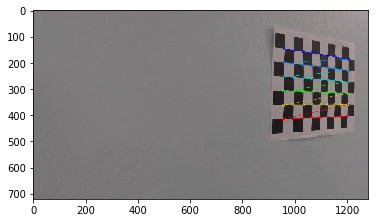

In [4]:
for image in images:

    # Read in image
    img = cv2.imread(image)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

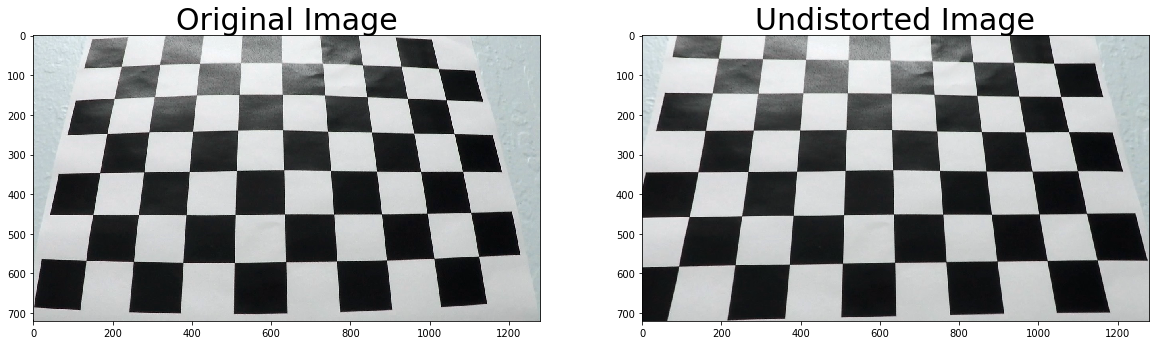

In [5]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
# Save the camera calibration result.
save = {
    "mtx" : mtx,
    "dist" : dist   
}

pickle.dump( save, open( "camera_calibration.p", "wb" ) )

Pipeline (single images)
1. Has the distortion correction been correctly applied to each image?

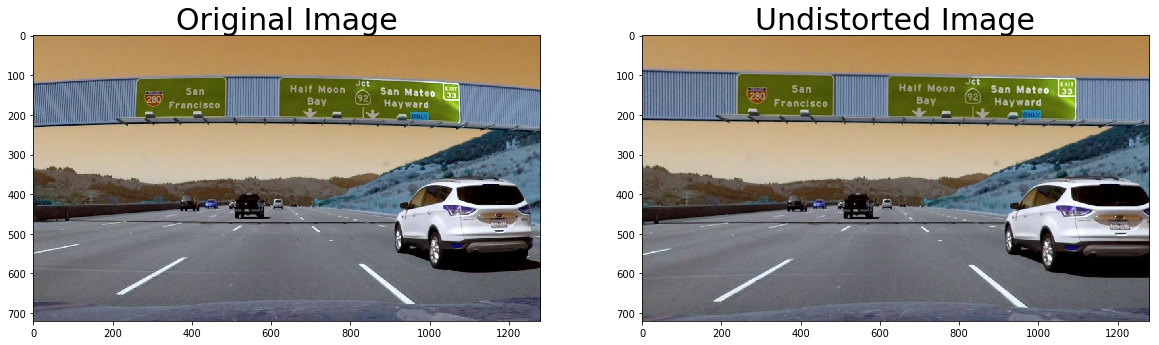

In [7]:
raw = cv2.imread("test_images/signs_vehicles_xygrad.png")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

2. Has a binary image been created using color transforms, gradients or other methods?

In [8]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))
colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

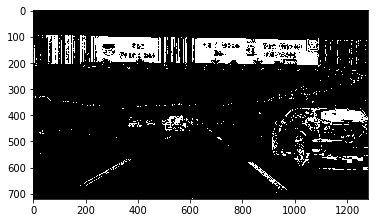

In [9]:
#s_thresh=(150, 255)
#sx_thresh=(40, 100)

s_thresh=(170, 255)
sx_thresh=(40, 100)

combined_binary = pipeline(image, s_thresh=s_thresh, sx_thresh=sx_thresh)
plt.imshow(combined_binary, cmap="gray")

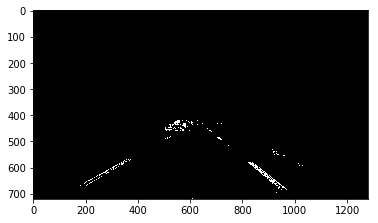

In [10]:
vertices = np.array([[(0,imshape[0]),(550, 420), (700, 420), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [11]:
"""
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[150,720],
     [150,0],
     [1130,0],
     [1130,720]])

"""
src = np.float32([
    [120, image.shape[0]],
    [image.shape[1]/2 - 90, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1]/2 + 60, image.shape[0]-image.shape[0]/2+110],
    [image.shape[1] - 120, image.shape[0]]
    ])
   
dst = np.float32([
    [150,image.shape[0]],
     [150,0],
     [image.shape[1] - 150,0],
     [image.shape[1] - 150,image.shape[0]]
    ])    
    
print(image.shape)
print(image.shape[0])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

print(src)
print(dst)

(720, 1280, 3)
720
[[  120.   720.]
 [  550.   470.]
 [  700.   470.]
 [ 1160.   720.]]
[[  150.   720.]
 [  150.     0.]
 [ 1130.     0.]
 [ 1130.   720.]]


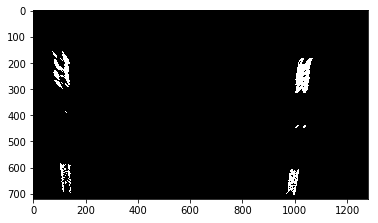

In [12]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

Have lane line pixels been identified in the rectified image and fit with a polynomial?

In [13]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty, histogram = histogram_pixels(warped, horizontal_offset=horizontal_offset, steps=6,window_radius=200)

print(len(histogram))

6


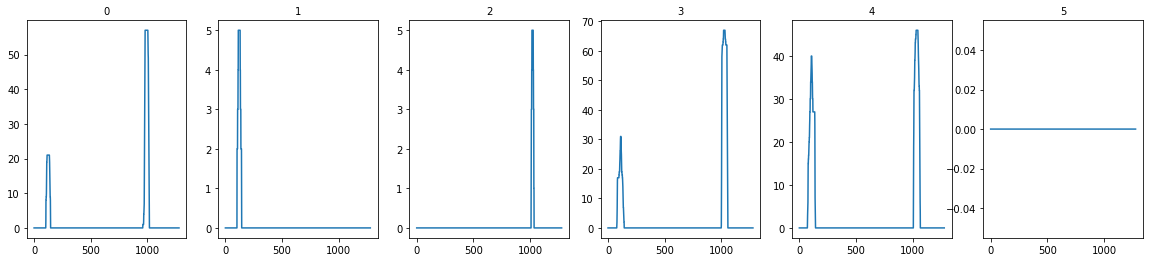

In [14]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,4))
#ax1.imshow(raw)
ax1.plot(histogram[0])
ax1.set_title('0', fontsize=10)
#ax2.imshow(image)
ax2.plot(histogram[1])
ax2.set_title('1', fontsize=10)

ax3.plot(histogram[2])
ax3.set_title('2', fontsize=10)

ax4.plot(histogram[3])
ax4.set_title('3', fontsize=10)

ax5.plot(histogram[4])
ax5.set_title('4', fontsize=10)

ax6.plot(histogram[5])
ax6.set_title('5', fontsize=10)

In [15]:
def get_pixel_in_window_test(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

#    x, y = (window.T == 1).nonzero()
    
    x, y = window.nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y, window

def get_pixel_in_window_test2(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    
    :size, window_radius=200
    
    """
      
    half_size = size // 2
    
    print(int(y_center - half_size))
    print(int(y_center + half_size))
    print(int(x_center - half_size))
    print(int(x_center + half_size))
    
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()
    
#    x, y = window.nonzero()

    print("original x %s" % x)
    print("original y %s" % y)

    x = x + x_center - half_size
    y = y + y_center - half_size
    
    print("x %s" % x)
    print("y %s" % y)

    return x, y, window

500
700
90
290
500
700
90
290
original x [13 13 13 ..., 55 55 55]
original y [ 84  86  88 ..., 146 166 195]
x [103 103 103 ..., 145 145 145]
y [584 586 588 ..., 646 666 695]


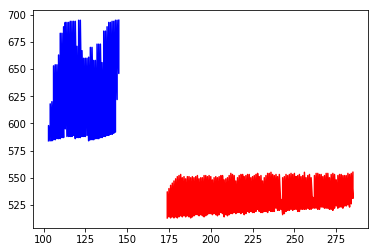

In [16]:
x, y, window = get_pixel_in_window_test(warped, 190,600, 200)
plt.plot(x,y,'r')

x, y, window = get_pixel_in_window_test2(warped, 190,600, 200)
plt.plot(x,y,'b')

In [17]:
print(leftx)

[103 103 103 ..., 141 142 142]


Left coeffs: [  7.91766626e-06   2.36548485e-02   1.05030043e+02]
righty[0]: , 708.0 , rightx[0]:  935
Right coeffs:  [  1.04319381e-05  -1.04777246e-01   1.05674898e+03]


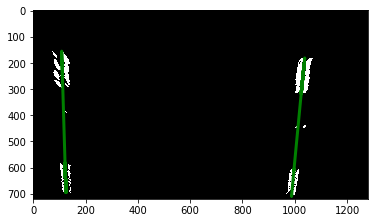

In [18]:
# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

In [19]:
def lane_poly_test(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    
    print("lane_poly is called")
    
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def draw_poly_test(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

Left coeffs:  [  7.91766626e-06   2.36548485e-02   1.05030043e+02]
Right fit:  [  1.04319381e-05  -1.04777246e-01   1.05674898e+03]
(720, 1280)


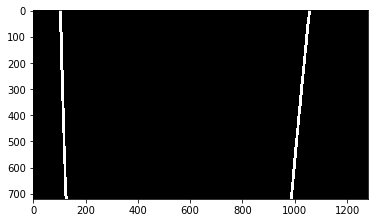

In [20]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")
print(polyfit_drawn.shape)

In [21]:
def evaluate_poly_test(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

In [22]:
def highlight_lane_line_area_test(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly_test(y, left_poly)
        right = evaluate_poly_test(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280)
255.0


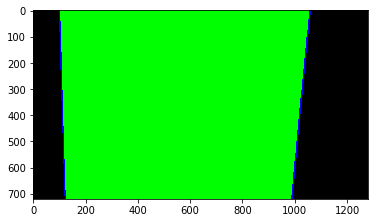

In [23]:
trace = colour_canvas
print(type(trace))
print(trace.shape)
#print(trace)
print(type(polyfit_drawn))
print(polyfit_drawn.shape)
print(np.max(polyfit_drawn))
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

http://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [24]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  63244.3686505 pixels
Right lane curve radius:  48571.0907249 pixels


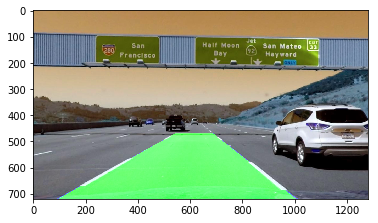

In [25]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

In [26]:
def add_figures_to_image_test(img, curvature, vehicle_position, min_curvature, left_coeffs=(0,0,0), right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)

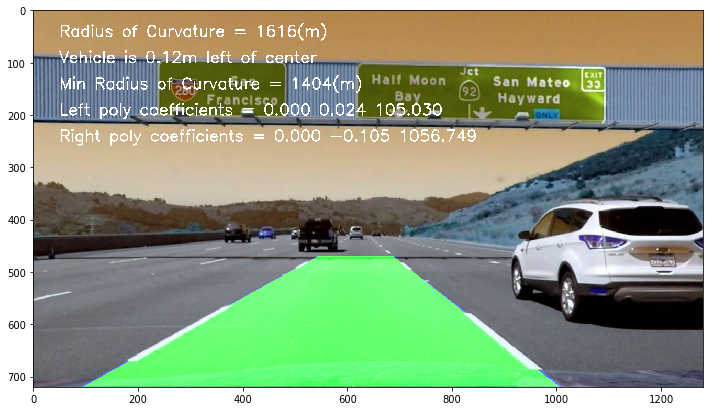

In [27]:
add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)

plt.rcParams["figure.figsize"] = (12,9)
plt.imshow(combined_img)

Left coeffs: [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
righty[0]: , 708.0 , rightx[0]:  1111
Right coeffs:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
Left lane curve radius:  3007.73878387
Right lane curve radius:  2343.55993365
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


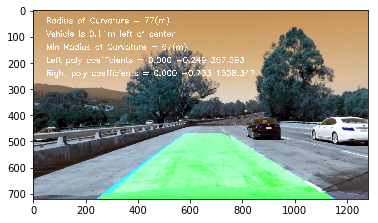

In [2]:
with open("camera_calibration.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32([
    [120, imshape[0]],
    [imshape[1]/2 - 90, imshape[0]-imshape[0]/2+110],
    [imshape[1]/2 + 60, imshape[0]-imshape[0]/2+110],
    [imshape[1] - 120, imshape[0]]
    ])
   
    dst = np.float32([
    [150,imshape[0]],
     [150,0],
     [imshape[1] - 150,0],
     [imshape[1] - 150,imshape[0]]
    ])    

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    imshape = raw.shape

    height = raw.shape[0]
#    offset = 50
#    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = height / steps
    window_radius = 200
    medianfilt_kernel_size = 51
#    horizontal_offset = 40

    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
#    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
#    curvature_checked = False

    s_thresh=(170, 255)
    sx_thresh=(40, 100)

    while have_fit == False:
#        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
        combined_binary = pipeline(image, s_thresh=s_thresh, sx_thresh=sx_thresh)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

        leftx, lefty, rightx, righty, histograms = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
            
#        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)

    # Convert to colour and highlight lane line area
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    print("polyfit shape: ", polyfit_drawn.shape)
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    # plt.imshow(trace)
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(trace)

    combined_img = cv2.add(lane_lines, image)
    add_figures_to_image(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left coeffs: [ -1.49781590e-04   1.79691960e-01   2.55308548e+02]
righty[0]: , 589.0 , rightx[0]:  1167
Right coeffs:  [ -1.40189882e-04   1.83912996e-02   1.23129424e+03]
Left lane curve radius:  3342.67463482
Right lane curve radius:  3646.24982282
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)
[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


  0%|          | 1/1261 [00:00<08:13,  2.55it/s]

Left coeffs: [ -1.49781590e-04   1.79691960e-01   2.55308548e+02]
righty[0]: , 589.0 , rightx[0]:  1167
Right coeffs:  [ -1.40189882e-04   1.83912996e-02   1.23129424e+03]
Left lane curve radius:  3342.67463482
Right lane curve radius:  3646.24982282
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  0%|          | 2/1261 [00:00<07:57,  2.64it/s]

Left coeffs: [ -1.85802269e-04   2.09478671e-01   2.51237292e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -9.33295221e-05  -1.53683543e-02   1.23163673e+03]
Left lane curve radius:  2693.29589292
Right lane curve radius:  5452.5892088
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  0%|          | 3/1261 [00:01<07:47,  2.69it/s]

Left coeffs: [ -2.00492896e-04   2.19860622e-01   2.51439685e+02]
righty[0]: , 655.0 , rightx[0]:  1155
Right coeffs:  [ -3.29907171e-05  -5.34144310e-02   1.23113504e+03]
Left lane curve radius:  2495.2572767
Right lane curve radius:  15325.8210048
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  0%|          | 4/1261 [00:01<07:41,  2.73it/s]

Left coeffs: [ -2.40264537e-04   2.52310810e-01   2.47338983e+02]
righty[0]: , 686.0 , rightx[0]:  1151
Right coeffs:  [  4.37207589e-05  -1.19229847e-01   1.23953544e+03]
Left lane curve radius:  2081.49252595
Right lane curve radius:  11534.1617874
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  0%|          | 5/1261 [00:01<07:32,  2.77it/s]

Left coeffs: [ -2.36238592e-04   2.57220756e-01   2.43939089e+02]
righty[0]: , 682.0 , rightx[0]:  1151
Right coeffs:  [ -2.60766060e-05  -6.22602043e-02   1.22964141e+03]
Left lane curve radius:  2117.90216003
Right lane curve radius:  19399.1482955
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  0%|          | 6/1261 [00:02<07:34,  2.76it/s]

Left coeffs: [ -2.40993215e-04   2.64058711e-01   2.43619549e+02]
righty[0]: , 680.0 , rightx[0]:  1150
Right coeffs:  [  1.09681632e-04  -1.94227247e-01   1.25512690e+03]
Left lane curve radius:  2076.40313079
Right lane curve radius:  4607.61324716
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 7/1261 [00:02<07:38,  2.74it/s]

Left coeffs: [ -2.26650583e-04   2.61293876e-01   2.40691703e+02]
righty[0]: , 679.0 , rightx[0]:  1150
Right coeffs:  [ -1.85195342e-04   7.98457550e-02   1.20350626e+03]
Left lane curve radius:  2210.01147432
Right lane curve radius:  2744.92301022
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 8/1261 [00:02<07:32,  2.77it/s]

Left coeffs: [ -2.23182129e-04   2.64756367e-01   2.39664468e+02]
righty[0]: , 567.0 , rightx[0]:  1163
Right coeffs:  [ -1.46020209e-04   5.60095430e-02   1.20077336e+03]
Left lane curve radius:  2246.13357773
Right lane curve radius:  3465.88143723
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 9/1261 [00:03<07:42,  2.71it/s]

Left coeffs: [ -2.12069954e-04   2.59273061e-01   2.37465098e+02]
righty[0]: , 599.0 , rightx[0]:  1161
Right coeffs:  [ -1.41744420e-04   4.44584497e-02   1.20759888e+03]
Left lane curve radius:  2365.59692091
Right lane curve radius:  3577.67302447
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 10/1261 [00:03<07:30,  2.78it/s]

Left coeffs: [ -1.97281762e-04   2.51671289e-01   2.35409020e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -1.49225698e-04   4.90749626e-02   1.20749465e+03]
Left lane curve radius:  2545.70062847
Right lane curve radius:  3401.16659406
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 11/1261 [00:03<07:24,  2.81it/s]

Left coeffs: [ -2.13793261e-04   2.72921996e-01   2.28667714e+02]
righty[0]: , 655.0 , rightx[0]:  1155
Right coeffs:  [ -3.36696699e-04   2.34810536e-01   1.16014673e+03]
Left lane curve radius:  2350.9835853
Right lane curve radius:  1508.19941263
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 12/1261 [00:04<07:22,  2.82it/s]

Left coeffs: [ -2.12458738e-04   2.86171712e-01   2.16192944e+02]
righty[0]: , 692.0 , rightx[0]:  1153
Right coeffs:  [ -2.60272532e-04   1.66452836e-01   1.18250205e+03]
Left lane curve radius:  2372.60531937
Right lane curve radius:  1946.48318517
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 13/1261 [00:04<07:22,  2.82it/s]

Left coeffs: [ -1.86881053e-04   2.69565238e-01   2.17778568e+02]
righty[0]: , 585.0 , rightx[0]:  1166
Right coeffs:  [ -2.16480678e-04   1.32006215e-01   1.18553862e+03]
Left lane curve radius:  2702.98273223
Right lane curve radius:  2334.44154348
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 14/1261 [00:05<07:17,  2.85it/s]

Left coeffs: [ -2.10318715e-04   2.94037077e-01   2.11485028e+02]
righty[0]: , 601.0 , rightx[0]:  1162
Right coeffs:  [ -7.92855509e-05   2.85567394e-02   1.19799453e+03]
Left lane curve radius:  2402.38141613
Right lane curve radius:  6330.67809953
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|          | 15/1261 [00:05<07:23,  2.81it/s]

Left coeffs: [ -2.03980464e-04   2.86510377e-01   2.14999918e+02]
righty[0]: , 638.0 , rightx[0]:  1153
Right coeffs:  [  1.42459824e-06  -2.07771842e-02   1.19133725e+03]
Left lane curve radius:  2476.3012481
Right lane curve radius:  351173.338127
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 16/1261 [00:05<07:22,  2.82it/s]

Left coeffs: [ -1.86686499e-04   2.69669096e-01   2.19788165e+02]
righty[0]: , 684.0 , rightx[0]:  1146
Right coeffs:  [  1.39576717e-04  -1.29527906e-01   1.19788865e+03]
Left lane curve radius:  2705.99891835
Right lane curve radius:  3582.80195475
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 17/1261 [00:06<07:15,  2.86it/s]

Left coeffs: [ -1.96497012e-04   2.76620035e-01   2.16979759e+02]
righty[0]: , 701.0 , rightx[0]:  1142
Right coeffs:  [  8.89278655e-05  -1.01871046e-01   1.19521170e+03]
Left lane curve radius:  2569.11027836
Right lane curve radius:  5623.9475331
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  1%|▏         | 18/1261 [00:06<07:10,  2.89it/s]

Left coeffs: [ -2.03782163e-04   2.81887526e-01   2.16399951e+02]
righty[0]: , 697.0 , rightx[0]:  1141
Right coeffs:  [  1.50064552e-04  -1.62734063e-01   1.20408413e+03]
Left lane curve radius:  2476.08671607
Right lane curve radius:  3332.70172924
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 19/1261 [00:06<07:10,  2.89it/s]

Left coeffs: [ -1.59982699e-04   2.53760717e-01   2.15138897e+02]
righty[0]: , 697.0 , rightx[0]:  1141
Right coeffs:  [ -3.96299171e-05  -4.71085652e-03   1.18226278e+03]
Left lane curve radius:  3166.65628432
Right lane curve radius:  12653.9578997
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 20/1261 [00:07<07:06,  2.91it/s]

Left coeffs: [ -1.52664100e-04   2.55336180e-01   2.09341466e+02]
righty[0]: , 694.0 , rightx[0]:  1142
Right coeffs:  [  1.16607288e-04  -1.75969057e-01   1.22686318e+03]
Left lane curve radius:  3327.0884659
Right lane curve radius:  4310.58128843
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 21/1261 [00:07<07:05,  2.92it/s]

Left coeffs: [ -1.24609369e-04   2.36839534e-01   2.07968622e+02]
righty[0]: , 576.0 , rightx[0]:  1148
Right coeffs:  [ -1.79503443e-04   4.97614831e-02   1.19275080e+03]
Left lane curve radius:  4088.58816101
Right lane curve radius:  2856.08845478
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 22/1261 [00:07<07:12,  2.86it/s]

Left coeffs: [ -1.16229780e-04   2.32813829e-01   2.03668270e+02]
righty[0]: , 607.0 , rightx[0]:  1148
Right coeffs:  [ -4.28541257e-05  -7.28433868e-02   1.22621026e+03]
Left lane curve radius:  4389.82540291
Right lane curve radius:  11902.5402852
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 23/1261 [00:08<07:09,  2.88it/s]

Left coeffs: [ -9.58945416e-05   2.18568104e-01   2.00948110e+02]
righty[0]: , 638.0 , rightx[0]:  1147
Right coeffs:  [ -2.99325244e-05  -9.02263300e-02   1.23582431e+03]
Left lane curve radius:  5332.20087664
Right lane curve radius:  17067.3077569
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 24/1261 [00:08<07:09,  2.88it/s]

Left coeffs: [ -6.96615853e-05   1.83236493e-01   2.11814371e+02]
righty[0]: , 667.0 , rightx[0]:  1144
Right coeffs:  [ -1.33884350e-04   5.58733526e-03   1.21230806e+03]
Left lane curve radius:  7316.88166022
Right lane curve radius:  3827.15197063
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 25/1261 [00:08<07:25,  2.77it/s]

Left coeffs: [ -8.50814227e-05   1.89465960e-01   2.12034322e+02]
righty[0]: , 699.0 , rightx[0]:  1139
Right coeffs:  [ -7.12614812e-05  -4.75313535e-02   1.22217344e+03]
Left lane curve radius:  5973.03504917
Right lane curve radius:  7165.45665121
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 26/1261 [00:09<07:20,  2.80it/s]

Left coeffs: [ -8.37460858e-05   1.87855285e-01   2.09554256e+02]
righty[0]: , 594.0 , rightx[0]:  1152
Right coeffs:  [ -2.60182666e-04   1.13480150e-01   1.19634474e+03]
Left lane curve radius:  6067.75858871
Right lane curve radius:  1984.09742795
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 27/1261 [00:09<07:09,  2.87it/s]

Left coeffs: [ -9.10098199e-05   1.86013432e-01   2.11256176e+02]
righty[0]: , 623.0 , rightx[0]:  1150
Right coeffs:  [ -9.76552880e-05  -3.95587671e-03   1.21329094e+03]
Left lane curve radius:  5568.45971753
Right lane curve radius:  5199.55022968
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 28/1261 [00:09<07:07,  2.89it/s]

Left coeffs: [ -7.08018540e-05   1.67268872e-01   2.11100835e+02]
righty[0]: , 657.0 , rightx[0]:  1150
Right coeffs:  [ -1.61659927e-04   2.58859444e-02   1.22262853e+03]
Left lane curve radius:  7160.76765803
Right lane curve radius:  3178.83018933
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 29/1261 [00:10<07:09,  2.87it/s]

Left coeffs: [ -1.12399012e-04   1.91915500e-01   2.11645439e+02]
righty[0]: , 690.0 , rightx[0]:  1145
Right coeffs:  [ -1.02049028e-04  -1.03743115e-02   1.22098845e+03]
Left lane curve radius:  4490.69465181
Right lane curve radius:  4992.78784366
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 30/1261 [00:10<07:11,  2.85it/s]

Left coeffs: [ -1.57436147e-04   2.18254749e-01   2.12487411e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [ -6.64427773e-06  -8.46491478e-02   1.22551351e+03]
Left lane curve radius:  3193.52798897
Right lane curve radius:  76195.4714222
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  2%|▏         | 31/1261 [00:10<07:03,  2.90it/s]

Left coeffs: [ -1.78965027e-04   2.28793876e-01   2.15864912e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [ -8.66473852e-06  -7.51963595e-02   1.21875558e+03]
Left lane curve radius:  2804.25370874
Right lane curve radius:  58314.9479441
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 32/1261 [00:11<07:07,  2.88it/s]

Left coeffs: [ -2.07410562e-04   2.42339426e-01   2.20755353e+02]
righty[0]: , 701.0 , rightx[0]:  1140
Right coeffs:  [ -2.03134016e-04   1.16872840e-01   1.17338763e+03]
Left lane curve radius:  2415.09059516
Right lane curve radius:  2488.95345833
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 33/1261 [00:11<07:04,  2.89it/s]

Left coeffs: [ -1.69414304e-04   2.13377717e-01   2.23369053e+02]
righty[0]: , 704.0 , rightx[0]:  1142
Right coeffs:  [ -6.77567579e-05  -2.93478014e-02   1.21338012e+03]
Left lane curve radius:  2959.90523339
Right lane curve radius:  7483.9563164
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 34/1261 [00:11<07:03,  2.90it/s]

Left coeffs: [ -1.94691273e-04   2.33569637e-01   2.22337519e+02]
righty[0]: , 591.0 , rightx[0]:  1156
Right coeffs:  [ -8.97212607e-05   1.28346700e-02   1.19775599e+03]
Left lane curve radius:  2573.99351304
Right lane curve radius:  5622.30404321
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 35/1261 [00:12<07:04,  2.89it/s]

Left coeffs: [ -2.11574197e-04   2.47041580e-01   2.22332629e+02]
righty[0]: , 623.0 , rightx[0]:  1153
Right coeffs:  [ -8.10817578e-05   6.66620720e-04   1.20199231e+03]
Left lane curve radius:  2367.69774183
Right lane curve radius:  6226.52729566
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 36/1261 [00:12<07:02,  2.90it/s]

Left coeffs: [ -1.88791874e-04   2.25628632e-01   2.30203660e+02]
righty[0]: , 673.0 , rightx[0]:  1137
Right coeffs:  [ -1.99605584e-04   1.07270218e-01   1.17640904e+03]
Left lane curve radius:  2653.81155064
Right lane curve radius:  2537.04312777
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 37/1261 [00:13<07:06,  2.87it/s]

Left coeffs: [ -2.00138107e-04   2.37116792e-01   2.28744175e+02]
righty[0]: , 703.0 , rightx[0]:  1132
Right coeffs:  [ -3.94247220e-04   2.85951049e-01   1.13389518e+03]
Left lane curve radius:  2503.4008984
Right lane curve radius:  1290.6160388
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 38/1261 [00:13<07:03,  2.89it/s]

Left coeffs: [ -2.05198160e-04   2.37964832e-01   2.31950780e+02]
righty[0]: , 563.0 , rightx[0]:  1150
Right coeffs:  [ -2.50591639e-04   1.80928558e-01   1.14936360e+03]
Left lane curve radius:  2440.5942933
Right lane curve radius:  2009.82013345
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 39/1261 [00:13<06:54,  2.95it/s]

Left coeffs: [ -2.17264041e-04   2.49488792e-01   2.30754859e+02]
righty[0]: , 606.0 , rightx[0]:  1144
Right coeffs:  [ -1.52246914e-04   1.19783863e-01   1.14897723e+03]
Left lane curve radius:  2304.93286172
Right lane curve radius:  3289.33165684
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 40/1261 [00:14<06:57,  2.92it/s]

Left coeffs: [ -2.26627381e-04   2.64015412e-01   2.25469923e+02]
righty[0]: , 626.0 , rightx[0]:  1143
Right coeffs:  [ -6.96178109e-05   4.42036371e-02   1.16491966e+03]
Left lane curve radius:  2210.89245144
Right lane curve radius:  7189.02938334
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 41/1261 [00:14<07:01,  2.89it/s]

Left coeffs: [ -2.32020175e-04   2.70078350e-01   2.24633484e+02]
righty[0]: , 668.0 , rightx[0]:  1140
Right coeffs:  [  1.28824240e-05  -2.41750232e-02   1.17461181e+03]
Left lane curve radius:  2159.66870828
Right lane curve radius:  38819.9958064
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 42/1261 [00:14<07:09,  2.84it/s]

Left coeffs: [ -2.32542363e-04   2.71824950e-01   2.25002242e+02]
righty[0]: , 702.0 , rightx[0]:  1136
Right coeffs:  [ -3.50477480e-06  -2.72000519e-02   1.18192534e+03]
Left lane curve radius:  2155.12468782
Right lane curve radius:  142864.316666
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 43/1261 [00:15<07:24,  2.74it/s]

Left coeffs: [ -2.39174010e-04   2.83696484e-01   2.20503630e+02]
righty[0]: , 707.0 , rightx[0]:  1139
Right coeffs:  [  1.57811378e-05  -5.96891140e-02   1.19488625e+03]
Left lane curve radius:  2096.74715656
Right lane curve radius:  31775.0618979
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  3%|▎         | 44/1261 [00:15<07:24,  2.74it/s]

Left coeffs: [ -2.60539968e-04   3.12965332e-01   2.09545002e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [  2.46699371e-05  -8.58924234e-02   1.20895982e+03]
Left lane curve radius:  1927.00848959
Right lane curve radius:  20381.6399811
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 45/1261 [00:15<07:15,  2.79it/s]

Left coeffs: [ -2.51718166e-04   3.10956145e-01   2.07481043e+02]
righty[0]: , 697.0 , rightx[0]:  1143
Right coeffs:  [ -1.65973596e-04   8.29611507e-02   1.18161917e+03]
Left lane curve radius:  1996.8132215
Right lane curve radius:  3043.72024111
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 46/1261 [00:16<07:15,  2.79it/s]

Left coeffs: [ -2.67318659e-04   3.28407484e-01   2.02407535e+02]
righty[0]: , 570.0 , rightx[0]:  1156
Right coeffs:  [ -1.50230026e-04   6.74266801e-02   1.18474842e+03]
Left lane curve radius:  1880.90683746
Right lane curve radius:  3362.51755546
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▎         | 47/1261 [00:16<07:03,  2.87it/s]

Left coeffs: [ -2.94102068e-04   3.57475191e-01   1.94412712e+02]
righty[0]: , 706.0 , rightx[0]:  1128
Right coeffs:  [ -2.10367620e-04   1.04377632e-01   1.18424525e+03]
Left lane curve radius:  1710.34206029
Right lane curve radius:  2416.95478671
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 48/1261 [00:16<07:07,  2.84it/s]

Left coeffs: [ -2.75078155e-04   3.46023242e-01   1.94834787e+02]
righty[0]: , 674.0 , rightx[0]:  1128
Right coeffs:  [ -1.59507465e-04   7.39226529e-02   1.18474800e+03]
Left lane curve radius:  1831.40551492
Right lane curve radius:  3169.15335444
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 49/1261 [00:17<07:11,  2.81it/s]

Left coeffs: [ -2.46273731e-04   3.29400110e-01   1.92264441e+02]
righty[0]: , 706.0 , rightx[0]:  1125
Right coeffs:  [ -1.63048156e-04   6.59780280e-02   1.19300451e+03]
Left lane curve radius:  2051.34114812
Right lane curve radius:  3110.02339191
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 50/1261 [00:17<07:11,  2.81it/s]

Left coeffs: [ -2.53625839e-04   3.43864755e-01   1.86435619e+02]
righty[0]: , 703.0 , rightx[0]:  1144
Right coeffs:  [ -2.18300097e-04   1.14507321e-01   1.18197041e+03]
Left lane curve radius:  1995.53686706
Right lane curve radius:  2327.53642109
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 51/1261 [00:17<07:15,  2.78it/s]

Left coeffs: [ -2.56310679e-04   3.54452287e-01   1.80995269e+02]
righty[0]: , 591.0 , rightx[0]:  1154
Right coeffs:  [ -2.22816985e-04   1.41081135e-01   1.17000175e+03]
Left lane curve radius:  1979.00922675
Right lane curve radius:  2266.51895701
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 52/1261 [00:18<07:20,  2.74it/s]

Left coeffs: [ -2.40425117e-04   3.44142483e-01   1.82323104e+02]
righty[0]: , 623.0 , rightx[0]:  1148
Right coeffs:  [ -1.87840820e-04   1.33212270e-01   1.15921311e+03]
Left lane curve radius:  2113.29678499
Right lane curve radius:  2673.75258862
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 53/1261 [00:18<07:18,  2.76it/s]

Left coeffs: [ -2.35796296e-04   3.39004275e-01   1.83778429e+02]
righty[0]: , 645.0 , rightx[0]:  1144
Right coeffs:  [ -8.19955646e-05   5.24293250e-02   1.16660383e+03]
Left lane curve radius:  2154.44499972
Right lane curve radius:  6105.88838148
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 54/1261 [00:19<07:18,  2.75it/s]

Left coeffs: [ -2.18686699e-04   3.28918348e-01   1.82830037e+02]
righty[0]: , 683.0 , rightx[0]:  1112
Right coeffs:  [ -6.45947094e-05   3.84163736e-02   1.16599369e+03]
Left lane curve radius:  2328.17493599
Right lane curve radius:  7748.53035729
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 55/1261 [00:19<07:24,  2.71it/s]

Left coeffs: [ -2.07562215e-04   3.23627373e-01   1.80264834e+02]
righty[0]: , 704.0 , rightx[0]:  1139
Right coeffs:  [ -4.26801431e-05   6.83008897e-03   1.17552901e+03]
Left lane curve radius:  2457.75605285
Right lane curve radius:  11737.6417419
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  4%|▍         | 56/1261 [00:19<07:12,  2.79it/s]

Left coeffs: [ -1.75205711e-04   2.98068419e-01   1.82387913e+02]
righty[0]: , 647.0 , rightx[0]:  1116
Right coeffs:  [ -8.34111374e-05   3.51626073e-02   1.17481302e+03]
Left lane curve radius:  2918.64945646
Right lane curve radius:  6015.34725078
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 57/1261 [00:20<07:10,  2.79it/s]

Left coeffs: [ -1.52080104e-04   2.79889111e-01   1.84316646e+02]
righty[0]: , 679.0 , rightx[0]:  1114
Right coeffs:  [ -2.28152087e-05  -2.60283717e-02   1.18769018e+03]
Left lane curve radius:  3368.62772191
Right lane curve radius:  21993.6773468
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 58/1261 [00:20<07:13,  2.78it/s]

Left coeffs: [ -1.28786101e-04   2.58952808e-01   1.87060162e+02]
righty[0]: , 707.0 , rightx[0]:  1138
Right coeffs:  [ -5.99216301e-05   6.50001965e-03   1.18256693e+03]
Left lane curve radius:  3981.49490087
Right lane curve radius:  8379.9777582
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 59/1261 [00:20<07:32,  2.66it/s]

Left coeffs: [ -9.16119183e-05   2.16959902e-01   1.99944060e+02]
righty[0]: , 445.0 , rightx[0]:  1142
Right coeffs:  [ -1.05576269e-04   7.17935251e-02   1.15620328e+03]
Left lane curve radius:  5586.93961433
Right lane curve radius:  4744.02252963
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 60/1261 [00:21<07:27,  2.68it/s]

Left coeffs: [ -7.58186078e-05   1.92435650e-01   2.08843334e+02]
righty[0]: , 623.0 , rightx[0]:  1136
Right coeffs:  [ -1.24405514e-04   9.50292468e-02   1.14272047e+03]
Left lane curve radius:  6729.67052853
Right lane curve radius:  4024.31812271
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 61/1261 [00:21<07:29,  2.67it/s]

Left coeffs: [ -7.29299582e-05   1.81409845e-01   2.12675724e+02]
righty[0]: , 653.0 , rightx[0]:  1133
Right coeffs:  [ -4.60790093e-04   3.64569376e-01   1.08965288e+03]
Left lane curve radius:  6977.26752915
Right lane curve radius:  1100.19697759
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 62/1261 [00:22<07:19,  2.73it/s]

Left coeffs: [ -6.67761767e-05   1.63608940e-01   2.20472382e+02]
righty[0]: , 687.0 , rightx[0]:  1130
Right coeffs:  [ -3.13122307e-04   2.78965526e-01   1.09300730e+03]
Left lane curve radius:  7593.26038542
Right lane curve radius:  1599.61541399
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▍         | 63/1261 [00:22<07:22,  2.71it/s]

Left coeffs: [ -6.94206805e-05   1.63610077e-01   2.19280066e+02]
righty[0]: , 481.0 , rightx[0]:  1131
Right coeffs:  [ -1.74391852e-04   1.79149829e-01   1.10931955e+03]
Left lane curve radius:  7298.52348792
Right lane curve radius:  2867.20379069
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 64/1261 [00:22<07:05,  2.81it/s]

Left coeffs: [ -8.19037191e-05   1.63186090e-01   2.23465841e+02]
righty[0]: , 702.0 , rightx[0]:  1094
Right coeffs:  [ -6.21130889e-05   9.37810871e-02   1.11783459e+03]
Left lane curve radius:  6165.32801105
Right lane curve radius:  8061.94546751
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 65/1261 [00:23<07:05,  2.81it/s]

Left coeffs: [ -1.08592106e-04   1.83617138e-01   2.18182904e+02]
righty[0]: , 648.0 , rightx[0]:  1127
Right coeffs:  [  1.52418597e-05   1.02485354e-02   1.13864507e+03]
Left lane curve radius:  4643.3163603
Right lane curve radius:  32836.3735589
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 66/1261 [00:23<07:00,  2.84it/s]

Left coeffs: [ -1.33117701e-04   1.95891263e-01   2.19082051e+02]
righty[0]: , 673.0 , rightx[0]:  1125
Right coeffs:  [  3.31020705e-05  -8.64482016e-03   1.14014429e+03]
Left lane curve radius:  3778.29766241
Right lane curve radius:  15118.3499191
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 67/1261 [00:23<07:03,  2.82it/s]

Left coeffs: [ -1.42479388e-04   2.01028504e-01   2.17830896e+02]
righty[0]: , 703.0 , rightx[0]:  1121
Right coeffs:  [ -4.19724035e-05   4.18926466e-02   1.13398327e+03]
Left lane curve radius:  3527.33969135
Right lane curve radius:  11912.5892967
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 68/1261 [00:24<07:11,  2.77it/s]

Left coeffs: [ -1.94544045e-04   2.42279130e-01   2.08791984e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [  7.17808952e-05  -8.12915824e-02   1.16357034e+03]
Left lane curve radius:  2578.90162134
Right lane curve radius:  6966.5868633
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  5%|▌         | 69/1261 [00:24<07:05,  2.80it/s]

Left coeffs: [ -2.16190378e-04   2.56408952e-01   2.08893191e+02]
righty[0]: , 693.0 , rightx[0]:  1120
Right coeffs:  [ -5.82665727e-06  -9.71133906e-03   1.14641494e+03]
Left lane curve radius:  2318.39014322
Right lane curve radius:  85843.5737896
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 70/1261 [00:24<07:07,  2.79it/s]

Left coeffs: [ -2.34209481e-04   2.77969327e-01   2.00189835e+02]
righty[0]: , 692.0 , rightx[0]:  1119
Right coeffs:  [ -1.65671658e-05  -2.20677904e-02   1.15836434e+03]
Left lane curve radius:  2140.97601142
Right lane curve radius:  30247.775492
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 71/1261 [00:25<06:57,  2.85it/s]

Left coeffs: [ -2.30351410e-04   2.76436532e-01   2.00227257e+02]
righty[0]: , 574.0 , rightx[0]:  1127
Right coeffs:  [  2.36770705e-05  -4.68131622e-02   1.16103712e+03]
Left lane curve radius:  2177.51532108
Right lane curve radius:  21134.4352375
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 72/1261 [00:25<07:07,  2.78it/s]

Left coeffs: [ -2.34370146e-04   2.88025595e-01   1.93677963e+02]
righty[0]: , 606.0 , rightx[0]:  1126
Right coeffs:  [ -8.53896527e-06  -4.79524256e-02   1.16966035e+03]
Left lane curve radius:  2142.59683739
Right lane curve radius:  58835.6259337
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 73/1261 [00:25<07:14,  2.74it/s]

Left coeffs: [ -2.31277747e-04   2.92998693e-01   1.88935399e+02]
righty[0]: , 637.0 , rightx[0]:  1124
Right coeffs:  [  2.46916473e-05  -6.55520369e-02   1.17259935e+03]
Left lane curve radius:  2174.268089
Right lane curve radius:  20300.4965274
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 74/1261 [00:26<07:17,  2.71it/s]

Left coeffs: [ -2.11355675e-04   2.80994074e-01   1.88626025e+02]
righty[0]: , 668.0 , rightx[0]:  1121
Right coeffs:  [ -2.99395660e-04   1.91741261e-01   1.12345466e+03]
Left lane curve radius:  2382.90992634
Right lane curve radius:  1699.14700268
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 75/1261 [00:26<07:27,  2.65it/s]

Left coeffs: [ -1.93907817e-04   2.76009698e-01   1.83157908e+02]
righty[0]: , 669.0 , rightx[0]:  1114
Right coeffs:  [ -3.04151150e-04   1.85495168e-01   1.13148056e+03]
Left lane curve radius:  2604.66058918
Right lane curve radius:  1678.75910619
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 76/1261 [00:27<07:14,  2.73it/s]

Left coeffs: [ -1.45556686e-04   2.36345390e-01   1.90047349e+02]
righty[0]: , 592.0 , rightx[0]:  1118
Right coeffs:  [ -2.41680793e-04   1.46805546e-01   1.13432782e+03]
Left lane curve radius:  3477.64624651
Right lane curve radius:  2096.84082789
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 77/1261 [00:27<07:09,  2.76it/s]

Left coeffs: [ -1.18479669e-04   2.26314531e-01   1.82330999e+02]
righty[0]: , 615.0 , rightx[0]:  1120
Right coeffs:  [ -1.80841141e-04   7.96165850e-02   1.15891309e+03]
Left lane curve radius:  4293.95674131
Right lane curve radius:  2807.46105692
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▌         | 78/1261 [00:27<07:03,  2.79it/s]

Left coeffs: [ -8.89577542e-05   2.04447493e-01   1.82577023e+02]
righty[0]: , 700.0 , rightx[0]:  1103
Right coeffs:  [ -1.11103288e-04   1.84246320e-02   1.17252322e+03]
Left lane curve radius:  5733.47086797
Right lane curve radius:  4558.42327433
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 79/1261 [00:28<07:01,  2.81it/s]

Left coeffs: [ -6.64156268e-05   1.85047550e-01   1.82668086e+02]
righty[0]: , 684.0 , rightx[0]:  1106
Right coeffs:  [ -2.38014463e-05  -6.08352634e-02   1.18851321e+03]
Left lane curve radius:  7687.83229504
Right lane curve radius:  21233.2533908
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 80/1261 [00:28<07:03,  2.79it/s]

Left coeffs: [ -6.23504742e-05   1.75846906e-01   1.84342011e+02]
righty[0]: , 696.0 , rightx[0]:  1111
Right coeffs:  [  2.90913340e-05  -1.17927960e-01   1.19989911e+03]
Left lane curve radius:  8174.63110661
Right lane curve radius:  17391.1111275
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  6%|▋         | 81/1261 [00:28<07:00,  2.80it/s]

Left coeffs: [ -4.63402015e-05   1.53517424e-01   1.90443723e+02]
righty[0]: , 704.0 , rightx[0]:  1110
Right coeffs:  [ -5.66795368e-05  -3.80934122e-02   1.18204499e+03]
Left lane curve radius:  10976.2127577
Right lane curve radius:  8940.64359588
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 82/1261 [00:29<07:05,  2.77it/s]

Left coeffs: [ -4.61919860e-05   1.50377951e-01   1.89189595e+02]
righty[0]: , 695.0 , rightx[0]:  1110
Right coeffs:  [ -9.35245320e-06  -9.53906640e-02   1.19847855e+03]
Left lane curve radius:  11001.1093351
Right lane curve radius:  54344.1230685
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 83/1261 [00:29<07:08,  2.75it/s]

Left coeffs: [ -5.32823329e-05   1.49403939e-01   1.89569653e+02]
righty[0]: , 704.0 , rightx[0]:  1109
Right coeffs:  [ -7.12004040e-06  -1.03041989e-01   1.20292605e+03]
Left lane curve radius:  9514.32635421
Right lane curve radius:  71506.5201946
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 84/1261 [00:29<06:54,  2.84it/s]

Left coeffs: [ -4.33364909e-05   1.47944001e-01   1.81801945e+02]
righty[0]: , 578.0 , rightx[0]:  1134
Right coeffs:  [  4.10900455e-05  -1.46423424e-01   1.22362506e+03]
Left lane curve radius:  11727.5176074
Right lane curve radius:  12371.4727904
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 85/1261 [00:30<06:54,  2.84it/s]

Left coeffs: [ -5.18147755e-05   1.46073314e-01   1.84876164e+02]
righty[0]: , 615.0 , rightx[0]:  1129
Right coeffs:  [ -1.03271889e-04  -2.62230587e-02   1.20068581e+03]
Left lane curve radius:  9778.64476238
Right lane curve radius:  4963.88017746
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 86/1261 [00:30<06:58,  2.80it/s]

Left coeffs: [ -6.03202821e-05   1.44174741e-01   1.88449158e+02]
righty[0]: , 653.0 , rightx[0]:  1123
Right coeffs:  [ -1.03015483e-04  -4.10460984e-02   1.20718722e+03]
Left lane curve radius:  8376.66735063
Right lane curve radius:  5005.51735491
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 87/1261 [00:31<07:05,  2.76it/s]

Left coeffs: [ -6.11508544e-05   1.23166605e-01   2.04902937e+02]
righty[0]: , 678.0 , rightx[0]:  1117
Right coeffs:  [ -3.59021705e-04   2.03366933e-01   1.14468067e+03]
Left lane curve radius:  8223.71562621
Right lane curve radius:  1443.59219598
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 88/1261 [00:31<07:07,  2.74it/s]

Left coeffs: [ -9.53611479e-05   1.36882982e-01   2.11181476e+02]
righty[0]: , 567.0 , rightx[0]:  1123
Right coeffs:  [ -3.43181917e-04   2.04493677e-01   1.13541933e+03]
Left lane curve radius:  5256.79079279
Right lane curve radius:  1499.19020542
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 89/1261 [00:31<07:06,  2.75it/s]

Left coeffs: [ -1.08633064e-04   1.37341289e-01   2.17920281e+02]
righty[0]: , 601.0 , rightx[0]:  1117
Right coeffs:  [ -1.98234691e-04   1.36687582e-01   1.12969788e+03]
Left lane curve radius:  4608.34143108
Right lane curve radius:  2536.60809917
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 90/1261 [00:32<06:59,  2.79it/s]

Left coeffs: [ -1.10026935e-04   1.26871279e-01   2.29520707e+02]
righty[0]: , 634.0 , rightx[0]:  1112
Right coeffs:  [ -1.15672041e-05  -3.12077689e-03   1.14198568e+03]
Left lane curve radius:  4546.27599922
Right lane curve radius:  43239.6462415
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 91/1261 [00:32<06:57,  2.80it/s]

Left coeffs: [ -1.29902666e-04   1.46052403e-01   2.24110312e+02]
righty[0]: , 666.0 , rightx[0]:  1110
Right coeffs:  [  6.38675343e-05  -8.12770819e-02   1.16269894e+03]
Left lane curve radius:  3850.54162325
Right lane curve radius:  7832.26316218
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 92/1261 [00:32<07:07,  2.74it/s]

Left coeffs: [ -1.45329564e-04   1.60855494e-01   2.21656317e+02]
righty[0]: , 698.0 , rightx[0]:  1106
Right coeffs:  [  5.71358625e-05  -9.33474529e-02   1.17018910e+03]
Left lane curve radius:  3441.70028118
Right lane curve radius:  8768.28947204
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 93/1261 [00:33<07:09,  2.72it/s]

Left coeffs: [ -1.72420286e-04   1.75183570e-01   2.24859120e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  1.68652359e-04  -2.04256098e-01   1.18966151e+03]
Left lane curve radius:  2899.92401434
Right lane curve radius:  2970.3173082
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  7%|▋         | 94/1261 [00:33<06:56,  2.80it/s]

Left coeffs: [ -2.01264892e-04   2.00800631e-01   2.22246263e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  4.91574804e-05  -1.03840746e-01   1.17397437e+03]
Left lane curve radius:  2484.28902461
Right lane curve radius:  10217.0486854
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 95/1261 [00:33<06:47,  2.86it/s]

Left coeffs: [ -1.96064975e-04   2.00913124e-01   2.19736962e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [  1.01470172e-04  -1.77552900e-01   1.19746469e+03]
Left lane curve radius:  2550.26492826
Right lane curve radius:  4970.40366614
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 96/1261 [00:34<06:46,  2.87it/s]

Left coeffs: [ -2.04172429e-04   2.10936325e-01   2.17385868e+02]
righty[0]: , 571.0 , rightx[0]:  1119
Right coeffs:  [ -8.39362250e-05  -2.07644411e-02   1.16815812e+03]
Left lane curve radius:  2449.07853881
Right lane curve radius:  6055.12295626
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 97/1261 [00:34<06:52,  2.82it/s]

Left coeffs: [ -2.00876061e-04   2.11253026e-01   2.17690078e+02]
righty[0]: , 597.0 , rightx[0]:  1115
Right coeffs:  [ -8.21948756e-05  -3.11627665e-02   1.17348238e+03]
Left lane curve radius:  2489.499048
Right lane curve radius:  6200.73157928
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 98/1261 [00:34<06:56,  2.79it/s]

Left coeffs: [ -1.82009485e-04   2.03099035e-01   2.15200104e+02]
righty[0]: , 628.0 , rightx[0]:  1114
Right coeffs:  [ -4.89113898e-05  -6.72918438e-02   1.18862053e+03]
Left lane curve radius:  2748.94252196
Right lane curve radius:  10430.3211917
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 99/1261 [00:35<06:43,  2.88it/s]

Left coeffs: [ -1.79450964e-04   2.01055323e-01   2.17845177e+02]
righty[0]: , 661.0 , rightx[0]:  1109
Right coeffs:  [ -3.24473701e-04   1.64031434e-01   1.14006525e+03]
Left lane curve radius:  2788.22743547
Right lane curve radius:  1600.83854528
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 100/1261 [00:35<06:43,  2.88it/s]

Left coeffs: [ -1.76941325e-04   2.03145332e-01   2.15621086e+02]
righty[0]: , 694.0 , rightx[0]:  1106
Right coeffs:  [ -1.01083331e-04  -3.63192856e-02   1.18843853e+03]
Left lane curve radius:  2828.70650542
Right lane curve radius:  5087.15161921
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 101/1261 [00:36<06:56,  2.79it/s]

Left coeffs: [ -1.63538928e-04   1.92911682e-01   2.19228620e+02]
righty[0]: , 589.0 , rightx[0]:  1114
Right coeffs:  [ -2.73793106e-04   1.38160492e-01   1.14645113e+03]
Left lane curve radius:  3061.33355705
Right lane curve radius:  1876.82013965
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 102/1261 [00:36<06:48,  2.83it/s]

Left coeffs: [ -1.58790582e-04   1.88898100e-01   2.21861517e+02]
righty[0]: , 624.0 , rightx[0]:  1108
Right coeffs:  [ -2.26116488e-04   1.08355804e-01   1.14719785e+03]
Left lane curve radius:  3153.08372868
Right lane curve radius:  2257.40574978
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 103/1261 [00:36<06:55,  2.79it/s]

Left coeffs: [ -1.51912348e-04   1.82883743e-01   2.23388802e+02]
righty[0]: , 656.0 , rightx[0]:  1106
Right coeffs:  [ -1.31357247e-04   3.05551707e-02   1.16296332e+03]
Left lane curve radius:  3296.10858116
Right lane curve radius:  3864.57643331
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 104/1261 [00:37<06:46,  2.84it/s]

Left coeffs: [ -1.48480126e-04   1.79825188e-01   2.25611306e+02]
righty[0]: , 686.0 , rightx[0]:  1104
Right coeffs:  [ -9.88225855e-05   5.59872500e-03   1.16721184e+03]
Left lane curve radius:  3372.41811873
Right lane curve radius:  5125.67197808
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 105/1261 [00:37<06:48,  2.83it/s]

Left coeffs: [ -1.32985420e-04   1.71362915e-01   2.23431860e+02]
righty[0]: , 703.0 , rightx[0]:  1105
Right coeffs:  [ -6.30686137e-05  -4.34005336e-02   1.18790563e+03]
Left lane curve radius:  3768.12006026
Right lane curve radius:  8063.05669235
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 106/1261 [00:37<06:49,  2.82it/s]

Left coeffs: [ -1.45609043e-04   1.82978102e-01   2.20450644e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -9.11596701e-05  -3.15300557e-02   1.19428706e+03]
Left lane curve radius:  3441.04794939
Right lane curve radius:  5609.19049952
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  8%|▊         | 107/1261 [00:38<07:00,  2.74it/s]

Left coeffs: [ -1.57791181e-04   1.95810032e-01   2.16810938e+02]
righty[0]: , 702.0 , rightx[0]:  1113
Right coeffs:  [ -9.56495773e-05  -4.09641920e-02   1.20657191e+03]
Left lane curve radius:  3175.61768595
Right lane curve radius:  5374.43671173
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 108/1261 [00:38<07:08,  2.69it/s]

Left coeffs: [ -1.72428704e-04   2.01991252e-01   2.22169343e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.06797281e-04  -2.31675596e-02   1.19925636e+03]
Left lane curve radius:  2903.55138602
Right lane curve radius:  4800.88521994
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 109/1261 [00:38<07:05,  2.71it/s]

Left coeffs: [ -1.73855003e-04   2.02153373e-01   2.23262128e+02]
righty[0]: , 572.0 , rightx[0]:  1133
Right coeffs:  [  1.69523890e-05  -1.08452891e-01   1.21451082e+03]
Left lane curve radius:  2879.41508299
Right lane curve radius:  29865.5477105
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▊         | 110/1261 [00:39<06:59,  2.75it/s]

Left coeffs: [ -1.72827426e-04   2.02867993e-01   2.23989345e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [ -7.01861509e-05  -4.52404595e-02   1.20650790e+03]
Left lane curve radius:  2896.97642516
Right lane curve radius:  7266.75675435
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 111/1261 [00:39<06:48,  2.81it/s]

Left coeffs: [ -1.74926657e-04   1.99642423e-01   2.27347130e+02]
righty[0]: , 636.0 , rightx[0]:  1127
Right coeffs:  [ -6.08157727e-05  -6.24181053e-02   1.21189523e+03]
Left lane curve radius:  2860.96030433
Right lane curve radius:  8409.54662733
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 112/1261 [00:39<06:40,  2.87it/s]

Left coeffs: [ -1.63546046e-04   1.96670731e-01   2.22679135e+02]
righty[0]: , 674.0 , rightx[0]:  1127
Right coeffs:  [ -6.16193998e-05  -8.32467099e-02   1.23050194e+03]
Left lane curve radius:  3062.27617463
Right lane curve radius:  8371.09637154
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 113/1261 [00:40<06:39,  2.87it/s]

Left coeffs: [ -1.91082687e-04   2.16283396e-01   2.24091294e+02]
righty[0]: , 707.0 , rightx[0]:  1121
Right coeffs:  [ -6.82019323e-05  -6.29462132e-02   1.21857714e+03]
Left lane curve radius:  2619.16131759
Right lane curve radius:  7521.12397399
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 114/1261 [00:40<06:46,  2.82it/s]

Left coeffs: [ -1.72904968e-04   1.99743823e-01   2.29378748e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [ -2.08050701e-04   7.72252818e-02   1.18483307e+03]
Left lane curve radius:  2894.88698596
Right lane curve radius:  2465.22234727
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 115/1261 [00:41<06:51,  2.78it/s]

Left coeffs: [ -1.91697847e-04   2.11871112e-01   2.31984752e+02]
righty[0]: , 627.0 , rightx[0]:  1134
Right coeffs:  [ -1.38620936e-04   4.30559571e-02   1.18031271e+03]
Left lane curve radius:  2609.86369149
Right lane curve radius:  3656.48311942
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 116/1261 [00:41<06:43,  2.84it/s]

Left coeffs: [ -2.02160169e-04   2.19165063e-01   2.32540037e+02]
righty[0]: , 660.0 , rightx[0]:  1127
Right coeffs:  [ -4.82366050e-05  -3.28836134e-02   1.19083645e+03]
Left lane curve radius:  2474.35928469
Right lane curve radius:  10468.0559047
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 117/1261 [00:41<06:47,  2.81it/s]

Left coeffs: [ -1.93643550e-04   2.15194150e-01   2.32240360e+02]
righty[0]: , 682.0 , rightx[0]:  1125
Right coeffs:  [ -6.81375849e-05  -2.34238768e-02   1.19238262e+03]
Left lane curve radius:  2583.86278478
Right lane curve radius:  7430.56546869
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 118/1261 [00:42<06:38,  2.87it/s]

Left coeffs: [ -2.00517021e-04   2.19655041e-01   2.32829233e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [ -7.14694972e-05  -2.83280935e-02   1.19543964e+03]
Left lane curve radius:  2494.92397217
Right lane curve radius:  7100.76685952
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


  9%|▉         | 119/1261 [00:42<06:44,  2.82it/s]

Left coeffs: [ -2.05891218e-04   2.25587138e-01   2.32493392e+02]
righty[0]: , 694.0 , rightx[0]:  1124
Right coeffs:  [ -4.02977430e-06  -9.47446100e-02   1.20997973e+03]
Left lane curve radius:  2429.88010952
Right lane curve radius:  125896.654475
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 120/1261 [00:42<06:38,  2.86it/s]

Left coeffs: [ -2.08296542e-04   2.25653941e-01   2.36511403e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [ -1.58827363e-04   5.96365534e-02   1.17494478e+03]
Left lane curve radius:  2401.50878952
Right lane curve radius:  3194.64621631
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 121/1261 [00:43<06:26,  2.95it/s]

Left coeffs: [ -2.13737874e-04   2.35374945e-01   2.33234490e+02]
righty[0]: , 708.0 , rightx[0]:  1124
Right coeffs:  [ -7.16704887e-05  -4.08582236e-02   1.20414421e+03]
Left lane curve radius:  2340.95695689
Right lane curve radius:  7109.30040556
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 122/1261 [00:43<06:29,  2.92it/s]

Left coeffs: [ -2.20262161e-04   2.41776243e-01   2.33535378e+02]
righty[0]: , 589.0 , rightx[0]:  1142
Right coeffs:  [ -1.73772365e-04   6.35126624e-02   1.18047925e+03]
Left lane curve radius:  2271.59844185
Right lane curve radius:  2929.95700906
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 123/1261 [00:43<06:47,  2.79it/s]

Left coeffs: [ -2.12473584e-04   2.33098066e-01   2.38531767e+02]
righty[0]: , 623.0 , rightx[0]:  1136
Right coeffs:  [ -2.22222771e-04   1.13659603e-01   1.16486827e+03]
Left lane curve radius:  2354.7353611
Right lane curve radius:  2289.88894427
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 124/1261 [00:44<06:48,  2.78it/s]

Left coeffs: [ -2.28841931e-04   2.49848880e-01   2.35508620e+02]
righty[0]: , 654.0 , rightx[0]:  1133
Right coeffs:  [ -3.97743457e-04   2.56968621e-01   1.13721006e+03]
Left lane curve radius:  2186.36070113
Right lane curve radius:  1294.64496042
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 125/1261 [00:44<07:02,  2.69it/s]

Left coeffs: [ -2.27405899e-04   2.50823838e-01   2.36114905e+02]
righty[0]: , 684.0 , rightx[0]:  1130
Right coeffs:  [ -3.07072046e-04   2.05254060e-01   1.14178700e+03]
Left lane curve radius:  2200.52056502
Right lane curve radius:  1653.66825005
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|▉         | 126/1261 [00:44<07:04,  2.67it/s]

Left coeffs: [ -2.19149080e-04   2.53280469e-01   2.30429736e+02]
righty[0]: , 570.0 , rightx[0]:  1143
Right coeffs:  [ -2.83269275e-04   1.71934605e-01   1.15896899e+03]
Left lane curve radius:  2285.53990417
Right lane curve radius:  1798.02524119
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 127/1261 [00:45<06:44,  2.80it/s]

Left coeffs: [ -2.20115490e-04   2.54709073e-01   2.31578215e+02]
righty[0]: , 596.0 , rightx[0]:  1143
Right coeffs:  [ -2.26104263e-04   1.46869268e-01   1.15631054e+03]
Left lane curve radius:  2275.61361416
Right lane curve radius:  2232.22691599
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 128/1261 [00:45<06:42,  2.81it/s]

Left coeffs: [ -2.15447059e-04   2.56360291e-01   2.28895896e+02]
righty[0]: , 633.0 , rightx[0]:  1140
Right coeffs:  [ -1.84508747e-04   1.06871917e-01   1.16755447e+03]
Left lane curve radius:  2326.58522664
Right lane curve radius:  2734.4362855
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 129/1261 [00:45<06:49,  2.77it/s]

Left coeffs: [ -2.29009042e-04   2.66224367e-01   2.31314008e+02]
righty[0]: , 666.0 , rightx[0]:  1133
Right coeffs:  [ -7.89851036e-05   4.38368443e-02   1.16335003e+03]
Left lane curve radius:  2187.85726142
Right lane curve radius:  6342.04189312
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 130/1261 [00:46<06:45,  2.79it/s]

Left coeffs: [ -2.36388364e-04   2.74607666e-01   2.27776217e+02]
righty[0]: , 698.0 , rightx[0]:  1129
Right coeffs:  [ -1.66803605e-04   1.06429454e-01   1.15750102e+03]
Left lane curve radius:  2119.7994978
Right lane curve radius:  3013.94126402
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 131/1261 [00:46<06:46,  2.78it/s]

Left coeffs: [ -2.36720289e-04   2.77842946e-01   2.26826078e+02]
righty[0]: , 705.0 , rightx[0]:  1131
Right coeffs:  [ -1.41355204e-04   8.69225555e-02   1.15908973e+03]
Left lane curve radius:  2117.55757543
Right lane curve radius:  3552.92070981
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 10%|█         | 132/1261 [00:47<06:43,  2.80it/s]

Left coeffs: [ -2.16542328e-04   2.63424976e-01   2.30936938e+02]
righty[0]: , 707.0 , rightx[0]:  1131
Right coeffs:  [ -2.14651300e-04   1.61586358e-01   1.14102145e+03]
Left lane curve radius:  2316.63433677
Right lane curve radius:  2339.20503945
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 133/1261 [00:47<06:36,  2.85it/s]

Left coeffs: [ -2.12353964e-04   2.62334160e-01   2.30699731e+02]
righty[0]: , 690.0 , rightx[0]:  1136
Right coeffs:  [ -1.87737159e-04   1.24475124e-01   1.15521650e+03]
Left lane curve radius:  2363.38741211
Right lane curve radius:  2679.30210611
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 134/1261 [00:47<06:29,  2.89it/s]

Left coeffs: [ -2.00859207e-04   2.53545834e-01   2.33730117e+02]
righty[0]: , 578.0 , rightx[0]:  1144
Right coeffs:  [ -1.16081128e-04   6.18755288e-02   1.16736107e+03]
Left lane curve radius:  2499.67806915
Right lane curve radius:  4326.33032142
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 135/1261 [00:48<06:28,  2.90it/s]

Left coeffs: [ -1.84977697e-04   2.42071040e-01   2.35376616e+02]
righty[0]: , 698.0 , rightx[0]:  1124
Right coeffs:  [ -1.57477642e-04   8.83998628e-02   1.16721893e+03]
Left lane curve radius:  2716.25572433
Right lane curve radius:  3197.80678371
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 136/1261 [00:48<06:33,  2.86it/s]

Left coeffs: [ -1.98594381e-04   2.53211418e-01   2.33896050e+02]
righty[0]: , 650.0 , rightx[0]:  1123
Right coeffs:  [ -2.47987239e-04   1.61963514e-01   1.15733952e+03]
Left lane curve radius:  2528.96849577
Right lane curve radius:  2038.65456288
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 137/1261 [00:48<06:35,  2.85it/s]

Left coeffs: [ -1.63477956e-04   2.30479925e-01   2.33181520e+02]
righty[0]: , 681.0 , rightx[0]:  1122
Right coeffs:  [ -4.01850005e-04   2.72753854e-01   1.14413070e+03]
Left lane curve radius:  3079.13516872
Right lane curve radius:  1275.47913387
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 138/1261 [00:49<06:42,  2.79it/s]

Left coeffs: [ -1.62856899e-04   2.32982242e-01   2.29496421e+02]
righty[0]: , 702.0 , rightx[0]:  1141
Right coeffs:  [ -3.80138856e-04   2.43266668e-01   1.15900934e+03]
Left lane curve radius:  3092.85456385
Right lane curve radius:  1352.44290477
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 139/1261 [00:49<06:36,  2.83it/s]

Left coeffs: [ -1.63921920e-04   2.32052368e-01   2.29616280e+02]
righty[0]: , 578.0 , rightx[0]:  1155
Right coeffs:  [ -2.93850963e-04   1.85094521e-01   1.16768815e+03]
Left lane curve radius:  3071.49498297
Right lane curve radius:  1731.82060658
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 140/1261 [00:49<06:34,  2.84it/s]

Left coeffs: [ -1.36863161e-04   2.14254042e-01   2.27000334e+02]
righty[0]: , 706.0 , rightx[0]:  1138
Right coeffs:  [ -1.59406844e-04   7.38322655e-02   1.19241164e+03]
Left lane curve radius:  3686.15431705
Right lane curve radius:  3171.14552123
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█         | 141/1261 [00:50<06:37,  2.82it/s]

Left coeffs: [ -1.33153613e-04   2.06104669e-01   2.29871731e+02]
righty[0]: , 670.0 , rightx[0]:  1130
Right coeffs:  [ -7.48061256e-05   1.43511496e-02   1.19596151e+03]
Left lane curve radius:  3785.07714339
Right lane curve radius:  6720.62083498
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 142/1261 [00:50<06:42,  2.78it/s]

Left coeffs: [ -1.29597409e-04   2.00466438e-01   2.30862133e+02]
righty[0]: , 703.0 , rightx[0]:  1124
Right coeffs:  [ -4.28464713e-05  -1.75199102e-02   1.20135533e+03]
Left lane curve radius:  3887.20378418
Right lane curve radius:  11733.4181414
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 143/1261 [00:50<06:41,  2.78it/s]

Left coeffs: [ -1.53215091e-04   2.08521958e-01   2.34729157e+02]
righty[0]: , 704.0 , rightx[0]:  1141
Right coeffs:  [ -9.83175997e-05   3.53892022e-02   1.18524782e+03]
Left lane curve radius:  3278.37086245
Right lane curve radius:  5115.79745117
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 144/1261 [00:51<06:33,  2.84it/s]

Left coeffs: [ -1.73705836e-04   2.23776125e-01   2.31711514e+02]
righty[0]: , 695.0 , rightx[0]:  1126
Right coeffs:  [ -6.10457462e-05  -2.39780793e-03   1.19106104e+03]
Left lane curve radius:  2889.26073801
Right lane curve radius:  8240.08027379
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 11%|█▏        | 145/1261 [00:51<06:33,  2.84it/s]

Left coeffs: [ -1.82441774e-04   2.30626859e-01   2.30087204e+02]
righty[0]: , 696.0 , rightx[0]:  1117
Right coeffs:  [ -1.26633189e-04   5.58112938e-02   1.18228279e+03]
Left lane curve radius:  2750.15064511
Right lane curve radius:  3978.1555058
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 146/1261 [00:52<06:40,  2.78it/s]

Left coeffs: [ -2.03638586e-04   2.45513471e-01   2.29785491e+02]
righty[0]: , 690.0 , rightx[0]:  1122
Right coeffs:  [ -7.33366655e-05   8.01811442e-03   1.18977105e+03]
Left lane curve radius:  2461.79133245
Right lane curve radius:  6861.55133762
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 147/1261 [00:52<06:45,  2.74it/s]

Left coeffs: [ -2.07762509e-04   2.50824270e-01   2.28252752e+02]
righty[0]: , 585.0 , rightx[0]:  1156
Right coeffs:  [ -2.63925746e-06  -4.45650063e-02   1.20254149e+03]
Left lane curve radius:  2413.29093773
Right lane curve radius:  190080.778768
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 148/1261 [00:52<06:38,  2.79it/s]

Left coeffs: [ -1.83681703e-04   2.23878094e-01   2.40378256e+02]
righty[0]: , 619.0 , rightx[0]:  1149
Right coeffs:  [ -1.17138982e-04   5.95945849e-02   1.17055313e+03]
Left lane curve radius:  2728.70021098
Right lane curve radius:  4289.65287811
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 149/1261 [00:53<06:40,  2.78it/s]

Left coeffs: [ -1.78387906e-04   2.21126041e-01   2.40631640e+02]
righty[0]: , 655.0 , rightx[0]:  1146
Right coeffs:  [ -2.27194522e-04   1.46790708e-01   1.15523184e+03]
Left lane curve radius:  2810.56350231
Right lane curve radius:  2222.13284107
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 150/1261 [00:53<06:34,  2.82it/s]

Left coeffs: [ -1.48727764e-04   1.99594949e-01   2.41909647e+02]
righty[0]: , 682.0 , rightx[0]:  1144
Right coeffs:  [ -2.42386742e-04   1.33813649e-01   1.16916483e+03]
Left lane curve radius:  3374.90354246
Right lane curve radius:  2099.40150695
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 151/1261 [00:53<06:25,  2.88it/s]

Left coeffs: [ -1.24313585e-04   1.81219300e-01   2.42641874e+02]
righty[0]: , 572.0 , rightx[0]:  1150
Right coeffs:  [ -1.15828131e-04   4.44427809e-02   1.18298516e+03]
Left lane curve radius:  4041.63922556
Right lane curve radius:  4349.7789656
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 152/1261 [00:54<06:24,  2.88it/s]

Left coeffs: [ -1.16088990e-04   1.78676392e-01   2.38705681e+02]
righty[0]: , 604.0 , rightx[0]:  1148
Right coeffs:  [ -9.44027302e-05   1.95948034e-02   1.19099013e+03]
Left lane curve radius:  4332.37264162
Right lane curve radius:  5340.9793855
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 153/1261 [00:54<06:28,  2.85it/s]

Left coeffs: [ -1.00373181e-04   1.61063482e-01   2.44328467e+02]
righty[0]: , 637.0 , rightx[0]:  1143
Right coeffs:  [ -4.24787299e-05  -1.36693739e-02   1.18854524e+03]
Left lane curve radius:  5008.95780296
Right lane curve radius:  11826.3027511
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 154/1261 [00:54<06:30,  2.84it/s]

Left coeffs: [ -1.02016097e-04   1.68549534e-01   2.37547050e+02]
righty[0]: , 668.0 , rightx[0]:  1141
Right coeffs:  [ -2.90048687e-05  -4.47154239e-02   1.20503435e+03]
Left lane curve radius:  4933.76742294
Right lane curve radius:  17379.2044854
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 155/1261 [00:55<06:39,  2.77it/s]

Left coeffs: [ -8.84353704e-05   1.55840432e-01   2.37146859e+02]
righty[0]: , 697.0 , rightx[0]:  1140
Right coeffs:  [ -7.00506252e-05  -2.04284236e-02   1.20589787e+03]
Left lane curve radius:  5692.42201469
Right lane curve radius:  7225.5228393
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 156/1261 [00:55<06:34,  2.80it/s]

Left coeffs: [ -1.04643299e-04   1.69796735e-01   2.33007974e+02]
righty[0]: , 702.0 , rightx[0]:  1138
Right coeffs:  [ -8.96542895e-05  -6.05889760e-03   1.20281428e+03]
Left lane curve radius:  4808.59366713
Right lane curve radius:  5653.78940776
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 12%|█▏        | 157/1261 [00:55<06:40,  2.76it/s]

Left coeffs: [ -1.08746846e-04   1.72585458e-01   2.31196584e+02]
righty[0]: , 702.0 , rightx[0]:  1136
Right coeffs:  [ -1.57055439e-04   5.76443501e-02   1.18911408e+03]
Left lane curve radius:  4625.96992235
Right lane curve radius:  3230.8986401
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 158/1261 [00:56<06:53,  2.66it/s]

Left coeffs: [ -1.23013759e-04   1.75120959e-01   2.35029590e+02]
righty[0]: , 692.0 , rightx[0]:  1132
Right coeffs:  [ -2.03690886e-04   1.18048839e-01   1.16459726e+03]
Left lane curve radius:  4081.15120897
Right lane curve radius:  2481.75558224
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 159/1261 [00:56<07:00,  2.62it/s]

Left coeffs: [ -1.40744138e-04   1.92593412e-01   2.28180473e+02]
righty[0]: , 569.0 , rightx[0]:  1146
Right coeffs:  [ -2.08489333e-04   1.01226639e-01   1.17384567e+03]
Left lane curve radius:  3566.88116511
Right lane curve radius:  2439.71108173
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 160/1261 [00:57<06:53,  2.66it/s]

Left coeffs: [ -1.54300258e-04   2.02401208e-01   2.26394736e+02]
righty[0]: , 604.0 , rightx[0]:  1140
Right coeffs:  [ -2.66986032e-04   1.64351079e-01   1.15325875e+03]
Left lane curve radius:  3251.68787328
Right lane curve radius:  1902.42618952
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 161/1261 [00:57<06:51,  2.67it/s]

Left coeffs: [ -1.70753697e-04   2.25498834e-01   2.15977105e+02]
righty[0]: , 633.0 , rightx[0]:  1140
Right coeffs:  [ -2.14906674e-04   1.19638331e-01   1.16890892e+03]
Left lane curve radius:  2941.36797968
Right lane curve radius:  2358.33748261
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 162/1261 [00:57<06:44,  2.72it/s]

Left coeffs: [ -1.67240283e-04   2.26565155e-01   2.12344379e+02]
righty[0]: , 664.0 , rightx[0]:  1137
Right coeffs:  [ -3.09298513e-04   1.99058766e-01   1.15316704e+03]
Left lane curve radius:  3005.50735236
Right lane curve radius:  1646.1192528
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 163/1261 [00:58<06:42,  2.73it/s]

Left coeffs: [ -1.69340079e-04   2.34445075e-01   2.06561377e+02]
righty[0]: , 696.0 , rightx[0]:  1098
Right coeffs:  [ -3.29560117e-04   2.14360418e-01   1.15450590e+03]
Left lane curve radius:  2971.4309998
Right lane curve radius:  1547.47541034
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 164/1261 [00:58<06:37,  2.76it/s]

Left coeffs: [ -1.76029195e-04   2.37076195e-01   2.08395744e+02]
righty[0]: , 581.0 , rightx[0]:  1144
Right coeffs:  [ -1.11221507e-04   8.08304342e-02   1.16090257e+03]
Left lane curve radius:  2856.33103919
Right lane curve radius:  4501.76307867
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 165/1261 [00:58<06:33,  2.79it/s]

Left coeffs: [ -1.73500664e-04   2.33102627e-01   2.11671842e+02]
righty[0]: , 688.0 , rightx[0]:  1118
Right coeffs:  [ -3.55812516e-05   2.69187402e-02   1.15871096e+03]
Left lane curve radius:  2897.20309206
Right lane curve radius:  14053.9261105
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 166/1261 [00:59<06:37,  2.76it/s]

Left coeffs: [ -1.79497557e-04   2.42532313e-01   2.06586376e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  1.15153749e-04  -1.02044201e-01   1.17903655e+03]
Left lane curve radius:  2802.1717999
Right lane curve radius:  4343.14039873
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 167/1261 [00:59<06:42,  2.72it/s]

Left coeffs: [ -1.96766609e-04   2.51416501e-01   2.08110350e+02]
righty[0]: , 679.0 , rightx[0]:  1128
Right coeffs:  [  7.53075243e-05  -7.04907532e-02   1.16863995e+03]
Left lane curve radius:  2552.47387913
Right lane curve radius:  6639.67386554
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 168/1261 [01:00<06:43,  2.71it/s]

Left coeffs: [ -1.88691105e-04   2.57421551e-01   1.98942262e+02]
righty[0]: , 700.0 , rightx[0]:  1118
Right coeffs:  [  8.47686385e-05  -1.13212599e-01   1.19170594e+03]
Left lane curve radius:  2668.63180969
Right lane curve radius:  5905.56750127
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 169/1261 [01:00<06:37,  2.75it/s]

Left coeffs: [ -2.02174794e-04   2.75271627e-01   1.91306316e+02]
righty[0]: , 690.0 , rightx[0]:  1112
Right coeffs:  [  1.25658907e-04  -1.70464590e-01   1.21048992e+03]
Left lane curve radius:  2492.95521809
Right lane curve radius:  3991.01368486
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 13%|█▎        | 170/1261 [01:00<06:38,  2.74it/s]

Left coeffs: [ -1.99874650e-04   2.80268628e-01   1.84174562e+02]
righty[0]: , 707.0 , rightx[0]:  1128
Right coeffs:  [  1.13377379e-04  -1.87244716e-01   1.22614071e+03]
Left lane curve radius:  2525.85917607
Right lane curve radius:  4446.1943767
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 171/1261 [01:01<06:42,  2.71it/s]

Left coeffs: [ -1.97413252e-04   2.83228186e-01   1.80048303e+02]
righty[0]: , 705.0 , rightx[0]:  1128
Right coeffs:  [  7.91159214e-05  -1.61745137e-01   1.22397364e+03]
Left lane curve radius:  2560.78709132
Right lane curve radius:  6384.67469399
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 172/1261 [01:01<06:41,  2.71it/s]

Left coeffs: [ -1.91575993e-04   2.78761042e-01   1.79608195e+02]
righty[0]: , 591.0 , rightx[0]:  1136
Right coeffs:  [ -7.43737468e-05  -2.65355388e-02   1.19493434e+03]
Left lane curve radius:  2639.74487441
Right lane curve radius:  6825.74756889
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▎        | 173/1261 [01:01<06:39,  2.72it/s]

Left coeffs: [ -1.83560256e-04   2.72023348e-01   1.80225515e+02]
righty[0]: , 646.0 , rightx[0]:  1108
Right coeffs:  [ -1.13532891e-04  -2.29050716e-03   1.18910551e+03]
Left lane curve radius:  2755.93838638
Right lane curve radius:  4492.92673202
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 174/1261 [01:02<06:42,  2.70it/s]

Left coeffs: [ -1.75765092e-04   2.62471007e-01   1.84138096e+02]
righty[0]: , 694.0 , rightx[0]:  1099
Right coeffs:  [ -3.23033047e-04   1.82669184e-01   1.14382034e+03]
Left lane curve radius:  2876.84554465
Right lane curve radius:  1593.79685895
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 175/1261 [01:02<06:55,  2.61it/s]

Left coeffs: [ -1.62349782e-04   2.47903852e-01   1.88195222e+02]
righty[0]: , 540.0 , rightx[0]:  1128
Right coeffs:  [ -4.07054648e-04   2.59896537e-01   1.12571675e+03]
Left lane curve radius:  3113.64543794
Right lane curve radius:  1268.45191399
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 176/1261 [01:03<06:56,  2.60it/s]

Left coeffs: [ -1.24690564e-04   2.15308042e-01   1.93208851e+02]
righty[0]: , 585.0 , rightx[0]:  1126
Right coeffs:  [ -2.49835208e-04   1.71634947e-01   1.13105334e+03]
Left lane curve radius:  4059.41921838
Right lane curve radius:  2019.70518972
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 177/1261 [01:03<06:51,  2.64it/s]

Left coeffs: [ -8.48882595e-05   1.90271472e-01   1.90660941e+02]
righty[0]: , 668.0 , rightx[0]:  1098
Right coeffs:  [ -2.22813768e-04   1.32169132e-01   1.14908423e+03]
Left lane curve radius:  5988.48770749
Right lane curve radius:  2271.74013438
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 178/1261 [01:03<06:49,  2.64it/s]

Left coeffs: [ -5.96407649e-05   1.66483216e-01   1.94339467e+02]
righty[0]: , 700.0 , rightx[0]:  1096
Right coeffs:  [ -2.28045873e-04   1.23604145e-01   1.15959432e+03]
Left lane curve radius:  8527.4873572
Right lane curve radius:  2228.51358265
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 179/1261 [01:04<06:35,  2.73it/s]

Left coeffs: [ -3.89704679e-05   1.43243986e-01   2.00065298e+02]
righty[0]: , 700.0 , rightx[0]:  1096
Right coeffs:  [ -1.12064265e-04   3.09754656e-02   1.17632131e+03]
Left lane curve radius:  13040.0500321
Right lane curve radius:  4505.80425417
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 180/1261 [01:04<06:34,  2.74it/s]

Left coeffs: [ -4.30856680e-05   1.40259591e-01   2.01099068e+02]
righty[0]: , 702.0 , rightx[0]:  1126
Right coeffs:  [ -1.36020245e-04   3.31199220e-02   1.18792738e+03]
Left lane curve radius:  11769.5464511
Right lane curve radius:  3734.46131874
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 181/1261 [01:04<06:34,  2.74it/s]

Left coeffs: [ -7.31680575e-05   1.50915505e-01   2.06269416e+02]
righty[0]: , 706.0 , rightx[0]:  1126
Right coeffs:  [ -1.99883629e-04   1.02254137e-01   1.16970973e+03]
Left lane curve radius:  6895.63670837
Right lane curve radius:  2537.30456842
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 14%|█▍        | 182/1261 [01:05<06:32,  2.75it/s]

Left coeffs: [ -7.83678229e-05   1.48840474e-01   2.06642450e+02]
righty[0]: , 704.0 , rightx[0]:  1128
Right coeffs:  [ -2.30864438e-04   1.20528355e-01   1.17433996e+03]
Left lane curve radius:  6427.75820595
Right lane curve radius:  2205.44262317
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 183/1261 [01:05<06:24,  2.80it/s]

Left coeffs: [ -1.19927630e-04   1.69668834e-01   2.10116436e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -3.05427813e-04   2.04795800e-01   1.14916833e+03]
Left lane curve radius:  4184.66358713
Right lane curve radius:  1661.97797479
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 184/1261 [01:05<06:24,  2.80it/s]

Left coeffs: [ -1.60449375e-04   1.93850696e-01   2.11572458e+02]
righty[0]: , 578.0 , rightx[0]:  1144
Right coeffs:  [ -3.11311947e-04   2.30804947e-01   1.13431050e+03]
Left lane curve radius:  3121.46413261
Right lane curve radius:  1621.74598559
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 185/1261 [01:06<06:28,  2.77it/s]

Left coeffs: [ -1.99535669e-04   2.18053311e-01   2.12467707e+02]
righty[0]: , 615.0 , rightx[0]:  1140
Right coeffs:  [ -4.32687234e-04   3.47278989e-01   1.10406682e+03]
Left lane curve radius:  2507.10663906
Right lane curve radius:  1168.2362028
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 186/1261 [01:06<06:31,  2.75it/s]

Left coeffs: [ -2.58817893e-04   2.57150739e-01   2.15850831e+02]
righty[0]: , 650.0 , rightx[0]:  1132
Right coeffs:  [ -3.73552708e-04   3.42509300e-01   1.08444623e+03]
Left lane curve radius:  1931.86830353
Right lane curve radius:  1340.43451635
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 187/1261 [01:06<06:32,  2.74it/s]

Left coeffs: [ -2.83894696e-04   2.80553475e-01   2.12681740e+02]
righty[0]: , 704.0 , rightx[0]:  1097
Right coeffs:  [ -3.29054700e-04   3.18864936e-01   1.08519759e+03]
Left lane curve radius:  1761.24591427
Right lane curve radius:  1519.74086711
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 188/1261 [01:07<06:39,  2.69it/s]

Left coeffs: [ -2.89471891e-04   2.86088108e-01   2.15239851e+02]
righty[0]: , 473.0 , rightx[0]:  1130
Right coeffs:  [ -1.70262543e-04   2.24332030e-01   1.08892675e+03]
Left lane curve radius:  1727.31309637
Right lane curve radius:  2949.52857199
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▍        | 189/1261 [01:07<06:28,  2.76it/s]

Left coeffs: [ -2.87227605e-04   2.89435527e-01   2.15168730e+02]
righty[0]: , 570.0 , rightx[0]:  1135
Right coeffs:  [ -9.61759875e-05   1.50411916e-01   1.10396475e+03]
Left lane curve radius:  1740.79248498
Right lane curve radius:  5221.75843123
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 190/1261 [01:08<06:26,  2.77it/s]

Left coeffs: [ -3.03161258e-04   3.09108229e-01   2.11956701e+02]
righty[0]: , 690.0 , rightx[0]:  1094
Right coeffs:  [ -9.21932849e-05   1.41432337e-01   1.10472626e+03]
Left lane curve radius:  1649.37475053
Right lane curve radius:  5443.12381697
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 191/1261 [01:08<06:30,  2.74it/s]

Left coeffs: [ -2.73587915e-04   2.87025416e-01   2.18875130e+02]
righty[0]: , 694.0 , rightx[0]:  1098
Right coeffs:  [ -1.45977206e-04   1.84119976e-01   1.09477543e+03]
Left lane curve radius:  1828.06111893
Right lane curve radius:  3432.66982543
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 192/1261 [01:08<06:36,  2.70it/s]

Left coeffs: [ -2.65338144e-04   2.87382508e-01   2.16710043e+02]
righty[0]: , 707.0 , rightx[0]:  1130
Right coeffs:  [ -1.36065491e-04   1.58618199e-01   1.10716231e+03]
Left lane curve radius:  1885.76169837
Right lane curve radius:  3677.50495836
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 193/1261 [01:09<06:32,  2.72it/s]

Left coeffs: [ -2.59051717e-04   2.86441300e-01   2.19156702e+02]
righty[0]: , 631.0 , rightx[0]:  1131
Right coeffs:  [ -1.60406046e-04   1.84761182e-01   1.09855206e+03]
Left lane curve radius:  1932.28886276
Right lane curve radius:  3119.86336568
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 194/1261 [01:09<06:31,  2.72it/s]

Left coeffs: [ -2.43250125e-04   2.79305804e-01   2.19301686e+02]
righty[0]: , 683.0 , rightx[0]:  1112
Right coeffs:  [ -1.41193789e-04   1.52553240e-01   1.10998665e+03]
Left lane curve radius:  2059.50696288
Right lane curve radius:  3541.91769354
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 15%|█▌        | 195/1261 [01:09<06:28,  2.74it/s]

Left coeffs: [ -2.46681887e-04   2.85364490e-01   2.17099602e+02]
righty[0]: , 697.0 , rightx[0]:  1124
Right coeffs:  [ -1.47064905e-04   1.53344421e-01   1.11165773e+03]
Left lane curve radius:  2031.4530744
Right lane curve radius:  3400.06051164
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 196/1261 [01:10<06:33,  2.71it/s]

Left coeffs: [ -2.20961261e-04   2.78670949e-01   2.06490307e+02]
righty[0]: , 576.0 , rightx[0]:  1140
Right coeffs:  [ -9.87654507e-05   7.19732378e-02   1.15075280e+03]
Left lane curve radius:  2274.15377267
Right lane curve radius:  5067.95099157
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 197/1261 [01:10<06:28,  2.74it/s]

Left coeffs: [ -2.05374000e-04   2.78775990e-01   1.95468723e+02]
righty[0]: , 610.0 , rightx[0]:  1145
Right coeffs:  [ -1.10752545e-04   5.12901390e-02   1.17463930e+03]
Left lane curve radius:  2454.28500159
Right lane curve radius:  4538.53387096
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 198/1261 [01:11<06:33,  2.70it/s]

Left coeffs: [ -1.92822031e-04   2.82320580e-01   1.83019187e+02]
righty[0]: , 673.0 , rightx[0]:  1125
Right coeffs:  [ -1.19892081e-04   2.33190117e-02   1.19987098e+03]
Left lane curve radius:  2624.28263263
Right lane curve radius:  4228.89524907
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 199/1261 [01:11<06:22,  2.77it/s]

Left coeffs: [ -1.78040236e-04   2.82227762e-01   1.72236003e+02]
righty[0]: , 672.0 , rightx[0]:  1146
Right coeffs:  [ -1.25554191e-04   6.67655731e-03   1.21782637e+03]
Left lane curve radius:  2854.20501562
Right lane curve radius:  4067.05879464
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 200/1261 [01:11<06:32,  2.70it/s]

Left coeffs: [ -1.84951855e-04   2.87616595e-01   1.70726552e+02]
righty[0]: , 707.0 , rightx[0]:  1140
Right coeffs:  [ -1.28760040e-04   2.79848839e-03   1.21810795e+03]
Left lane curve radius:  2746.25972647
Right lane curve radius:  3975.97587363
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 201/1261 [01:12<06:23,  2.76it/s]

Left coeffs: [ -1.82537933e-04   2.89719445e-01   1.65651272e+02]
righty[0]: , 581.0 , rightx[0]:  1156
Right coeffs:  [ -7.88804107e-05  -2.66742582e-02   1.22109587e+03]
Left lane curve radius:  2786.49262419
Right lane curve radius:  6444.94076429
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 202/1261 [01:12<06:25,  2.75it/s]

Left coeffs: [ -1.83740372e-04   2.83204534e-01   1.69724055e+02]
righty[0]: , 613.0 , rightx[0]:  1149
Right coeffs:  [ -1.53335032e-04   6.47850837e-02   1.18770035e+03]
Left lane curve radius:  2761.71293509
Right lane curve radius:  3299.26127646
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 203/1261 [01:12<06:15,  2.81it/s]

Left coeffs: [ -1.73053027e-04   2.67410990e-01   1.75500033e+02]
righty[0]: , 647.0 , rightx[0]:  1142
Right coeffs:  [ -1.13406433e-04   4.49931370e-02   1.18093658e+03]
Left lane curve radius:  2927.96040384
Right lane curve radius:  4439.91029257
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▌        | 204/1261 [01:13<06:18,  2.79it/s]

Left coeffs: [ -1.85567420e-04   2.77567612e-01   1.72063266e+02]
righty[0]: , 686.0 , rightx[0]:  1138
Right coeffs:  [ -7.86255793e-05   1.53181175e-02   1.18436379e+03]
Left lane curve radius:  2728.71951621
Right lane curve radius:  6397.52215512
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 205/1261 [01:13<06:22,  2.76it/s]

Left coeffs: [ -1.63243864e-04   2.50399298e-01   1.82284622e+02]
righty[0]: , 701.0 , rightx[0]:  1134
Right coeffs:  [ -5.59777251e-05   3.60387742e-03   1.17748478e+03]
Left lane curve radius:  3097.86747286
Right lane curve radius:  8968.90101228
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 206/1261 [01:13<06:15,  2.81it/s]

Left coeffs: [ -1.55196634e-04   2.41367873e-01   1.86223425e+02]
righty[0]: , 705.0 , rightx[0]:  1110
Right coeffs:  [ -9.02091732e-05   3.35907069e-02   1.17097265e+03]
Left lane curve radius:  3257.67012412
Right lane curve radius:  5569.34672877
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 207/1261 [01:14<06:19,  2.78it/s]

Left coeffs: [ -1.40332511e-04   2.15727019e-01   2.00359035e+02]
righty[0]: , 706.0 , rightx[0]:  1130
Right coeffs:  [ -1.03357826e-04   6.35809584e-02   1.15264810e+03]
Left lane curve radius:  3593.3890019
Right lane curve radius:  4849.0485539
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 16%|█▋        | 208/1261 [01:14<06:33,  2.68it/s]

Left coeffs: [ -1.56031180e-04   2.22734751e-01   2.03769096e+02]
righty[0]: , 563.0 , rightx[0]:  1137
Right coeffs:  [ -2.24585707e-04   1.74900807e-01   1.12439607e+03]
Left lane curve radius:  3225.8984023
Right lane curve radius:  2234.57044622
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 209/1261 [01:15<06:26,  2.72it/s]

Left coeffs: [ -1.34027212e-04   2.06737896e-01   2.04251281e+02]
righty[0]: , 441.0 , rightx[0]:  1138
Right coeffs:  [ -1.60306410e-04   1.15206221e-01   1.14357641e+03]
Left lane curve radius:  3760.2092864
Right lane curve radius:  3128.5479758
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 210/1261 [01:15<06:23,  2.74it/s]

Left coeffs: [ -1.54074206e-04   2.29687281e-01   1.96386083e+02]
righty[0]: , 665.0 , rightx[0]:  1096
Right coeffs:  [ -1.03731579e-04   5.15301313e-02   1.16490426e+03]
Left lane curve radius:  3273.06003736
Right lane curve radius:  4839.84857778
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 211/1261 [01:15<06:16,  2.79it/s]

Left coeffs: [ -1.58795947e-04   2.39087751e-01   1.89201627e+02]
righty[0]: , 696.0 , rightx[0]:  1098
Right coeffs:  [ -1.61950000e-04   8.83215166e-02   1.16958592e+03]
Left lane curve radius:  3179.19237616
Right lane curve radius:  3112.51232098
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 212/1261 [01:16<06:18,  2.77it/s]

Left coeffs: [ -1.70650713e-04   2.48293060e-01   1.88696902e+02]
righty[0]: , 694.0 , rightx[0]:  1095
Right coeffs:  [ -2.51231942e-04   1.71092412e-01   1.14816209e+03]
Left lane curve radius:  2956.49545303
Right lane curve radius:  2009.39609451
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 213/1261 [01:16<06:26,  2.71it/s]

Left coeffs: [ -1.85665412e-04   2.59581709e-01   1.86511735e+02]
righty[0]: , 537.0 , rightx[0]:  1142
Right coeffs:  [ -2.00231391e-04   1.41825968e-01   1.14980217e+03]
Left lane curve radius:  2715.11695207
Right lane curve radius:  2509.89903836
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 214/1261 [01:16<06:30,  2.68it/s]

Left coeffs: [ -2.04962526e-04   2.74453705e-01   1.84366402e+02]
righty[0]: , 698.0 , rightx[0]:  1102
Right coeffs:  [ -1.55864864e-04   1.24730469e-01   1.14251757e+03]
Left lane curve radius:  2457.16203487
Right lane curve radius:  3212.57258878
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 215/1261 [01:17<06:20,  2.75it/s]

Left coeffs: [ -2.26678924e-04   2.93569095e-01   1.80080864e+02]
righty[0]: , 637.0 , rightx[0]:  1132
Right coeffs:  [ -1.10468682e-04   8.76189522e-02   1.14325983e+03]
Left lane curve radius:  2220.58347502
Right lane curve radius:  4529.71489304
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 216/1261 [01:17<06:18,  2.76it/s]

Left coeffs: [ -2.46802588e-04   3.11655229e-01   1.75293759e+02]
righty[0]: , 671.0 , rightx[0]:  1127
Right coeffs:  [ -6.13352163e-05   4.59653484e-02   1.14685607e+03]
Left lane curve radius:  2038.70517605
Right lane curve radius:  8154.81244496
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 217/1261 [01:17<06:08,  2.83it/s]

Left coeffs: [ -2.54382204e-04   3.19501449e-01   1.73149849e+02]
righty[0]: , 707.0 , rightx[0]:  1121
Right coeffs:  [ -1.30089355e-04   1.06428684e-01   1.13189947e+03]
Left lane curve radius:  1978.06193727
Right lane curve radius:  3846.74003328
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 218/1261 [01:18<06:18,  2.76it/s]

Left coeffs: [ -2.45986292e-04   3.23007044e-01   1.66040651e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [ -1.33405719e-04   9.33236497e-02   1.14119456e+03]
Left lane curve radius:  2050.74736389
Right lane curve radius:  3757.00095414
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 219/1261 [01:18<06:18,  2.76it/s]

Left coeffs: [ -2.45741435e-04   3.22841793e-01   1.68170803e+02]
righty[0]: , 688.0 , rightx[0]:  1091
Right coeffs:  [ -1.66060046e-04   1.38230258e-01   1.12117160e+03]
Left lane curve radius:  2052.82828128
Right lane curve radius:  3014.45771296
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 17%|█▋        | 220/1261 [01:19<06:17,  2.76it/s]

Left coeffs: [ -2.15957826e-04   3.07661507e-01   1.64013960e+02]
righty[0]: , 589.0 , rightx[0]:  1105
Right coeffs:  [ -1.33329242e-04   8.69772841e-02   1.14015353e+03]
Left lane curve radius:  2344.53376332
Right lane curve radius:  3762.20727365
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 221/1261 [01:19<06:24,  2.70it/s]

Left coeffs: [ -2.13083880e-04   3.14333059e-01   1.59242269e+02]
righty[0]: , 583.0 , rightx[0]:  1128
Right coeffs:  [ -8.73117639e-05   7.87223565e-02   1.13581604e+03]
Left lane curve radius:  2382.66835764
Right lane curve radius:  5727.238943
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 222/1261 [01:19<06:27,  2.68it/s]

Left coeffs: [ -1.98246923e-04   3.04835126e-01   1.59355435e+02]
righty[0]: , 705.0 , rightx[0]:  1090
Right coeffs:  [ -5.36754178e-05   3.05281875e-02   1.14833765e+03]
Left lane curve radius:  2565.20975031
Right lane curve radius:  9322.73878369
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 223/1261 [01:20<06:24,  2.70it/s]

Left coeffs: [ -1.91084932e-04   3.00045555e-01   1.58721032e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -1.12874432e-04   7.12710191e-02   1.14393514e+03]
Left lane curve radius:  2663.37425805
Right lane curve radius:  4441.20680346
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 224/1261 [01:20<06:27,  2.68it/s]

Left coeffs: [ -1.98226186e-04   2.98739015e-01   1.64421160e+02]
righty[0]: , 703.0 , rightx[0]:  1093
Right coeffs:  [ -9.79483312e-05   7.88661292e-02   1.12892194e+03]
Left lane curve radius:  2560.6920894
Right lane curve radius:  5107.52063208
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 225/1261 [01:20<06:34,  2.63it/s]

Left coeffs: [ -1.89403651e-04   2.96310966e-01   1.60798569e+02]
righty[0]: , 474.0 , rightx[0]:  1118
Right coeffs:  [ -1.29555015e-04   1.17465376e-01   1.11827364e+03]
Left lane curve radius:  2685.25091642
Right lane curve radius:  3860.21045495
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 226/1261 [01:21<06:30,  2.65it/s]

Left coeffs: [ -1.93548419e-04   2.92460136e-01   1.64865195e+02]
righty[0]: , 694.0 , rightx[0]:  1096
Right coeffs:  [ -6.28048721e-05   7.78680377e-02   1.11393681e+03]
Left lane curve radius:  2621.33665234
Right lane curve radius:  7963.8755295
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 227/1261 [01:21<06:27,  2.67it/s]

Left coeffs: [ -1.93823404e-04   2.97762939e-01   1.60087606e+02]
righty[0]: , 693.0 , rightx[0]:  1104
Right coeffs:  [ -4.89666135e-06   1.07437362e-02   1.13041064e+03]
Left lane curve radius:  2621.58441319
Right lane curve radius:  102115.62644
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 228/1261 [01:21<06:07,  2.81it/s]

Left coeffs: [ -1.71740443e-04   2.82530650e-01   1.58699387e+02]
righty[0]: , 666.0 , rightx[0]:  1109
Right coeffs:  [  4.07794961e-05  -3.74505821e-02   1.14051615e+03]
Left lane curve radius:  2965.13759302
Right lane curve radius:  12261.2675122
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 229/1261 [01:22<06:14,  2.76it/s]

Left coeffs: [ -1.79983590e-04   2.89277398e-01   1.55936635e+02]
righty[0]: , 693.0 , rightx[0]:  1104
Right coeffs:  [ -7.81936558e-06  -1.41468625e-02   1.14019971e+03]
Left lane curve radius:  2827.95532923
Right lane curve radius:  63990.0929339
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 230/1261 [01:22<06:07,  2.81it/s]

Left coeffs: [ -1.68327218e-04   2.85422168e-01   1.50143479e+02]
righty[0]: , 697.0 , rightx[0]:  1105
Right coeffs:  [ -2.31211436e-07  -4.14523727e-02   1.15332295e+03]
Left lane curve radius:  3031.70572125
Right lane curve radius:  2168161.38465
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 231/1261 [01:23<06:10,  2.78it/s]

Left coeffs: [ -1.69826921e-04   2.86749276e-01   1.49335359e+02]
righty[0]: , 701.0 , rightx[0]:  1087
Right coeffs:  [ -5.16030250e-06  -4.05787582e-02   1.15101635e+03]
Left lane curve radius:  3004.75382401
Right lane curve radius:  97197.7643503
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 232/1261 [01:23<06:16,  2.73it/s]

Left coeffs: [ -1.56377808e-04   2.82335661e-01   1.43034527e+02]
righty[0]: , 665.0 , rightx[0]:  1087
Right coeffs:  [  1.79641940e-05  -8.96266479e-02   1.17089527e+03]
Left lane curve radius:  3273.77722015
Right lane curve radius:  28047.8250633
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 18%|█▊        | 233/1261 [01:23<06:16,  2.73it/s]

Left coeffs: [ -1.37467082e-04   2.65900796e-01   1.43871702e+02]
righty[0]: , 578.0 , rightx[0]:  1110
Right coeffs:  [ -8.59018973e-05   8.35311950e-03   1.14875339e+03]
Left lane curve radius:  3727.59997032
Right lane curve radius:  5873.17800864
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 234/1261 [01:24<06:16,  2.72it/s]

Left coeffs: [ -1.36112068e-04   2.64085274e-01   1.42338888e+02]
righty[0]: , 619.0 , rightx[0]:  1104
Right coeffs:  [ -2.95780516e-05  -3.78330602e-02   1.15654032e+03]
Left lane curve radius:  3764.05279505
Right lane curve radius:  17019.7844638
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 235/1261 [01:24<06:08,  2.78it/s]

Left coeffs: [ -1.34099525e-04   2.59810094e-01   1.41417248e+02]
righty[0]: , 645.0 , rightx[0]:  1102
Right coeffs:  [ -9.84645348e-05   2.43360370e-02   1.14340643e+03]
Left lane curve radius:  3817.30707479
Right lane curve radius:  5119.88335055
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▊        | 236/1261 [01:24<06:06,  2.80it/s]

Left coeffs: [ -1.44646673e-04   2.58302323e-01   1.47453721e+02]
righty[0]: , 682.0 , rightx[0]:  1096
Right coeffs:  [ -4.46748902e-05  -2.06437124e-02   1.14676944e+03]
Left lane curve radius:  3523.89317327
Right lane curve radius:  11263.6718013
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 237/1261 [01:25<06:07,  2.79it/s]

Left coeffs: [ -1.26255406e-04   2.41466642e-01   1.49133490e+02]
righty[0]: , 572.0 , rightx[0]:  1100
Right coeffs:  [ -2.38091107e-04   1.78080408e-01   1.09732520e+03]
Left lane curve radius:  4039.33739292
Right lane curve radius:  2111.39088835
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 238/1261 [01:25<05:57,  2.86it/s]

Left coeffs: [ -1.15667780e-04   2.28236293e-01   1.53280612e+02]
righty[0]: , 604.0 , rightx[0]:  1096
Right coeffs:  [ -2.48240473e-04   1.93013656e-01   1.09090496e+03]
Left lane curve radius:  4405.14891925
Right lane curve radius:  2023.39786767
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 239/1261 [01:25<05:56,  2.86it/s]

Left coeffs: [ -1.13902609e-04   2.20017288e-01   1.56590687e+02]
righty[0]: , 638.0 , rightx[0]:  1093
Right coeffs:  [ -1.26031899e-04   1.07595265e-01   1.09743168e+03]
Left lane curve radius:  4464.06785307
Right lane curve radius:  3969.27252407
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 240/1261 [01:26<05:56,  2.86it/s]

Left coeffs: [ -1.12688989e-04   2.15810626e-01   1.56824249e+02]
righty[0]: , 670.0 , rightx[0]:  1092
Right coeffs:  [ -1.60904989e-04   1.25371483e-01   1.10016981e+03]
Left lane curve radius:  4507.95349067
Right lane curve radius:  3113.3109933
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 241/1261 [01:26<06:05,  2.79it/s]

Left coeffs: [ -1.30359852e-04   2.26083382e-01   1.55906584e+02]
righty[0]: , 702.0 , rightx[0]:  1087
Right coeffs:  [ -1.28866320e-04   9.12612618e-02   1.10651338e+03]
Left lane curve radius:  3888.37480707
Right lane curve radius:  3888.22293841
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 242/1261 [01:27<06:12,  2.73it/s]

Left coeffs: [ -1.20648882e-04   2.23142932e-01   1.50222570e+02]
righty[0]: , 701.0 , rightx[0]:  1092
Right coeffs:  [ -1.13766179e-04   6.17052203e-02   1.12191831e+03]
Left lane curve radius:  4209.73174756
Right lane curve radius:  4412.85922693
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 243/1261 [01:27<06:16,  2.71it/s]

Left coeffs: [ -1.46441330e-04   2.34030965e-01   1.54775229e+02]
righty[0]: , 694.0 , rightx[0]:  1091
Right coeffs:  [ -2.31919963e-04   1.84669534e-01   1.09041247e+03]
Left lane curve radius:  3453.70380399
Right lane curve radius:  2163.14016096
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 244/1261 [01:27<06:10,  2.74it/s]

Left coeffs: [ -1.54921068e-04   2.41371349e-01   1.51775909e+02]
righty[0]: , 698.0 , rightx[0]:  1089
Right coeffs:  [ -1.63707820e-04   1.06055316e-01   1.11132852e+03]
Left lane curve radius:  3263.69876329
Right lane curve radius:  3069.46197943
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 19%|█▉        | 245/1261 [01:28<06:05,  2.78it/s]

Left coeffs: [ -1.63856692e-04   2.41852058e-01   1.55258648e+02]
righty[0]: , 576.0 , rightx[0]:  1099
Right coeffs:  [ -1.28325707e-04   9.96218808e-02   1.10212882e+03]
Left lane curve radius:  3079.33342469
Right lane curve radius:  3901.15178207
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 246/1261 [01:28<05:57,  2.84it/s]

Left coeffs: [ -1.67124362e-04   2.40738463e-01   1.57019057e+02]
righty[0]: , 612.0 , rightx[0]:  1093
Right coeffs:  [ -2.66089957e-04   2.06552319e-01   1.07926022e+03]
Left lane curve radius:  3016.13583597
Right lane curve radius:  1889.06378645
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 247/1261 [01:28<05:56,  2.85it/s]

Left coeffs: [ -1.62745927e-04   2.35378508e-01   1.56480808e+02]
righty[0]: , 645.0 , rightx[0]:  1091
Right coeffs:  [ -3.04675945e-04   2.35014386e-01   1.07665595e+03]
Left lane curve radius:  3096.6171732
Right lane curve radius:  1653.04800072
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 248/1261 [01:29<05:50,  2.89it/s]

Left coeffs: [ -1.69048417e-04   2.34439007e-01   1.62417145e+02]
righty[0]: , 444.0 , rightx[0]:  1090
Right coeffs:  [ -3.75130635e-04   3.03115017e-01   1.05590729e+03]
Left lane curve radius:  2976.72336001
Right lane curve radius:  1343.25133465
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 249/1261 [01:29<05:46,  2.92it/s]

Left coeffs: [ -1.61342467e-04   2.33892056e-01   1.58208710e+02]
righty[0]: , 454.0 , rightx[0]:  1094
Right coeffs:  [ -2.62546775e-04   2.15707656e-01   1.07661652e+03]
Left lane curve radius:  3123.49738295
Right lane curve radius:  1910.69316684
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 250/1261 [01:29<05:56,  2.84it/s]

Left coeffs: [ -1.54053097e-04   2.25938789e-01   1.61282733e+02]
righty[0]: , 596.0 , rightx[0]:  1091
Right coeffs:  [ -2.80389647e-04   2.32384583e-01   1.07244616e+03]
Left lane curve radius:  3270.8246593
Right lane curve radius:  1789.40045027
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 251/1261 [01:30<05:50,  2.89it/s]

Left coeffs: [ -1.62030053e-04   2.35664099e-01   1.56538361e+02]
righty[0]: , 667.0 , rightx[0]:  1057
Right coeffs:  [ -1.58981716e-04   1.34125057e-01   1.09111531e+03]
Left lane curve radius:  3110.97833949
Right lane curve radius:  3147.93093046
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|█▉        | 252/1261 [01:30<06:03,  2.77it/s]

Left coeffs: [ -1.56179390e-04   2.34017883e-01   1.55101807e+02]
righty[0]: , 695.0 , rightx[0]:  1051
Right coeffs:  [ -1.34213182e-04   1.05733638e-01   1.09903605e+03]
Left lane curve radius:  3230.58631047
Right lane curve radius:  3729.94985273
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 253/1261 [01:30<06:01,  2.79it/s]

Left coeffs: [ -1.72955118e-04   2.42746210e-01   1.55603624e+02]
righty[0]: , 695.0 , rightx[0]:  1052
Right coeffs:  [ -1.13809006e-04   8.39467359e-02   1.10255915e+03]
Left lane curve radius:  2912.07076355
Right lane curve radius:  4399.20339981
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 254/1261 [01:31<06:09,  2.72it/s]

Left coeffs: [ -1.64356592e-04   2.39837007e-01   1.52832489e+02]
righty[0]: , 692.0 , rightx[0]:  1058
Right coeffs:  [ -8.53683419e-05   3.82544315e-02   1.12124157e+03]
Left lane curve radius:  3068.20093684
Right lane curve radius:  5876.48421903
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 255/1261 [01:31<06:06,  2.74it/s]

Left coeffs: [ -1.73286094e-04   2.37343737e-01   1.59963159e+02]
righty[0]: , 692.0 , rightx[0]:  1052
Right coeffs:  [ -1.70281745e-04   1.19956054e-01   1.10280982e+03]
Left lane curve radius:  2903.17982155
Right lane curve radius:  2947.47220149
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 256/1261 [01:32<06:06,  2.75it/s]

Left coeffs: [ -1.73042154e-04   2.35693087e-01   1.60406966e+02]
righty[0]: , 659.0 , rightx[0]:  1056
Right coeffs:  [ -1.34668601e-04   7.62789876e-02   1.11486365e+03]
Left lane curve radius:  2906.49838872
Right lane curve radius:  3731.82156677
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 257/1261 [01:32<05:55,  2.82it/s]

Left coeffs: [ -1.72253673e-04   2.27660142e-01   1.66626098e+02]
righty[0]: , 580.0 , rightx[0]:  1098
Right coeffs:  [ -1.40451915e-04   9.06856543e-02   1.11020088e+03]
Left lane curve radius:  2916.07235745
Right lane curve radius:  3573.17064194
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 20%|██        | 258/1261 [01:32<06:12,  2.69it/s]

Left coeffs: [ -1.62019180e-04   2.12711131e-01   1.73511191e+02]
righty[0]: , 685.0 , rightx[0]:  1051
Right coeffs:  [ -1.60312876e-04   1.00051446e-01   1.10870595e+03]
Left lane curve radius:  3097.95723825
Right lane curve radius:  3135.90562927
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 259/1261 [01:33<06:11,  2.69it/s]

Left coeffs: [ -1.53941538e-04   2.06373995e-01   1.74460330e+02]
righty[0]: , 639.0 , rightx[0]:  1047
Right coeffs:  [ -2.85323286e-04   1.87741370e-01   1.09893374e+03]
Left lane curve radius:  3261.38933009
Right lane curve radius:  1777.48775245
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 260/1261 [01:33<06:03,  2.75it/s]

Left coeffs: [ -1.41172894e-04   1.88621603e-01   1.83679354e+02]
righty[0]: , 512.0 , rightx[0]:  1098
Right coeffs:  [ -2.79170921e-04   1.88938479e-01   1.09710241e+03]
Left lane curve radius:  3553.72388596
Right lane curve radius:  1812.93535458
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 261/1261 [01:33<05:59,  2.78it/s]

Left coeffs: [ -1.21254064e-04   1.77276964e-01   1.82203232e+02]
righty[0]: , 704.0 , rightx[0]:  1042
Right coeffs:  [ -1.96911637e-04   1.05270768e-01   1.12558551e+03]
Left lane curve radius:  4143.00152185
Right lane curve radius:  2571.26368939
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 262/1261 [01:34<05:55,  2.81it/s]

Left coeffs: [ -1.32665560e-04   1.83132923e-01   1.84490591e+02]
righty[0]: , 574.0 , rightx[0]:  1102
Right coeffs:  [ -1.59575986e-04   8.61763730e-02   1.12773742e+03]
Left lane curve radius:  3783.28356916
Right lane curve radius:  3158.65862856
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 263/1261 [01:34<05:57,  2.79it/s]

Left coeffs: [ -1.21654494e-04   1.69543365e-01   1.88733942e+02]
righty[0]: , 606.0 , rightx[0]:  1100
Right coeffs:  [ -1.38270585e-04   5.87633166e-02   1.13712511e+03]
Left lane curve radius:  4124.14679752
Right lane curve radius:  3650.44047496
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 264/1261 [01:34<06:01,  2.76it/s]

Left coeffs: [ -1.21168514e-04   1.66295007e-01   1.89743253e+02]
righty[0]: , 656.0 , rightx[0]:  1098
Right coeffs:  [ -1.18578816e-04   3.23719252e-02   1.14742526e+03]
Left lane curve radius:  4139.09572797
Right lane curve radius:  4263.69634097
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 265/1261 [01:35<06:01,  2.76it/s]

Left coeffs: [ -1.37754948e-04   1.76816058e-01   1.88780853e+02]
righty[0]: , 672.0 , rightx[0]:  1095
Right coeffs:  [ -1.07773352e-04   1.64298807e-02   1.15336524e+03]
Left lane curve radius:  3637.94382498
Right lane curve radius:  4697.55042512
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 266/1261 [01:35<05:58,  2.77it/s]

Left coeffs: [ -1.36230285e-04   1.78077234e-01   1.84789272e+02]
righty[0]: , 704.0 , rightx[0]:  1093
Right coeffs:  [ -1.64419064e-04   4.75972652e-02   1.15922335e+03]
Left lane curve radius:  3679.90092227
Right lane curve radius:  3103.4743081
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██        | 267/1261 [01:36<06:05,  2.72it/s]

Left coeffs: [ -1.48474785e-04   1.79518098e-01   1.90393960e+02]
righty[0]: , 659.0 , rightx[0]:  1066
Right coeffs:  [ -1.23356954e-04   1.53469158e-02   1.16322248e+03]
Left lane curve radius:  3372.44427625
Right lane curve radius:  4124.4135582
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 268/1261 [01:36<06:03,  2.73it/s]

Left coeffs: [ -1.51454290e-04   1.83858480e-01   1.88338872e+02]
righty[0]: , 679.0 , rightx[0]:  1059
Right coeffs:  [ -2.04390479e-04   7.93699695e-02   1.15667940e+03]
Left lane curve radius:  3306.5272166
Right lane curve radius:  2503.87535471
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 269/1261 [01:36<06:07,  2.70it/s]

Left coeffs: [ -1.41683540e-04   1.77136263e-01   1.86839676e+02]
righty[0]: , 707.0 , rightx[0]:  1098
Right coeffs:  [ -2.26064727e-04   9.09604027e-02   1.16148532e+03]
Left lane curve radius:  3535.64689474
Right lane curve radius:  2272.58879541
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 270/1261 [01:37<06:02,  2.73it/s]

Left coeffs: [ -1.40087344e-04   1.71460030e-01   1.90176483e+02]
righty[0]: , 688.0 , rightx[0]:  1063
Right coeffs:  [ -2.04022290e-04   5.40256971e-02   1.17011986e+03]
Left lane curve radius:  3574.47254581
Right lane curve radius:  2533.88389304
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 21%|██▏       | 271/1261 [01:37<05:55,  2.78it/s]

Left coeffs: [ -1.49423916e-04   1.74321864e-01   1.93684539e+02]
righty[0]: , 704.0 , rightx[0]:  1057
Right coeffs:  [ -1.82205834e-04   5.28556353e-02   1.16585275e+03]
Left lane curve radius:  3349.29652719
Right lane curve radius:  2813.30700337
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 272/1261 [01:37<05:56,  2.78it/s]

Left coeffs: [ -1.62334374e-04   1.73145021e-01   2.03445977e+02]
righty[0]: , 668.0 , rightx[0]:  1102
Right coeffs:  [ -1.57823278e-04   6.59293998e-02   1.15033980e+03]
Left lane curve radius:  3080.60235683
Right lane curve radius:  3208.31452905
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 273/1261 [01:38<05:52,  2.80it/s]

Left coeffs: [ -1.51609464e-04   1.65201427e-01   2.06342536e+02]
righty[0]: , 682.0 , rightx[0]:  1067
Right coeffs:  [ -2.06838327e-04   1.11598469e-01   1.13937693e+03]
Left lane curve radius:  3298.86108761
Right lane curve radius:  2450.31171458
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 274/1261 [01:38<05:48,  2.83it/s]

Left coeffs: [ -1.47018949e-04   1.53276232e-01   2.15903252e+02]
righty[0]: , 589.0 , rightx[0]:  1109
Right coeffs:  [ -1.11076281e-04   6.45098936e-02   1.13461112e+03]
Left lane curve radius:  3401.121881
Right lane curve radius:  4516.06046768
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 275/1261 [01:38<05:46,  2.85it/s]

Left coeffs: [ -1.43780932e-04   1.53599029e-01   2.14688173e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -5.67233286e-05   9.62277506e-04   1.15366491e+03]
Left lane curve radius:  3478.0154239
Right lane curve radius:  8855.8587008
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 276/1261 [01:39<05:52,  2.80it/s]

Left coeffs: [ -1.31501205e-04   1.47892608e-01   2.13418787e+02]
righty[0]: , 651.0 , rightx[0]:  1109
Right coeffs:  [ -6.49998251e-05  -1.06845695e-02   1.16661978e+03]
Left lane curve radius:  3803.7789874
Right lane curve radius:  7758.51690453
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 277/1261 [01:39<05:45,  2.85it/s]

Left coeffs: [ -1.35162198e-04   1.49456052e-01   2.13719062e+02]
righty[0]: , 688.0 , rightx[0]:  1104
Right coeffs:  [ -1.89519898e-05  -6.42934112e-02   1.18085218e+03]
Left lane curve radius:  3700.39294464
Right lane curve radius:  26657.1661443
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 278/1261 [01:39<05:49,  2.82it/s]

Left coeffs: [ -1.31126240e-04   1.49256601e-01   2.11998569e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [ -3.49042666e-05  -6.88616787e-02   1.19052609e+03]
Left lane curve radius:  3814.99960766
Right lane curve radius:  14556.8802032
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 279/1261 [01:40<05:41,  2.87it/s]

Left coeffs: [ -1.43612734e-04   1.52124288e-01   2.18090485e+02]
righty[0]: , 706.0 , rightx[0]:  1073
Right coeffs:  [ -2.01113528e-04   8.71416380e-02   1.15802286e+03]
Left lane curve radius:  3481.96377467
Right lane curve radius:  2534.756202
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 280/1261 [01:40<05:44,  2.84it/s]

Left coeffs: [ -1.42394643e-04   1.50192137e-01   2.20204028e+02]
righty[0]: , 705.0 , rightx[0]:  1072
Right coeffs:  [ -9.19176835e-05  -2.41697606e-02   1.18209342e+03]
Left lane curve radius:  3511.68830567
Right lane curve radius:  5549.97882167
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 281/1261 [01:40<05:46,  2.83it/s]

Left coeffs: [ -1.38066091e-04   1.45412574e-01   2.23147071e+02]
righty[0]: , 569.0 , rightx[0]:  1121
Right coeffs:  [ -8.12326188e-05  -2.27665805e-02   1.18307238e+03]
Left lane curve radius:  3621.74720063
Right lane curve radius:  6255.29223736
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 282/1261 [01:41<05:42,  2.86it/s]

Left coeffs: [ -1.39383103e-04   1.41453100e-01   2.28761745e+02]
righty[0]: , 703.0 , rightx[0]:  1073
Right coeffs:  [ -1.88040384e-04   4.81982839e-02   1.17010604e+03]
Left lane curve radius:  3587.25845948
Right lane curve radius:  2737.38184579
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 22%|██▏       | 283/1261 [01:41<05:45,  2.83it/s]

Left coeffs: [ -1.33074228e-04   1.39531758e-01   2.27744481e+02]
righty[0]: , 636.0 , rightx[0]:  1114
Right coeffs:  [ -2.16475904e-04   6.90121902e-02   1.17413418e+03]
Left lane curve radius:  3757.53654666
Right lane curve radius:  2385.47337133
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 284/1261 [01:42<05:50,  2.79it/s]

Left coeffs: [ -1.34184977e-04   1.37138505e-01   2.32179422e+02]
righty[0]: , 684.0 , rightx[0]:  1073
Right coeffs:  [ -2.47588715e-04   1.07630453e-01   1.16520037e+03]
Left lane curve radius:  3726.24830036
Right lane curve radius:  2079.10505123
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 285/1261 [01:42<05:47,  2.81it/s]

Left coeffs: [ -1.26403459e-04   1.33815678e-01   2.32206998e+02]
righty[0]: , 638.0 , rightx[0]:  1092
Right coeffs:  [ -2.04299641e-04   6.09097539e-02   1.18232697e+03]
Left lane curve radius:  3955.91395624
Right lane curve radius:  2523.25206058
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 286/1261 [01:42<05:47,  2.81it/s]

Left coeffs: [ -1.26795617e-04   1.38136761e-01   2.28996783e+02]
righty[0]: , 580.0 , rightx[0]:  1132
Right coeffs:  [ -1.36907635e-04   8.53666394e-04   1.20157069e+03]
Left lane curve radius:  3944.11480437
Right lane curve radius:  3753.96930743
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 287/1261 [01:43<05:50,  2.78it/s]

Left coeffs: [ -1.17517384e-04   1.25430896e-01   2.34603975e+02]
righty[0]: , 703.0 , rightx[0]:  1092
Right coeffs:  [ -4.28743481e-05  -7.47001098e-02   1.21385285e+03]
Left lane curve radius:  4255.0893552
Right lane curve radius:  11904.6372948
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 288/1261 [01:43<05:48,  2.79it/s]

Left coeffs: [ -1.03101334e-04   1.15108394e-01   2.35549735e+02]
righty[0]: , 647.0 , rightx[0]:  1125
Right coeffs:  [  2.16383727e-05  -1.43103404e-01   1.23463115e+03]
Left lane curve radius:  4850.6465399
Right lane curve radius:  23620.3542412
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 289/1261 [01:43<05:49,  2.78it/s]

Left coeffs: [ -1.16048264e-04   1.12904941e-01   2.45587852e+02]
righty[0]: , 694.0 , rightx[0]:  1102
Right coeffs:  [  1.99526247e-05  -1.40399116e-01   1.22921151e+03]
Left lane curve radius:  4308.61603323
Right lane curve radius:  25606.6503672
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 290/1261 [01:44<05:55,  2.73it/s]

Left coeffs: [ -1.19738599e-04   1.16258009e-01   2.44824198e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [ -1.79557426e-05  -1.21272298e-01   1.23306724e+03]
Left lane curve radius:  4175.83879977
Right lane curve radius:  28659.8319139
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 291/1261 [01:44<06:00,  2.69it/s]

Left coeffs: [ -1.10731154e-04   9.72307987e-02   2.56872485e+02]
righty[0]: , 705.0 , rightx[0]:  1107
Right coeffs:  [ -3.95268027e-05  -9.40816264e-02   1.22262811e+03]
Left lane curve radius:  4516.67560444
Right lane curve radius:  12989.8688183
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 292/1261 [01:44<05:55,  2.73it/s]

Left coeffs: [ -1.07655952e-04   9.12042313e-02   2.61627221e+02]
righty[0]: , 706.0 , rightx[0]:  1102
Right coeffs:  [ -1.55036198e-05  -1.20764044e-01   1.22833199e+03]
Left lane curve radius:  4646.31077925
Right lane curve radius:  33152.9742293
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 293/1261 [01:45<05:54,  2.73it/s]

Left coeffs: [ -1.01161619e-04   8.81737724e-02   2.61559627e+02]
righty[0]: , 565.0 , rightx[0]:  1139
Right coeffs:  [ -1.11468169e-04  -4.21540897e-02   1.21691543e+03]
Left lane curve radius:  4943.83664487
Right lane curve radius:  4645.30702859
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 294/1261 [01:45<05:52,  2.75it/s]

Left coeffs: [ -9.01964050e-05   7.49317322e-02   2.67691443e+02]
righty[0]: , 602.0 , rightx[0]:  1131
Right coeffs:  [ -1.35804437e-04  -1.37217170e-02   1.20771466e+03]
Left lane curve radius:  5545.39582847
Right lane curve radius:  3805.92819855
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 295/1261 [01:46<05:51,  2.75it/s]

Left coeffs: [ -8.23287281e-05   7.15724328e-02   2.66828067e+02]
righty[0]: , 634.0 , rightx[0]:  1129
Right coeffs:  [ -1.25352374e-04  -1.98016680e-02   1.21188376e+03]
Left lane curve radius:  6074.26820724
Right lane curve radius:  4115.48024354
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 23%|██▎       | 296/1261 [01:46<05:46,  2.78it/s]

Left coeffs: [ -6.82156642e-05   5.69233632e-02   2.71883823e+02]
righty[0]: , 664.0 , rightx[0]:  1124
Right coeffs:  [ -1.07094537e-04  -3.48571774e-02   1.21380248e+03]
Left lane curve radius:  7331.09683715
Right lane curve radius:  4810.59639902
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 297/1261 [01:46<05:51,  2.75it/s]

Left coeffs: [ -6.94684050e-05   6.15254138e-02   2.68584544e+02]
righty[0]: , 698.0 , rightx[0]:  1117
Right coeffs:  [ -2.02555850e-04   4.01690290e-02   1.20204537e+03]
Left lane curve radius:  7198.1977846
Right lane curve radius:  2566.73367164
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 298/1261 [01:47<05:45,  2.78it/s]

Left coeffs: [ -5.97995059e-05   5.60801605e-02   2.67338078e+02]
righty[0]: , 587.0 , rightx[0]:  1134
Right coeffs:  [ -1.15511904e-04  -1.73279290e-02   1.20982846e+03]
Left lane curve radius:  8361.44660353
Right lane curve radius:  4443.63754713
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▎       | 299/1261 [01:47<05:46,  2.77it/s]

Left coeffs: [ -6.44396042e-05   6.22739142e-02   2.64515953e+02]
righty[0]: , 665.0 , rightx[0]:  1114
Right coeffs:  [ -5.35658190e-05  -6.70403242e-02   1.21693027e+03]
Left lane curve radius:  7759.25805044
Right lane curve radius:  9538.71268282
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 300/1261 [01:47<05:47,  2.76it/s]

Left coeffs: [ -5.77346394e-05   6.18440292e-02   2.60609297e+02]
righty[0]: , 698.0 , rightx[0]:  1108
Right coeffs:  [ -4.50718017e-05  -8.64000109e-02   1.22781651e+03]
Left lane curve radius:  8660.53153378
Right lane curve radius:  11382.2715548
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 301/1261 [01:48<05:47,  2.76it/s]

Left coeffs: [ -7.30693286e-05   7.12148708e-02   2.60136915e+02]
righty[0]: , 681.0 , rightx[0]:  1123
Right coeffs:  [ -5.08881692e-06  -1.19579026e-01   1.23070039e+03]
Left lane curve radius:  6842.85169541
Right lane curve radius:  100554.163473
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 302/1261 [01:48<05:37,  2.84it/s]

Left coeffs: [ -7.17806044e-05   7.98340540e-02   2.51456588e+02]
righty[0]: , 682.0 , rightx[0]:  1125
Right coeffs:  [ -4.52658810e-05  -1.03351009e-01   1.23838413e+03]
Left lane curve radius:  6966.34763986
Right lane curve radius:  11413.8145307
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 303/1261 [01:48<05:47,  2.76it/s]

Left coeffs: [ -7.83194640e-05   8.48844581e-02   2.50378752e+02]
righty[0]: , 704.0 , rightx[0]:  1126
Right coeffs:  [ -1.38783507e-05  -1.27935379e-01   1.24039213e+03]
Left lane curve radius:  6384.52179458
Right lane curve radius:  37119.6078157
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 304/1261 [01:49<05:40,  2.81it/s]

Left coeffs: [ -8.62862858e-05   9.00082653e-02   2.50205484e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [ -1.10343023e-04  -3.86766811e-02   1.22216584e+03]
Left lane curve radius:  5794.78401608
Right lane curve radius:  4683.09880708
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 305/1261 [01:49<05:44,  2.78it/s]

Left coeffs: [ -8.92532932e-05   9.82625257e-02   2.45045311e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [ -8.93946560e-05  -7.58186072e-02   1.23671389e+03]
Left lane curve radius:  5602.71624832
Right lane curve radius:  5823.73327654
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 306/1261 [01:49<05:40,  2.81it/s]

Left coeffs: [ -7.91496929e-05   7.80687989e-02   2.56964566e+02]
righty[0]: , 596.0 , rightx[0]:  1141
Right coeffs:  [ -4.77095285e-05  -7.68355453e-02   1.22301479e+03]
Left lane curve radius:  6317.1549741
Right lane curve radius:  10724.8723765
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 307/1261 [01:50<05:41,  2.79it/s]

Left coeffs: [ -7.32404778e-05   8.04261373e-02   2.52231672e+02]
righty[0]: , 628.0 , rightx[0]:  1141
Right coeffs:  [ -2.46927308e-05  -1.19515784e-01   1.24361485e+03]
Left lane curve radius:  6827.35477098
Right lane curve radius:  20883.7931591
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 24%|██▍       | 308/1261 [01:50<05:50,  2.72it/s]

Left coeffs: [ -7.61917638e-05   6.45703012e-02   2.68383683e+02]
righty[0]: , 663.0 , rightx[0]:  1133
Right coeffs:  [ -2.60994397e-04   1.03221859e-01   1.18645111e+03]
Left lane curve radius:  6563.7186035
Right lane curve radius:  1987.72402063
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 309/1261 [01:51<05:40,  2.80it/s]

Left coeffs: [ -5.37480959e-05   4.55048109e-02   2.72549265e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -1.91779870e-04   4.47732932e-02   1.20103366e+03]
Left lane curve radius:  9303.60334745
Right lane curve radius:  2692.12538857
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 310/1261 [01:51<05:35,  2.84it/s]

Left coeffs: [ -3.53646479e-05   2.34512877e-02   2.80943429e+02]
righty[0]: , 594.0 , rightx[0]:  1141
Right coeffs:  [ -4.60491108e-05  -5.60551389e-02   1.21235103e+03]
Left lane curve radius:  14141.4231471
Right lane curve radius:  11028.2108212
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 311/1261 [01:51<05:41,  2.78it/s]

Left coeffs: [ -3.08745977e-05   7.81636149e-03   2.91573340e+02]
righty[0]: , 628.0 , rightx[0]:  1134
Right coeffs:  [  3.59409807e-05  -1.18561942e-01   1.21659712e+03]
Left lane curve radius:  16207.460225
Right lane curve radius:  14054.3853922
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 312/1261 [01:52<05:40,  2.79it/s]

Left coeffs: [ -3.54424682e-05   9.97515858e-03   2.92629044e+02]
righty[0]: , 660.0 , rightx[0]:  1130
Right coeffs:  [  9.03424877e-05  -1.71911120e-01   1.22766356e+03]
Left lane curve radius:  14121.0965903
Right lane curve radius:  5589.82141555
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 313/1261 [01:52<05:41,  2.78it/s]

Left coeffs: [ -3.75293784e-05  -6.31072161e-03   3.07336079e+02]
righty[0]: , 654.0 , rightx[0]:  1098
Right coeffs:  [  9.02686753e-05  -1.69208536e-01   1.21918558e+03]
Left lane curve radius:  13361.3232901
Right lane curve radius:  5590.87521693
Left coeffs:  [  1.67864513e-04  -2.48566935e-01   3.57593019e+02]
Right fit:  [  2.81758802e-04  -7.33102780e-01   1.50834659e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 314/1261 [01:52<05:41,  2.78it/s]

Left coeffs: [ -4.99848108e-05   6.30214991e-03   3.03972003e+02]
righty[0]: , 706.0 , rightx[0]:  1123
Right coeffs:  [  1.73258051e-04  -2.70493798e-01   1.24787366e+03]
Left lane curve radius:  10031.6837406
Right lane curve radius:  2926.89328701
Left coeffs:  [ -4.99848108e-05   6.30214991e-03   3.03972003e+02]
Right fit:  [  1.73258051e-04  -2.70493798e-01   1.24787366e+03]
polyfit shape:  (720, 1280)


 25%|██▍       | 315/1261 [01:53<05:47,  2.72it/s]

Left coeffs: [ -4.81776497e-05   3.36089606e-03   3.05593032e+02]
righty[0]: , 646.0 , rightx[0]:  1098
Right coeffs:  [  6.82216098e-05  -1.88205349e-01   1.23858567e+03]
Left lane curve radius:  10409.5398141
Right lane curve radius:  7487.88896922
Left coeffs:  [ -4.81776497e-05   3.36089606e-03   3.05593032e+02]
Right fit:  [  6.82216098e-05  -1.88205349e-01   1.23858567e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 316/1261 [01:53<05:41,  2.77it/s]

Left coeffs: [ -4.78200496e-05   4.67356761e-03   3.03674907e+02]
righty[0]: , 678.0 , rightx[0]:  1095
Right coeffs:  [  5.95463958e-05  -1.99668400e-01   1.24950935e+03]
Left lane curve radius:  10485.0761988
Right lane curve radius:  8645.3205331
Left coeffs:  [ -4.78200496e-05   4.67356761e-03   3.03674907e+02]
Right fit:  [  5.95463958e-05  -1.99668400e-01   1.24950935e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 317/1261 [01:53<05:44,  2.74it/s]

Left coeffs: [ -5.87038515e-05   1.51993301e-02   3.01109595e+02]
righty[0]: , 563.0 , rightx[0]:  1143
Right coeffs:  [  8.98272671e-06  -1.68372391e-01   1.25097068e+03]
Left lane curve radius:  8541.52054428
Right lane curve radius:  57796.9611454
Left coeffs:  [ -5.87038515e-05   1.51993301e-02   3.01109595e+02]
Right fit:  [  8.98272671e-06  -1.68372391e-01   1.25097068e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 318/1261 [01:54<05:42,  2.75it/s]

Left coeffs: [ -4.56095838e-05  -7.05207739e-03   3.13679107e+02]
righty[0]: , 629.0 , rightx[0]:  1112
Right coeffs:  [  5.45673977e-05  -2.04719188e-01   1.25207196e+03]
Left lane curve radius:  11008.2429441
Right lane curve radius:  9474.59734401
Left coeffs:  [ -4.56095838e-05  -7.05207739e-03   3.13679107e+02]
Right fit:  [  5.45673977e-05  -2.04719188e-01   1.25207196e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 319/1261 [01:54<05:43,  2.74it/s]

Left coeffs: [ -5.25458911e-05   3.09283041e-03   3.09919487e+02]
righty[0]: , 679.0 , rightx[0]:  1097
Right coeffs:  [ -1.02961887e-04  -8.31177333e-02   1.23385067e+03]
Left lane curve radius:  9550.41992131
Right lane curve radius:  5110.55839578
Left coeffs:  [ -5.25458911e-05   3.09283041e-03   3.09919487e+02]
Right fit:  [ -1.02961887e-04  -8.31177333e-02   1.23385067e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 320/1261 [01:55<05:48,  2.70it/s]

Left coeffs: [ -4.05257840e-05  -1.56096240e-02   3.19370088e+02]
righty[0]: , 684.0 , rightx[0]:  1095
Right coeffs:  [ -1.35043868e-04  -5.60945636e-02   1.22667626e+03]
Left lane curve radius:  12396.1883
Right lane curve radius:  3907.24281808
Left coeffs:  [ -4.05257840e-05  -1.56096240e-02   3.19370088e+02]
Right fit:  [ -1.35043868e-04  -5.60945636e-02   1.22667626e+03]
polyfit shape:  (720, 1280)


 25%|██▌       | 321/1261 [01:55<05:38,  2.78it/s]

Left coeffs: [ -1.59882865e-05  -3.21106341e-02   3.20300860e+02]
righty[0]: , 697.0 , rightx[0]:  1093
Right coeffs:  [ -8.01579542e-05  -1.01630871e-01   1.23988604e+03]
Left lane curve radius:  31381.4824394
Right lane curve radius:  6549.43163114
Left coeffs:  [ -1.59882865e-05  -3.21106341e-02   3.20300860e+02]
Right fit:  [ -8.01579542e-05  -1.01630871e-01   1.23988604e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 322/1261 [01:55<05:34,  2.81it/s]

Left coeffs: [  9.14680557e-06  -5.18686737e-02   3.23428652e+02]
righty[0]: , 631.0 , rightx[0]:  1106
Right coeffs:  [ -5.31764726e-05  -1.19177773e-01   1.24328258e+03]
Left lane curve radius:  54813.6165138
Right lane curve radius:  9824.72345025
Left coeffs:  [  9.14680557e-06  -5.18686737e-02   3.23428652e+02]
Right fit:  [ -5.31764726e-05  -1.19177773e-01   1.24328258e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 323/1261 [01:56<05:32,  2.82it/s]

Left coeffs: [  1.33556952e-05  -5.59437601e-02   3.25126189e+02]
righty[0]: , 663.0 , rightx[0]:  1102
Right coeffs:  [  1.02824029e-05  -1.70805109e-01   1.25179712e+03]
Left lane curve radius:  37539.1108868
Right lane curve radius:  50518.3103341
Left coeffs:  [  1.33556952e-05  -5.59437601e-02   3.25126189e+02]
Right fit:  [  1.02824029e-05  -1.70805109e-01   1.25179712e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 324/1261 [01:56<05:38,  2.76it/s]

Left coeffs: [  2.52186211e-05  -5.71539769e-02   3.18637154e+02]
righty[0]: , 695.0 , rightx[0]:  1098
Right coeffs:  [  2.03263444e-06  -1.87833618e-01   1.26914163e+03]
Left lane curve radius:  19856.9578452
Right lane curve radius:  258833.403578
Left coeffs:  [  2.52186211e-05  -5.71539769e-02   3.18637154e+02]
Right fit:  [  2.03263444e-06  -1.87833618e-01   1.26914163e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 325/1261 [01:56<05:28,  2.85it/s]

Left coeffs: [  2.31149214e-05  -6.40666586e-02   3.23923613e+02]
righty[0]: , 693.0 , rightx[0]:  1120
Right coeffs:  [  4.38062120e-05  -2.22438452e-01   1.27268782e+03]
Left lane curve radius:  21685.4863025
Right lane curve radius:  11964.5592812
Left coeffs:  [  2.31149214e-05  -6.40666586e-02   3.23923613e+02]
Right fit:  [  4.38062120e-05  -2.22438452e-01   1.27268782e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 326/1261 [01:57<05:26,  2.86it/s]

Left coeffs: [  2.07860034e-05  -6.49501538e-02   3.24404794e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [  6.44610014e-05  -2.47751897e-01   1.27970361e+03]
Left lane curve radius:  24125.0594097
Right lane curve radius:  8150.77499093
Left coeffs:  [  2.07860034e-05  -6.49501538e-02   3.24404794e+02]
Right fit:  [  6.44610014e-05  -2.47751897e-01   1.27970361e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 327/1261 [01:57<05:35,  2.78it/s]

Left coeffs: [  1.79056658e-05  -5.94261152e-02   3.19664960e+02]
righty[0]: , 703.0 , rightx[0]:  1121
Right coeffs:  [  4.11746535e-05  -2.41573587e-01   1.28782361e+03]
Left lane curve radius:  27996.3628502
Right lane curve radius:  12882.2020627
Left coeffs:  [  1.79056658e-05  -5.94261152e-02   3.19664960e+02]
Right fit:  [  4.11746535e-05  -2.41573587e-01   1.28782361e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 328/1261 [01:57<05:40,  2.74it/s]

Left coeffs: [  2.15817691e-05  -6.47256114e-02   3.20699728e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [ -8.21160569e-05  -1.24135110e-01   1.26482258e+03]
Left lane curve radius:  23232.4184972
Right lane curve radius:  6481.57756715
Left coeffs:  [  2.15817691e-05  -6.47256114e-02   3.20699728e+02]
Right fit:  [ -8.21160569e-05  -1.24135110e-01   1.26482258e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 329/1261 [01:58<05:29,  2.83it/s]

Left coeffs: [  2.26834464e-05  -5.55482241e-02   3.10650661e+02]
righty[0]: , 563.0 , rightx[0]:  1156
Right coeffs:  [  7.88768366e-05  -2.95280148e-01   1.31520728e+03]
Left lane curve radius:  22078.2274549
Right lane curve radius:  6789.45641094
Left coeffs:  [  2.26834464e-05  -5.55482241e-02   3.10650661e+02]
Right fit:  [  7.88768366e-05  -2.95280148e-01   1.31520728e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 330/1261 [01:58<05:31,  2.81it/s]

Left coeffs: [  3.00341174e-05  -7.18951678e-02   3.20082787e+02]
righty[0]: , 601.0 , rightx[0]:  1145
Right coeffs:  [ -5.13932184e-05  -1.67907810e-01   1.28163239e+03]
Left lane curve radius:  16691.5121886
Right lane curve radius:  10439.1198343
Left coeffs:  [  3.00341174e-05  -7.18951678e-02   3.20082787e+02]
Right fit:  [ -5.13932184e-05  -1.67907810e-01   1.28163239e+03]
polyfit shape:  (720, 1280)


 26%|██▌       | 331/1261 [01:58<05:34,  2.78it/s]

Left coeffs: [  2.15382592e-05  -7.35327695e-02   3.24759656e+02]
righty[0]: , 651.0 , rightx[0]:  1109
Right coeffs:  [ -1.21110143e-05  -1.95086296e-01   1.28422813e+03]
Left lane curve radius:  23308.705517
Right lane curve radius:  43971.6416526
Left coeffs:  [  2.15382592e-05  -7.35327695e-02   3.24759656e+02]
Right fit:  [ -1.21110143e-05  -1.95086296e-01   1.28422813e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 332/1261 [01:59<05:26,  2.85it/s]

Left coeffs: [  2.25024890e-05  -9.12815172e-02   3.38799264e+02]
righty[0]: , 686.0 , rightx[0]:  1097
Right coeffs:  [ -1.90738620e-04  -2.26477096e-02   1.23584310e+03]
Left lane curve radius:  22377.6182971
Right lane curve radius:  2802.45364092
Left coeffs:  [  2.25024890e-05  -9.12815172e-02   3.38799264e+02]
Right fit:  [ -1.90738620e-04  -2.26477096e-02   1.23584310e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 333/1261 [01:59<05:27,  2.83it/s]

Left coeffs: [  3.01383105e-05  -1.06323090e-01   3.45843600e+02]
righty[0]: , 559.0 , rightx[0]:  1142
Right coeffs:  [ -1.15103438e-04  -5.90117902e-02   1.23261914e+03]
Left lane curve radius:  16734.8266424
Right lane curve radius:  4542.94464836
Left coeffs:  [  3.01383105e-05  -1.06323090e-01   3.45843600e+02]
Right fit:  [ -1.15103438e-04  -5.90117902e-02   1.23261914e+03]
polyfit shape:  (720, 1280)


 26%|██▋       | 334/1261 [02:00<05:20,  2.89it/s]

Left coeffs: [  2.81268595e-05  -1.01302063e-01   3.43681181e+02]
righty[0]: , 592.0 , rightx[0]:  1139
Right coeffs:  [ -4.29659583e-05  -1.14858886e-01   1.24289401e+03]
Left lane curve radius:  17919.573599
Right lane curve radius:  12074.6140891
Left coeffs:  [  2.81268595e-05  -1.01302063e-01   3.43681181e+02]
Right fit:  [ -4.29659583e-05  -1.14858886e-01   1.24289401e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 335/1261 [02:00<05:22,  2.87it/s]

Left coeffs: [  2.52094709e-05  -9.95656854e-02   3.44069819e+02]
righty[0]: , 623.0 , rightx[0]:  1135
Right coeffs:  [  1.84353137e-05  -1.66334097e-01   1.25262256e+03]
Left lane curve radius:  19998.5300223
Right lane curve radius:  28016.6063274
Left coeffs:  [  2.52094709e-05  -9.95656854e-02   3.44069819e+02]
Right fit:  [  1.84353137e-05  -1.66334097e-01   1.25262256e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 336/1261 [02:00<05:27,  2.83it/s]

Left coeffs: [  2.36832334e-05  -7.98786473e-02   3.29766298e+02]
righty[0]: , 655.0 , rightx[0]:  1135
Right coeffs:  [ -6.78016975e-05  -1.24502144e-01   1.26408655e+03]
Left lane curve radius:  21212.0660988
Right lane curve radius:  7787.27461201
Left coeffs:  [  2.36832334e-05  -7.98786473e-02   3.29766298e+02]
Right fit:  [ -6.78016975e-05  -1.24502144e-01   1.26408655e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 337/1261 [02:01<05:29,  2.81it/s]

Left coeffs: [  4.51875953e-06  -6.73316433e-02   3.28997293e+02]
righty[0]: , 653.0 , rightx[0]:  1114
Right coeffs:  [  7.17474704e-05  -2.40534191e-01   1.28331978e+03]
Left lane curve radius:  111305.327801
Right lane curve radius:  7268.80235747
Left coeffs:  [  4.51875953e-06  -6.73316433e-02   3.28997293e+02]
Right fit:  [  7.17474704e-05  -2.40534191e-01   1.28331978e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 338/1261 [02:01<05:28,  2.81it/s]

Left coeffs: [ -6.50512326e-06  -5.81640392e-02   3.27349924e+02]
righty[0]: , 686.0 , rightx[0]:  1108
Right coeffs:  [  5.31672859e-05  -2.38020641e-01   1.28774091e+03]
Left lane curve radius:  77345.16812
Right lane curve radius:  9890.40093601
Left coeffs:  [ -6.50512326e-06  -5.81640392e-02   3.27349924e+02]
Right fit:  [  5.31672859e-05  -2.38020641e-01   1.28774091e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 339/1261 [02:01<05:34,  2.76it/s]

Left coeffs: [ -3.01454017e-05  -4.14995199e-02   3.26143354e+02]
righty[0]: , 708.0 , rightx[0]:  1128
Right coeffs:  [  7.97190806e-05  -2.64996325e-01   1.29337022e+03]
Left lane curve radius:  16714.1472018
Right lane curve radius:  6597.73593
Left coeffs:  [ -3.01454017e-05  -4.14995199e-02   3.26143354e+02]
Right fit:  [  7.97190806e-05  -2.64996325e-01   1.29337022e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 340/1261 [02:02<05:33,  2.76it/s]

Left coeffs: [ -4.00217684e-05  -4.16777261e-02   3.32640233e+02]
righty[0]: , 702.0 , rightx[0]:  1127
Right coeffs:  [  3.41426408e-05  -2.14285070e-01   1.27690103e+03]
Left lane curve radius:  12618.494154
Right lane curve radius:  15363.0433285
Left coeffs:  [ -4.00217684e-05  -4.16777261e-02   3.32640233e+02]
Right fit:  [  3.41426408e-05  -2.14285070e-01   1.27690103e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 341/1261 [02:02<05:38,  2.72it/s]

Left coeffs: [ -5.04588163e-05  -3.11593934e-02   3.31032354e+02]
righty[0]: , 565.0 , rightx[0]:  1152
Right coeffs:  [  1.31396070e-04  -2.82136619e-01   1.28969620e+03]
Left lane curve radius:  10008.2502324
Right lane curve radius:  3935.72257852
Left coeffs:  [ -5.04588163e-05  -3.11593934e-02   3.31032354e+02]
Right fit:  [  1.31396070e-04  -2.82136619e-01   1.28969620e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 342/1261 [02:02<05:33,  2.75it/s]

Left coeffs: [ -5.38790791e-05  -3.52348145e-02   3.39055885e+02]
righty[0]: , 601.0 , rightx[0]:  1142
Right coeffs:  [  1.12821355e-04  -2.83567695e-01   1.28640194e+03]
Left lane curve radius:  9390.80218589
Right lane curve radius:  4626.99939084
Left coeffs:  [ -5.38790791e-05  -3.52348145e-02   3.39055885e+02]
Right fit:  [  1.12821355e-04  -2.83567695e-01   1.28640194e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 343/1261 [02:03<05:21,  2.85it/s]

Left coeffs: [ -5.24196278e-05  -2.56473686e-02   3.31722708e+02]
righty[0]: , 633.0 , rightx[0]:  1138
Right coeffs:  [ -1.19302170e-04  -8.38303799e-02   1.24915085e+03]
Left lane curve radius:  9625.74172825
Right lane curve radius:  4453.09755885
Left coeffs:  [ -5.24196278e-05  -2.56473686e-02   3.31722708e+02]
Right fit:  [ -1.19302170e-04  -8.38303799e-02   1.24915085e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 344/1261 [02:03<05:26,  2.81it/s]

Left coeffs: [ -3.86114299e-05  -2.71801088e-02   3.26399366e+02]
righty[0]: , 664.0 , rightx[0]:  1135
Right coeffs:  [  7.15754126e-05  -2.60121888e-01   1.29207131e+03]
Left lane curve radius:  13033.702897
Right lane curve radius:  7361.43718706
Left coeffs:  [ -3.86114299e-05  -2.71801088e-02   3.26399366e+02]
Right fit:  [  7.15754126e-05  -2.60121888e-01   1.29207131e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 345/1261 [02:03<05:29,  2.78it/s]

Left coeffs: [ -9.31049448e-06  -4.66453174e-02   3.27386013e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [ -1.98097650e-04  -4.53374389e-02   1.25357793e+03]
Left lane curve radius:  53955.2574774
Right lane curve radius:  2751.66104206
Left coeffs:  [ -9.31049448e-06  -4.66453174e-02   3.27386013e+02]
Right fit:  [ -1.98097650e-04  -4.53374389e-02   1.25357793e+03]
polyfit shape:  (720, 1280)


 27%|██▋       | 346/1261 [02:04<05:30,  2.77it/s]

Left coeffs: [  1.46103116e-05  -5.75502654e-02   3.23994256e+02]
righty[0]: , 583.0 , rightx[0]:  1148
Right coeffs:  [ -1.53424197e-04  -7.46248024e-02   1.26107801e+03]
Left lane curve radius:  34317.0995561
Right lane curve radius:  3516.4438266
Left coeffs:  [  1.46103116e-05  -5.75502654e-02   3.23994256e+02]
Right fit:  [ -1.53424197e-04  -7.46248024e-02   1.26107801e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 347/1261 [02:04<05:35,  2.72it/s]

Left coeffs: [  4.30511881e-05  -8.78696470e-02   3.33917356e+02]
righty[0]: , 673.0 , rightx[0]:  1119
Right coeffs:  [ -2.35443910e-05  -1.63065952e-01   1.26924225e+03]
Left lane curve radius:  11649.0925982
Right lane curve radius:  22355.3727618
Left coeffs:  [  4.30511881e-05  -8.78696470e-02   3.33917356e+02]
Right fit:  [ -2.35443910e-05  -1.63065952e-01   1.26924225e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 348/1261 [02:05<05:27,  2.79it/s]

Left coeffs: [  5.37980926e-05  -8.85557312e-02   3.28670755e+02]
righty[0]: , 706.0 , rightx[0]:  1110
Right coeffs:  [ -4.78302267e-05  -1.56455735e-01   1.27682887e+03]
Left lane curve radius:  9310.85694471
Right lane curve radius:  11114.8100205
Left coeffs:  [  5.37980926e-05  -8.85557312e-02   3.28670755e+02]
Right fit:  [ -4.78302267e-05  -1.56455735e-01   1.27682887e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 349/1261 [02:05<05:29,  2.77it/s]

Left coeffs: [  5.70863406e-05  -1.01627989e-01   3.35694652e+02]
righty[0]: , 684.0 , rightx[0]:  1130
Right coeffs:  [  6.72825212e-05  -2.50440111e-01   1.28947939e+03]
Left lane curve radius:  8784.74082501
Right lane curve radius:  7808.41534451
Left coeffs:  [  5.70863406e-05  -1.01627989e-01   3.35694652e+02]
Right fit:  [  6.72825212e-05  -2.50440111e-01   1.28947939e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 350/1261 [02:05<05:23,  2.81it/s]

Left coeffs: [  7.57781261e-05  -1.15228158e-01   3.34567560e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  4.13225430e-05  -2.46305572e-01   1.29805128e+03]
Left lane curve radius:  6613.61937107
Right lane curve radius:  12870.5119554
Left coeffs:  [  7.57781261e-05  -1.15228158e-01   3.34567560e+02]
Right fit:  [  4.13225430e-05  -2.46305572e-01   1.29805128e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 351/1261 [02:06<05:31,  2.75it/s]

Left coeffs: [  7.55582006e-05  -1.20829328e-01   3.37794621e+02]
righty[0]: , 708.0 , rightx[0]:  1127
Right coeffs:  [  1.29765535e-04  -3.30269072e-01   1.31462150e+03]
Left lane curve radius:  6637.76915545
Right lane curve radius:  4087.77480863
Left coeffs:  [  7.55582006e-05  -1.20829328e-01   3.37794621e+02]
Right fit:  [  1.29765535e-04  -3.30269072e-01   1.31462150e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 352/1261 [02:06<05:23,  2.81it/s]

Left coeffs: [  6.85278189e-05  -1.18646233e-01   3.38255466e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  9.24681761e-05  -3.00154068e-01   1.31031872e+03]
Left lane curve radius:  7323.81509378
Right lane curve radius:  5760.8624862
Left coeffs:  [  6.85278189e-05  -1.18646233e-01   3.38255466e+02]
Right fit:  [  9.24681761e-05  -3.00154068e-01   1.31031872e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 353/1261 [02:06<05:23,  2.81it/s]

Left coeffs: [  6.12254419e-05  -1.09785985e-01   3.32505300e+02]
righty[0]: , 699.0 , rightx[0]:  1125
Right coeffs:  [  1.09543018e-04  -3.36907809e-01   1.32904788e+03]
Left lane curve radius:  8195.44328701
Right lane curve radius:  4922.8869057
Left coeffs:  [  6.12254419e-05  -1.09785985e-01   3.32505300e+02]
Right fit:  [  1.09543018e-04  -3.36907809e-01   1.32904788e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 354/1261 [02:07<05:25,  2.78it/s]

Left coeffs: [  3.82515081e-05  -9.79663188e-02   3.33995440e+02]
righty[0]: , 592.0 , rightx[0]:  1151
Right coeffs:  [ -1.07377023e-04  -1.39771802e-01   1.28447297e+03]
Left lane curve radius:  13141.3583771
Right lane curve radius:  5089.58531028
Left coeffs:  [  3.82515081e-05  -9.79663188e-02   3.33995440e+02]
Right fit:  [ -1.07377023e-04  -1.39771802e-01   1.28447297e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 355/1261 [02:07<05:24,  2.79it/s]

Left coeffs: [  1.27267445e-05  -7.84495053e-02   3.30186605e+02]
righty[0]: , 695.0 , rightx[0]:  1126
Right coeffs:  [ -8.63756010e-05  -1.52566847e-01   1.28829790e+03]
Left lane curve radius:  39542.1710152
Right lane curve radius:  6291.42496709
Left coeffs:  [  1.27267445e-05  -7.84495053e-02   3.30186605e+02]
Right fit:  [ -8.63756010e-05  -1.52566847e-01   1.28829790e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 356/1261 [02:07<05:22,  2.80it/s]

Left coeffs: [ -1.02583261e-05  -6.31179266e-02   3.29885980e+02]
righty[0]: , 696.0 , rightx[0]:  1126
Right coeffs:  [ -2.00670445e-04  -5.42448635e-02   1.26782758e+03]
Left lane curve radius:  49135.0616055
Right lane curve radius:  2738.41886225
Left coeffs:  [ -1.02583261e-05  -6.31179266e-02   3.29885980e+02]
Right fit:  [ -2.00670445e-04  -5.42448635e-02   1.26782758e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 357/1261 [02:08<05:27,  2.76it/s]

Left coeffs: [ -5.38884054e-05  -3.28010790e-02   3.30474132e+02]
righty[0]: , 692.0 , rightx[0]:  1120
Right coeffs:  [ -1.97789391e-04  -5.59603073e-02   1.26422943e+03]
Left lane curve radius:  9383.22209208
Right lane curve radius:  2775.98760583
Left coeffs:  [ -5.38884054e-05  -3.28010790e-02   3.30474132e+02]
Right fit:  [ -1.97789391e-04  -5.59603073e-02   1.26422943e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 358/1261 [02:08<05:25,  2.78it/s]

Left coeffs: [ -7.49507837e-05  -8.80755529e-03   3.23708889e+02]
righty[0]: , 589.0 , rightx[0]:  1146
Right coeffs:  [ -2.10126404e-04  -4.09341111e-02   1.26241995e+03]
Left lane curve radius:  6741.36796249
Right lane curve radius:  2608.00550546
Left coeffs:  [ -7.49507837e-05  -8.80755529e-03   3.23708889e+02]
Right fit:  [ -2.10126404e-04  -4.09341111e-02   1.26241995e+03]
polyfit shape:  (720, 1280)


 28%|██▊       | 359/1261 [02:09<05:21,  2.80it/s]

Left coeffs: [ -8.96154766e-05   1.74973263e-03   3.26593837e+02]
righty[0]: , 624.0 , rightx[0]:  1137
Right coeffs:  [ -9.93347233e-05  -1.16137351e-01   1.26913883e+03]
Left lane curve radius:  5644.13059648
Right lane curve radius:  5388.06814244
Left coeffs:  [ -8.96154766e-05   1.74973263e-03   3.26593837e+02]
Right fit:  [ -9.93347233e-05  -1.16137351e-01   1.26913883e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 360/1261 [02:09<05:16,  2.85it/s]

Left coeffs: [ -9.56095320e-05   1.69293729e-02   3.19809061e+02]
righty[0]: , 656.0 , rightx[0]:  1132
Right coeffs:  [ -7.66379282e-05  -1.40320622e-01   1.27750059e+03]
Left lane curve radius:  5278.24049562
Right lane curve radius:  6990.21370789
Left coeffs:  [ -9.56095320e-05   1.69293729e-02   3.19809061e+02]
Right fit:  [ -7.66379282e-05  -1.40320622e-01   1.27750059e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 361/1261 [02:09<05:17,  2.84it/s]

Left coeffs: [ -9.23396820e-05   1.91029629e-02   3.18272747e+02]
righty[0]: , 690.0 , rightx[0]:  1126
Right coeffs:  [ -7.55079338e-05  -1.45992186e-01   1.28095706e+03]
Left lane curve radius:  5458.41279879
Right lane curve radius:  7115.07266619
Left coeffs:  [ -9.23396820e-05   1.91029629e-02   3.18272747e+02]
Right fit:  [ -7.55079338e-05  -1.45992186e-01   1.28095706e+03]
polyfit shape:  (720, 1280)


 29%|██▊       | 362/1261 [02:10<05:21,  2.80it/s]

Left coeffs: [ -1.04088207e-04   2.99425259e-02   3.18475320e+02]
righty[0]: , 708.0 , rightx[0]:  1118
Right coeffs:  [  7.88422618e-05  -2.84029061e-01   1.30269990e+03]
Left lane curve radius:  4843.28496516
Right lane curve radius:  6746.46137334
Left coeffs:  [ -1.04088207e-04   2.99425259e-02   3.18475320e+02]
Right fit:  [  7.88422618e-05  -2.84029061e-01   1.30269990e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 363/1261 [02:10<05:23,  2.77it/s]

Left coeffs: [ -9.77492367e-05   3.42014008e-02   3.14958996e+02]
righty[0]: , 708.0 , rightx[0]:  1123
Right coeffs:  [  7.00287394e-05  -2.84395527e-01   1.30769559e+03]
Left lane curve radius:  5146.14556914
Right lane curve radius:  7637.68996238
Left coeffs:  [ -9.77492367e-05   3.42014008e-02   3.14958996e+02]
Right fit:  [  7.00287394e-05  -2.84395527e-01   1.30769559e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 364/1261 [02:10<05:19,  2.81it/s]

Left coeffs: [ -6.24695515e-05  -1.76518841e-03   3.28029451e+02]
righty[0]: , 702.0 , rightx[0]:  1122
Right coeffs:  [ -2.87595416e-05  -1.73143350e-01   1.27439635e+03]
Left lane curve radius:  8053.48772952
Right lane curve radius:  18459.3721122
Left coeffs:  [ -6.24695515e-05  -1.76518841e-03   3.28029451e+02]
Right fit:  [ -2.87595416e-05  -1.73143350e-01   1.27439635e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 365/1261 [02:11<05:20,  2.79it/s]

Left coeffs: [ -2.11011146e-05  -2.78577959e-02   3.28375595e+02]
righty[0]: , 561.0 , rightx[0]:  1149
Right coeffs:  [ -9.78700004e-05  -1.37989923e-01   1.27474059e+03]
Left lane curve radius:  23780.6778306
Right lane curve radius:  5540.99732589
Left coeffs:  [ -2.11011146e-05  -2.78577959e-02   3.28375595e+02]
Right fit:  [ -9.78700004e-05  -1.37989923e-01   1.27474059e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 366/1261 [02:11<05:17,  2.82it/s]

Left coeffs: [  1.01194115e-05  -5.16587982e-02   3.31953810e+02]
righty[0]: , 594.0 , rightx[0]:  1143
Right coeffs:  [ -2.63481915e-06  -2.21414207e-01   1.29259346e+03]
Left lane curve radius:  49537.930164
Right lane curve radius:  204233.016514
Left coeffs:  [  1.01194115e-05  -5.16587982e-02   3.31953810e+02]
Right fit:  [ -2.63481915e-06  -2.21414207e-01   1.29259346e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 367/1261 [02:11<05:25,  2.75it/s]

Left coeffs: [  4.13759047e-05  -7.27101140e-02   3.31783302e+02]
righty[0]: , 631.0 , rightx[0]:  1136
Right coeffs:  [ -8.55962619e-05  -1.53596662e-01   1.28309121e+03]
Left lane curve radius:  12102.1294713
Right lane curve radius:  6349.78622825
Left coeffs:  [  4.13759047e-05  -7.27101140e-02   3.31783302e+02]
Right fit:  [ -8.55962619e-05  -1.53596662e-01   1.28309121e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 368/1261 [02:12<05:30,  2.70it/s]

Left coeffs: [  7.08688904e-05  -9.19250680e-02   3.30125480e+02]
righty[0]: , 523.0 , rightx[0]:  1158
Right coeffs:  [ -2.94194666e-04   4.12362078e-03   1.25939817e+03]
Left lane curve radius:  7059.97449533
Right lane curve radius:  1918.50966001
Left coeffs:  [  7.08688904e-05  -9.19250680e-02   3.30125480e+02]
Right fit:  [ -2.94194666e-04   4.12362078e-03   1.25939817e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 369/1261 [02:12<05:18,  2.80it/s]

Left coeffs: [  1.15689317e-04  -1.42104956e-01   3.45071856e+02]
righty[0]: , 561.0 , rightx[0]:  1147
Right coeffs:  [ -1.00131326e-04  -1.02364127e-01   1.26008730e+03]
Left lane curve radius:  4326.44469209
Right lane curve radius:  5303.69927778
Left coeffs:  [  1.15689317e-04  -1.42104956e-01   3.45071856e+02]
Right fit:  [ -1.00131326e-04  -1.02364127e-01   1.26008730e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 370/1261 [02:12<05:15,  2.82it/s]

Left coeffs: [  1.34624142e-04  -1.56655971e-01   3.43805208e+02]
righty[0]: , 594.0 , rightx[0]:  1143
Right coeffs:  [ -1.41023227e-04  -7.89003469e-02   1.26186776e+03]
Left lane curve radius:  3716.74863884
Right lane curve radius:  3805.8264842
Left coeffs:  [  1.34624142e-04  -1.56655971e-01   3.43805208e+02]
Right fit:  [ -1.41023227e-04  -7.89003469e-02   1.26186776e+03]
polyfit shape:  (720, 1280)


 29%|██▉       | 371/1261 [02:13<05:14,  2.83it/s]

Left coeffs: [  1.64392812e-04  -1.88047843e-01   3.49418252e+02]
righty[0]: , 626.0 , rightx[0]:  1138
Right coeffs:  [ -1.14910984e-04  -9.64042217e-02   1.26452394e+03]
Left lane curve radius:  3044.04871393
Right lane curve radius:  4645.8719882
Left coeffs:  [  1.64392812e-04  -1.88047843e-01   3.49418252e+02]
Right fit:  [ -1.14910984e-04  -9.64042217e-02   1.26452394e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 372/1261 [02:13<05:17,  2.80it/s]

Left coeffs: [  1.68976424e-04  -1.90876909e-01   3.45509863e+02]
righty[0]: , 659.0 , rightx[0]:  1131
Right coeffs:  [ -8.69539428e-05  -1.25709087e-01   1.27335345e+03]
Left lane curve radius:  2961.12176369
Right lane curve radius:  6144.63032598
Left coeffs:  [  1.68976424e-04  -1.90876909e-01   3.45509863e+02]
Right fit:  [ -8.69539428e-05  -1.25709087e-01   1.27335345e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 373/1261 [02:14<05:18,  2.79it/s]

Left coeffs: [  1.73155739e-04  -1.98605539e-01   3.45627292e+02]
righty[0]: , 690.0 , rightx[0]:  1127
Right coeffs:  [ -4.63550113e-05  -1.65358506e-01   1.28266646e+03]
Left lane curve radius:  2890.37978233
Right lane curve radius:  11519.5936068
Left coeffs:  [  1.73155739e-04  -1.98605539e-01   3.45627292e+02]
Right fit:  [ -4.63550113e-05  -1.65358506e-01   1.28266646e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 374/1261 [02:14<05:30,  2.69it/s]

Left coeffs: [  1.53123484e-04  -1.99823998e-01   3.51778600e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  8.16938858e-05  -2.73845624e-01   1.29524424e+03]
Left lane curve radius:  3276.02651781
Right lane curve radius:  6462.48824332
Left coeffs:  [  1.53123484e-04  -1.99823998e-01   3.51778600e+02]
Right fit:  [  8.16938858e-05  -2.73845624e-01   1.29524424e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 375/1261 [02:14<05:27,  2.71it/s]

Left coeffs: [  1.32666526e-04  -1.95443557e-01   3.55237698e+02]
righty[0]: , 707.0 , rightx[0]:  1122
Right coeffs:  [  2.52120898e-05  -2.24299234e-01   1.28543450e+03]
Left lane curve radius:  3791.14943937
Right lane curve radius:  21022.4306991
Left coeffs:  [  1.32666526e-04  -1.95443557e-01   3.55237698e+02]
Right fit:  [  2.52120898e-05  -2.24299234e-01   1.28543450e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 376/1261 [02:15<05:22,  2.75it/s]

Left coeffs: [  1.05369651e-04  -1.96172133e-01   3.67079711e+02]
righty[0]: , 701.0 , rightx[0]:  1120
Right coeffs:  [  5.90182735e-05  -2.38566737e-01   1.27617385e+03]
Left lane curve radius:  4804.00705465
Right lane curve radius:  8884.91030086
Left coeffs:  [  1.05369651e-04  -1.96172133e-01   3.67079711e+02]
Right fit:  [  5.90182735e-05  -2.38566737e-01   1.27617385e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 377/1261 [02:15<05:30,  2.67it/s]

Left coeffs: [  9.32669499e-05  -1.90206092e-01   3.66606209e+02]
righty[0]: , 565.0 , rightx[0]:  1144
Right coeffs:  [  6.38233939e-05  -2.52334575e-01   1.28217527e+03]
Left lane curve radius:  5436.7000339
Right lane curve radius:  8255.40159465
Left coeffs:  [  9.32669499e-05  -1.90206092e-01   3.66606209e+02]
Right fit:  [  6.38233939e-05  -2.52334575e-01   1.28217527e+03]
polyfit shape:  (720, 1280)


 30%|██▉       | 378/1261 [02:15<05:21,  2.74it/s]

Left coeffs: [  6.31294778e-05  -1.71717170e-01   3.67290759e+02]
righty[0]: , 696.0 , rightx[0]:  1122
Right coeffs:  [  6.44849255e-05  -2.51706359e-01   1.28117918e+03]
Left lane curve radius:  8060.72695103
Right lane curve radius:  8164.97708287
Left coeffs:  [  6.31294778e-05  -1.71717170e-01   3.67290759e+02]
Right fit:  [  6.44849255e-05  -2.51706359e-01   1.28117918e+03]
polyfit shape:  (720, 1280)


 30%|███       | 379/1261 [02:16<05:21,  2.75it/s]

Left coeffs: [  4.26210283e-05  -1.49537231e-01   3.60285847e+02]
righty[0]: , 634.0 , rightx[0]:  1133
Right coeffs:  [ -9.95673262e-05  -1.18018184e-01   1.26042982e+03]
Left lane curve radius:  11933.0241485
Right lane curve radius:  5382.5347666
Left coeffs:  [  4.26210283e-05  -1.49537231e-01   3.60285847e+02]
Right fit:  [ -9.95673262e-05  -1.18018184e-01   1.26042982e+03]
polyfit shape:  (720, 1280)


 30%|███       | 380/1261 [02:16<05:17,  2.78it/s]

Left coeffs: [  2.60271899e-05  -1.33054124e-01   3.55889733e+02]
righty[0]: , 660.0 , rightx[0]:  1131
Right coeffs:  [ -1.64232492e-04  -7.32632470e-02   1.25750534e+03]
Left lane curve radius:  19541.7035449
Right lane curve radius:  3305.64426918
Left coeffs:  [  2.60271899e-05  -1.33054124e-01   3.55889733e+02]
Right fit:  [ -1.64232492e-04  -7.32632470e-02   1.25750534e+03]
polyfit shape:  (720, 1280)


 30%|███       | 381/1261 [02:16<05:14,  2.80it/s]

Left coeffs: [  2.97158031e-06  -1.09478598e-01   3.49664530e+02]
righty[0]: , 552.0 , rightx[0]:  1150
Right coeffs:  [ -1.91768285e-04  -6.93341618e-02   1.26548474e+03]
Left lane curve radius:  171131.801173
Right lane curve radius:  2878.43562776
Left coeffs:  [  2.97158031e-06  -1.09478598e-01   3.49664530e+02]
Right fit:  [ -1.91768285e-04  -6.93341618e-02   1.26548474e+03]
polyfit shape:  (720, 1280)


 30%|███       | 382/1261 [02:17<05:17,  2.77it/s]

Left coeffs: [ -1.96822035e-05  -8.69729606e-02   3.44840953e+02]
righty[0]: , 585.0 , rightx[0]:  1144
Right coeffs:  [ -1.52664071e-04  -8.62420482e-02   1.26483688e+03]
Left lane curve radius:  25838.3523929
Right lane curve radius:  3559.52924747
Left coeffs:  [ -1.96822035e-05  -8.69729606e-02   3.44840953e+02]
Right fit:  [ -1.52664071e-04  -8.62420482e-02   1.26483688e+03]
polyfit shape:  (720, 1280)


 30%|███       | 383/1261 [02:17<05:21,  2.73it/s]

Left coeffs: [ -4.59966499e-05  -6.97128790e-02   3.45439269e+02]
righty[0]: , 613.0 , rightx[0]:  1078
Right coeffs:  [ -1.02120833e-04  -1.17911351e-01   1.26675579e+03]
Left lane curve radius:  11089.3958257
Right lane curve radius:  5255.99538844
Left coeffs:  [ -4.59966499e-05  -6.97128790e-02   3.45439269e+02]
Right fit:  [ -1.02120833e-04  -1.17911351e-01   1.26675579e+03]
polyfit shape:  (720, 1280)


 30%|███       | 384/1261 [02:18<05:21,  2.72it/s]

Left coeffs: [ -5.05895586e-05  -6.23099902e-02   3.44254035e+02]
righty[0]: , 646.0 , rightx[0]:  1072
Right coeffs:  [ -8.58779241e-06  -1.94165565e-01   1.27942997e+03]
Left lane curve radius:  10073.0297588
Right lane curve radius:  61849.0054333
Left coeffs:  [ -5.05895586e-05  -6.23099902e-02   3.44254035e+02]
Right fit:  [ -8.58779241e-06  -1.94165565e-01   1.27942997e+03]
polyfit shape:  (720, 1280)


 31%|███       | 385/1261 [02:18<05:24,  2.70it/s]

Left coeffs: [ -6.86117173e-05  -4.22673747e-02   3.39163314e+02]
righty[0]: , 677.0 , rightx[0]:  1068
Right coeffs:  [  4.39708705e-05  -2.38328432e-01   1.28756453e+03]
Left lane curve radius:  7422.18577216
Right lane curve radius:  12021.5276652
Left coeffs:  [ -6.86117173e-05  -4.22673747e-02   3.39163314e+02]
Right fit:  [  4.39708705e-05  -2.38328432e-01   1.28756453e+03]
polyfit shape:  (720, 1280)


 31%|███       | 386/1261 [02:18<05:20,  2.73it/s]

Left coeffs: [ -8.05404814e-05  -2.22319176e-02   3.30792214e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  1.46306752e-04  -3.38215158e-01   1.30867768e+03]
Left lane curve radius:  6306.67331652
Right lane curve radius:  3607.99755988
Left coeffs:  [ -8.05404814e-05  -2.22319176e-02   3.30792214e+02]
Right fit:  [  1.46306752e-04  -3.38215158e-01   1.30867768e+03]
polyfit shape:  (720, 1280)


 31%|███       | 387/1261 [02:19<05:15,  2.77it/s]

Left coeffs: [ -6.55490658e-05  -2.06742673e-02   3.23165740e+02]
righty[0]: , 708.0 , rightx[0]:  1125
Right coeffs:  [  9.85312793e-05  -3.14794158e-01   1.31578419e+03]
Left lane curve radius:  7713.09539822
Right lane curve radius:  5434.66220665
Left coeffs:  [ -6.55490658e-05  -2.06742673e-02   3.23165740e+02]
Right fit:  [  9.85312793e-05  -3.14794158e-01   1.31578419e+03]
polyfit shape:  (720, 1280)


 31%|███       | 388/1261 [02:19<05:06,  2.85it/s]

Left coeffs: [ -7.13946401e-05  -1.34087564e-02   3.22790273e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [  1.12709148e-04  -3.23858537e-01   1.31356793e+03]
Left lane curve radius:  7079.01037112
Right lane curve radius:  4736.15527055
Left coeffs:  [ -7.13946401e-05  -1.34087564e-02   3.22790273e+02]
Right fit:  [  1.12709148e-04  -3.23858537e-01   1.31356793e+03]
polyfit shape:  (720, 1280)


 31%|███       | 389/1261 [02:19<05:04,  2.87it/s]

Left coeffs: [ -5.74171772e-05  -1.40132313e-02   3.17241624e+02]
righty[0]: , 702.0 , rightx[0]:  1125
Right coeffs:  [  1.35137231e-04  -3.63098065e-01   1.32961385e+03]
Left lane curve radius:  8774.92815623
Right lane curve radius:  3992.06524339
Left coeffs:  [ -5.74171772e-05  -1.40132313e-02   3.17241624e+02]
Right fit:  [  1.35137231e-04  -3.63098065e-01   1.32961385e+03]
polyfit shape:  (720, 1280)


 31%|███       | 390/1261 [02:20<05:05,  2.85it/s]

Left coeffs: [ -3.92453283e-05  -1.96199380e-02   3.13159295e+02]
righty[0]: , 591.0 , rightx[0]:  1148
Right coeffs:  [ -1.20584696e-04  -1.34400790e-01   1.28211272e+03]
Left lane curve radius:  12806.6475965
Right lane curve radius:  4557.35634436
Left coeffs:  [ -3.92453283e-05  -1.96199380e-02   3.13159295e+02]
Right fit:  [ -1.20584696e-04  -1.34400790e-01   1.28211272e+03]
polyfit shape:  (720, 1280)


 31%|███       | 391/1261 [02:20<05:15,  2.76it/s]

Left coeffs: [ -1.97863172e-05  -3.04989615e-02   3.12259075e+02]
righty[0]: , 627.0 , rightx[0]:  1139
Right coeffs:  [ -4.40332339e-05  -1.97751883e-01   1.29375364e+03]
Left lane curve radius:  25365.8954883
Right lane curve radius:  12365.1993878
Left coeffs:  [ -1.97863172e-05  -3.04989615e-02   3.12259075e+02]
Right fit:  [ -4.40332339e-05  -1.97751883e-01   1.29375364e+03]
polyfit shape:  (720, 1280)


 31%|███       | 392/1261 [02:20<05:15,  2.75it/s]

Left coeffs: [ -8.80031502e-06  -3.05249484e-02   3.06812799e+02]
righty[0]: , 659.0 , rightx[0]:  1133
Right coeffs:  [ -1.67394333e-05  -2.31864217e-01   1.30401870e+03]
Left lane curve radius:  56947.9961423
Right lane curve radius:  32681.0235176
Left coeffs:  [ -8.80031502e-06  -3.05249484e-02   3.06812799e+02]
Right fit:  [ -1.67394333e-05  -2.31864217e-01   1.30401870e+03]
polyfit shape:  (720, 1280)


 31%|███       | 393/1261 [02:21<05:02,  2.87it/s]

Left coeffs: [  1.17158056e-05  -5.33232887e-02   3.15076983e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [ -2.00573892e-04  -6.20449377e-02   1.26181860e+03]
Left lane curve radius:  42788.2611401
Right lane curve radius:  2755.13609071
Left coeffs:  [  1.17158056e-05  -5.33232887e-02   3.15076983e+02]
Right fit:  [ -2.00573892e-04  -6.20449377e-02   1.26181860e+03]
polyfit shape:  (720, 1280)


 31%|███       | 394/1261 [02:21<05:06,  2.83it/s]

Left coeffs: [  2.11461038e-05  -5.31365327e-02   3.09104201e+02]
righty[0]: , 585.0 , rightx[0]:  1140
Right coeffs:  [ -2.12703723e-04  -5.39652003e-02   1.26287491e+03]
Left lane curve radius:  23681.3240822
Right lane curve radius:  2605.83811397
Left coeffs:  [  2.11461038e-05  -5.31365327e-02   3.09104201e+02]
Right fit:  [ -2.12703723e-04  -5.39652003e-02   1.26287491e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 395/1261 [02:21<05:06,  2.83it/s]

Left coeffs: [  4.34733937e-05  -7.19960337e-02   3.12247036e+02]
righty[0]: , 619.0 , rightx[0]:  1132
Right coeffs:  [ -1.04235470e-04  -1.18218557e-01   1.26527602e+03]
Left lane curve radius:  11515.3255193
Right lane curve radius:  5157.2634862
Left coeffs:  [  4.34733937e-05  -7.19960337e-02   3.12247036e+02]
Right fit:  [ -1.04235470e-04  -1.18218557e-01   1.26527602e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 396/1261 [02:22<05:12,  2.77it/s]

Left coeffs: [  2.57291807e-05  -5.89638348e-02   3.08783577e+02]
righty[0]: , 650.0 , rightx[0]:  1125
Right coeffs:  [ -1.97890301e-06  -1.97560922e-01   1.27575014e+03]
Left lane curve radius:  19465.3938585
Right lane curve radius:  267904.697031
Left coeffs:  [  2.57291807e-05  -5.89638348e-02   3.08783577e+02]
Right fit:  [ -1.97890301e-06  -1.97560922e-01   1.27575014e+03]
polyfit shape:  (720, 1280)


 31%|███▏      | 397/1261 [02:22<05:17,  2.72it/s]

Left coeffs: [  2.86674139e-05  -5.56981378e-02   3.03970522e+02]
righty[0]: , 684.0 , rightx[0]:  1120
Right coeffs:  [ -2.42598280e-05  -1.87822043e-01   1.27955203e+03]
Left lane curve radius:  17460.5249015
Right lane curve radius:  22016.2554784
Left coeffs:  [  2.86674139e-05  -5.56981378e-02   3.03970522e+02]
Right fit:  [ -2.42598280e-05  -1.87822043e-01   1.27955203e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 398/1261 [02:23<05:13,  2.75it/s]

Left coeffs: [  1.23311754e-05  -4.66645757e-02   3.02678328e+02]
righty[0]: , 707.0 , rightx[0]:  1116
Right coeffs:  [  6.72887493e-05  -2.70863167e-01   1.29375737e+03]
Left lane curve radius:  40619.3514355
Right lane curve radius:  7897.33426454
Left coeffs:  [  1.23311754e-05  -4.66645757e-02   3.02678328e+02]
Right fit:  [  6.72887493e-05  -2.70863167e-01   1.29375737e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 399/1261 [02:23<05:10,  2.78it/s]

Left coeffs: [ -1.50957135e-05  -2.08359632e-02   2.95086404e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [  1.15954818e-04  -3.21791557e-01   1.30667085e+03]
Left lane curve radius:  33186.1510264
Right lane curve radius:  4588.94962244
Left coeffs:  [ -1.50957135e-05  -2.08359632e-02   2.95086404e+02]
Right fit:  [  1.15954818e-04  -3.21791557e-01   1.30667085e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 400/1261 [02:23<04:58,  2.88it/s]

Left coeffs: [ -4.35907056e-05   1.95181041e-04   2.92812419e+02]
righty[0]: , 707.0 , rightx[0]:  1116
Right coeffs:  [  1.35155780e-04  -3.45746365e-01   1.31238136e+03]
Left lane curve radius:  11502.7512631
Right lane curve radius:  3948.23947022
Left coeffs:  [ -4.35907056e-05   1.95181041e-04   2.92812419e+02]
Right fit:  [  1.35155780e-04  -3.45746365e-01   1.31238136e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 401/1261 [02:24<05:10,  2.77it/s]

Left coeffs: [ -6.00611440e-05   1.80774602e-02   2.86761652e+02]
righty[0]: , 705.0 , rightx[0]:  1118
Right coeffs:  [  9.75686677e-05  -3.19982161e-01   1.31166415e+03]
Left lane curve radius:  8346.86989825
Right lane curve radius:  5509.51389754
Left coeffs:  [ -6.00611440e-05   1.80774602e-02   2.86761652e+02]
Right fit:  [  9.75686677e-05  -3.19982161e-01   1.31166415e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 402/1261 [02:24<05:14,  2.73it/s]

Left coeffs: [ -7.42909474e-05   3.39592855e-02   2.81624213e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -1.68974367e-04  -1.05057061e-01   1.26950201e+03]
Left lane curve radius:  6746.72347088
Right lane curve radius:  3298.51423615
Left coeffs:  [ -7.42909474e-05   3.39592855e-02   2.81624213e+02]
Right fit:  [ -1.68974367e-04  -1.05057061e-01   1.26950201e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 403/1261 [02:24<05:12,  2.74it/s]

Left coeffs: [ -8.80136892e-05   4.60379877e-02   2.80994150e+02]
righty[0]: , 627.0 , rightx[0]:  1127
Right coeffs:  [  7.89348684e-07  -2.32892460e-01   1.28865521e+03]
Left lane curve radius:  5695.9554387
Right lane curve radius:  685303.301402
Left coeffs:  [ -8.80136892e-05   4.60379877e-02   2.80994150e+02]
Right fit:  [  7.89348684e-07  -2.32892460e-01   1.28865521e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 404/1261 [02:25<05:12,  2.74it/s]

Left coeffs: [ -8.29218224e-05   5.03525906e-02   2.74432891e+02]
righty[0]: , 656.0 , rightx[0]:  1122
Right coeffs:  [  1.17145325e-05  -2.40971778e-01   1.29296957e+03]
Left lane curve radius:  6039.37253744
Right lane curve radius:  46090.8424796
Left coeffs:  [ -8.29218224e-05   5.03525906e-02   2.74432891e+02]
Right fit:  [  1.17145325e-05  -2.40971778e-01   1.29296957e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 405/1261 [02:25<05:04,  2.81it/s]

Left coeffs: [ -7.68591581e-05   4.33770129e-02   2.77427716e+02]
righty[0]: , 690.0 , rightx[0]:  1114
Right coeffs:  [  5.79637376e-06  -2.29052934e-01   1.28569805e+03]
Left lane curve radius:  6516.34806727
Right lane curve radius:  92789.8478792
Left coeffs:  [ -7.68591581e-05   4.33770129e-02   2.77427716e+02]
Right fit:  [  5.79637376e-06  -2.29052934e-01   1.28569805e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 406/1261 [02:25<05:04,  2.81it/s]

Left coeffs: [ -5.95267081e-05   3.85535625e-02   2.72104017e+02]
righty[0]: , 587.0 , rightx[0]:  1132
Right coeffs:  [ -1.08725372e-04  -1.25302432e-01   1.26415472e+03]
Left lane curve radius:  8405.13370338
Right lane curve radius:  4981.6721802
Left coeffs:  [ -5.95267081e-05   3.85535625e-02   2.72104017e+02]
Right fit:  [ -1.08725372e-04  -1.25302432e-01   1.26415472e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 407/1261 [02:26<05:15,  2.71it/s]

Left coeffs: [ -2.85058655e-05   1.70085450e-02   2.72782488e+02]
righty[0]: , 609.0 , rightx[0]:  1126
Right coeffs:  [ -1.49308033e-05  -1.95386161e-01   1.27411326e+03]
Left lane curve radius:  17543.7278004
Right lane curve radius:  35734.1199037
Left coeffs:  [ -2.85058655e-05   1.70085450e-02   2.72782488e+02]
Right fit:  [ -1.49308033e-05  -1.95386161e-01   1.27411326e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 408/1261 [02:26<05:07,  2.77it/s]

Left coeffs: [ -1.13284259e-05   4.56341121e-03   2.73625262e+02]
righty[0]: , 644.0 , rightx[0]:  1118
Right coeffs:  [ -1.54450550e-05  -2.05647222e-01   1.27810720e+03]
Left lane curve radius:  44139.7887681
Right lane curve radius:  34775.2585523
Left coeffs:  [ -1.13284259e-05   4.56341121e-03   2.73625262e+02]
Right fit:  [ -1.54450550e-05  -2.05647222e-01   1.27810720e+03]
polyfit shape:  (720, 1280)


 32%|███▏      | 409/1261 [02:27<05:04,  2.80it/s]

Left coeffs: [  1.70184469e-05  -1.83125034e-02   2.75371403e+02]
righty[0]: , 688.0 , rightx[0]:  1111
Right coeffs:  [  3.71958249e-05  -2.52308081e-01   1.28637792e+03]
Left lane curve radius:  29379.9580113
Right lane curve radius:  14386.1145077
Left coeffs:  [  1.70184469e-05  -1.83125034e-02   2.75371403e+02]
Right fit:  [  3.71958249e-05  -2.52308081e-01   1.28637792e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 410/1261 [02:27<05:12,  2.72it/s]

Left coeffs: [  3.19456229e-05  -3.85496752e-02   2.82013408e+02]
righty[0]: , 708.0 , rightx[0]:  1104
Right coeffs:  [  1.28725070e-04  -3.31416537e-01   1.29599760e+03]
Left lane curve radius:  15652.6204472
Right lane curve radius:  4126.05885292
Left coeffs:  [  3.19456229e-05  -3.85496752e-02   2.82013408e+02]
Right fit:  [  1.28725070e-04  -3.31416537e-01   1.29599760e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 411/1261 [02:27<05:09,  2.75it/s]

Left coeffs: [  3.45076952e-05  -3.98770869e-02   2.79785477e+02]
righty[0]: , 707.0 , rightx[0]:  1104
Right coeffs:  [  1.71269562e-04  -3.78957521e-01   1.30757083e+03]
Left lane curve radius:  14490.1483381
Right lane curve radius:  3110.28473414
Left coeffs:  [  3.45076952e-05  -3.98770869e-02   2.79785477e+02]
Right fit:  [  1.71269562e-04  -3.78957521e-01   1.30757083e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 412/1261 [02:28<05:09,  2.74it/s]

Left coeffs: [  3.34865765e-05  -4.33551398e-02   2.81216749e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [  1.62093381e-04  -3.77116829e-01   1.30941877e+03]
Left lane curve radius:  14933.5374185
Right lane curve radius:  3301.02369772
Left coeffs:  [  3.34865765e-05  -4.33551398e-02   2.81216749e+02]
Right fit:  [  1.62093381e-04  -3.77116829e-01   1.30941877e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 413/1261 [02:28<05:08,  2.74it/s]

Left coeffs: [  3.06791297e-05  -4.57605704e-02   2.81617008e+02]
righty[0]: , 559.0 , rightx[0]:  1129
Right coeffs:  [  1.31864462e-04  -3.66272917e-01   1.31007992e+03]
Left lane curve radius:  16303.2850751
Right lane curve radius:  4108.548313
Left coeffs:  [  3.06791297e-05  -4.57605704e-02   2.81617008e+02]
Right fit:  [  1.31864462e-04  -3.66272917e-01   1.31007992e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 414/1261 [02:28<05:05,  2.77it/s]

Left coeffs: [  2.08691491e-05  -4.11057388e-02   2.81862709e+02]
righty[0]: , 592.0 , rightx[0]:  1122
Right coeffs:  [ -6.94878787e-05  -1.92616176e-01   1.27542471e+03]
Left lane curve radius:  23973.529909
Right lane curve radius:  7949.57244773
Left coeffs:  [  2.08691491e-05  -4.11057388e-02   2.81862709e+02]
Right fit:  [ -6.94878787e-05  -1.92616176e-01   1.27542471e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 415/1261 [02:29<05:06,  2.76it/s]

Left coeffs: [  2.00818786e-05  -5.49341686e-02   2.91411112e+02]
righty[0]: , 627.0 , rightx[0]:  1112
Right coeffs:  [ -9.29068192e-07  -2.30618966e-01   1.27365967e+03]
Left lane curve radius:  24943.447707
Right lane curve radius:  582029.524847
Left coeffs:  [  2.00818786e-05  -5.49341686e-02   2.91411112e+02]
Right fit:  [ -9.29068192e-07  -2.30618966e-01   1.27365967e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 416/1261 [02:29<05:01,  2.81it/s]

Left coeffs: [  9.28422015e-06  -3.67792293e-02   2.80796400e+02]
righty[0]: , 661.0 , rightx[0]:  1108
Right coeffs:  [  7.09371971e-07  -2.48355563e-01   1.28665130e+03]
Left lane curve radius:  53915.9003674
Right lane curve radius:  770674.169753
Left coeffs:  [  9.28422015e-06  -3.67792293e-02   2.80796400e+02]
Right fit:  [  7.09371971e-07  -2.48355563e-01   1.28665130e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 417/1261 [02:29<04:54,  2.87it/s]

Left coeffs: [ -1.64330867e-05  -2.33998548e-02   2.81788777e+02]
righty[0]: , 694.0 , rightx[0]:  1100
Right coeffs:  [ -3.81916103e-05  -1.94091947e-01   1.26749369e+03]
Left lane curve radius:  30498.8636252
Right lane curve radius:  14165.6184326
Left coeffs:  [ -1.64330867e-05  -2.33998548e-02   2.81788777e+02]
Right fit:  [ -3.81916103e-05  -1.94091947e-01   1.26749369e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 418/1261 [02:30<04:53,  2.88it/s]

Left coeffs: [ -9.92747298e-06  -2.65250222e-02   2.80265993e+02]
righty[0]: , 580.0 , rightx[0]:  1122
Right coeffs:  [ -7.40976802e-05  -1.52956233e-01   1.25716853e+03]
Left lane curve radius:  50465.704666
Right lane curve radius:  7276.3308761
Left coeffs:  [ -9.92747298e-06  -2.65250222e-02   2.80265993e+02]
Right fit:  [ -7.40976802e-05  -1.52956233e-01   1.25716853e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 419/1261 [02:30<04:53,  2.87it/s]

Left coeffs: [ -2.38142776e-05  -9.84514890e-03   2.74382519e+02]
righty[0]: , 620.0 , rightx[0]:  1116
Right coeffs:  [ -3.04512626e-05  -1.87667368e-01   1.26434260e+03]
Left lane curve radius:  21031.4990883
Right lane curve radius:  17605.2763322
Left coeffs:  [ -2.38142776e-05  -9.84514890e-03   2.74382519e+02]
Right fit:  [ -3.04512626e-05  -1.87667368e-01   1.26434260e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 420/1261 [02:30<04:53,  2.87it/s]

Left coeffs: [ -2.26338491e-05  -1.81970738e-02   2.81099018e+02]
righty[0]: , 654.0 , rightx[0]:  1107
Right coeffs:  [  5.25333962e-05  -2.42997819e-01   1.26494978e+03]
Left lane curve radius:  22146.0738863
Right lane curve radius:  10040.3331682
Left coeffs:  [ -2.26338491e-05  -1.81970738e-02   2.81099018e+02]
Right fit:  [  5.25333962e-05  -2.42997819e-01   1.26494978e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 421/1261 [02:31<05:00,  2.80it/s]

Left coeffs: [ -1.77828904e-05  -2.19701884e-02   2.81135769e+02]
righty[0]: , 687.0 , rightx[0]:  1101
Right coeffs:  [  1.50411319e-04  -3.29815566e-01   1.27960590e+03]
Left lane curve radius:  28183.5903429
Right lane curve radius:  3485.99176943
Left coeffs:  [ -1.77828904e-05  -2.19701884e-02   2.81135769e+02]
Right fit:  [  1.50411319e-04  -3.29815566e-01   1.27960590e+03]
polyfit shape:  (720, 1280)


 33%|███▎      | 422/1261 [02:31<05:00,  2.79it/s]

Left coeffs: [ -4.88747582e-05  -5.41728201e-03   2.83799525e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  1.60746541e-04  -3.37391834e-01   1.27491466e+03]
Left lane curve radius:  10275.4952884
Right lane curve radius:  3257.20410103
Left coeffs:  [ -4.88747582e-05  -5.41728201e-03   2.83799525e+02]
Right fit:  [  1.60746541e-04  -3.37391834e-01   1.27491466e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 423/1261 [02:32<04:56,  2.83it/s]

Left coeffs: [ -4.45308139e-05  -2.17353003e-03   2.77766763e+02]
righty[0]: , 701.0 , rightx[0]:  1096
Right coeffs:  [  1.75721330e-04  -3.63388209e-01   1.28464260e+03]
Left lane curve radius:  11264.9381292
Right lane curve radius:  2997.04859539
Left coeffs:  [ -4.45308139e-05  -2.17353003e-03   2.77766763e+02]
Right fit:  [  1.75721330e-04  -3.63388209e-01   1.28464260e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 424/1261 [02:32<05:03,  2.76it/s]

Left coeffs: [ -5.62982759e-05   1.17171670e-02   2.72123075e+02]
righty[0]: , 701.0 , rightx[0]:  1096
Right coeffs:  [  1.98102303e-04  -3.99907522e-01   1.29731082e+03]
Left lane curve radius:  8907.75674204
Right lane curve radius:  2679.69075429
Left coeffs:  [ -5.62982759e-05   1.17171670e-02   2.72123075e+02]
Right fit:  [  1.98102303e-04  -3.99907522e-01   1.29731082e+03]
polyfit shape:  (720, 1280)


 34%|███▎      | 425/1261 [02:32<05:06,  2.73it/s]

Left coeffs: [ -5.61477387e-05   1.50508869e-02   2.69719213e+02]
righty[0]: , 708.0 , rightx[0]:  1093
Right coeffs:  [  9.94747339e-05  -3.12471926e-01   1.27960995e+03]
Left lane curve radius:  8927.64802024
Right lane curve radius:  5372.30794275
Left coeffs:  [ -5.61477387e-05   1.50508869e-02   2.69719213e+02]
Right fit:  [  9.94747339e-05  -3.12471926e-01   1.27960995e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 426/1261 [02:33<05:06,  2.72it/s]

Left coeffs: [ -6.44971225e-05   3.67870573e-02   2.56155807e+02]
righty[0]: , 632.0 , rightx[0]:  1115
Right coeffs:  [ -2.08171235e-05  -2.29824565e-01   1.27230388e+03]
Left lane curve radius:  7761.2144062
Right lane curve radius:  26317.1970836
Left coeffs:  [ -6.44971225e-05   3.67870573e-02   2.56155807e+02]
Right fit:  [ -2.08171235e-05  -2.29824565e-01   1.27230388e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 427/1261 [02:33<05:00,  2.77it/s]

Left coeffs: [ -5.31958539e-05   2.62929157e-02   2.59156479e+02]
righty[0]: , 667.0 , rightx[0]:  1105
Right coeffs:  [  4.08291604e-05  -2.67664993e-01   1.27482107e+03]
Left lane curve radius:  9409.43489962
Right lane curve radius:  13203.3847088
Left coeffs:  [ -5.31958539e-05   2.62929157e-02   2.59156479e+02]
Right fit:  [  4.08291604e-05  -2.67664993e-01   1.27482107e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 428/1261 [02:33<04:51,  2.86it/s]

Left coeffs: [ -5.33677797e-05   2.81817901e-02   2.57086277e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [  2.53585804e-05  -2.60444766e-01   1.27374705e+03]
Left lane curve radius:  9377.86486389
Right lane curve radius:  21374.092563
Left coeffs:  [ -5.33677797e-05   2.81817901e-02   2.57086277e+02]
Right fit:  [  2.53585804e-05  -2.60444766e-01   1.27374705e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 429/1261 [02:34<04:49,  2.88it/s]

Left coeffs: [ -5.05182153e-05   2.35221775e-02   2.58851783e+02]
righty[0]: , 554.0 , rightx[0]:  1113
Right coeffs:  [  6.37023688e-05  -2.82826388e-01   1.27300421e+03]
Left lane curve radius:  9908.24173776
Right lane curve radius:  8421.04288384
Left coeffs:  [ -5.05182153e-05   2.35221775e-02   2.58851783e+02]
Right fit:  [  6.37023688e-05  -2.82826388e-01   1.27300421e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 430/1261 [02:34<04:42,  2.94it/s]

Left coeffs: [ -3.34016766e-05   1.19009389e-02   2.58725235e+02]
righty[0]: , 591.0 , rightx[0]:  1105
Right coeffs:  [ -1.24381688e-05  -1.98261449e-01   1.24926392e+03]
Left lane curve radius:  14979.6897098
Right lane curve radius:  42905.2379479
Left coeffs:  [ -3.34016766e-05   1.19009389e-02   2.58725235e+02]
Right fit:  [ -1.24381688e-05  -1.98261449e-01   1.24926392e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 431/1261 [02:34<04:52,  2.84it/s]

Left coeffs: [ -3.12474723e-05   2.24863919e-02   2.48162437e+02]
righty[0]: , 622.0 , rightx[0]:  1102
Right coeffs:  [  1.93568021e-05  -2.35471395e-01   1.26213488e+03]
Left lane curve radius:  16003.1366225
Right lane curve radius:  27661.3368591
Left coeffs:  [ -3.12474723e-05   2.24863919e-02   2.48162437e+02]
Right fit:  [  1.93568021e-05  -2.35471395e-01   1.26213488e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 432/1261 [02:35<04:52,  2.83it/s]

Left coeffs: [ -2.79699064e-05   1.89600988e-02   2.48612753e+02]
righty[0]: , 654.0 , rightx[0]:  1095
Right coeffs:  [  5.23949581e-05  -2.61049796e-01   1.26442374e+03]
Left lane curve radius:  17878.5326041
Right lane curve radius:  10172.8393435
Left coeffs:  [ -2.79699064e-05   1.89600988e-02   2.48612753e+02]
Right fit:  [  5.23949581e-05  -2.61049796e-01   1.26442374e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 433/1261 [02:35<04:55,  2.80it/s]

Left coeffs: [ -1.48148269e-05   2.05368151e-02   2.39029086e+02]
righty[0]: , 687.0 , rightx[0]:  1091
Right coeffs:  [  9.90530766e-05  -3.12385332e-01   1.28064660e+03]
Left lane curve radius:  33751.6299971
Right lane curve radius:  5396.28312547
Left coeffs:  [ -1.48148269e-05   2.05368151e-02   2.39029086e+02]
Right fit:  [  9.90530766e-05  -3.12385332e-01   1.28064660e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 434/1261 [02:35<05:05,  2.71it/s]

Left coeffs: [ -1.16095484e-05   9.72956827e-03   2.44117685e+02]
righty[0]: , 703.0 , rightx[0]:  1087
Right coeffs:  [  1.37128067e-04  -3.52576003e-01   1.28771062e+03]
Left lane curve radius:  43068.2255919
Right lane curve radius:  3903.02503535
Left coeffs:  [ -1.16095484e-05   9.72956827e-03   2.44117685e+02]
Right fit:  [  1.37128067e-04  -3.52576003e-01   1.28771062e+03]
polyfit shape:  (720, 1280)


 34%|███▍      | 435/1261 [02:36<05:02,  2.73it/s]

Left coeffs: [ -1.29933320e-05   1.16661026e-02   2.42615363e+02]
righty[0]: , 706.0 , rightx[0]:  1086
Right coeffs:  [  1.19659470e-04  -3.38944102e-01   1.28547363e+03]
Left lane curve radius:  38481.3779813
Right lane curve radius:  4483.51013106
Left coeffs:  [ -1.29933320e-05   1.16661026e-02   2.42615363e+02]
Right fit:  [  1.19659470e-04  -3.38944102e-01   1.28547363e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 436/1261 [02:36<05:08,  2.68it/s]

Left coeffs: [ -2.10853619e-06  -5.92193589e-03   2.49340535e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  1.17306458e-04  -3.40177873e-01   1.28561618e+03]
Left lane curve radius:  237154.27254
Right lane curve radius:  4583.82780485
Left coeffs:  [ -2.10853619e-06  -5.92193589e-03   2.49340535e+02]
Right fit:  [  1.17306458e-04  -3.40177873e-01   1.28561618e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 437/1261 [02:37<05:03,  2.72it/s]

Left coeffs: [ -7.74410226e-06  -1.18909056e-02   2.57461189e+02]
righty[0]: , 561.0 , rightx[0]:  1110
Right coeffs:  [  1.87210695e-05  -2.56240548e-01   1.26344391e+03]
Left lane curve radius:  64602.6048304
Right lane curve radius:  28999.5659016
Left coeffs:  [ -7.74410226e-06  -1.18909056e-02   2.57461189e+02]
Right fit:  [  1.87210695e-05  -2.56240548e-01   1.26344391e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 438/1261 [02:37<04:59,  2.75it/s]

Left coeffs: [ -1.25955671e-05  -1.84042190e-03   2.49990541e+02]
righty[0]: , 594.0 , rightx[0]:  1106
Right coeffs:  [ -2.87084576e-05  -2.19050497e-01   1.26144844e+03]
Left lane curve radius:  39708.9152501
Right lane curve radius:  19044.4859652
Left coeffs:  [ -1.25955671e-05  -1.84042190e-03   2.49990541e+02]
Right fit:  [ -2.87084576e-05  -2.19050497e-01   1.26144844e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 439/1261 [02:37<04:58,  2.76it/s]

Left coeffs: [ -1.41373429e-05  -1.09166022e-02   2.58942927e+02]
righty[0]: , 690.0 , rightx[0]:  1055
Right coeffs:  [  6.24005496e-05  -2.80852074e-01   1.26568841e+03]
Left lane curve radius:  35400.6303193
Right lane curve radius:  8593.10474149
Left coeffs:  [ -1.41373429e-05  -1.09166022e-02   2.58942927e+02]
Right fit:  [  6.24005496e-05  -2.80852074e-01   1.26568841e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 440/1261 [02:38<04:57,  2.76it/s]

Left coeffs: [ -1.41384408e-05  -2.26924297e-02   2.67948142e+02]
righty[0]: , 663.0 , rightx[0]:  1089
Right coeffs:  [ -1.91559390e-04  -5.89281174e-02   1.21529646e+03]
Left lane curve radius:  35436.5615777
Right lane curve radius:  2859.62803336
Left coeffs:  [ -1.41384408e-05  -2.26924297e-02   2.67948142e+02]
Right fit:  [ -1.91559390e-04  -5.89281174e-02   1.21529646e+03]
polyfit shape:  (720, 1280)


 35%|███▍      | 441/1261 [02:38<04:54,  2.78it/s]

Left coeffs: [  6.38871692e-06  -3.29760788e-02   2.64957221e+02]
righty[0]: , 552.0 , rightx[0]:  1108
Right coeffs:  [ -1.42518371e-04  -1.07830826e-01   1.23059216e+03]
Left lane curve radius:  78345.9754926
Right lane curve radius:  3843.25923746
Left coeffs:  [  6.38871692e-06  -3.29760788e-02   2.64957221e+02]
Right fit:  [ -1.42518371e-04  -1.07830826e-01   1.23059216e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 442/1261 [02:38<04:47,  2.85it/s]

Left coeffs: [  3.32644560e-05  -5.78043421e-02   2.69001739e+02]
righty[0]: , 592.0 , rightx[0]:  1102
Right coeffs:  [ -8.67447851e-05  -1.37026489e-01   1.23209811e+03]
Left lane curve radius:  15044.6386934
Right lane curve radius:  6202.3494049
Left coeffs:  [  3.32644560e-05  -5.78043421e-02   2.69001739e+02]
Right fit:  [ -8.67447851e-05  -1.37026489e-01   1.23209811e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 443/1261 [02:39<04:45,  2.87it/s]

Left coeffs: [  3.30354489e-05  -3.70359180e-02   2.50356322e+02]
righty[0]: , 626.0 , rightx[0]:  1100
Right coeffs:  [ -4.02056194e-05  -1.97138808e-01   1.25777178e+03]
Left lane curve radius:  15135.6200586
Right lane curve radius:  13501.5657194
Left coeffs:  [  3.30354489e-05  -3.70359180e-02   2.50356322e+02]
Right fit:  [ -4.02056194e-05  -1.97138808e-01   1.25777178e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 444/1261 [02:39<04:44,  2.88it/s]

Left coeffs: [  5.22508875e-05  -5.93390543e-02   2.55650420e+02]
righty[0]: , 660.0 , rightx[0]:  1092
Right coeffs:  [  2.83522802e-05  -2.41468031e-01   1.25934489e+03]
Left lane curve radius:  9569.93662834
Right lane curve radius:  18850.2525994
Left coeffs:  [  5.22508875e-05  -5.93390543e-02   2.55650420e+02]
Right fit:  [  2.83522802e-05  -2.41468031e-01   1.25934489e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 445/1261 [02:39<04:45,  2.86it/s]

Left coeffs: [  6.54841441e-05  -6.68638150e-02   2.52076693e+02]
righty[0]: , 681.0 , rightx[0]:  1083
Right coeffs:  [  1.20861835e-04  -3.22667045e-01   1.27358037e+03]
Left lane curve radius:  7635.45793816
Right lane curve radius:  4392.22940658
Left coeffs:  [  6.54841441e-05  -6.68638150e-02   2.52076693e+02]
Right fit:  [  1.20861835e-04  -3.22667045e-01   1.27358037e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 446/1261 [02:40<04:47,  2.84it/s]

Left coeffs: [  6.77572619e-05  -7.95967764e-02   2.58329324e+02]
righty[0]: , 707.0 , rightx[0]:  1084
Right coeffs:  [  1.09941933e-04  -3.20951953e-01   1.27410560e+03]
Left lane curve radius:  7380.83446529
Right lane curve radius:  4854.95309648
Left coeffs:  [  6.77572619e-05  -7.95967764e-02   2.58329324e+02]
Right fit:  [  1.09941933e-04  -3.20951953e-01   1.27410560e+03]
polyfit shape:  (720, 1280)


 35%|███▌      | 447/1261 [02:40<04:52,  2.78it/s]

Left coeffs: [  6.10698459e-05  -8.92387765e-02   2.68301465e+02]
righty[0]: , 706.0 , rightx[0]:  1076
Right coeffs:  [  1.12205951e-04  -3.16655737e-01   1.26711786e+03]
Left lane curve radius:  8197.09345601
Right lane curve radius:  4738.38632208
Left coeffs:  [  6.10698459e-05  -8.92387765e-02   2.68301465e+02]
Right fit:  [  1.12205951e-04  -3.16655737e-01   1.26711786e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 448/1261 [02:40<04:53,  2.77it/s]

Left coeffs: [  6.30715168e-05  -9.35558162e-02   2.68026059e+02]
righty[0]: , 680.0 , rightx[0]:  1079
Right coeffs:  [  1.12937051e-04  -3.30201819e-01   1.27577164e+03]
Left lane curve radius:  7938.56175829
Right lane curve radius:  4744.39115077
Left coeffs:  [  6.30715168e-05  -9.35558162e-02   2.68026059e+02]
Right fit:  [  1.12937051e-04  -3.30201819e-01   1.27577164e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 449/1261 [02:41<04:51,  2.78it/s]

Left coeffs: [  5.40041017e-05  -9.97914058e-02   2.75496697e+02]
righty[0]: , 625.0 , rightx[0]:  1078
Right coeffs:  [  1.53629217e-05  -2.10571862e-01   1.24350689e+03]
Left lane curve radius:  9287.68678935
Right lane curve radius:  34423.8207629
Left coeffs:  [  5.40041017e-05  -9.97914058e-02   2.75496697e+02]
Right fit:  [  1.53629217e-05  -2.10571862e-01   1.24350689e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 450/1261 [02:41<04:54,  2.75it/s]

Left coeffs: [  4.67912985e-05  -9.66185535e-02   2.74751829e+02]
righty[0]: , 599.0 , rightx[0]:  1102
Right coeffs:  [  1.95586183e-06  -2.17258311e-01   1.24901261e+03]
Left lane curve radius:  10725.567323
Right lane curve radius:  273621.679266
Left coeffs:  [  4.67912985e-05  -9.66185535e-02   2.74751829e+02]
Right fit:  [  1.95586183e-06  -2.17258311e-01   1.24901261e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 451/1261 [02:42<04:54,  2.75it/s]

Left coeffs: [  3.62828953e-05  -9.32940918e-02   2.76261847e+02]
righty[0]: , 685.0 , rightx[0]:  1061
Right coeffs:  [ -1.07214446e-04  -1.24574184e-01   1.23042413e+03]
Left lane curve radius:  13847.8388434
Right lane curve radius:  5044.3849885
Left coeffs:  [  3.62828953e-05  -9.32940918e-02   2.76261847e+02]
Right fit:  [ -1.07214446e-04  -1.24574184e-01   1.23042413e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 452/1261 [02:42<04:56,  2.73it/s]

Left coeffs: [  1.86925406e-05  -7.94252504e-02   2.73967056e+02]
righty[0]: , 704.0 , rightx[0]:  1063
Right coeffs:  [ -1.90685195e-04  -7.30127760e-02   1.22680111e+03]
Left lane curve radius:  26896.7663495
Right lane curve radius:  2900.32400958
Left coeffs:  [  1.86925406e-05  -7.94252504e-02   2.73967056e+02]
Right fit:  [ -1.90685195e-04  -7.30127760e-02   1.22680111e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 453/1261 [02:42<04:58,  2.71it/s]

Left coeffs: [ -2.94395075e-06  -5.73916648e-02   2.67062764e+02]
righty[0]: , 701.0 , rightx[0]:  1084
Right coeffs:  [ -3.37270916e-05  -2.00069093e-01   1.25462569e+03]
Left lane curve radius:  170768.064941
Right lane curve radius:  16056.8455187
Left coeffs:  [ -2.94395075e-06  -5.73916648e-02   2.67062764e+02]
Right fit:  [ -3.37270916e-05  -2.00069093e-01   1.25462569e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 454/1261 [02:43<04:56,  2.72it/s]

Left coeffs: [  1.83791731e-05  -8.92186365e-02   2.82849619e+02]
righty[0]: , 594.0 , rightx[0]:  1103
Right coeffs:  [ -1.39519477e-05  -1.82169764e-01   1.23782880e+03]
Left lane curve radius:  27409.7418211
Right lane curve radius:  37924.700571
Left coeffs:  [  1.83791731e-05  -8.92186365e-02   2.82849619e+02]
Right fit:  [ -1.39519477e-05  -1.82169764e-01   1.23782880e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 455/1261 [02:43<04:53,  2.75it/s]

Left coeffs: [  2.65068423e-05  -9.91973465e-02   2.87229874e+02]
righty[0]: , 627.0 , rightx[0]:  1097
Right coeffs:  [ -4.47593056e-06  -1.97803307e-01   1.24329929e+03]
Left lane curve radius:  19012.7574059
Right lane curve radius:  118634.429757
Left coeffs:  [  2.65068423e-05  -9.91973465e-02   2.87229874e+02]
Right fit:  [ -4.47593056e-06  -1.97803307e-01   1.24329929e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 456/1261 [02:43<04:46,  2.81it/s]

Left coeffs: [  3.58799394e-05  -1.10760316e-01   2.91315536e+02]
righty[0]: , 661.0 , rightx[0]:  1092
Right coeffs:  [  5.94766741e-05  -2.52173016e-01   1.25382932e+03]
Left lane curve radius:  14052.7325394
Right lane curve radius:  8879.20954997
Left coeffs:  [  3.58799394e-05  -1.10760316e-01   2.91315536e+02]
Right fit:  [  5.94766741e-05  -2.52173016e-01   1.25382932e+03]
polyfit shape:  (720, 1280)


 36%|███▌      | 457/1261 [02:44<04:55,  2.72it/s]

Left coeffs: [  3.99548955e-05  -1.16037380e-01   2.95216608e+02]
righty[0]: , 695.0 , rightx[0]:  1085
Right coeffs:  [  7.06343651e-05  -2.67228853e-01   1.25726536e+03]
Left lane curve radius:  12622.9258771
Right lane curve radius:  7493.02903938
Left coeffs:  [  3.99548955e-05  -1.16037380e-01   2.95216608e+02]
Right fit:  [  7.06343651e-05  -2.67228853e-01   1.25726536e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 458/1261 [02:44<04:52,  2.74it/s]

Left coeffs: [  2.08339409e-05  -1.04947965e-01   2.96204708e+02]
righty[0]: , 702.0 , rightx[0]:  1086
Right coeffs:  [  7.16284833e-05  -2.77277870e-01   1.26348645e+03]
Left lane curve radius:  24254.4487799
Right lane curve radius:  7427.93594181
Left coeffs:  [  2.08339409e-05  -1.04947965e-01   2.96204708e+02]
Right fit:  [  7.16284833e-05  -2.77277870e-01   1.26348645e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 459/1261 [02:45<04:55,  2.71it/s]

Left coeffs: [  2.06068246e-05  -1.18717855e-01   3.08319875e+02]
righty[0]: , 706.0 , rightx[0]:  1084
Right coeffs:  [  1.06037041e-04  -3.08277191e-01   1.26626875e+03]
Left lane curve radius:  24614.9848698
Right lane curve radius:  5007.56497739
Left coeffs:  [  2.06068246e-05  -1.18717855e-01   3.08319875e+02]
Right fit:  [  1.06037041e-04  -3.08277191e-01   1.26626875e+03]
polyfit shape:  (720, 1280)


 36%|███▋      | 460/1261 [02:45<04:53,  2.72it/s]

Left coeffs: [  6.92876887e-06  -1.03101264e-01   3.03160120e+02]
righty[0]: , 677.0 , rightx[0]:  1064
Right coeffs:  [  1.10489287e-04  -3.26351847e-01   1.27586441e+03]
Left lane curve radius:  73166.3714522
Right lane curve radius:  4845.27958016
Left coeffs:  [  6.92876887e-06  -1.03101264e-01   3.03160120e+02]
Right fit:  [  1.10489287e-04  -3.26351847e-01   1.27586441e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 461/1261 [02:45<04:44,  2.81it/s]

Left coeffs: [  1.23670286e-05  -1.07818802e-01   3.04851217e+02]
righty[0]: , 567.0 , rightx[0]:  1110
Right coeffs:  [ -4.23926928e-05  -1.82028798e-01   1.24574089e+03]
Left lane curve radius:  40983.8805589
Right lane curve radius:  12696.6564017
Left coeffs:  [  1.23670286e-05  -1.07818802e-01   3.04851217e+02]
Right fit:  [ -4.23926928e-05  -1.82028798e-01   1.24574089e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 462/1261 [02:46<04:50,  2.75it/s]

Left coeffs: [  1.00105875e-05  -9.99269340e-02   2.98915830e+02]
righty[0]: , 617.0 , rightx[0]:  1077
Right coeffs:  [ -1.05228120e-04  -1.58734967e-01   1.25172300e+03]
Left lane curve radius:  50554.0708756
Right lane curve radius:  5256.74463452
Left coeffs:  [  1.00105875e-05  -9.99269340e-02   2.98915830e+02]
Right fit:  [ -1.05228120e-04  -1.58734967e-01   1.25172300e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 463/1261 [02:46<04:49,  2.75it/s]

Left coeffs: [ -3.01097906e-06  -7.92929968e-02   2.89635837e+02]
righty[0]: , 650.0 , rightx[0]:  1071
Right coeffs:  [ -6.40157278e-05  -1.99107760e-01   1.26793057e+03]
Left lane curve radius:  167749.108294
Right lane curve radius:  8635.598441
Left coeffs:  [ -3.01097906e-06  -7.92929968e-02   2.89635837e+02]
Right fit:  [ -6.40157278e-05  -1.99107760e-01   1.26793057e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 464/1261 [02:46<04:46,  2.78it/s]

Left coeffs: [ -2.75154889e-05  -7.12547684e-02   2.97208776e+02]
righty[0]: , 685.0 , rightx[0]:  1062
Right coeffs:  [ -1.47492698e-04  -1.09625928e-01   1.23989338e+03]
Left lane curve radius:  18438.141914
Right lane curve radius:  3731.66373971
Left coeffs:  [ -2.75154889e-05  -7.12547684e-02   2.97208776e+02]
Right fit:  [ -1.47492698e-04  -1.09625928e-01   1.23989338e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 465/1261 [02:47<04:40,  2.83it/s]

Left coeffs: [ -2.30324884e-05  -7.31905456e-02   2.97115019e+02]
righty[0]: , 701.0 , rightx[0]:  1085
Right coeffs:  [ -9.05083085e-05  -1.47606583e-01   1.24574686e+03]
Left lane curve radius:  22010.6570309
Right lane curve radius:  6000.78844798
Left coeffs:  [ -2.30324884e-05  -7.31905456e-02   2.97115019e+02]
Right fit:  [ -9.05083085e-05  -1.47606583e-01   1.24574686e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 466/1261 [02:47<04:39,  2.85it/s]

Left coeffs: [ -1.81271724e-05  -8.69488523e-02   3.06488730e+02]
righty[0]: , 596.0 , rightx[0]:  1105
Right coeffs:  [  1.51091076e-05  -2.12080663e-01   1.24856042e+03]
Left lane curve radius:  28040.9724587
Right lane curve radius:  35037.0649625
Left coeffs:  [ -1.81271724e-05  -8.69488523e-02   3.06488730e+02]
Right fit:  [  1.51091076e-05  -2.12080663e-01   1.24856042e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 467/1261 [02:47<04:39,  2.84it/s]

Left coeffs: [ -3.31880662e-05  -6.96190135e-02   3.01376711e+02]
righty[0]: , 631.0 , rightx[0]:  1098
Right coeffs:  [  5.65775178e-05  -2.47820398e-01   1.25395075e+03]
Left lane curve radius:  15305.1364167
Right lane curve radius:  9326.66719697
Left coeffs:  [ -3.31880662e-05  -6.96190135e-02   3.01376711e+02]
Right fit:  [  5.65775178e-05  -2.47820398e-01   1.25395075e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 468/1261 [02:48<04:40,  2.83it/s]

Left coeffs: [ -3.54957793e-05  -6.35312105e-02   2.99887699e+02]
righty[0]: , 664.0 , rightx[0]:  1092
Right coeffs:  [  1.35890151e-04  -3.17998681e-01   1.26644338e+03]
Left lane curve radius:  14293.8898586
Right lane curve radius:  3863.98663051
Left coeffs:  [ -3.54957793e-05  -6.35312105e-02   2.99887699e+02]
Right fit:  [  1.35890151e-04  -3.17998681e-01   1.26644338e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 469/1261 [02:48<04:40,  2.83it/s]

Left coeffs: [ -4.14366917e-05  -5.49597060e-02   2.98661526e+02]
righty[0]: , 690.0 , rightx[0]:  1087
Right coeffs:  [  1.58455049e-04  -3.47917581e-01   1.27346102e+03]
Left lane curve radius:  12235.1795682
Right lane curve radius:  3326.88805935
Left coeffs:  [ -4.14366917e-05  -5.49597060e-02   2.98661526e+02]
Right fit:  [  1.58455049e-04  -3.47917581e-01   1.27346102e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 470/1261 [02:48<04:38,  2.84it/s]

Left coeffs: [ -6.31008032e-05  -2.31104718e-02   2.84124952e+02]
righty[0]: , 706.0 , rightx[0]:  1086
Right coeffs:  [  1.26942182e-04  -3.42816313e-01   1.28320434e+03]
Left lane curve radius:  8012.33275597
Right lane curve radius:  4217.31618454
Left coeffs:  [ -6.31008032e-05  -2.31104718e-02   2.84124952e+02]
Right fit:  [  1.26942182e-04  -3.42816313e-01   1.28320434e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 471/1261 [02:49<04:40,  2.81it/s]

Left coeffs: [ -7.01217229e-05  -2.14792794e-02   2.88549033e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  1.77841480e-04  -3.83933372e-01   1.28535167e+03]
Left lane curve radius:  7220.39076458
Right lane curve radius:  2992.50376761
Left coeffs:  [ -7.01217229e-05  -2.14792794e-02   2.88549033e+02]
Right fit:  [  1.77841480e-04  -3.83933372e-01   1.28535167e+03]
polyfit shape:  (720, 1280)


 37%|███▋      | 472/1261 [02:49<04:45,  2.76it/s]

Left coeffs: [ -8.34404522e-05  -3.52322306e-03   2.82332897e+02]
righty[0]: , 701.0 , rightx[0]:  1085
Right coeffs:  [  1.61371031e-04  -3.78456983e-01   1.28778208e+03]
Left lane curve radius:  6060.40244853
Right lane curve radius:  3320.03787293
Left coeffs:  [ -8.34404522e-05  -3.52322306e-03   2.82332897e+02]
Right fit:  [  1.61371031e-04  -3.78456983e-01   1.28778208e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 473/1261 [02:50<04:47,  2.74it/s]

Left coeffs: [ -8.82871255e-05   8.26780518e-03   2.78421801e+02]
righty[0]: , 576.0 , rightx[0]:  1109
Right coeffs:  [  7.07372339e-06  -2.59666752e-01   1.26854145e+03]
Left lane curve radius:  5717.82119816
Right lane curve radius:  77555.7305654
Left coeffs:  [ -8.82871255e-05   8.26780518e-03   2.78421801e+02]
Right fit:  [  7.07372339e-06  -2.59666752e-01   1.26854145e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 474/1261 [02:50<04:55,  2.66it/s]

Left coeffs: [ -8.40979842e-05   5.31041750e-03   2.80813367e+02]
righty[0]: , 610.0 , rightx[0]:  1102
Right coeffs:  [  1.43245166e-05  -2.62829867e-01   1.26706118e+03]
Left lane curve radius:  6000.8908957
Right lane curve radius:  38187.9588498
Left coeffs:  [ -8.40979842e-05   5.31041750e-03   2.80813367e+02]
Right fit:  [  1.43245166e-05  -2.62829867e-01   1.26706118e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 475/1261 [02:50<04:55,  2.66it/s]

Left coeffs: [ -8.81868589e-05   2.62261819e-02   2.67302350e+02]
righty[0]: , 636.0 , rightx[0]:  1098
Right coeffs:  [  9.75539478e-05  -3.46284582e-01   1.29473974e+03]
Left lane curve radius:  5702.46079827
Right lane curve radius:  5608.28787573
Left coeffs:  [ -8.81868589e-05   2.62261819e-02   2.67302350e+02]
Right fit:  [  9.75539478e-05  -3.46284582e-01   1.29473974e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 476/1261 [02:51<04:49,  2.71it/s]

Left coeffs: [ -7.99760428e-05   2.24713818e-02   2.68487369e+02]
righty[0]: , 673.0 , rightx[0]:  1091
Right coeffs:  [  1.94153736e-05  -2.77741462e-01   1.28008782e+03]
Left lane curve radius:  6282.90824109
Right lane curve radius:  28373.1439698
Left coeffs:  [ -7.99760428e-05   2.24713818e-02   2.68487369e+02]
Right fit:  [  1.94153736e-05  -2.77741462e-01   1.28008782e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 477/1261 [02:51<04:46,  2.74it/s]

Left coeffs: [ -7.26038892e-05   2.91270625e-02   2.59734454e+02]
righty[0]: , 565.0 , rightx[0]:  1113
Right coeffs:  [  1.68081414e-04  -4.17021032e-01   1.31726607e+03]
Left lane curve radius:  6906.21881839
Right lane curve radius:  3255.51166146
Left coeffs:  [ -7.26038892e-05   2.91270625e-02   2.59734454e+02]
Right fit:  [  1.68081414e-04  -4.17021032e-01   1.31726607e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 478/1261 [02:51<04:37,  2.82it/s]

Left coeffs: [ -4.52250856e-05   1.43807805e-02   2.58990329e+02]
righty[0]: , 596.0 , rightx[0]:  1108
Right coeffs:  [ -1.23936349e-04  -1.71104092e-01   1.27199329e+03]
Left lane curve radius:  11071.5920379
Right lane curve radius:  4572.40724601
Left coeffs:  [ -4.52250856e-05   1.43807805e-02   2.58990329e+02]
Right fit:  [ -1.23936349e-04  -1.71104092e-01   1.27199329e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 479/1261 [02:52<04:42,  2.77it/s]

Left coeffs: [ -7.75115151e-07  -1.99941831e-02   2.63179229e+02]
righty[0]: , 632.0 , rightx[0]:  1101
Right coeffs:  [ -4.50136503e-05  -2.27308879e-01   1.28165123e+03]
Left lane curve radius:  645482.87662
Right lane curve radius:  12365.9922113
Left coeffs:  [ -7.75115151e-07  -1.99941831e-02   2.63179229e+02]
Right fit:  [ -4.50136503e-05  -2.27308879e-01   1.28165123e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 480/1261 [02:52<04:44,  2.75it/s]

Left coeffs: [  2.35443500e-05  -3.11423195e-02   2.58589954e+02]
righty[0]: , 665.0 , rightx[0]:  1096
Right coeffs:  [ -9.79569199e-05  -1.93566820e-01   1.28440756e+03]
Left lane curve radius:  21238.3564453
Right lane curve radius:  5768.6094829
Left coeffs:  [  2.35443500e-05  -3.11423195e-02   2.58589954e+02]
Right fit:  [ -9.79569199e-05  -1.93566820e-01   1.28440756e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 481/1261 [02:52<04:49,  2.70it/s]

Left coeffs: [  4.16416738e-05  -5.92710484e-02   2.69543998e+02]
righty[0]: , 699.0 , rightx[0]:  1088
Right coeffs:  [ -1.00950133e-04  -1.93314815e-01   1.28568852e+03]
Left lane curve radius:  12012.8003601
Right lane curve radius:  5609.99894081
Left coeffs:  [  4.16416738e-05  -5.92710484e-02   2.69543998e+02]
Right fit:  [ -1.00950133e-04  -1.93314815e-01   1.28568852e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 482/1261 [02:53<04:44,  2.74it/s]

Left coeffs: [  4.23452875e-05  -5.36061628e-02   2.62136288e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -7.02856354e-05  -2.25415570e-01   1.29690318e+03]
Left lane curve radius:  11809.9353763
Right lane curve radius:  8066.97864508
Left coeffs:  [  4.23452875e-05  -5.36061628e-02   2.62136288e+02]
Right fit:  [ -7.02856354e-05  -2.25415570e-01   1.29690318e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 483/1261 [02:53<04:43,  2.75it/s]

Left coeffs: [  4.25430298e-05  -5.29056223e-02   2.59456274e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [ -2.61410536e-05  -2.69049124e-01   1.30816584e+03]
Left lane curve radius:  11754.6997109
Right lane curve radius:  21680.7087923
Left coeffs:  [  4.25430298e-05  -5.29056223e-02   2.59456274e+02]
Right fit:  [ -2.61410536e-05  -2.69049124e-01   1.30816584e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 484/1261 [02:54<04:46,  2.71it/s]

Left coeffs: [  2.84325617e-05  -5.37996865e-02   2.66087181e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [  6.91262908e-05  -3.56747654e-01   1.32335599e+03]
Left lane curve radius:  17602.4482752
Right lane curve radius:  8149.00582877
Left coeffs:  [  2.84325617e-05  -5.37996865e-02   2.66087181e+02]
Right fit:  [  6.91262908e-05  -3.56747654e-01   1.32335599e+03]
polyfit shape:  (720, 1280)


 38%|███▊      | 485/1261 [02:54<04:45,  2.72it/s]

Left coeffs: [  2.63022943e-05  -5.46547803e-02   2.66205402e+02]
righty[0]: , 567.0 , rightx[0]:  1127
Right coeffs:  [  5.74443911e-06  -3.10907673e-01   1.31757747e+03]
Left lane curve radius:  19032.6750041
Right lane curve radius:  99477.9611427
Left coeffs:  [  2.63022943e-05  -5.46547803e-02   2.66205402e+02]
Right fit:  [  5.74443911e-06  -3.10907673e-01   1.31757747e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 486/1261 [02:54<04:37,  2.79it/s]

Left coeffs: [  4.04757943e-06  -4.87959280e-02   2.73416700e+02]
righty[0]: , 654.0 , rightx[0]:  1098
Right coeffs:  [ -1.35407324e-04  -1.67634502e-01   1.27810046e+03]
Left lane curve radius:  123901.845745
Right lane curve radius:  4212.72372531
Left coeffs:  [  4.04757943e-06  -4.87959280e-02   2.73416700e+02]
Right fit:  [ -1.35407324e-04  -1.67634502e-01   1.27810046e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 487/1261 [02:55<04:44,  2.72it/s]

Left coeffs: [  1.62010907e-06  -5.24305496e-02   2.77064545e+02]
righty[0]: , 688.0 , rightx[0]:  1092
Right coeffs:  [ -3.15468339e-05  -2.51281948e-01   1.29567094e+03]
Left lane curve radius:  309817.118983
Right lane curve radius:  17788.7366468
Left coeffs:  [  1.62010907e-06  -5.24305496e-02   2.77064545e+02]
Right fit:  [ -3.15468339e-05  -2.51281948e-01   1.29567094e+03]
polyfit shape:  (720, 1280)


 39%|███▊      | 488/1261 [02:55<04:43,  2.73it/s]

Left coeffs: [  3.52551251e-06  -6.66899115e-02   2.87668839e+02]
righty[0]: , 678.0 , rightx[0]:  1098
Right coeffs:  [ -1.10642548e-04  -1.56869217e-01   1.26609692e+03]
Left lane curve radius:  142672.955281
Right lane curve radius:  5012.72781424
Left coeffs:  [  3.52551251e-06  -6.66899115e-02   2.87668839e+02]
Right fit:  [ -1.10642548e-04  -1.56869217e-01   1.26609692e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 489/1261 [02:55<04:41,  2.75it/s]

Left coeffs: [ -1.42902882e-05  -5.81007249e-02   2.91508168e+02]
righty[0]: , 559.0 , rightx[0]:  1120
Right coeffs:  [ -3.54582798e-05  -2.07258692e-01   1.27104581e+03]
Left lane curve radius:  35264.1935929
Right lane curve radius:  15365.3287262
Left coeffs:  [ -1.42902882e-05  -5.81007249e-02   2.91508168e+02]
Right fit:  [ -3.54582798e-05  -2.07258692e-01   1.27104581e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 490/1261 [02:56<04:50,  2.65it/s]

Left coeffs: [  7.31150555e-06  -7.52087914e-02   2.94321908e+02]
righty[0]: , 683.0 , rightx[0]:  1092
Right coeffs:  [ -5.94093231e-05  -1.90463553e-01   1.26898423e+03]
Left lane curve radius:  68858.8020041
Right lane curve radius:  9216.58103715
Left coeffs:  [  7.31150555e-06  -7.52087914e-02   2.94321908e+02]
Right fit:  [ -5.94093231e-05  -1.90463553e-01   1.26898423e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 491/1261 [02:56<04:48,  2.67it/s]

Left coeffs: [  5.33984382e-06  -7.68437454e-02   2.97378419e+02]
righty[0]: , 627.0 , rightx[0]:  1105
Right coeffs:  [  5.46770514e-06  -2.40253568e-01   1.27555855e+03]
Left lane curve radius:  94354.7265372
Right lane curve radius:  99110.6715601
Left coeffs:  [  5.33984382e-06  -7.68437454e-02   2.97378419e+02]
Right fit:  [  5.46770514e-06  -2.40253568e-01   1.27555855e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 492/1261 [02:57<04:49,  2.66it/s]

Left coeffs: [  9.89084753e-06  -7.00253813e-02   2.90403712e+02]
righty[0]: , 661.0 , rightx[0]:  1099
Right coeffs:  [ -1.94097563e-07  -2.48853054e-01   1.28482187e+03]
Left lane curve radius:  50826.2381301
Right lane curve radius:  2819367.67046
Left coeffs:  [  9.89084753e-06  -7.00253813e-02   2.90403712e+02]
Right fit:  [ -1.94097563e-07  -2.48853054e-01   1.28482187e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 493/1261 [02:57<04:45,  2.69it/s]

Left coeffs: [ -3.50923421e-06  -6.02308977e-02   2.89139950e+02]
righty[0]: , 695.0 , rightx[0]:  1092
Right coeffs:  [  5.15417379e-05  -2.93675724e-01   1.29286192e+03]
Left lane curve radius:  143350.419395
Right lane curve radius:  10566.3877757
Left coeffs:  [ -3.50923421e-06  -6.02308977e-02   2.89139950e+02]
Right fit:  [  5.15417379e-05  -2.93675724e-01   1.29286192e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 494/1261 [02:57<04:46,  2.68it/s]

Left coeffs: [ -2.42842160e-06  -5.02083975e-02   2.80345464e+02]
righty[0]: , 694.0 , rightx[0]:  1094
Right coeffs:  [  4.31925630e-05  -3.00682810e-01   1.30196523e+03]
Left lane curve radius:  206751.33776
Right lane curve radius:  12746.2048059
Left coeffs:  [ -2.42842160e-06  -5.02083975e-02   2.80345464e+02]
Right fit:  [  4.31925630e-05  -3.00682810e-01   1.30196523e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 495/1261 [02:58<04:41,  2.72it/s]

Left coeffs: [ -1.76050400e-05  -3.44134363e-02   2.74857603e+02]
righty[0]: , 692.0 , rightx[0]:  1095
Right coeffs:  [  1.26404807e-04  -3.83346313e-01   1.32010684e+03]
Left lane curve radius:  28516.312032
Right lane curve radius:  4353.65281031
Left coeffs:  [ -1.76050400e-05  -3.44134363e-02   2.74857603e+02]
Right fit:  [  1.26404807e-04  -3.83346313e-01   1.32010684e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 496/1261 [02:58<04:48,  2.65it/s]

Left coeffs: [ -1.34787566e-05  -3.88808007e-02   2.76961052e+02]
righty[0]: , 693.0 , rightx[0]:  1092
Right coeffs:  [  6.35403811e-05  -3.30022325e-01   1.31042419e+03]
Left lane curve radius:  37248.061091
Right lane curve radius:  8721.9195331
Left coeffs:  [ -1.34787566e-05  -3.88808007e-02   2.76961052e+02]
Right fit:  [  6.35403811e-05  -3.30022325e-01   1.31042419e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 497/1261 [02:58<04:41,  2.71it/s]

Left coeffs: [ -1.59976194e-05  -3.50544499e-02   2.75549082e+02]
righty[0]: , 575.0 , rightx[0]:  1122
Right coeffs:  [ -5.90665529e-05  -2.40184698e-01   1.29579728e+03]
Left lane curve radius:  31376.9190391
Right lane curve radius:  9627.19811998
Left coeffs:  [ -1.59976194e-05  -3.50544499e-02   2.75549082e+02]
Right fit:  [ -5.90665529e-05  -2.40184698e-01   1.29579728e+03]
polyfit shape:  (720, 1280)


 39%|███▉      | 498/1261 [02:59<04:37,  2.74it/s]

Left coeffs: [ -2.37869858e-05  -3.34312667e-02   2.78877636e+02]
righty[0]: , 616.0 , rightx[0]:  1111
Right coeffs:  [ -1.56790098e-05  -2.52949039e-01   1.29013272e+03]
Left lane curve radius:  21123.2082427
Right lane curve radius:  35403.1086935
Left coeffs:  [ -2.37869858e-05  -3.34312667e-02   2.78877636e+02]
Right fit:  [ -1.56790098e-05  -2.52949039e-01   1.29013272e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 499/1261 [02:59<04:39,  2.73it/s]

Left coeffs: [ -1.24324582e-05  -3.65618701e-02   2.73934943e+02]
righty[0]: , 645.0 , rightx[0]:  1105
Right coeffs:  [ -2.22935041e-05  -2.67314543e-01   1.30180323e+03]
Left lane curve radius:  40362.2039411
Right lane curve radius:  25308.0775441
Left coeffs:  [ -1.24324582e-05  -3.65618701e-02   2.73934943e+02]
Right fit:  [ -2.22935041e-05  -2.67314543e-01   1.30180323e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 500/1261 [02:59<04:35,  2.76it/s]

Left coeffs: [ -6.71867095e-06  -3.03232749e-02   2.65283511e+02]
righty[0]: , 680.0 , rightx[0]:  1094
Right coeffs:  [ -2.52200585e-05  -2.53795038e-01   1.30265287e+03]
Left lane curve radius:  74572.6998242
Right lane curve radius:  22185.0829229
Left coeffs:  [ -6.71867095e-06  -3.03232749e-02   2.65283511e+02]
Right fit:  [ -2.52200585e-05  -2.53795038e-01   1.30265287e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 501/1261 [03:00<04:34,  2.77it/s]

Left coeffs: [  2.66312361e-07  -2.57411171e-02   2.58961932e+02]
righty[0]: , 633.0 , rightx[0]:  1114
Right coeffs:  [  1.24138069e-04  -4.04923299e-01   1.34554553e+03]
Left lane curve radius:  1879322.46584
Right lane curve radius:  4513.36842921
Left coeffs:  [  2.66312361e-07  -2.57411171e-02   2.58961932e+02]
Right fit:  [  1.24138069e-04  -4.04923299e-01   1.34554553e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 502/1261 [03:00<04:33,  2.78it/s]

Left coeffs: [ -4.17067296e-07  -1.07777912e-02   2.48762079e+02]
righty[0]: , 589.0 , rightx[0]:  1132
Right coeffs:  [  1.59239284e-04  -4.74997554e-01   1.37929380e+03]
Left lane curve radius:  1199072.67238
Right lane curve radius:  3621.03791818
Left coeffs:  [ -4.17067296e-07  -1.07777912e-02   2.48762079e+02]
Right fit:  [  1.59239284e-04  -4.74997554e-01   1.37929380e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 503/1261 [03:01<04:32,  2.78it/s]

Left coeffs: [ -1.69297219e-06  -2.29655096e-02   2.59706091e+02]
righty[0]: , 703.0 , rightx[0]:  1095
Right coeffs:  [ -2.47159169e-04  -4.97588470e-02   1.26819941e+03]
Left lane curve radius:  295607.986861
Right lane curve radius:  2296.32100824
Left coeffs:  [ -1.69297219e-06  -2.29655096e-02   2.59706091e+02]
Right fit:  [ -2.47159169e-04  -4.97588470e-02   1.26819941e+03]
polyfit shape:  (720, 1280)


 40%|███▉      | 504/1261 [03:01<04:38,  2.72it/s]

Left coeffs: [  2.01425999e-05  -4.31802628e-02   2.63745133e+02]
righty[0]: , 702.0 , rightx[0]:  1093
Right coeffs:  [ -2.21462151e-04  -6.74577659e-02   1.27175348e+03]
Left lane curve radius:  24842.7762933
Right lane curve radius:  2546.23605207
Left coeffs:  [  2.01425999e-05  -4.31802628e-02   2.63745133e+02]
Right fit:  [ -2.21462151e-04  -6.74577659e-02   1.27175348e+03]
polyfit shape:  (720, 1280)


 40%|████      | 505/1261 [03:01<04:36,  2.73it/s]

Left coeffs: [  8.57907088e-06  -3.51194377e-02   2.62800762e+02]
righty[0]: , 703.0 , rightx[0]:  1106
Right coeffs:  [ -9.28678320e-05  -1.68113107e-01   1.28632671e+03]
Left lane curve radius:  58342.9596321
Right lane curve radius:  5943.32267555
Left coeffs:  [  8.57907088e-06  -3.51194377e-02   2.62800762e+02]
Right fit:  [ -9.28678320e-05  -1.68113107e-01   1.28632671e+03]
polyfit shape:  (720, 1280)


 40%|████      | 506/1261 [03:02<04:34,  2.75it/s]

Left coeffs: [ -3.18612442e-06  -2.78986765e-02   2.63053083e+02]
righty[0]: , 694.0 , rightx[0]:  1106
Right coeffs:  [ -8.09161142e-05  -1.83116158e-01   1.29089236e+03]
Left lane curve radius:  157157.978435
Right lane curve radius:  6836.53310327
Left coeffs:  [ -3.18612442e-06  -2.78986765e-02   2.63053083e+02]
Right fit:  [ -8.09161142e-05  -1.83116158e-01   1.29089236e+03]
polyfit shape:  (720, 1280)


 40%|████      | 507/1261 [03:02<04:33,  2.76it/s]

Left coeffs: [ -1.59993544e-05  -1.23613038e-02   2.56498955e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [ -6.20040085e-05  -2.00577767e-01   1.29552780e+03]
Left lane curve radius:  31288.9728989
Right lane curve radius:  8912.21860069
Left coeffs:  [ -1.59993544e-05  -1.23613038e-02   2.56498955e+02]
Right fit:  [ -6.20040085e-05  -2.00577767e-01   1.29552780e+03]
polyfit shape:  (720, 1280)


 40%|████      | 508/1261 [03:02<04:33,  2.75it/s]

Left coeffs: [ -3.83075239e-06  -2.48842181e-02   2.60384791e+02]
righty[0]: , 702.0 , rightx[0]:  1098
Right coeffs:  [  1.07186383e-04  -3.62579946e-01   1.32517477e+03]
Left lane curve radius:  130684.128906
Right lane curve radius:  5128.53055496
Left coeffs:  [ -3.83075239e-06  -2.48842181e-02   2.60384791e+02]
Right fit:  [  1.07186383e-04  -3.62579946e-01   1.32517477e+03]
polyfit shape:  (720, 1280)


 40%|████      | 509/1261 [03:03<04:26,  2.82it/s]

Left coeffs: [ -1.89466897e-05  -7.90343664e-03   2.53188844e+02]
righty[0]: , 567.0 , rightx[0]:  1138
Right coeffs:  [  1.58410751e-04  -4.09335172e-01   1.33755898e+03]
Left lane curve radius:  26418.3772269
Right lane curve radius:  3459.09598813
Left coeffs:  [ -1.89466897e-05  -7.90343664e-03   2.53188844e+02]
Right fit:  [  1.58410751e-04  -4.09335172e-01   1.33755898e+03]
polyfit shape:  (720, 1280)


 40%|████      | 510/1261 [03:03<04:23,  2.85it/s]

Left coeffs: [ -3.61415676e-05   6.16858417e-03   2.51744500e+02]
righty[0]: , 694.0 , rightx[0]:  1100
Right coeffs:  [  7.91417635e-05  -3.29810976e-01   1.31622884e+03]
Left lane curve radius:  13853.132827
Right lane curve radius:  6922.50193426
Left coeffs:  [ -3.61415676e-05   6.16858417e-03   2.51744500e+02]
Right fit:  [  7.91417635e-05  -3.29810976e-01   1.31622884e+03]
polyfit shape:  (720, 1280)


 41%|████      | 511/1261 [03:03<04:26,  2.81it/s]

Left coeffs: [ -5.17207986e-05   2.12711883e-02   2.48257106e+02]
righty[0]: , 706.0 , rightx[0]:  1097
Right coeffs:  [ -2.61580642e-05  -2.24113543e-01   1.28916207e+03]
Left lane curve radius:  9680.73887321
Right lane curve radius:  20938.285396
Left coeffs:  [ -5.17207986e-05   2.12711883e-02   2.48257106e+02]
Right fit:  [ -2.61580642e-05  -2.24113543e-01   1.28916207e+03]
polyfit shape:  (720, 1280)


 41%|████      | 512/1261 [03:04<04:28,  2.79it/s]

Left coeffs: [ -4.30708199e-05   1.34414813e-02   2.50965887e+02]
righty[0]: , 676.0 , rightx[0]:  1107
Right coeffs:  [  4.52727558e-05  -2.92230062e-01   1.30188622e+03]
Left lane curve radius:  11624.0779588
Right lane curve radius:  12069.7625463
Left coeffs:  [ -4.30708199e-05   1.34414813e-02   2.50965887e+02]
Right fit:  [  4.52727558e-05  -2.92230062e-01   1.30188622e+03]
polyfit shape:  (720, 1280)


 41%|████      | 513/1261 [03:04<04:28,  2.79it/s]

Left coeffs: [ -5.61170104e-05   1.77986117e-02   2.56540681e+02]
righty[0]: , 563.0 , rightx[0]:  1126
Right coeffs:  [  1.63708922e-04  -3.89963489e-01   1.31565358e+03]
Left lane curve radius:  8929.58525911
Right lane curve radius:  3291.69954389
Left coeffs:  [ -5.61170104e-05   1.77986117e-02   2.56540681e+02]
Right fit:  [  1.63708922e-04  -3.89963489e-01   1.31565358e+03]
polyfit shape:  (720, 1280)


 41%|████      | 514/1261 [03:04<04:29,  2.77it/s]

Left coeffs: [ -3.41186301e-05   9.86986679e-03   2.52815203e+02]
righty[0]: , 597.0 , rightx[0]:  1119
Right coeffs:  [ -1.21832722e-04  -1.44883878e-01   1.26610962e+03]
Left lane curve radius:  14667.6776273
Right lane curve radius:  4549.60864812
Left coeffs:  [ -3.41186301e-05   9.86986679e-03   2.52815203e+02]
Right fit:  [ -1.21832722e-04  -1.44883878e-01   1.26610962e+03]
polyfit shape:  (720, 1280)


 41%|████      | 515/1261 [03:05<04:26,  2.80it/s]

Left coeffs: [ -2.05750586e-05  -2.54644910e-03   2.56008591e+02]
righty[0]: , 695.0 , rightx[0]:  1091
Right coeffs:  [ -4.20691536e-05  -1.97719104e-01   1.27117825e+03]
Left lane curve radius:  24320.7572557
Right lane curve radius:  12924.8589972
Left coeffs:  [ -2.05750586e-05  -2.54644910e-03   2.56008591e+02]
Right fit:  [ -4.20691536e-05  -1.97719104e-01   1.27117825e+03]
polyfit shape:  (720, 1280)


 41%|████      | 516/1261 [03:05<04:29,  2.76it/s]

Left coeffs: [ -1.14295024e-05  -2.17461205e-03   2.50820231e+02]
righty[0]: , 688.0 , rightx[0]:  1093
Right coeffs:  [ -9.20755965e-05  -1.67505968e-01   1.27254680e+03]
Left lane curve radius:  43758.5814898
Right lane curve radius:  5988.32875375
Left coeffs:  [ -1.14295024e-05  -2.17461205e-03   2.50820231e+02]
Right fit:  [ -9.20755965e-05  -1.67505968e-01   1.27254680e+03]
polyfit shape:  (720, 1280)


 41%|████      | 517/1261 [03:06<04:29,  2.77it/s]

Left coeffs: [  1.44746767e-05  -1.78885479e-02   2.49639969e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [ -8.36486096e-05  -1.77017762e-01   1.27746615e+03]
Left lane curve radius:  34543.6897236
Right lane curve radius:  6596.83773732
Left coeffs:  [  1.44746767e-05  -1.78885479e-02   2.49639969e+02]
Right fit:  [ -8.36486096e-05  -1.77017762e-01   1.27746615e+03]
polyfit shape:  (720, 1280)


 41%|████      | 518/1261 [03:06<04:31,  2.73it/s]

Left coeffs: [  5.38429853e-06  -1.69540992e-02   2.52669991e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [ -3.48007964e-05  -2.22726140e-01   1.28572173e+03]
Left lane curve radius:  92881.2537676
Right lane curve radius:  15820.2094489
Left coeffs:  [  5.38429853e-06  -1.69540992e-02   2.52669991e+02]
Right fit:  [ -3.48007964e-05  -2.22726140e-01   1.28572173e+03]
polyfit shape:  (720, 1280)


 41%|████      | 519/1261 [03:06<04:26,  2.78it/s]

Left coeffs: [  2.14559133e-06  -1.10771421e-02   2.49420714e+02]
righty[0]: , 701.0 , rightx[0]:  1088
Right coeffs:  [ -6.46253034e-05  -2.05094661e-01   1.28958711e+03]
Left lane curve radius:  233063.875939
Right lane curve radius:  8596.35814841
Left coeffs:  [  2.14559133e-06  -1.10771421e-02   2.49420714e+02]
Right fit:  [ -6.46253034e-05  -2.05094661e-01   1.28958711e+03]
polyfit shape:  (720, 1280)


 41%|████      | 520/1261 [03:07<04:27,  2.77it/s]

Left coeffs: [ -8.80169239e-06  -1.27166791e-02   2.57115678e+02]
righty[0]: , 701.0 , rightx[0]:  1097
Right coeffs:  [  3.74341377e-05  -2.96691517e-01   1.30422049e+03]
Left lane curve radius:  56846.7174338
Right lane curve radius:  14725.8264866
Left coeffs:  [ -8.80169239e-06  -1.27166791e-02   2.57115678e+02]
Right fit:  [  3.74341377e-05  -2.96691517e-01   1.30422049e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 521/1261 [03:07<04:25,  2.79it/s]

Left coeffs: [ -9.26999201e-06  -1.44409575e-02   2.58972914e+02]
righty[0]: , 565.0 , rightx[0]:  1133
Right coeffs:  [  1.26608627e-04  -3.56359593e-01   1.31516838e+03]
Left lane curve radius:  53982.9716461
Right lane curve radius:  4265.95776559
Left coeffs:  [ -9.26999201e-06  -1.44409575e-02   2.58972914e+02]
Right fit:  [  1.26608627e-04  -3.56359593e-01   1.31516838e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 522/1261 [03:07<04:31,  2.72it/s]

Left coeffs: [ -1.90999145e-05  -8.83198588e-03   2.59734018e+02]
righty[0]: , 606.0 , rightx[0]:  1124
Right coeffs:  [  5.84169696e-05  -3.18114357e-01   1.31280141e+03]
Left lane curve radius:  26208.7695662
Right lane curve radius:  9439.47536256
Left coeffs:  [ -1.90999145e-05  -8.83198588e-03   2.59734018e+02]
Right fit:  [  5.84169696e-05  -3.18114357e-01   1.31280141e+03]
polyfit shape:  (720, 1280)


 41%|████▏     | 523/1261 [03:08<04:37,  2.65it/s]

Left coeffs: [ -1.55200853e-05  -1.80761223e-02   2.65253368e+02]
righty[0]: , 698.0 , rightx[0]:  1097
Right coeffs:  [ -4.30731423e-07  -2.58214632e-01   1.29885426e+03]
Left lane curve radius:  32270.8771928
Right lane curve radius:  1279226.50069
Left coeffs:  [ -1.55200853e-05  -1.80761223e-02   2.65253368e+02]
Right fit:  [ -4.30731423e-07  -2.58214632e-01   1.29885426e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 524/1261 [03:08<04:38,  2.65it/s]

Left coeffs: [  5.35023191e-06  -4.45146449e-02   2.74746635e+02]
righty[0]: , 676.0 , rightx[0]:  1106
Right coeffs:  [  8.18448429e-05  -3.37914422e-01   1.31630547e+03]
Left lane curve radius:  93668.9919702
Right lane curve radius:  6719.74292383
Left coeffs:  [  5.35023191e-06  -4.45146449e-02   2.74746635e+02]
Right fit:  [  8.18448429e-05  -3.37914422e-01   1.31630547e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 525/1261 [03:09<04:35,  2.67it/s]

Left coeffs: [ -1.16860672e-05  -3.57220621e-02   2.77529880e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  1.38557199e-04  -3.96192778e-01   1.32847988e+03]
Left lane curve radius:  42930.3190485
Right lane curve radius:  3973.80459338
Left coeffs:  [ -1.16860672e-05  -3.57220621e-02   2.77529880e+02]
Right fit:  [  1.38557199e-04  -3.96192778e-01   1.32847988e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 526/1261 [03:09<04:29,  2.72it/s]

Left coeffs: [ -2.21230307e-05  -1.47088191e-02   2.64728308e+02]
righty[0]: , 594.0 , rightx[0]:  1124
Right coeffs:  [ -2.92175213e-04  -3.93719033e-02   1.26561612e+03]
Left lane curve radius:  22646.8873665
Right lane curve radius:  2001.08805167
Left coeffs:  [ -2.21230307e-05  -1.47088191e-02   2.64728308e+02]
Right fit:  [ -2.92175213e-04  -3.93719033e-02   1.26561612e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 527/1261 [03:09<04:26,  2.75it/s]

Left coeffs: [  9.74072521e-06  -3.68461998e-02   2.64537914e+02]
righty[0]: , 628.0 , rightx[0]:  1118
Right coeffs:  [ -2.11735759e-04  -8.67798553e-02   1.27231278e+03]
Left lane curve radius:  51387.4604259
Right lane curve radius:  2684.01137707
Left coeffs:  [  9.74072521e-06  -3.68461998e-02   2.64537914e+02]
Right fit:  [ -2.11735759e-04  -8.67798553e-02   1.27231278e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 528/1261 [03:10<04:30,  2.71it/s]

Left coeffs: [  3.23662863e-05  -4.52835038e-02   2.58450270e+02]
righty[0]: , 699.0 , rightx[0]:  1099
Right coeffs:  [ -2.12277290e-04  -8.88070231e-02   1.27802123e+03]
Left lane curve radius:  15452.0398736
Right lane curve radius:  2682.84529085
Left coeffs:  [  3.23662863e-05  -4.52835038e-02   2.58450270e+02]
Right fit:  [ -2.12277290e-04  -8.88070231e-02   1.27802123e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 529/1261 [03:10<04:27,  2.73it/s]

Left coeffs: [  2.81267980e-05  -4.88717142e-02   2.63614527e+02]
righty[0]: , 706.0 , rightx[0]:  1099
Right coeffs:  [ -1.78302553e-04  -1.08877833e-01   1.27747915e+03]
Left lane curve radius:  17788.1178889
Right lane curve radius:  3158.1866564
Left coeffs:  [  2.81267980e-05  -4.88717142e-02   2.63614527e+02]
Right fit:  [ -1.78302553e-04  -1.08877833e-01   1.27747915e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 530/1261 [03:10<04:32,  2.68it/s]

Left coeffs: [  1.64293438e-05  -6.02823706e-02   2.78901561e+02]
righty[0]: , 705.0 , rightx[0]:  1098
Right coeffs:  [ -7.50494643e-05  -1.89751421e-01   1.28353858e+03]
Left lane curve radius:  30521.1830764
Right lane curve radius:  7375.14953433
Left coeffs:  [  1.64293438e-05  -6.02823706e-02   2.78901561e+02]
Right fit:  [ -7.50494643e-05  -1.89751421e-01   1.28353858e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 531/1261 [03:11<04:23,  2.77it/s]

Left coeffs: [  1.64499941e-05  -7.10161191e-02   2.87688779e+02]
righty[0]: , 704.0 , rightx[0]:  1096
Right coeffs:  [  6.34560522e-05  -3.11689147e-01   1.30129314e+03]
Left lane curve radius:  30530.9992288
Right lane curve radius:  8618.87117331
Left coeffs:  [  1.64499941e-05  -7.10161191e-02   2.87688779e+02]
Right fit:  [  6.34560522e-05  -3.11689147e-01   1.30129314e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 532/1261 [03:11<04:26,  2.74it/s]

Left coeffs: [  1.44465233e-05  -8.82126114e-02   3.03869474e+02]
righty[0]: , 707.0 , rightx[0]:  1092
Right coeffs:  [  7.33814054e-05  -3.01058282e-01   1.28479339e+03]
Left lane curve radius:  34893.2828877
Right lane curve radius:  7350.32421839
Left coeffs:  [  1.44465233e-05  -8.82126114e-02   3.03869474e+02]
Right fit:  [  7.33814054e-05  -3.01058282e-01   1.28479339e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 533/1261 [03:11<04:28,  2.71it/s]

Left coeffs: [  5.13191550e-06  -8.29933413e-02   3.05013258e+02]
righty[0]: , 572.0 , rightx[0]:  1123
Right coeffs:  [ -9.02190812e-05  -1.65663128e-01   1.25966168e+03]
Left lane curve radius:  98316.8341241
Right lane curve radius:  6095.18555218
Left coeffs:  [  5.13191550e-06  -8.29933413e-02   3.05013258e+02]
Right fit:  [ -9.02190812e-05  -1.65663128e-01   1.25966168e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 534/1261 [03:12<04:31,  2.67it/s]

Left coeffs: [  1.45915145e-05  -8.72208695e-02   3.04630482e+02]
righty[0]: , 606.0 , rightx[0]:  1117
Right coeffs:  [ -1.53177979e-04  -1.13416366e-01   1.25117792e+03]
Left lane curve radius:  34537.9829649
Right lane curve radius:  3618.27857165
Left coeffs:  [  1.45915145e-05  -8.72208695e-02   3.04630482e+02]
Right fit:  [ -1.53177979e-04  -1.13416366e-01   1.25117792e+03]
polyfit shape:  (720, 1280)


 42%|████▏     | 535/1261 [03:12<04:25,  2.74it/s]

Left coeffs: [  1.55630206e-05  -7.89309009e-02   2.98039201e+02]
righty[0]: , 638.0 , rightx[0]:  1112
Right coeffs:  [ -1.48264545e-04  -1.25922835e-01   1.26162522e+03]
Left lane curve radius:  32321.1443865
Right lane curve radius:  3759.70425544
Left coeffs:  [  1.55630206e-05  -7.89309009e-02   2.98039201e+02]
Right fit:  [ -1.48264545e-04  -1.25922835e-01   1.26162522e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 536/1261 [03:13<04:28,  2.70it/s]

Left coeffs: [  3.91882972e-05  -9.00619861e-02   2.94569622e+02]
righty[0]: , 699.0 , rightx[0]:  1094
Right coeffs:  [ -1.87149389e-04  -1.04730301e-01   1.26854929e+03]
Left lane curve radius:  12808.4757563
Right lane curve radius:  3020.24739597
Left coeffs:  [  3.91882972e-05  -9.00619861e-02   2.94569622e+02]
Right fit:  [ -1.87149389e-04  -1.04730301e-01   1.26854929e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 537/1261 [03:13<04:28,  2.70it/s]

Left coeffs: [ -1.20089138e-05  -5.05272681e-02   2.89747036e+02]
righty[0]: , 556.0 , rightx[0]:  1134
Right coeffs:  [ -9.76636214e-05  -1.63833911e-01   1.27578354e+03]
Left lane curve radius:  41880.2195689
Right lane curve radius:  5653.61706784
Left coeffs:  [ -1.20089138e-05  -5.05272681e-02   2.89747036e+02]
Right fit:  [ -9.76636214e-05  -1.63833911e-01   1.27578354e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 538/1261 [03:13<04:27,  2.71it/s]

Left coeffs: [ -1.96602533e-06  -4.81591177e-02   2.83398785e+02]
righty[0]: , 481.0 , rightx[0]:  1109
Right coeffs:  [ -1.39664418e-04  -1.45942857e-01   1.28252363e+03]
Left lane curve radius:  255279.305321
Right lane curve radius:  4026.86518325
Left coeffs:  [ -1.96602533e-06  -4.81591177e-02   2.83398785e+02]
Right fit:  [ -1.39664418e-04  -1.45942857e-01   1.28252363e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 539/1261 [03:14<04:25,  2.72it/s]

Left coeffs: [  2.66107666e-05  -6.00843464e-02   2.86592935e+02]
righty[0]: , 626.0 , rightx[0]:  1121
Right coeffs:  [ -2.01870970e-05  -2.32534436e-01   1.29291047e+03]
Left lane curve radius:  18820.9758564
Right lane curve radius:  27178.6486417
Left coeffs:  [  2.66107666e-05  -6.00843464e-02   2.86592935e+02]
Right fit:  [ -2.01870970e-05  -2.32534436e-01   1.29291047e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 540/1261 [03:14<04:35,  2.62it/s]

Left coeffs: [ -3.53713289e-05  -2.09894011e-02   2.80270131e+02]
righty[0]: , 667.0 , rightx[0]:  1110
Right coeffs:  [  3.90128718e-05  -2.86226394e-01   1.30369628e+03]
Left lane curve radius:  14203.1499947
Right lane curve radius:  14008.9463816
Left coeffs:  [ -3.53713289e-05  -2.09894011e-02   2.80270131e+02]
Right fit:  [  3.90128718e-05  -2.86226394e-01   1.30369628e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 541/1261 [03:14<04:31,  2.65it/s]

Left coeffs: [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
righty[0]: , 592.0 , rightx[0]:  1077
Right coeffs:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
Left lane curve radius:  21701.5887228
Right lane curve radius:  4545.89203456
Left coeffs:  [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
Right fit:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 542/1261 [03:15<04:17,  2.79it/s]

Left coeffs: [ -4.16878787e-05  -2.23338222e-02   2.86375052e+02]
righty[0]: , 628.0 , rightx[0]:  1065
Right coeffs:  [ -9.93479072e-04   7.24840767e-01   1.07711190e+03]
Left lane curve radius:  12067.7100087
Right lane curve radius:  558.733428163
Left coeffs:  [ -2.31412677e-05  -3.10271276e-02   2.84174264e+02]
Right fit:  [  1.19460138e-04  -3.57388870e-01   1.31501537e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 543/1261 [03:15<04:23,  2.73it/s]

Left coeffs: [  1.16993913e-04  -1.19472954e-01   2.97702510e+02]
righty[0]: , 660.0 , rightx[0]:  1062
Right coeffs:  [  1.03370043e-04  -3.55288256e-01   1.31631336e+03]
Left lane curve radius:  4273.76603114
Right lane curve radius:  5304.67468104
Left coeffs:  [  1.16993913e-04  -1.19472954e-01   2.97702510e+02]
Right fit:  [  1.03370043e-04  -3.55288256e-01   1.31631336e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 544/1261 [03:15<04:13,  2.83it/s]

Left coeffs: [ -3.28404479e-05  -3.08748743e-02   2.90566805e+02]
righty[0]: , 695.0 , rightx[0]:  1048
Right coeffs:  [  1.39779050e-04  -3.96883942e-01   1.32401260e+03]
Left lane curve radius:  15317.9342075
Right lane curve radius:  3937.55491856
Left coeffs:  [ -3.28404479e-05  -3.08748743e-02   2.90566805e+02]
Right fit:  [  1.39779050e-04  -3.96883942e-01   1.32401260e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 545/1261 [03:16<04:12,  2.84it/s]

Left coeffs: [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
righty[0]: , 707.0 , rightx[0]:  1097
Right coeffs:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
Left lane curve radius:  19127.8199514
Right lane curve radius:  8168.68800939
Left coeffs:  [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
Right fit:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 546/1261 [03:16<04:16,  2.78it/s]

Left coeffs: [ -4.62302982e-05  -1.19702000e-02   2.82790898e+02]
righty[0]: , 554.0 , rightx[0]:  1126
Right coeffs:  [  9.08316552e-04  -7.77528374e-01   1.33486019e+03]
Left lane curve radius:  10870.4170898
Right lane curve radius:  564.65322181
Left coeffs:  [ -2.62618836e-05  -2.94848261e-02   2.85638952e+02]
Right fit:  [ -6.75477278e-05  -1.93019655e-01   1.28145345e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 547/1261 [03:17<04:19,  2.75it/s]

Left coeffs: [  8.51111782e-05  -8.63414614e-02   2.88452975e+02]
righty[0]: , 512.0 , rightx[0]:  1139
Right coeffs:  [ -8.34920128e-05  -2.03434954e-01   1.28925643e+03]
Left lane curve radius:  5874.68233877
Right lane curve radius:  6743.15065542
Left coeffs:  [  8.51111782e-05  -8.63414614e-02   2.88452975e+02]
Right fit:  [ -8.34920128e-05  -2.03434954e-01   1.28925643e+03]
polyfit shape:  (720, 1280)


 43%|████▎     | 548/1261 [03:17<04:14,  2.80it/s]

Left coeffs: [ -3.50389866e-06  -3.05050377e-02   2.79070152e+02]
righty[0]: , 620.0 , rightx[0]:  1112
Right coeffs:  [ -4.87782849e-05  -2.25126862e-01   1.29301032e+03]
Left lane curve radius:  142945.83121
Right lane curve radius:  11425.3821946
Left coeffs:  [ -3.50389866e-06  -3.05050377e-02   2.79070152e+02]
Right fit:  [ -4.87782849e-05  -2.25126862e-01   1.29301032e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 549/1261 [03:17<04:20,  2.73it/s]

Left coeffs: [  1.70787671e-04  -1.22783969e-01   2.84520520e+02]
righty[0]: , 657.0 , rightx[0]:  1105
Right coeffs:  [ -1.98717857e-05  -2.48191044e-01   1.29884304e+03]
Left lane curve radius:  2937.73700394
Right lane curve radius:  27921.5032574
Left coeffs:  [  1.70787671e-04  -1.22783969e-01   2.84520520e+02]
Right fit:  [ -1.98717857e-05  -2.48191044e-01   1.29884304e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 550/1261 [03:18<04:21,  2.72it/s]

Left coeffs: [ -8.90630963e-05   7.17862062e-02   2.41990970e+02]
righty[0]: , 688.0 , rightx[0]:  1103
Right coeffs:  [  3.77853033e-04  -6.02204952e-01   1.37227039e+03]
Left lane curve radius:  5616.51127611
Right lane curve radius:  1424.42010055
Left coeffs:  [ -8.90630963e-05   7.17862062e-02   2.41990970e+02]
Right fit:  [  3.77853033e-04  -6.02204952e-01   1.37227039e+03]
polyfit shape:  (720, 1280)


 44%|████▎     | 551/1261 [03:18<04:20,  2.73it/s]

Left coeffs: [ -5.25994374e-05   3.74685618e-02   2.49052783e+02]
righty[0]: , 642.0 , rightx[0]:  1117
Right coeffs:  [  2.55424026e-05  -3.13887913e-01   1.32926722e+03]
Left lane curve radius:  9509.06971967
Right lane curve radius:  22066.6818797
Left coeffs:  [ -5.25994374e-05   3.74685618e-02   2.49052783e+02]
Right fit:  [  2.55424026e-05  -3.13887913e-01   1.32926722e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 552/1261 [03:18<04:16,  2.76it/s]

Left coeffs: [ -5.07315751e-05   4.31217575e-02   2.42398801e+02]
righty[0]: , 671.0 , rightx[0]:  1113
Right coeffs:  [  2.31395541e-05  -3.22723287e-01   1.33828288e+03]
Left lane curve radius:  9856.65105129
Right lane curve radius:  24581.3415912
Left coeffs:  [ -5.07315751e-05   4.31217575e-02   2.42398801e+02]
Right fit:  [  2.31395541e-05  -3.22723287e-01   1.33828288e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 553/1261 [03:19<04:20,  2.72it/s]

Left coeffs: [  2.48597957e-05  -2.89266352e-02   2.59084441e+02]
righty[0]: , 706.0 , rightx[0]:  1104
Right coeffs:  [  4.36179224e-05  -3.46847919e-01   1.34577194e+03]
Left lane curve radius:  20113.2950182
Right lane curve radius:  13080.0143704
Left coeffs:  [  2.48597957e-05  -2.89266352e-02   2.59084441e+02]
Right fit:  [  4.36179224e-05  -3.46847919e-01   1.34577194e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 554/1261 [03:19<04:23,  2.68it/s]

Left coeffs: [  3.17003647e-05  -3.02976701e-02   2.55828382e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -4.14737385e-06  -3.11185852e-01   1.34177955e+03]
Left lane curve radius:  15772.735765
Right lane curve radius:  138979.639981
Left coeffs:  [  3.17003647e-05  -3.02976701e-02   2.55828382e+02]
Right fit:  [ -4.14737385e-06  -3.11185852e-01   1.34177955e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 555/1261 [03:20<04:22,  2.68it/s]

Left coeffs: [  3.55027939e-05  -3.73280157e-02   2.60291074e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [  1.91343832e-05  -3.21724518e-01   1.34043352e+03]
Left lane curve radius:  14083.4690224
Right lane curve radius:  29800.7660522
Left coeffs:  [  3.55027939e-05  -3.73280157e-02   2.60291074e+02]
Right fit:  [  1.91343832e-05  -3.21724518e-01   1.34043352e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 556/1261 [03:20<04:13,  2.78it/s]

Left coeffs: [  3.35927674e-05  -5.00637705e-02   2.71269338e+02]
righty[0]: , 660.0 , rightx[0]:  1069
Right coeffs:  [  1.43146405e-04  -4.35292544e-01   1.36019151e+03]
Left lane curve radius:  14890.2136656
Right lane curve radius:  3949.51615851
Left coeffs:  [  3.35927674e-05  -5.00637705e-02   2.71269338e+02]
Right fit:  [  1.43146405e-04  -4.35292544e-01   1.36019151e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 557/1261 [03:20<04:16,  2.74it/s]

Left coeffs: [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
righty[0]: , 693.0 , rightx[0]:  1061
Right coeffs:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
Left lane curve radius:  6603.69430048
Right lane curve radius:  33334.4754128
Left coeffs:  [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
Right fit:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 558/1261 [03:21<04:10,  2.81it/s]

Left coeffs: [  9.12464811e-05  -1.15709266e-01   2.86033730e+02]
righty[0]: , 676.0 , rightx[0]:  1015
Right coeffs:  [ -1.64284401e-03   1.43096918e+00   8.77630351e+02]
Left lane curve radius:  5484.58288128
Right lane curve radius:  325.072419641
Left coeffs:  [  7.57977139e-05  -1.02750318e-01   2.88052908e+02]
Right fit:  [ -1.70888370e-05  -2.84292761e-01   1.32347780e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 559/1261 [03:21<04:10,  2.81it/s]

Left coeffs: [  7.51651843e-05  -7.11716270e-02   2.55243312e+02]
righty[0]: , 693.0 , rightx[0]:  1102
Right coeffs:  [ -3.79327609e-05  -2.90206633e-01   1.35262009e+03]
Left lane curve radius:  6652.17501626
Right lane curve radius:  15366.4785322
Left coeffs:  [  7.51651843e-05  -7.11716270e-02   2.55243312e+02]
Right fit:  [ -3.79327609e-05  -2.90206633e-01   1.35262009e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 560/1261 [03:21<04:02,  2.89it/s]

Left coeffs: [  2.16790360e-05   4.57030507e-02   1.90267701e+02]
righty[0]: , 703.0 , rightx[0]:  1123
Right coeffs:  [  2.89445147e-04  -7.46122779e-01   1.53093158e+03]
Left lane curve radius:  23221.010435
Right lane curve radius:  2295.10769842
Left coeffs:  [  2.16790360e-05   4.57030507e-02   1.90267701e+02]
Right fit:  [  2.89445147e-04  -7.46122779e-01   1.53093158e+03]
polyfit shape:  (720, 1280)


 44%|████▍     | 561/1261 [03:22<04:08,  2.82it/s]

Left coeffs: [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
righty[0]: , 683.0 , rightx[0]:  1138
Right coeffs:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
Left lane curve radius:  36946.907404
Right lane curve radius:  2513.70529528
Left coeffs:  [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
Right fit:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 562/1261 [03:22<04:04,  2.86it/s]

Left coeffs: [ -6.57519876e-06   9.27801023e-02   1.57945685e+02]
righty[0]: , 704.0 , rightx[0]:  1141
Right coeffs:  [ -6.15048456e-04   3.33589346e-01   1.22076111e+03]
Left lane curve radius:  76892.5509543
Right lane curve radius:  911.433914906
Left coeffs:  [  1.36528843e-05   6.31614350e-02   1.74637976e+02]
Right fit:  [  2.74817829e-04  -7.65214380e-01   1.55052809e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 563/1261 [03:22<04:04,  2.85it/s]

Left coeffs: [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
righty[0]: , 703.0 , rightx[0]:  1131
Right coeffs:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
Left lane curve radius:  20107.3251553
Right lane curve radius:  2029.76163137
Left coeffs:  [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
Right fit:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 564/1261 [03:23<03:59,  2.91it/s]

Left coeffs: [ -2.80762372e-05   7.20710790e-03   2.36527326e+02]
righty[0]: , 666.0 , rightx[0]:  1088
Right coeffs:  [ -2.81552684e-04  -3.61882252e-02   1.29665235e+03]
Left lane curve radius:  17820.2895087
Right lane curve radius:  2051.4796846
Left coeffs:  [ -2.48894818e-05   4.96774760e-02   1.99804765e+02]
Right fit:  [  3.27489936e-04  -7.84723194e-01   1.53512525e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 565/1261 [03:23<04:05,  2.84it/s]

Left coeffs: [ -6.74085732e-05   3.13659193e-02   2.43930188e+02]
righty[0]: , 578.0 , rightx[0]:  1148
Right coeffs:  [  2.60574563e-04  -4.99262124e-01   1.37367682e+03]
Left lane curve radius:  7431.912552
Right lane curve radius:  2085.12961387
Left coeffs:  [ -6.74085732e-05   3.13659193e-02   2.43930188e+02]
Right fit:  [  2.60574563e-04  -4.99262124e-01   1.37367682e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 566/1261 [03:23<03:58,  2.92it/s]

Left coeffs: [ -1.27393133e-04   7.43072985e-02   2.48175968e+02]
righty[0]: , 696.0 , rightx[0]:  1054
Right coeffs:  [  3.41687577e-04  -5.87070278e-01   1.38194202e+03]
Left lane curve radius:  3941.46102606
Right lane curve radius:  1597.46113268
Left coeffs:  [ -1.27393133e-04   7.43072985e-02   2.48175968e+02]
Right fit:  [  3.41687577e-04  -5.87070278e-01   1.38194202e+03]
polyfit shape:  (720, 1280)


 45%|████▍     | 567/1261 [03:24<03:57,  2.92it/s]

Left coeffs: [ -1.08399776e-05  -5.89168776e-02   2.89372952e+02]
righty[0]: , 646.0 , rightx[0]:  1114
Right coeffs:  [  3.29022320e-04  -5.80258663e-01   1.37579362e+03]
Left lane curve radius:  46462.6375815
Right lane curve radius:  1665.78095523
Left coeffs:  [ -1.08399776e-05  -5.89168776e-02   2.89372952e+02]
Right fit:  [  3.29022320e-04  -5.80258663e-01   1.37579362e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 568/1261 [03:24<03:55,  2.94it/s]

Left coeffs: [  2.56869664e-05  -8.87582744e-02   2.96766124e+02]
righty[0]: , 679.0 , rightx[0]:  1106
Right coeffs:  [  5.44398004e-04  -8.31806358e-01   1.44692680e+03]
Left lane curve radius:  19581.3880409
Right lane curve radius:  1034.56470411
Left coeffs:  [  2.56869664e-05  -8.87582744e-02   2.96766124e+02]
Right fit:  [  5.44398004e-04  -8.31806358e-01   1.44692680e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 569/1261 [03:24<03:53,  2.97it/s]

Left coeffs: [ -6.10939544e-06  -3.23644671e-02   2.71050491e+02]
righty[0]: , 569.0 , rightx[0]:  1085
Right coeffs:  [  6.78871799e-04  -1.00569204e+00   1.50990116e+03]
Left lane curve radius:  82022.9422403
Right lane curve radius:  857.615683556
Left coeffs:  [ -6.10939544e-06  -3.23644671e-02   2.71050491e+02]
Right fit:  [  6.78871799e-04  -1.00569204e+00   1.50990116e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 570/1261 [03:25<03:48,  3.02it/s]

Left coeffs: [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
righty[0]: , 602.0 , rightx[0]:  1092
Right coeffs:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
Left lane curve radius:  35684.0484533
Right lane curve radius:  647.655634068
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 571/1261 [03:25<03:52,  2.97it/s]

Left coeffs: [  2.76923019e-05  -5.39367652e-02   2.66567717e+02]
righty[0]: , 636.0 , rightx[0]:  1086
Right coeffs:  [  2.63547126e-03  -3.34144654e+00   2.21556251e+03]
Left lane curve radius:  18074.2167564
Right lane curve radius:  347.97964675
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 572/1261 [03:25<03:54,  2.94it/s]

Left coeffs: [  3.19263174e-05  -6.81754966e-02   2.75240963e+02]
righty[0]: , 670.0 , rightx[0]:  1078
Right coeffs:  [  2.10458239e-03  -2.86236876e+00   2.11859302e+03]
Left lane curve radius:  15691.9390019
Right lane curve radius:  469.256784515
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 45%|████▌     | 573/1261 [03:26<04:00,  2.86it/s]

Left coeffs: [  2.92138139e-05  -5.48321860e-02   2.65244400e+02]
righty[0]: , 695.0 , rightx[0]:  1112
Right coeffs:  [ -8.14966259e-04   7.05420203e-01   1.03600424e+03]
Left lane curve radius:  17132.0426991
Right lane curve radius:  624.599111904
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 574/1261 [03:26<03:53,  2.94it/s]

Left coeffs: [ -1.71385628e-05  -1.07928822e-02   2.59139001e+02]
righty[0]: , 689.0 , rightx[0]:  1110
Right coeffs:  [ -2.07897028e-04  -1.06383471e-01   1.30915848e+03]
Left lane curve radius:  29208.1223469
Right lane curve radius:  2770.02211615
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 575/1261 [03:26<03:59,  2.86it/s]

Left coeffs: [ -8.80330882e-05   6.71334880e-02   2.39897668e+02]
righty[0]: , 702.0 , rightx[0]:  1118
Right coeffs:  [ -2.61487749e-04  -4.84701133e-02   1.29539877e+03]
Left lane curve radius:  5683.40428431
Right lane curve radius:  2194.21105573
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 576/1261 [03:27<04:03,  2.82it/s]

Left coeffs: [  1.19471122e-05  -4.54710694e-02   2.73262852e+02]
righty[0]: , 695.0 , rightx[0]:  1112
Right coeffs:  [ -1.07718807e-04  -1.69240450e-01   1.31136034e+03]
Left lane curve radius:  41921.6895315
Right lane curve radius:  5185.90346929
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 577/1261 [03:27<03:55,  2.90it/s]

Left coeffs: [  8.82401566e-05  -1.45517393e-01   3.06011797e+02]
righty[0]: , 627.0 , rightx[0]:  1109
Right coeffs:  [ -1.71999596e-04  -1.55053448e-01   1.30941812e+03]
Left lane curve radius:  5694.26152148
Right lane curve radius:  3385.65453883
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 578/1261 [03:27<03:51,  2.95it/s]

Left coeffs: [  2.26135293e-04  -2.99553259e-01   3.51098599e+02]
righty[0]: , 663.0 , rightx[0]:  1095
Right coeffs:  [  8.85045056e-05  -3.90212772e-01   1.35783208e+03]
Left lane curve radius:  2228.96693209
Right lane curve radius:  6438.11004413
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 579/1261 [03:28<03:50,  2.96it/s]

Left coeffs: [  2.14648856e-05  -8.04324561e-02   2.94543589e+02]
righty[0]: , 697.0 , rightx[0]:  1085
Right coeffs:  [  7.53243980e-06  -3.03597882e-01   1.33089285e+03]
Left lane curve radius:  23415.4588754
Right lane curve radius:  75295.8298168
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 580/1261 [03:28<03:48,  2.98it/s]

Left coeffs: [  3.95424017e-05  -9.75149693e-02   2.98479846e+02]
righty[0]: , 703.0 , rightx[0]:  1083
Right coeffs:  [ -6.45448997e-05  -2.01172909e-01   1.30302988e+03]
Left lane curve radius:  12708.4524281
Right lane curve radius:  8581.2895368
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 581/1261 [03:28<03:45,  3.01it/s]

Left coeffs: [  1.08177764e-04  -1.78742132e-01   3.21941066e+02]
righty[0]: , 561.0 , rightx[0]:  1160
Right coeffs:  [  1.26580034e-03  -1.55221327e+00   1.64571777e+03]
Left lane curve radius:  4656.58673817
Right lane curve radius:  444.595615918
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 582/1261 [03:29<03:43,  3.04it/s]

Left coeffs: [  8.35930261e-05  -1.47133780e-01   3.10590290e+02]
righty[0]: , 687.0 , rightx[0]:  1121
Right coeffs:  [ -2.21577022e-04  -4.56373813e-02   1.26846810e+03]
Left lane curve radius:  6017.62070819
Right lane curve radius:  2502.50467488
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▌     | 583/1261 [03:29<03:43,  3.03it/s]

Left coeffs: [  6.02941727e-05  -1.30310365e-01   3.08657672e+02]
righty[0]: , 620.0 , rightx[0]:  1136
Right coeffs:  [ -2.34706995e-04  -2.99505274e-02   1.26191214e+03]
Left lane curve radius:  8353.72939396
Right lane curve radius:  2358.01294202
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 584/1261 [03:29<03:40,  3.07it/s]

Left coeffs: [ -1.71761998e-05  -4.93594241e-02   2.90897717e+02]
righty[0]: , 655.0 , rightx[0]:  1122
Right coeffs:  [ -9.16857500e-05  -1.21008604e-01   1.25930570e+03]
Left lane curve radius:  29303.566466
Right lane curve radius:  5827.62370684
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 585/1261 [03:30<03:45,  3.00it/s]

Left coeffs: [  6.11707289e-05  -1.19591900e-01   2.98695623e+02]
righty[0]: , 706.0 , rightx[0]:  1104
Right coeffs:  [ -9.79463852e-05  -1.26095130e-01   1.26850328e+03]
Left lane curve radius:  8215.72616552
Right lane curve radius:  5493.96974384
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 46%|████▋     | 586/1261 [03:30<03:46,  2.98it/s]

Left coeffs: [ -3.73370515e-05  -2.98713324e-04   2.67637460e+02]
righty[0]: , 705.0 , rightx[0]:  1119
Right coeffs:  [ -6.47994493e-05  -1.35386334e-01   1.25880020e+03]
Left lane curve radius:  13419.9861415
Right lane curve radius:  8184.55868478
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 587/1261 [03:30<03:40,  3.05it/s]

Left coeffs: [ -9.70262453e-05   8.76856642e-02   2.32977242e+02]
righty[0]: , 707.0 , rightx[0]:  1119
Right coeffs:  [  8.26101097e-05  -2.82142672e-01   1.29263131e+03]
Left lane curve radius:  5153.91927896
Right lane curve radius:  6417.55829449
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 588/1261 [03:31<03:44,  3.00it/s]

Left coeffs: [  2.36449255e-05  -6.96359023e-02   2.86595891e+02]
righty[0]: , 704.0 , rightx[0]:  1116
Right coeffs:  [  1.69037603e-04  -3.46780258e-01   1.30022919e+03]
Left lane curve radius:  21213.3134016
Right lane curve radius:  3099.1950587
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 589/1261 [03:31<03:47,  2.95it/s]

Left coeffs: [  1.38395515e-04  -2.00005250e-01   3.21868372e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -1.83215927e-07  -1.79890914e-01   1.26450281e+03]
Left lane curve radius:  3633.42352332
Right lane curve radius:  2862830.37164
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 590/1261 [03:31<03:49,  2.93it/s]

Left coeffs: [  2.92966222e-04  -3.64004569e-01   3.58952298e+02]
righty[0]: , 619.0 , rightx[0]:  1137
Right coeffs:  [  3.36621791e-04  -5.13458818e-01   1.35152689e+03]
Left lane curve radius:  1719.61669193
Right lane curve radius:  1555.56154208
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 591/1261 [03:32<03:48,  2.93it/s]

Left coeffs: [  2.47690251e-04  -3.18534323e-01   3.42745308e+02]
righty[0]: , 654.0 , rightx[0]:  1129
Right coeffs:  [  2.67894650e-04  -4.88808110e-01   1.35707855e+03]
Left lane curve radius:  2033.86641056
Right lane curve radius:  2004.68755813
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 592/1261 [03:32<03:48,  2.92it/s]

Left coeffs: [  1.64517086e-04  -2.35618967e-01   3.22664100e+02]
righty[0]: , 688.0 , rightx[0]:  1118
Right coeffs:  [  3.29150965e-04  -5.78119372e-01   1.38179558e+03]
Left lane curve radius:  3062.27401411
Right lane curve radius:  1662.46538088
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 593/1261 [03:32<03:50,  2.90it/s]

Left coeffs: [ -1.17586866e-05  -1.69590778e-02   2.53218404e+02]
righty[0]: , 578.0 , rightx[0]:  1138
Right coeffs:  [ -1.28061612e-04  -1.23721271e-01   1.26896519e+03]
Left lane curve radius:  42574.3688177
Right lane curve radius:  4281.46826877
Left coeffs:  [  1.40385858e-05  -4.96900915e-02   2.73370592e+02]
Right fit:  [  9.28594199e-04  -1.29054830e+00   1.59769311e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 594/1261 [03:33<03:49,  2.90it/s]

Left coeffs: [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
righty[0]: , 676.0 , rightx[0]:  1122
Right coeffs:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
Left lane curve radius:  3833.39875664
Right lane curve radius:  769.650781785
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 595/1261 [03:33<03:51,  2.87it/s]

Left coeffs: [ -1.13675217e-04   1.15964311e-01   2.08074475e+02]
righty[0]: , 649.0 , rightx[0]:  1120
Right coeffs:  [ -3.60201727e-05  -2.24767602e-01   1.29479068e+03]
Left lane curve radius:  4398.53069769
Right lane curve radius:  15321.0084791
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 596/1261 [03:33<03:45,  2.95it/s]

Left coeffs: [ -4.33932314e-05   5.28108639e-02   2.17464655e+02]
righty[0]: , 688.0 , rightx[0]:  1072
Right coeffs:  [  4.66994473e-05  -2.98088377e-01   1.31171238e+03]
Left lane curve radius:  11524.067329
Right lane curve radius:  11737.5784034
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 597/1261 [03:34<03:40,  3.02it/s]

Left coeffs: [ -4.49316126e-05   6.41496804e-02   2.09653266e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  3.77036400e-05  -2.97870391e-01   1.31684670e+03]
Left lane curve radius:  11134.1880975
Right lane curve radius:  14630.2752558
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 47%|████▋     | 598/1261 [03:34<03:39,  3.02it/s]

Left coeffs: [ -1.05287104e-04   1.49802943e-01   1.76859244e+02]
righty[0]: , 664.0 , rightx[0]:  1096
Right coeffs:  [ -1.23659992e-04  -1.69821945e-01   1.30304559e+03]
Left lane curve radius:  4763.04276797
Right lane curve radius:  4576.82693963
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 599/1261 [03:34<03:47,  2.92it/s]

Left coeffs: [ -4.82370403e-05   8.32133288e-02   1.93098849e+02]
righty[0]: , 678.0 , rightx[0]:  1054
Right coeffs:  [ -1.86330255e-04  -1.27686285e-01   1.29902208e+03]
Left lane curve radius:  10384.5050028
Right lane curve radius:  3089.93827887
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 600/1261 [03:35<03:45,  2.94it/s]

Left coeffs: [ -7.67629857e-06   3.38770567e-02   2.06880179e+02]
righty[0]: , 616.0 , rightx[0]:  1107
Right coeffs:  [ -1.64151701e-04  -1.48756209e-01   1.29697633e+03]
Left lane curve radius:  65202.642114
Right lane curve radius:  3504.09228742
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 601/1261 [03:35<03:46,  2.92it/s]

Left coeffs: [  2.23593370e-05   2.06091517e-02   1.98578831e+02]
righty[0]: , 574.0 , rightx[0]:  1146
Right coeffs:  [ -2.61706122e-04  -5.10066515e-02   1.28320172e+03]
Left lane curve radius:  22423.9813763
Right lane curve radius:  2197.52892221
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 602/1261 [03:35<03:40,  2.99it/s]

Left coeffs: [  9.76836406e-05  -6.46872812e-02   2.18992692e+02]
righty[0]: , 680.0 , rightx[0]:  1098
Right coeffs:  [ -3.51974059e-04   3.75702409e-02   1.26690586e+03]
Left lane curve radius:  5126.92594968
Right lane curve radius:  1636.31467392
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 603/1261 [03:36<03:43,  2.94it/s]

Left coeffs: [  4.67839537e-05  -1.93740346e-02   2.08102495e+02]
righty[0]: , 682.0 , rightx[0]:  1119
Right coeffs:  [ -2.35262996e-04  -7.50289726e-02   1.29245685e+03]
Left lane curve radius:  10699.4715933
Right lane curve radius:  2439.49130936
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 604/1261 [03:36<03:43,  2.94it/s]

Left coeffs: [  5.37613639e-05  -2.65230909e-02   2.09253622e+02]
righty[0]: , 523.0 , rightx[0]:  1171
Right coeffs:  [ -1.92558137e-03   1.46742353e+00   9.37615863e+02]
Left lane curve radius:  9310.71144691
Right lane curve radius:  345.570749074
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 605/1261 [03:37<03:47,  2.88it/s]

Left coeffs: [ -4.02881119e-05   6.99253276e-02   1.88201533e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [  2.28760514e-04  -5.05516542e-01   1.37389075e+03]
Left lane curve radius:  12426.9640462
Right lane curve radius:  2441.55669345
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 606/1261 [03:37<03:53,  2.80it/s]

Left coeffs: [ -1.77143586e-04   2.80121231e-01   1.13326157e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [ -1.61700399e-04  -1.41426010e-01   1.28371874e+03]
Left lane curve radius:  2867.58531156
Right lane curve radius:  3527.96796357
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 607/1261 [03:37<03:55,  2.77it/s]

Left coeffs: [ -4.35003050e-05  -2.79754131e-02   2.53192261e+02]
righty[0]: , 644.0 , rightx[0]:  1115
Right coeffs:  [  2.64322024e-05  -2.94153630e-01   1.30465213e+03]
Left lane curve radius:  11582.3664416
Right lane curve radius:  20986.0719654
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 608/1261 [03:38<03:52,  2.80it/s]

Left coeffs: [  4.52136281e-04  -3.70841227e-01   2.67027949e+02]
righty[0]: , 670.0 , rightx[0]:  1105
Right coeffs:  [ -8.83180710e-05  -2.00704570e-01   1.28925608e+03]
Left lane curve radius:  1116.84212444
Right lane curve radius:  6385.34397113
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 609/1261 [03:38<03:50,  2.82it/s]

Left coeffs: [ -1.45863392e-04   7.60517990e-02   2.18267356e+02]
righty[0]: , 694.0 , rightx[0]:  1095
Right coeffs:  [ -7.46568003e-06  -2.74880270e-01   1.30409639e+03]
Left lane curve radius:  3452.95475991
Right lane curve radius:  75139.2557932
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 610/1261 [03:38<03:45,  2.89it/s]

Left coeffs: [ -3.74143739e-05   7.28148407e-03   2.16669282e+02]
righty[0]: , 697.0 , rightx[0]:  1095
Right coeffs:  [ -1.00334148e-04  -1.81860267e-01   1.28225688e+03]
Left lane curve radius:  13382.0533693
Right lane curve radius:  5590.3098438
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 48%|████▊     | 611/1261 [03:39<03:47,  2.86it/s]

Left coeffs: [  3.74934781e-05  -5.04188845e-02   2.20671602e+02]
righty[0]: , 695.0 , rightx[0]:  1089
Right coeffs:  [ -2.87952108e-05  -2.44770727e-01   1.28995600e+03]
Left lane curve radius:  13338.9946697
Right lane curve radius:  19349.2642593
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 612/1261 [03:39<03:43,  2.90it/s]

Left coeffs: [ -2.27625310e-05  -1.18906916e-02   2.23865913e+02]
righty[0]: , 395.0 , rightx[0]:  1155
Right coeffs:  [ -1.57908452e-04  -2.11572159e-01   1.28725221e+03]
Left lane curve radius:  22005.5012726
Right lane curve radius:  3836.43561695
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 613/1261 [03:39<03:48,  2.83it/s]

Left coeffs: [  2.48858366e-04  -2.61680584e-01   2.71617796e+02]
righty[0]: , 592.0 , rightx[0]:  1114
Right coeffs:  [  1.83571160e-04  -4.46370213e-01   1.32400905e+03]
Left lane curve radius:  2009.67048343
Right lane curve radius:  3010.7223638
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 49%|████▊     | 614/1261 [03:40<03:49,  2.82it/s]

Left coeffs: [  2.88298620e-04  -3.17273288e-01   2.90853137e+02]
righty[0]: , 685.0 , rightx[0]:  1038
Right coeffs:  [  2.59888349e-04  -5.19097983e-01   1.33713296e+03]
Left lane curve radius:  1736.49731642
Right lane curve radius:  2121.02404198
Left coeffs:  [ -1.30432662e-04   1.29698524e-01   2.05614764e+02]
Right fit:  [  7.70743913e-04  -1.11816236e+00   1.54297718e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 615/1261 [03:40<03:50,  2.80it/s]

Left coeffs: [  2.85093965e-04  -3.15207224e-01   2.89063152e+02]
righty[0]: , 642.0 , rightx[0]:  1087
Right coeffs:  [  4.48580136e-04  -6.82640507e-01   1.37244073e+03]
Left lane curve radius:  1756.19382091
Right lane curve radius:  1207.46743079
Left coeffs:  [  2.85093965e-04  -3.15207224e-01   2.89063152e+02]
Right fit:  [  4.48580136e-04  -6.82640507e-01   1.37244073e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 616/1261 [03:40<03:56,  2.73it/s]

Left coeffs: [  2.57455676e-04  -3.26514104e-01   3.04611022e+02]
righty[0]: , 540.0 , rightx[0]:  1107
Right coeffs:  [  1.40282574e-04  -4.81938263e-01   1.33847383e+03]
Left lane curve radius:  1955.99129253
Right lane curve radius:  4206.17891886
Left coeffs:  [  2.57455676e-04  -3.26514104e-01   3.04611022e+02]
Right fit:  [  1.40282574e-04  -4.81938263e-01   1.33847383e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 617/1261 [03:41<03:53,  2.75it/s]

Left coeffs: [  2.67559699e-04  -3.59209402e-01   3.22698035e+02]
righty[0]: , 576.0 , rightx[0]:  1095
Right coeffs:  [  7.38228763e-05  -4.11712099e-01   1.32062238e+03]
Left lane curve radius:  1892.33641195
Right lane curve radius:  7965.36574849
Left coeffs:  [  2.67559699e-04  -3.59209402e-01   3.22698035e+02]
Right fit:  [  7.38228763e-05  -4.11712099e-01   1.32062238e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 618/1261 [03:41<03:51,  2.78it/s]

Left coeffs: [  1.99496067e-04  -3.08730068e-01   3.17752321e+02]
righty[0]: , 610.0 , rightx[0]:  1086
Right coeffs:  [  7.20582012e-05  -4.28576998e-01   1.32994337e+03]
Left lane curve radius:  2551.30690278
Right lane curve radius:  8302.97116066
Left coeffs:  [  1.99496067e-04  -3.08730068e-01   3.17752321e+02]
Right fit:  [  7.20582012e-05  -4.28576998e-01   1.32994337e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 619/1261 [03:42<03:52,  2.77it/s]

Left coeffs: [  2.06795392e-04  -3.40097655e-01   3.40219075e+02]
righty[0]: , 644.0 , rightx[0]:  1074
Right coeffs:  [ -8.60201218e-05  -3.08495048e-01   1.30458256e+03]
Left lane curve radius:  2482.58022055
Right lane curve radius:  7221.12812622
Left coeffs:  [  2.06795392e-04  -3.40097655e-01   3.40219075e+02]
Right fit:  [ -8.60201218e-05  -3.08495048e-01   1.30458256e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 620/1261 [03:42<03:48,  2.81it/s]

Left coeffs: [  1.37195015e-04  -2.84219550e-01   3.30149078e+02]
righty[0]: , 534.0 , rightx[0]:  1099
Right coeffs:  [ -4.33285218e-04  -8.25868175e-02   1.28212867e+03]
Left lane curve radius:  3763.2523228
Right lane curve radius:  1644.03277509
Left coeffs:  [  1.37195015e-04  -2.84219550e-01   3.30149078e+02]
Right fit:  [ -4.33285218e-04  -8.25868175e-02   1.28212867e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 621/1261 [03:42<03:48,  2.80it/s]

Left coeffs: [  1.81211576e-04  -3.59867098e-01   3.57721259e+02]
righty[0]: , 567.0 , rightx[0]:  1091
Right coeffs:  [ -3.42028009e-04  -1.22407465e-01   1.28475256e+03]
Left lane curve radius:  2892.35582604
Right lane curve radius:  1959.51288284
Left coeffs:  [  1.81211576e-04  -3.59867098e-01   3.57721259e+02]
Right fit:  [ -3.42028009e-04  -1.22407465e-01   1.28475256e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 622/1261 [03:43<03:46,  2.82it/s]

Left coeffs: [  1.63429164e-04  -3.35644127e-01   3.49857876e+02]
righty[0]: , 596.0 , rightx[0]:  1088
Right coeffs:  [ -4.16574049e-04  -5.18952785e-02   1.28082806e+03]
Left lane curve radius:  3196.53848219
Right lane curve radius:  1616.33362432
Left coeffs:  [  1.63429164e-04  -3.35644127e-01   3.49857876e+02]
Right fit:  [ -4.16574049e-04  -5.18952785e-02   1.28082806e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 623/1261 [03:43<03:53,  2.73it/s]

Left coeffs: [  2.25329605e-04  -3.91765690e-01   3.65831106e+02]
righty[0]: , 627.0 , rightx[0]:  1084
Right coeffs:  [ -2.50726892e-04  -1.62328750e-01   1.30126803e+03]
Left lane curve radius:  2311.80872249
Right lane curve radius:  2525.74902035
Left coeffs:  [  2.25329605e-04  -3.91765690e-01   3.65831106e+02]
Right fit:  [ -2.50726892e-04  -1.62328750e-01   1.30126803e+03]
polyfit shape:  (720, 1280)


 49%|████▉     | 624/1261 [03:43<03:45,  2.82it/s]

Left coeffs: [  2.70095137e-04  -4.38058701e-01   3.81984346e+02]
righty[0]: , 661.0 , rightx[0]:  1076
Right coeffs:  [ -2.12840938e-04  -1.89556730e-01   1.31028019e+03]
Left lane curve radius:  1930.08790215
Right lane curve radius:  2942.26210143
Left coeffs:  [  2.70095137e-04  -4.38058701e-01   3.81984346e+02]
Right fit:  [ -2.12840938e-04  -1.89556730e-01   1.31028019e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 625/1261 [03:44<03:48,  2.79it/s]

Left coeffs: [  3.19803172e-04  -5.43037994e-01   4.41980094e+02]
righty[0]: , 694.0 , rightx[0]:  1064
Right coeffs:  [ -2.75284875e-05  -3.45311721e-01   1.33272912e+03]
Left lane curve radius:  1681.77562716
Right lane curve radius:  22078.9724321
Left coeffs:  [  3.19803172e-04  -5.43037994e-01   4.41980094e+02]
Right fit:  [ -2.75284875e-05  -3.45311721e-01   1.33272912e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 626/1261 [03:44<03:40,  2.88it/s]

Left coeffs: [  3.65488319e-04  -6.01116333e-01   4.64940231e+02]
righty[0]: , 706.0 , rightx[0]:  1064
Right coeffs:  [  1.03377053e-04  -4.67397826e-01   1.35981894e+03]
Left lane curve radius:  1483.53073956
Right lane curve radius:  5829.2082619
Left coeffs:  [  3.65488319e-04  -6.01116333e-01   4.64940231e+02]
Right fit:  [  1.03377053e-04  -4.67397826e-01   1.35981894e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 627/1261 [03:44<03:40,  2.87it/s]

Left coeffs: [  4.13632905e-04  -6.54103929e-01   4.80884176e+02]
righty[0]: , 707.0 , rightx[0]:  1067
Right coeffs:  [  9.53370003e-05  -4.70149216e-01   1.36848892e+03]
Left lane curve radius:  1315.15358435
Right lane curve radius:  6387.6693759
Left coeffs:  [  4.13632905e-04  -6.54103929e-01   4.80884176e+02]
Right fit:  [  9.53370003e-05  -4.70149216e-01   1.36848892e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 628/1261 [03:45<03:37,  2.91it/s]

Left coeffs: [  3.01836726e-04  -5.88796151e-01   4.90940346e+02]
righty[0]: , 706.0 , rightx[0]:  1066
Right coeffs:  [  3.04672931e-04  -6.74687070e-01   1.40966851e+03]
Left lane curve radius:  1865.29241141
Right lane curve radius:  1989.41564248
Left coeffs:  [  3.01836726e-04  -5.88796151e-01   4.90940346e+02]
Right fit:  [  3.04672931e-04  -6.74687070e-01   1.40966851e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 629/1261 [03:45<03:41,  2.85it/s]

Left coeffs: [  2.48206566e-04  -5.36627896e-01   4.77516217e+02]
righty[0]: , 572.0 , rightx[0]:  1121
Right coeffs:  [  2.80808492e-04  -6.52750895e-01   1.41632870e+03]
Left lane curve radius:  2270.97218273
Right lane curve radius:  2162.56126855
Left coeffs:  [  2.48206566e-04  -5.36627896e-01   4.77516217e+02]
Right fit:  [  2.80808492e-04  -6.52750895e-01   1.41632870e+03]
polyfit shape:  (720, 1280)


 50%|████▉     | 630/1261 [03:45<03:37,  2.90it/s]

Left coeffs: [  2.28144688e-04  -4.70154377e-01   4.35768301e+02]
righty[0]: , 594.0 , rightx[0]:  1127
Right coeffs:  [  2.26301936e-04  -6.17221550e-01   1.43257699e+03]
Left lane curve radius:  2386.92189634
Right lane curve radius:  2734.78343529
Left coeffs:  [  2.28144688e-04  -4.70154377e-01   4.35768301e+02]
Right fit:  [  2.26301936e-04  -6.17221550e-01   1.43257699e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 631/1261 [03:46<03:41,  2.85it/s]

Left coeffs: [  1.70960773e-04  -3.88750923e-01   3.98660547e+02]
righty[0]: , 623.0 , rightx[0]:  1124
Right coeffs:  [  1.02106609e-05  -4.47869219e-01   1.41348481e+03]
Left lane curve radius:  3135.18108977
Right lane curve radius:  63691.5517972
Left coeffs:  [  1.70960773e-04  -3.88750923e-01   3.98660547e+02]
Right fit:  [  1.02106609e-05  -4.47869219e-01   1.41348481e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 632/1261 [03:46<03:37,  2.89it/s]

Left coeffs: [  1.49408078e-04  -3.46709337e-01   3.75800652e+02]
righty[0]: , 654.0 , rightx[0]:  1117
Right coeffs:  [  9.92735862e-05  -5.52313801e-01   1.44869558e+03]
Left lane curve radius:  3543.8388652
Right lane curve radius:  6664.22324634
Left coeffs:  [  1.49408078e-04  -3.46709337e-01   3.75800652e+02]
Right fit:  [  9.92735862e-05  -5.52313801e-01   1.44869558e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 633/1261 [03:46<03:37,  2.89it/s]

Left coeffs: [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
righty[0]: , 540.0 , rightx[0]:  1154
Right coeffs:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
Left lane curve radius:  3196.53659832
Right lane curve radius:  5977.18105541
Left coeffs:  [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
Right fit:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 634/1261 [03:47<03:38,  2.87it/s]

Left coeffs: [  1.46866019e-04  -3.69743033e-01   3.93874403e+02]
righty[0]: , 578.0 , rightx[0]:  1134
Right coeffs:  [ -3.30093436e-04  -9.56003411e-02   1.32108910e+03]
Left lane curve radius:  3661.25892786
Right lane curve radius:  1944.58374667
Left coeffs:  [  1.65477361e-04  -3.61034498e-01   3.77049705e+02]
Right fit:  [  1.15792212e-04  -6.07772441e-01   1.47236077e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 635/1261 [03:47<03:38,  2.86it/s]

Left coeffs: [  1.40575222e-04  -4.02132995e-01   4.25767677e+02]
righty[0]: , 616.0 , rightx[0]:  1114
Right coeffs:  [ -1.14463443e-04  -2.77684616e-01   1.34650159e+03]
Left lane curve radius:  3927.98343089
Right lane curve radius:  5413.61995657
Left coeffs:  [  1.40575222e-04  -4.02132995e-01   4.25767677e+02]
Right fit:  [ -1.14463443e-04  -2.77684616e-01   1.34650159e+03]
polyfit shape:  (720, 1280)


 50%|█████     | 636/1261 [03:48<03:39,  2.85it/s]

Left coeffs: [  1.63005172e-04  -4.59265733e-01   4.63591369e+02]
righty[0]: , 652.0 , rightx[0]:  1096
Right coeffs:  [ -1.32488661e-04  -2.24140518e-01   1.31538947e+03]
Left lane curve radius:  3479.9614003
Right lane curve radius:  4516.30987571
Left coeffs:  [  1.63005172e-04  -4.59265733e-01   4.63591369e+02]
Right fit:  [ -1.32488661e-04  -2.24140518e-01   1.31538947e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 637/1261 [03:48<03:42,  2.80it/s]

Left coeffs: [  1.85913706e-04  -5.23384978e-01   5.07774473e+02]
righty[0]: , 684.0 , rightx[0]:  1085
Right coeffs:  [  1.68428459e-04  -4.76146677e-01   1.35136021e+03]
Left lane curve radius:  3161.69678547
Right lane curve radius:  3400.09893599
Left coeffs:  [  1.85913706e-04  -5.23384978e-01   5.07774473e+02]
Right fit:  [  1.68428459e-04  -4.76146677e-01   1.35136021e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 638/1261 [03:48<03:42,  2.80it/s]

Left coeffs: [  1.93256911e-04  -5.27392156e-01   5.12642491e+02]
righty[0]: , 705.0 , rightx[0]:  1082
Right coeffs:  [  3.77190323e-04  -6.74214411e-01   1.39219127e+03]
Left lane curve radius:  3032.38923839
Right lane curve radius:  1504.8267336
Left coeffs:  [  1.93256911e-04  -5.27392156e-01   5.12642491e+02]
Right fit:  [  3.77190323e-04  -6.74214411e-01   1.39219127e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 639/1261 [03:49<03:39,  2.84it/s]

Left coeffs: [  1.74527718e-04  -4.89923458e-01   4.95975278e+02]
righty[0]: , 707.0 , rightx[0]:  1086
Right coeffs:  [  2.34791869e-04  -5.58631494e-01   1.38360946e+03]
Left lane curve radius:  3302.80794054
Right lane curve radius:  2473.17566201
Left coeffs:  [  1.74527718e-04  -4.89923458e-01   4.95975278e+02]
Right fit:  [  2.34791869e-04  -5.58631494e-01   1.38360946e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 640/1261 [03:49<03:45,  2.75it/s]

Left coeffs: [  1.64282690e-04  -4.37279473e-01   4.63268914e+02]
righty[0]: , 708.0 , rightx[0]:  1093
Right coeffs:  [  2.09407135e-05  -3.72934211e-01   1.36103878e+03]
Left lane curve radius:  3390.03627568
Right lane curve radius:  28449.1766742
Left coeffs:  [  1.64282690e-04  -4.37279473e-01   4.63268914e+02]
Right fit:  [  2.09407135e-05  -3.72934211e-01   1.36103878e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 641/1261 [03:49<03:45,  2.75it/s]

Left coeffs: [  1.60970770e-04  -3.92906167e-01   4.31736662e+02]
righty[0]: , 666.0 , rightx[0]:  1094
Right coeffs:  [ -1.75743282e-04  -2.01635212e-01   1.34234701e+03]
Left lane curve radius:  3360.13388636
Right lane curve radius:  3473.97626714
Left coeffs:  [  1.60970770e-04  -3.92906167e-01   4.31736662e+02]
Right fit:  [ -1.75743282e-04  -2.01635212e-01   1.34234701e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 642/1261 [03:50<03:42,  2.78it/s]

Left coeffs: [  1.47816259e-04  -3.68254918e-01   4.22210890e+02]
righty[0]: , 576.0 , rightx[0]:  1144
Right coeffs:  [ -4.04784162e-04  -4.14027538e-02   1.31809968e+03]
Left lane curve radius:  3632.10466436
Right lane curve radius:  1621.88565803
Left coeffs:  [  1.47816259e-04  -3.68254918e-01   4.22210890e+02]
Right fit:  [ -4.04784162e-04  -4.14027538e-02   1.31809968e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 643/1261 [03:50<03:46,  2.73it/s]

Left coeffs: [  1.43750251e-04  -3.75619864e-01   4.32935907e+02]
righty[0]: , 613.0 , rightx[0]:  1131
Right coeffs:  [ -4.78460535e-05  -3.61450383e-01   1.38644848e+03]
Left lane curve radius:  3762.4967339
Right lane curve radius:  13183.2464084
Left coeffs:  [  1.43750251e-04  -3.75619864e-01   4.32935907e+02]
Right fit:  [ -4.78460535e-05  -3.61450383e-01   1.38644848e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 644/1261 [03:50<03:50,  2.68it/s]

Left coeffs: [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
righty[0]: , 646.0 , rightx[0]:  1119
Right coeffs:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
Left lane curve radius:  4495.01115271
Right lane curve radius:  2287.50172453
Left coeffs:  [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
Right fit:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 645/1261 [03:51<03:45,  2.74it/s]

Left coeffs: [  1.17249804e-04  -3.75282580e-01   4.53075095e+02]
righty[0]: , 534.0 , rightx[0]:  1152
Right coeffs:  [  9.25667364e-04  -1.29413047e+00   1.60396125e+03]
Left lane curve radius:  4697.30315024
Right lane curve radius:  653.804351757
Left coeffs:  [  1.21973531e-04  -3.73706736e-01   4.46354493e+02]
Right fit:  [  2.75849966e-04  -6.85509447e-01   1.46260331e+03]
polyfit shape:  (720, 1280)


 51%|█████     | 646/1261 [03:51<03:44,  2.74it/s]

Left coeffs: [  8.38870353e-05  -3.58244038e-01   4.60774305e+02]
righty[0]: , 570.0 , rightx[0]:  1137
Right coeffs:  [ -2.07909565e-04  -1.94172163e-01   1.33426539e+03]
Left lane curve radius:  6645.88039967
Right lane curve radius:  3011.0608821
Left coeffs:  [  8.38870353e-05  -3.58244038e-01   4.60774305e+02]
Right fit:  [ -2.07909565e-04  -1.94172163e-01   1.33426539e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 647/1261 [03:52<03:41,  2.77it/s]

Left coeffs: [  7.92623486e-05  -3.46619277e-01   4.56519038e+02]
righty[0]: , 601.0 , rightx[0]:  1129
Right coeffs:  [  2.77464500e-05  -4.06408678e-01   1.38207857e+03]
Left lane curve radius:  6996.4704722
Right lane curve radius:  22031.8700976
Left coeffs:  [  7.92623486e-05  -3.46619277e-01   4.56519038e+02]
Right fit:  [  2.77464500e-05  -4.06408678e-01   1.38207857e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 648/1261 [03:52<03:35,  2.84it/s]

Left coeffs: [  6.82345650e-05  -3.28272446e-01   4.50669559e+02]
righty[0]: , 632.0 , rightx[0]:  1120
Right coeffs:  [ -2.64325225e-04  -1.10311072e-01   1.31136916e+03]
Left lane curve radius:  8083.33253961
Right lane curve radius:  2303.50940662
Left coeffs:  [  6.82345650e-05  -3.28272446e-01   4.50669559e+02]
Right fit:  [ -2.64325225e-04  -1.10311072e-01   1.31136916e+03]
polyfit shape:  (720, 1280)


 51%|█████▏    | 649/1261 [03:52<03:34,  2.86it/s]

Left coeffs: [  6.70751691e-05  -3.22709412e-01   4.49557370e+02]
righty[0]: , 657.0 , rightx[0]:  1111
Right coeffs:  [ -1.65114748e-04  -1.83003605e-01   1.31873252e+03]
Left lane curve radius:  8196.83135983
Right lane curve radius:  3595.01628606
Left coeffs:  [  6.70751691e-05  -3.22709412e-01   4.49557370e+02]
Right fit:  [ -1.65114748e-04  -1.83003605e-01   1.31873252e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 650/1261 [03:53<03:36,  2.82it/s]

Left coeffs: [  7.27372067e-05  -3.11690768e-01   4.39759048e+02]
righty[0]: , 688.0 , rightx[0]:  1104
Right coeffs:  [ -1.18118596e-04  -2.25683529e-01   1.33097615e+03]
Left lane curve radius:  7471.13799554
Right lane curve radius:  5005.3091163
Left coeffs:  [  7.27372067e-05  -3.11690768e-01   4.39759048e+02]
Right fit:  [ -1.18118596e-04  -2.25683529e-01   1.33097615e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 651/1261 [03:53<03:35,  2.83it/s]

Left coeffs: [  8.44896597e-05  -3.18847752e-01   4.41532273e+02]
righty[0]: , 708.0 , rightx[0]:  1102
Right coeffs:  [ -1.34790553e-04  -2.08450197e-01   1.32834744e+03]
Left lane curve radius:  6412.06663217
Right lane curve radius:  4383.94390791
Left coeffs:  [  8.44896597e-05  -3.18847752e-01   4.41532273e+02]
Right fit:  [ -1.34790553e-04  -2.08450197e-01   1.32834744e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 652/1261 [03:53<03:29,  2.90it/s]

Left coeffs: [  7.70675883e-05  -3.03151417e-01   4.35996548e+02]
righty[0]: , 706.0 , rightx[0]:  1103
Right coeffs:  [ -3.19504867e-05  -3.12775239e-01   1.35287626e+03]
Left lane curve radius:  6991.54091189
Right lane curve radius:  18520.0465102
Left coeffs:  [  7.70675883e-05  -3.03151417e-01   4.35996548e+02]
Right fit:  [ -3.19504867e-05  -3.12775239e-01   1.35287626e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 653/1261 [03:54<03:27,  2.93it/s]

Left coeffs: [  7.43048218e-05  -3.01256487e-01   4.38586452e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [  6.94296346e-05  -4.12513471e-01   1.37396826e+03]
Left lane curve radius:  7255.56597924
Right lane curve radius:  8509.74998574
Left coeffs:  [  7.43048218e-05  -3.01256487e-01   4.38586452e+02]
Right fit:  [  6.94296346e-05  -4.12513471e-01   1.37396826e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 654/1261 [03:54<03:34,  2.83it/s]

Left coeffs: [  7.02806814e-05  -2.91697257e-01   4.36639539e+02]
righty[0]: , 567.0 , rightx[0]:  1142
Right coeffs:  [  1.51718649e-05  -4.10872254e-01   1.38372294e+03]
Left lane curve radius:  7643.86458105
Right lane curve radius:  40991.5063926
Left coeffs:  [  7.02806814e-05  -2.91697257e-01   4.36639539e+02]
Right fit:  [  1.51718649e-05  -4.10872254e-01   1.38372294e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 655/1261 [03:54<03:36,  2.79it/s]

Left coeffs: [  6.49771984e-05  -2.83049166e-01   4.36471047e+02]
righty[0]: , 604.0 , rightx[0]:  1131
Right coeffs:  [  1.41479202e-04  -5.05761251e-01   1.40206232e+03]
Left lane curve radius:  8250.390633
Right lane curve radius:  4260.40184118
Left coeffs:  [  6.49771984e-05  -2.83049166e-01   4.36471047e+02]
Right fit:  [  1.41479202e-04  -5.05761251e-01   1.40206232e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 656/1261 [03:55<03:41,  2.73it/s]

Left coeffs: [  9.39693417e-05  -3.00893137e-01   4.37977673e+02]
righty[0]: , 631.0 , rightx[0]:  1124
Right coeffs:  [  1.55054645e-04  -5.26515020e-01   1.41071995e+03]
Left lane curve radius:  5666.25687508
Right lane curve radius:  3914.61248933
Left coeffs:  [  9.39693417e-05  -3.00893137e-01   4.37977673e+02]
Right fit:  [  1.55054645e-04  -5.26515020e-01   1.41071995e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 657/1261 [03:55<03:35,  2.80it/s]

Left coeffs: [  1.10905949e-04  -3.10207567e-01   4.38824447e+02]
righty[0]: , 661.0 , rightx[0]:  1116
Right coeffs:  [  1.98283707e-04  -5.71811920e-01   1.42201384e+03]
Left lane curve radius:  4779.58808641
Right lane curve radius:  3067.38156623
Left coeffs:  [  1.10905949e-04  -3.10207567e-01   4.38824447e+02]
Right fit:  [  1.98283707e-04  -5.71811920e-01   1.42201384e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 658/1261 [03:55<03:41,  2.72it/s]

Left coeffs: [  1.25645853e-04  -3.28819066e-01   4.46970983e+02]
righty[0]: , 554.0 , rightx[0]:  1142
Right coeffs:  [ -1.64055762e-05  -3.54535391e-01   1.36622443e+03]
Left lane curve radius:  4228.36755451
Right lane curve radius:  36979.5216003
Left coeffs:  [  1.25645853e-04  -3.28819066e-01   4.46970983e+02]
Right fit:  [ -1.64055762e-05  -3.54535391e-01   1.36622443e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 659/1261 [03:56<03:40,  2.73it/s]

Left coeffs: [  1.71090052e-04  -3.57664973e-01   4.46392965e+02]
righty[0]: , 585.0 , rightx[0]:  1134
Right coeffs:  [ -9.84089784e-05  -2.94855710e-01   1.35997127e+03]
Left lane curve radius:  3076.35392216
Right lane curve radius:  6303.98012269
Left coeffs:  [  1.71090052e-04  -3.57664973e-01   4.46392965e+02]
Right fit:  [ -9.84089784e-05  -2.94855710e-01   1.35997127e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 660/1261 [03:56<03:37,  2.77it/s]

Left coeffs: [  1.75198816e-04  -3.65383443e-01   4.49788784e+02]
righty[0]: , 617.0 , rightx[0]:  1124
Right coeffs:  [ -2.67697864e-04  -1.37064718e-01   1.32526472e+03]
Left lane curve radius:  3010.13158636
Right lane curve radius:  2345.09779538
Left coeffs:  [  1.75198816e-04  -3.65383443e-01   4.49788784e+02]
Right fit:  [ -2.67697864e-04  -1.37064718e-01   1.32526472e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 661/1261 [03:57<03:36,  2.77it/s]

Left coeffs: [  1.94909573e-04  -3.71538468e-01   4.44706258e+02]
righty[0]: , 649.0 , rightx[0]:  1116
Right coeffs:  [  2.29870955e-04  -6.13244768e-01   1.43690795e+03]
Left lane curve radius:  2686.27072957
Right lane curve radius:  2671.88095468
Left coeffs:  [  1.94909573e-04  -3.71538468e-01   4.44706258e+02]
Right fit:  [  2.29870955e-04  -6.13244768e-01   1.43690795e+03]
polyfit shape:  (720, 1280)


 52%|█████▏    | 662/1261 [03:57<03:33,  2.81it/s]

Left coeffs: [  1.96355007e-04  -3.67063194e-01   4.39560001e+02]
righty[0]: , 676.0 , rightx[0]:  1111
Right coeffs:  [ -1.26550845e-04  -2.18771936e-01   1.33192197e+03]
Left lane curve radius:  2658.523628
Right lane curve radius:  4678.36758173
Left coeffs:  [  1.96355007e-04  -3.67063194e-01   4.39560001e+02]
Right fit:  [ -1.26550845e-04  -2.18771936e-01   1.33192197e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 663/1261 [03:57<03:31,  2.83it/s]

Left coeffs: [  2.09379656e-04  -3.78475112e-01   4.40737728e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [ -1.04282994e-04  -2.38912727e-01   1.33771562e+03]
Left lane curve radius:  2491.15667764
Right lane curve radius:  5666.21357344
Left coeffs:  [  2.09379656e-04  -3.78475112e-01   4.40737728e+02]
Right fit:  [ -1.04282994e-04  -2.38912727e-01   1.33771562e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 664/1261 [03:58<03:33,  2.80it/s]

Left coeffs: [  2.03867904e-04  -3.75227002e-01   4.39501851e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -1.41190538e-04  -2.06163015e-01   1.33398338e+03]
Left lane curve radius:  2561.38328556
Right lane curve radius:  4201.18700908
Left coeffs:  [  2.03867904e-04  -3.75227002e-01   4.39501851e+02]
Right fit:  [ -1.41190538e-04  -2.06163015e-01   1.33398338e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 665/1261 [03:58<03:33,  2.79it/s]

Left coeffs: [  2.11722518e-04  -3.89007792e-01   4.46196828e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [ -1.30298302e-04  -2.18448397e-01   1.33865252e+03]
Left lane curve radius:  2473.7888975
Right lane curve radius:  4558.29407794
Left coeffs:  [  2.11722518e-04  -3.89007792e-01   4.46196828e+02]
Right fit:  [ -1.30298302e-04  -2.18448397e-01   1.33865252e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 666/1261 [03:58<03:35,  2.76it/s]

Left coeffs: [  2.09482446e-04  -4.01901785e-01   4.55014111e+02]
righty[0]: , 706.0 , rightx[0]:  1106
Right coeffs:  [  8.57166948e-05  -4.31705480e-01   1.38367530e+03]
Left lane curve radius:  2520.6139449
Right lane curve radius:  6911.33427816
Left coeffs:  [  2.09482446e-04  -4.01901785e-01   4.55014111e+02]
Right fit:  [  8.57166948e-05  -4.31705480e-01   1.38367530e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 667/1261 [03:59<03:33,  2.78it/s]

Left coeffs: [  1.92568940e-04  -3.94072926e-01   4.57249587e+02]
righty[0]: , 585.0 , rightx[0]:  1144
Right coeffs:  [  3.91045474e-04  -7.19070758e-01   1.44996438e+03]
Left lane curve radius:  2756.20750627
Right lane curve radius:  1490.45032622
Left coeffs:  [  1.92568940e-04  -3.94072926e-01   4.57249587e+02]
Right fit:  [  3.91045474e-04  -7.19070758e-01   1.44996438e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 668/1261 [03:59<03:25,  2.89it/s]

Left coeffs: [  1.90416240e-04  -3.86002152e-01   4.51778387e+02]
righty[0]: , 642.0 , rightx[0]:  1118
Right coeffs:  [  3.43938901e-04  -7.06149856e-01   1.45819984e+03]
Left lane curve radius:  2777.93029006
Right lane curve radius:  1749.02470443
Left coeffs:  [  1.90416240e-04  -3.86002152e-01   4.51778387e+02]
Right fit:  [  3.43938901e-04  -7.06149856e-01   1.45819984e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 669/1261 [03:59<03:28,  2.84it/s]

Left coeffs: [  1.62707927e-04  -3.61001040e-01   4.46123941e+02]
righty[0]: , 646.0 , rightx[0]:  1131
Right coeffs:  [  2.29370050e-04  -6.07334671e-01   1.44204502e+03]
Left lane curve radius:  3256.00691555
Right lane curve radius:  2663.30730258
Left coeffs:  [  1.62707927e-04  -3.61001040e-01   4.46123941e+02]
Right fit:  [  2.29370050e-04  -6.07334671e-01   1.44204502e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 670/1261 [04:00<03:26,  2.86it/s]

Left coeffs: [  1.60935229e-04  -3.60637566e-01   4.46396171e+02]
righty[0]: , 706.0 , rightx[0]:  1099
Right coeffs:  [  5.24669903e-05  -4.24664436e-01   1.39705400e+03]
Left lane curve radius:  3294.53679196
Right lane curve radius:  11577.1352579
Left coeffs:  [  1.60935229e-04  -3.60637566e-01   4.46396171e+02]
Right fit:  [  5.24669903e-05  -4.24664436e-01   1.39705400e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 671/1261 [04:00<03:32,  2.78it/s]

Left coeffs: [  1.50209800e-04  -3.49920508e-01   4.43598472e+02]
righty[0]: , 565.0 , rightx[0]:  1154
Right coeffs:  [ -3.07627467e-04  -7.34765485e-02   1.31412991e+03]
Left lane curve radius:  3529.7936027
Right lane curve radius:  1992.00218868
Left coeffs:  [  1.50209800e-04  -3.49920508e-01   4.43598472e+02]
Right fit:  [ -3.07627467e-04  -7.34765485e-02   1.31412991e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 672/1261 [04:00<03:33,  2.75it/s]

Left coeffs: [  1.60574753e-04  -3.69178034e-01   4.54021344e+02]
righty[0]: , 599.0 , rightx[0]:  1142
Right coeffs:  [ -1.68113401e-04  -1.93300753e-01   1.33688937e+03]
Left lane curve radius:  3319.25785421
Right lane curve radius:  3575.54933642
Left coeffs:  [  1.60574753e-04  -3.69178034e-01   4.54021344e+02]
Right fit:  [ -1.68113401e-04  -1.93300753e-01   1.33688937e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 673/1261 [04:01<03:40,  2.67it/s]

Left coeffs: [  1.37498157e-04  -3.47149646e-01   4.48548883e+02]
righty[0]: , 632.0 , rightx[0]:  1131
Right coeffs:  [ -1.98186754e-04  -1.60491567e-01   1.33014569e+03]
Left lane curve radius:  3878.77880036
Right lane curve radius:  3025.06274863
Left coeffs:  [  1.37498157e-04  -3.47149646e-01   4.48548883e+02]
Right fit:  [ -1.98186754e-04  -1.60491567e-01   1.33014569e+03]
polyfit shape:  (720, 1280)


 53%|█████▎    | 674/1261 [04:01<03:38,  2.69it/s]

Left coeffs: [  1.47364479e-04  -3.59886282e-01   4.53865068e+02]
righty[0]: , 662.0 , rightx[0]:  1125
Right coeffs:  [  1.25976987e-04  -4.86032676e-01   1.40946535e+03]
Left lane curve radius:  3625.39056181
Right lane curve radius:  4765.28561755
Left coeffs:  [  1.47364479e-04  -3.59886282e-01   4.53865068e+02]
Right fit:  [  1.25976987e-04  -4.86032676e-01   1.40946535e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 675/1261 [04:02<03:34,  2.73it/s]

Left coeffs: [  1.39436698e-04  -3.56661692e-01   4.55823910e+02]
righty[0]: , 694.0 , rightx[0]:  1115
Right coeffs:  [ -1.17895203e-04  -1.92979860e-01   1.32215648e+03]
Left lane curve radius:  3842.63459417
Right lane curve radius:  4870.48217715
Left coeffs:  [  1.39436698e-04  -3.56661692e-01   4.55823910e+02]
Right fit:  [ -1.17895203e-04  -1.92979860e-01   1.32215648e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 676/1261 [04:02<03:33,  2.74it/s]

Left coeffs: [  1.40186680e-04  -3.61635654e-01   4.60241570e+02]
righty[0]: , 708.0 , rightx[0]:  1114
Right coeffs:  [ -1.47261754e-04  -1.72943037e-01   1.32187655e+03]
Left lane curve radius:  3832.22596465
Right lane curve radius:  3930.66754159
Left coeffs:  [  1.40186680e-04  -3.61635654e-01   4.60241570e+02]
Right fit:  [ -1.47261754e-04  -1.72943037e-01   1.32187655e+03]
polyfit shape:  (720, 1280)


 54%|█████▎    | 677/1261 [04:02<03:27,  2.82it/s]

Left coeffs: [  1.22317418e-04  -3.46190090e-01   4.58846795e+02]
righty[0]: , 708.0 , rightx[0]:  1115
Right coeffs:  [ -1.41002576e-04  -1.83196676e-01   1.32716178e+03]
Left lane curve radius:  4398.85309948
Right lane curve radius:  4119.53659526
Left coeffs:  [  1.22317418e-04  -3.46190090e-01   4.58846795e+02]
Right fit:  [ -1.41002576e-04  -1.83196676e-01   1.32716178e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 678/1261 [04:03<03:29,  2.78it/s]

Left coeffs: [  9.70615045e-05  -3.17982523e-01   4.50834638e+02]
righty[0]: , 708.0 , rightx[0]:  1117
Right coeffs:  [ -1.59845027e-04  -1.67844655e-01   1.32764649e+03]
Left lane curve radius:  5533.06522854
Right lane curve radius:  3645.15666936
Left coeffs:  [  9.70615045e-05  -3.17982523e-01   4.50834638e+02]
Right fit:  [ -1.59845027e-04  -1.67844655e-01   1.32764649e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 679/1261 [04:03<03:31,  2.75it/s]

Left coeffs: [  8.49377788e-05  -3.07882394e-01   4.50866504e+02]
righty[0]: , 578.0 , rightx[0]:  1146
Right coeffs:  [ -3.54816982e-05  -3.15035146e-01   1.36080700e+03]
Left lane curve radius:  6330.96000706
Right lane curve radius:  16766.9943228
Left coeffs:  [  8.49377788e-05  -3.07882394e-01   4.50866504e+02]
Right fit:  [ -3.54816982e-05  -3.15035146e-01   1.36080700e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 680/1261 [04:03<03:30,  2.76it/s]

Left coeffs: [  8.19966727e-05  -3.01086073e-01   4.48257316e+02]
righty[0]: , 609.0 , rightx[0]:  1139
Right coeffs:  [  1.85114382e-04  -5.26013720e-01   1.40992759e+03]
Left lane curve radius:  6542.07925818
Right lane curve radius:  3185.29811135
Left coeffs:  [  8.19966727e-05  -3.01086073e-01   4.48257316e+02]
Right fit:  [  1.85114382e-04  -5.26013720e-01   1.40992759e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 681/1261 [04:04<03:27,  2.79it/s]

Left coeffs: [  8.64558644e-05  -3.03458467e-01   4.49153935e+02]
righty[0]: , 636.0 , rightx[0]:  1130
Right coeffs:  [  2.25141676e-04  -5.74943266e-01   1.42345537e+03]
Left lane curve radius:  6196.57407728
Right lane curve radius:  2640.66341401
Left coeffs:  [  8.64558644e-05  -3.03458467e-01   4.49153935e+02]
Right fit:  [  2.25141676e-04  -5.74943266e-01   1.42345537e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 682/1261 [04:04<03:23,  2.84it/s]

Left coeffs: [  9.55151677e-05  -3.07198584e-01   4.48239418e+02]
righty[0]: , 668.0 , rightx[0]:  1122
Right coeffs:  [ -1.74526544e-04  -1.65331676e-01   1.32103064e+03]
Left lane curve radius:  5590.53744797
Right lane curve radius:  3375.32025952
Left coeffs:  [  9.55151677e-05  -3.07198584e-01   4.48239418e+02]
Right fit:  [ -1.74526544e-04  -1.65331676e-01   1.32103064e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 683/1261 [04:04<03:23,  2.84it/s]

Left coeffs: [  9.87503206e-05  -3.03943047e-01   4.45807462e+02]
righty[0]: , 554.0 , rightx[0]:  1153
Right coeffs:  [ -1.70566443e-04  -1.74255451e-01   1.32381687e+03]
Left lane curve radius:  5386.39401478
Right lane curve radius:  3469.48143516
Left coeffs:  [  9.87503206e-05  -3.03943047e-01   4.45807462e+02]
Right fit:  [ -1.70566443e-04  -1.74255451e-01   1.32381687e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 684/1261 [04:05<03:25,  2.81it/s]

Left coeffs: [  9.39227362e-05  -2.92152835e-01   4.39874612e+02]
righty[0]: , 589.0 , rightx[0]:  1144
Right coeffs:  [ -5.22112892e-05  -2.86588817e-01   1.35270701e+03]
Left lane curve radius:  5640.37050135
Right lane curve radius:  11271.7815044
Left coeffs:  [  9.39227362e-05  -2.92152835e-01   4.39874612e+02]
Right fit:  [ -5.22112892e-05  -2.86588817e-01   1.35270701e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 685/1261 [04:05<03:23,  2.83it/s]

Left coeffs: [  1.03333630e-04  -2.99104497e-01   4.41396969e+02]
righty[0]: , 615.0 , rightx[0]:  1136
Right coeffs:  [ -1.37604100e-04  -1.86916130e-01   1.32368046e+03]
Left lane curve radius:  5119.51782137
Right lane curve radius:  4222.47191686
Left coeffs:  [  1.03333630e-04  -2.99104497e-01   4.41396969e+02]
Right fit:  [ -1.37604100e-04  -1.86916130e-01   1.32368046e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 686/1261 [04:05<03:29,  2.75it/s]

Left coeffs: [  1.19766411e-04  -3.17157339e-01   4.48276667e+02]
righty[0]: , 651.0 , rightx[0]:  1125
Right coeffs:  [ -1.91198298e-04  -1.33919597e-01   1.31028079e+03]
Left lane curve radius:  4421.14952291
Right lane curve radius:  3040.4853555
Left coeffs:  [  1.19766411e-04  -3.17157339e-01   4.48276667e+02]
Right fit:  [ -1.91198298e-04  -1.33919597e-01   1.31028079e+03]
polyfit shape:  (720, 1280)


 54%|█████▍    | 687/1261 [04:06<03:24,  2.81it/s]

Left coeffs: [  1.19588365e-04  -3.13414460e-01   4.46248153e+02]
righty[0]: , 679.0 , rightx[0]:  1117
Right coeffs:  [ -4.89758476e-05  -2.48760953e-01   1.32778691e+03]
Left lane curve radius:  4418.81966681
Right lane curve radius:  11596.2824492
Left coeffs:  [  1.19588365e-04  -3.13414460e-01   4.46248153e+02]
Right fit:  [ -4.89758476e-05  -2.48760953e-01   1.32778691e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 688/1261 [04:06<03:32,  2.70it/s]

Left coeffs: [  1.26457843e-04  -3.13205386e-01   4.42637019e+02]
righty[0]: , 703.0 , rightx[0]:  1117
Right coeffs:  [ -1.13451742e-04  -1.98506224e-01   1.32392053e+03]
Left lane curve radius:  4162.5154257
Right lane curve radius:  5065.9098268
Left coeffs:  [  1.26457843e-04  -3.13205386e-01   4.42637019e+02]
Right fit:  [ -1.13451742e-04  -1.98506224e-01   1.32392053e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 689/1261 [04:07<03:39,  2.60it/s]

Left coeffs: [  1.06822947e-04  -2.80991257e-01   4.27774320e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [ -2.04655085e-04  -1.18887957e-01   1.31465095e+03]
Left lane curve radius:  4895.22745928
Right lane curve radius:  2836.62718644
Left coeffs:  [  1.06822947e-04  -2.80991257e-01   4.27774320e+02]
Right fit:  [ -2.04655085e-04  -1.18887957e-01   1.31465095e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 690/1261 [04:07<03:38,  2.61it/s]

Left coeffs: [  1.12338777e-04  -2.85075925e-01   4.29046847e+02]
righty[0]: , 708.0 , rightx[0]:  1114
Right coeffs:  [ -1.18285159e-04  -2.07166699e-01   1.33490638e+03]
Left lane curve radius:  4651.5078843
Right lane curve radius:  4916.14489349
Left coeffs:  [  1.12338777e-04  -2.85075925e-01   4.29046847e+02]
Right fit:  [ -1.18285159e-04  -2.07166699e-01   1.33490638e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 691/1261 [04:07<03:31,  2.69it/s]

Left coeffs: [  8.78587074e-05  -2.64590968e-01   4.25093774e+02]
righty[0]: , 707.0 , rightx[0]:  1114
Right coeffs:  [  6.94661713e-05  -4.04359212e-01   1.37897057e+03]
Left lane curve radius:  5959.65630559
Right lane curve radius:  8441.96703991
Left coeffs:  [  8.78587074e-05  -2.64590968e-01   4.25093774e+02]
Right fit:  [  6.94661713e-05  -4.04359212e-01   1.37897057e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 692/1261 [04:08<03:29,  2.71it/s]

Left coeffs: [  9.17328197e-05  -2.72955049e-01   4.30218186e+02]
righty[0]: , 473.0 , rightx[0]:  1096
Right coeffs:  [  2.06303572e-04  -5.62665640e-01   1.41686864e+03]
Left lane curve radius:  5721.3139326
Right lane curve radius:  2899.6502555
Left coeffs:  [  9.17328197e-05  -2.72955049e-01   4.30218186e+02]
Right fit:  [  2.06303572e-04  -5.62665640e-01   1.41686864e+03]
polyfit shape:  (720, 1280)


 55%|█████▍    | 693/1261 [04:08<03:22,  2.81it/s]

Left coeffs: [  8.70994405e-05  -2.64607021e-01   4.26735929e+02]
righty[0]: , 626.0 , rightx[0]:  1133
Right coeffs:  [ -1.02809830e-04  -2.42006724e-01   1.34024318e+03]
Left lane curve radius:  6014.009837
Right lane curve radius:  5756.00779469
Left coeffs:  [  8.70994405e-05  -2.64607021e-01   4.26735929e+02]
Right fit:  [ -1.02809830e-04  -2.42006724e-01   1.34024318e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 694/1261 [04:08<03:23,  2.79it/s]

Left coeffs: [  1.10608928e-04  -2.80910863e-01   4.26879367e+02]
righty[0]: , 657.0 , rightx[0]:  1125
Right coeffs:  [  1.33529278e-04  -4.81687297e-01   1.39986736e+03]
Left lane curve radius:  4718.50719633
Right lane curve radius:  4445.55793562
Left coeffs:  [  1.10608928e-04  -2.80910863e-01   4.26879367e+02]
Right fit:  [  1.33529278e-04  -4.81687297e-01   1.39986736e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 695/1261 [04:09<03:18,  2.85it/s]

Left coeffs: [  1.22207176e-04  -2.88825300e-01   4.27696766e+02]
righty[0]: , 575.0 , rightx[0]:  1062
Right coeffs:  [ -2.21893394e-04  -1.39644535e-01   1.31646959e+03]
Left lane curve radius:  4262.96607495
Right lane curve radius:  2709.27002931
Left coeffs:  [  1.22207176e-04  -2.88825300e-01   4.27696766e+02]
Right fit:  [ -2.21893394e-04  -1.39644535e-01   1.31646959e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 696/1261 [04:09<03:18,  2.85it/s]

Left coeffs: [  1.29551913e-04  -2.92564629e-01   4.26403899e+02]
righty[0]: , 576.0 , rightx[0]:  1144
Right coeffs:  [ -4.22134923e-05  -2.95882088e-01   1.35072572e+03]
Left lane curve radius:  4014.31105842
Right lane curve radius:  13932.4328276
Left coeffs:  [  1.29551913e-04  -2.92564629e-01   4.26403899e+02]
Right fit:  [ -4.22134923e-05  -2.95882088e-01   1.35072572e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 697/1261 [04:09<03:17,  2.86it/s]

Left coeffs: [  1.58275459e-04  -3.21976789e-01   4.34634499e+02]
righty[0]: , 617.0 , rightx[0]:  1134
Right coeffs:  [ -1.49861429e-04  -1.88437534e-01   1.32434109e+03]
Left lane curve radius:  3286.8813168
Right lane curve radius:  3925.26325564
Left coeffs:  [  1.58275459e-04  -3.21976789e-01   4.34634499e+02]
Right fit:  [ -1.49861429e-04  -1.88437534e-01   1.32434109e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 698/1261 [04:10<03:16,  2.87it/s]

Left coeffs: [  1.88597977e-04  -3.53096306e-01   4.42964181e+02]
righty[0]: , 651.0 , rightx[0]:  1124
Right coeffs:  [ -1.82666526e-04  -1.36000367e-01   1.30474024e+03]
Left lane curve radius:  2759.47527389
Right lane curve radius:  3164.58324049
Left coeffs:  [  1.88597977e-04  -3.53096306e-01   4.42964181e+02]
Right fit:  [ -1.82666526e-04  -1.36000367e-01   1.30474024e+03]
polyfit shape:  (720, 1280)


 55%|█████▌    | 699/1261 [04:10<03:17,  2.84it/s]

Left coeffs: [  2.21302326e-04  -3.86644592e-01   4.51697239e+02]
righty[0]: , 681.0 , rightx[0]:  1117
Right coeffs:  [ -1.00630096e-04  -2.12851310e-01   1.32100732e+03]
Left lane curve radius:  2352.63251382
Right lane curve radius:  5718.81636507
Left coeffs:  [  2.21302326e-04  -3.86644592e-01   4.51697239e+02]
Right fit:  [ -1.00630096e-04  -2.12851310e-01   1.32100732e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 700/1261 [04:11<03:20,  2.79it/s]

Left coeffs: [  2.59339887e-04  -4.30890517e-01   4.65929828e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -1.16870165e-04  -1.93264849e-01   1.31539626e+03]
Left lane curve radius:  2013.70419974
Right lane curve radius:  4910.11171934
Left coeffs:  [  2.59339887e-04  -4.30890517e-01   4.65929828e+02]
Right fit:  [ -1.16870165e-04  -1.93264849e-01   1.31539626e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 701/1261 [04:11<03:25,  2.73it/s]

Left coeffs: [  2.57650578e-04  -4.37113659e-01   4.69723587e+02]
righty[0]: , 719.0 , rightx[0]:  1091
Right coeffs:  [ -1.62837338e-05  -2.91239016e-01   1.33564131e+03]
Left lane curve radius:  2035.11559437
Right lane curve radius:  35162.6392773
Left coeffs:  [  2.57650578e-04  -4.37113659e-01   4.69723587e+02]
Right fit:  [ -1.62837338e-05  -2.91239016e-01   1.33564131e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 702/1261 [04:11<03:22,  2.76it/s]

Left coeffs: [  2.48120683e-04  -4.27466824e-01   4.65326217e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [  9.40397415e-05  -4.05620113e-01   1.36413888e+03]
Left lane curve radius:  2113.15208123
Right lane curve radius:  6109.66512232
Left coeffs:  [  2.48120683e-04  -4.27466824e-01   4.65326217e+02]
Right fit:  [  9.40397415e-05  -4.05620113e-01   1.36413888e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 703/1261 [04:12<03:21,  2.77it/s]

Left coeffs: [  2.15651461e-04  -4.08226409e-01   4.63832890e+02]
righty[0]: , 671.0 , rightx[0]:  1071
Right coeffs:  [  1.17226160e-04  -4.35067014e-01   1.37229732e+03]
Left lane curve radius:  2448.72039312
Right lane curve radius:  4927.65095394
Left coeffs:  [  2.15651461e-04  -4.08226409e-01   4.63832890e+02]
Right fit:  [  1.17226160e-04  -4.35067014e-01   1.37229732e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 704/1261 [04:12<03:18,  2.80it/s]

Left coeffs: [  1.99382710e-04  -3.98402677e-01   4.63310806e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [  1.73417945e-04  -4.90433740e-01   1.38489281e+03]
Left lane curve radius:  2658.1991936
Right lane curve radius:  3328.59115538
Left coeffs:  [  1.99382710e-04  -3.98402677e-01   4.63310806e+02]
Right fit:  [  1.73417945e-04  -4.90433740e-01   1.38489281e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 705/1261 [04:12<03:14,  2.85it/s]

Left coeffs: [  1.70527405e-04  -3.80845586e-01   4.62882185e+02]
righty[0]: , 719.0 , rightx[0]:  1073
Right coeffs:  [ -1.16181911e-04  -2.08021060e-01   1.31663621e+03]
Left lane curve radius:  3128.76108375
Right lane curve radius:  4999.63520263
Left coeffs:  [  1.70527405e-04  -3.80845586e-01   4.62882185e+02]
Right fit:  [ -1.16181911e-04  -2.08021060e-01   1.31663621e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 706/1261 [04:13<03:20,  2.76it/s]

Left coeffs: [  1.51153619e-04  -3.62504145e-01   4.57320813e+02]
righty[0]: , 654.0 , rightx[0]:  1120
Right coeffs:  [ -8.43637670e-05  -2.31475985e-01   1.32177304e+03]
Left lane curve radius:  3531.99064613
Right lane curve radius:  6835.30361582
Left coeffs:  [  1.51153619e-04  -3.62504145e-01   4.57320813e+02]
Right fit:  [ -8.43637670e-05  -2.31475985e-01   1.32177304e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 707/1261 [04:13<03:15,  2.83it/s]

Left coeffs: [  1.43067685e-04  -3.54462076e-01   4.54250970e+02]
righty[0]: , 684.0 , rightx[0]:  1114
Right coeffs:  [  9.18316794e-05  -3.96380243e-01   1.35910381e+03]
Left lane curve radius:  3731.71190321
Right lane curve radius:  6219.54475892
Left coeffs:  [  1.43067685e-04  -3.54462076e-01   4.54250970e+02]
Right fit:  [  9.18316794e-05  -3.96380243e-01   1.35910381e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 708/1261 [04:13<03:16,  2.82it/s]

Left coeffs: [  1.45956395e-04  -3.57316189e-01   4.54108449e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [  3.27390907e-04  -6.12232269e-01   1.40684144e+03]
Left lane curve radius:  3657.77853727
Right lane curve radius:  1716.81319226
Left coeffs:  [  1.45956395e-04  -3.57316189e-01   4.54108449e+02]
Right fit:  [  3.27390907e-04  -6.12232269e-01   1.40684144e+03]
polyfit shape:  (720, 1280)


 56%|█████▌    | 709/1261 [04:14<03:14,  2.83it/s]

Left coeffs: [  1.27600544e-04  -3.43899953e-01   4.53463907e+02]
righty[0]: , 606.0 , rightx[0]:  1127
Right coeffs:  [ -5.12114424e-05  -2.44339268e-01   1.31629770e+03]
Left lane curve radius:  4196.66190846
Right lane curve radius:  11070.2433465
Left coeffs:  [  1.27600544e-04  -3.43899953e-01   4.53463907e+02]
Right fit:  [ -5.12114424e-05  -2.44339268e-01   1.31629770e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 710/1261 [04:14<03:14,  2.83it/s]

Left coeffs: [  1.43119388e-04  -3.58712354e-01   4.57374943e+02]
righty[0]: , 647.0 , rightx[0]:  1119
Right coeffs:  [ -4.93201575e-05  -2.50480802e-01   1.31893987e+03]
Left lane curve radius:  3739.97014682
Right lane curve radius:  11534.9028625
Left coeffs:  [  1.43119388e-04  -3.58712354e-01   4.57374943e+02]
Right fit:  [ -4.93201575e-05  -2.50480802e-01   1.31893987e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 711/1261 [04:14<03:13,  2.84it/s]

Left coeffs: [  1.50443999e-04  -3.61577864e-01   4.57050483e+02]
righty[0]: , 714.0 , rightx[0]:  1056
Right coeffs:  [  1.97994848e-05  -3.17443701e-01   1.33468701e+03]
Left lane curve radius:  3548.18406136
Right lane curve radius:  28682.2931645
Left coeffs:  [  1.50443999e-04  -3.61577864e-01   4.57050483e+02]
Right fit:  [  1.97994848e-05  -3.17443701e-01   1.33468701e+03]
polyfit shape:  (720, 1280)


 56%|█████▋    | 712/1261 [04:15<03:10,  2.89it/s]

Left coeffs: [  1.68589017e-04  -3.68615389e-01   4.53694897e+02]
righty[0]: , 697.0 , rightx[0]:  1106
Right coeffs:  [  1.18129316e-05  -3.17113977e-01   1.33855209e+03]
Left lane curve radius:  3145.55543769
Right lane curve radius:  48380.1209858
Left coeffs:  [  1.68589017e-04  -3.68615389e-01   4.53694897e+02]
Right fit:  [  1.18129316e-05  -3.17113977e-01   1.33855209e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 713/1261 [04:15<03:15,  2.80it/s]

Left coeffs: [  1.76036440e-04  -3.73315354e-01   4.53204228e+02]
righty[0]: , 694.0 , rightx[0]:  1107
Right coeffs:  [ -3.82836678e-05  -2.78884844e-01   1.33556542e+03]
Left lane curve radius:  3007.73756575
Right lane curve radius:  15079.8937032
Left coeffs:  [  1.76036440e-04  -3.73315354e-01   4.53204228e+02]
Right fit:  [ -3.82836678e-05  -2.78884844e-01   1.33556542e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 714/1261 [04:16<03:21,  2.71it/s]

Left coeffs: [  1.68319451e-04  -3.74574690e-01   4.58758890e+02]
righty[0]: , 697.0 , rightx[0]:  1104
Right coeffs:  [  1.17760206e-04  -4.29425541e-01   1.36459193e+03]
Left lane curve radius:  3162.09964873
Right lane curve radius:  4879.34716721
Left coeffs:  [  1.68319451e-04  -3.74574690e-01   4.58758890e+02]
Right fit:  [  1.17760206e-04  -4.29425541e-01   1.36459193e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 715/1261 [04:16<03:23,  2.69it/s]

Left coeffs: [  1.61246041e-04  -3.78830113e-01   4.65360638e+02]
righty[0]: , 703.0 , rightx[0]:  1103
Right coeffs:  [  2.57652815e-04  -5.77594507e-01   1.39756697e+03]
Left lane curve radius:  3323.64201192
Right lane curve radius:  2246.06266392
Left coeffs:  [  1.61246041e-04  -3.78830113e-01   4.65360638e+02]
Right fit:  [  2.57652815e-04  -5.77594507e-01   1.39756697e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 716/1261 [04:16<03:20,  2.72it/s]

Left coeffs: [  1.62303216e-04  -3.79079483e-01   4.66122071e+02]
righty[0]: , 581.0 , rightx[0]:  1132
Right coeffs:  [  1.10182619e-04  -4.40529100e-01   1.37052204e+03]
Left lane curve radius:  3300.33400271
Right lane curve radius:  5300.65926137
Left coeffs:  [  1.62303216e-04  -3.79079483e-01   4.66122071e+02]
Right fit:  [  1.10182619e-04  -4.40529100e-01   1.37052204e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 717/1261 [04:17<03:19,  2.73it/s]

Left coeffs: [  1.61487205e-04  -3.71529286e-01   4.60982216e+02]
righty[0]: , 612.0 , rightx[0]:  1125
Right coeffs:  [ -2.00314465e-04  -1.82970365e-01   1.32162803e+03]
Left lane curve radius:  3303.36116373
Right lane curve radius:  3065.84466419
Left coeffs:  [  1.61487205e-04  -3.71529286e-01   4.60982216e+02]
Right fit:  [ -2.00314465e-04  -1.82970365e-01   1.32162803e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 718/1261 [04:17<03:17,  2.75it/s]

Left coeffs: [  1.27136825e-04  -3.39129975e-01   4.53038089e+02]
righty[0]: , 647.0 , rightx[0]:  1119
Right coeffs:  [  9.25077612e-05  -4.37107321e-01   1.38145274e+03]
Left lane curve radius:  4200.84210777
Right lane curve radius:  6395.73911901
Left coeffs:  [  1.27136825e-04  -3.39129975e-01   4.53038089e+02]
Right fit:  [  9.25077612e-05  -4.37107321e-01   1.38145274e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 719/1261 [04:17<03:20,  2.71it/s]

Left coeffs: [  1.34497992e-04  -3.48423147e-01   4.57070290e+02]
righty[0]: , 676.0 , rightx[0]:  1112
Right coeffs:  [ -1.50187532e-04  -2.03337016e-01   1.32649975e+03]
Left lane curve radius:  3975.61863323
Right lane curve radius:  3972.40114166
Left coeffs:  [  1.34497992e-04  -3.48423147e-01   4.57070290e+02]
Right fit:  [ -1.50187532e-04  -2.03337016e-01   1.32649975e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 720/1261 [04:18<03:20,  2.70it/s]

Left coeffs: [  1.09038799e-04  -3.22920308e-01   4.50771623e+02]
righty[0]: , 708.0 , rightx[0]:  1105
Right coeffs:  [ -6.46082110e-05  -2.79057541e-01   1.34467233e+03]
Left lane curve radius:  4903.74443129
Right lane curve radius:  9149.69974753
Left coeffs:  [  1.09038799e-04  -3.22920308e-01   4.50771623e+02]
Right fit:  [ -6.46082110e-05  -2.79057541e-01   1.34467233e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 721/1261 [04:18<03:13,  2.79it/s]

Left coeffs: [  1.17766256e-04  -3.30398314e-01   4.52939042e+02]
righty[0]: , 597.0 , rightx[0]:  1138
Right coeffs:  [ -4.14661356e-05  -3.09350558e-01   1.35677738e+03]
Left lane curve radius:  4536.86608994
Right lane curve radius:  14351.1943263
Left coeffs:  [  1.17766256e-04  -3.30398314e-01   4.52939042e+02]
Right fit:  [ -4.14661356e-05  -3.09350558e-01   1.35677738e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 722/1261 [04:18<03:19,  2.70it/s]

Left coeffs: [  1.21130560e-04  -3.33330188e-01   4.53535651e+02]
righty[0]: , 628.0 , rightx[0]:  1129
Right coeffs:  [  7.43983224e-05  -4.41821994e-01   1.39690125e+03]
Left lane curve radius:  4409.6954325
Right lane curve radius:  8126.44765552
Left coeffs:  [  1.21130560e-04  -3.33330188e-01   4.53535651e+02]
Right fit:  [  7.43983224e-05  -4.41821994e-01   1.39690125e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 723/1261 [04:19<03:18,  2.71it/s]

Left coeffs: [  1.10402646e-04  -3.23273997e-01   4.52582843e+02]
righty[0]: , 659.0 , rightx[0]:  1123
Right coeffs:  [  1.03075094e-04  -4.59777041e-01   1.40024652e+03]
Left lane curve radius:  4840.17210895
Right lane curve radius:  5805.48760578
Left coeffs:  [  1.10402646e-04  -3.23273997e-01   4.52582843e+02]
Right fit:  [  1.03075094e-04  -4.59777041e-01   1.40024652e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 724/1261 [04:19<03:11,  2.80it/s]

Left coeffs: [  1.20563139e-04  -3.29464292e-01   4.53419568e+02]
righty[0]: , 694.0 , rightx[0]:  1114
Right coeffs:  [ -3.13826667e-05  -2.94037428e-01   1.35038934e+03]
Left lane curve radius:  4421.61921281
Right lane curve radius:  18529.0395827
Left coeffs:  [  1.20563139e-04  -3.29464292e-01   4.53419568e+02]
Right fit:  [ -3.13826667e-05  -2.94037428e-01   1.35038934e+03]
polyfit shape:  (720, 1280)


 57%|█████▋    | 725/1261 [04:20<03:05,  2.89it/s]

Left coeffs: [  1.11682836e-04  -3.13489002e-01   4.46283476e+02]
righty[0]: , 705.0 , rightx[0]:  1116
Right coeffs:  [ -9.89451949e-05  -2.35873934e-01   1.34464774e+03]
Left lane curve radius:  4753.22102361
Right lane curve radius:  5926.43208806
Left coeffs:  [  1.11682836e-04  -3.13489002e-01   4.46283476e+02]
Right fit:  [ -9.89451949e-05  -2.35873934e-01   1.34464774e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 726/1261 [04:20<03:07,  2.86it/s]

Left coeffs: [  1.25857682e-04  -3.29253440e-01   4.53091043e+02]
righty[0]: , 705.0 , rightx[0]:  1116
Right coeffs:  [ -1.62975268e-04  -1.82487669e-01   1.33823395e+03]
Left lane curve radius:  4221.8010669
Right lane curve radius:  3633.23959091
Left coeffs:  [  1.25857682e-04  -3.29253440e-01   4.53091043e+02]
Right fit:  [ -1.62975268e-04  -1.82487669e-01   1.33823395e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 727/1261 [04:20<03:06,  2.87it/s]

Left coeffs: [  1.21496222e-04  -3.31215703e-01   4.56828547e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [ -2.57287575e-04  -8.93298979e-02   1.32115013e+03]
Left lane curve radius:  4389.82199614
Right lane curve radius:  2303.8902435
Left coeffs:  [  1.21496222e-04  -3.31215703e-01   4.56828547e+02]
Right fit:  [ -2.57287575e-04  -8.93298979e-02   1.32115013e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 728/1261 [04:21<03:05,  2.88it/s]

Left coeffs: [  1.21637429e-04  -3.33851646e-01   4.60732087e+02]
righty[0]: , 574.0 , rightx[0]:  1156
Right coeffs:  [ -5.22484092e-04   1.04168920e-01   1.28642922e+03]
Left lane curve radius:  4391.35905084
Right lane curve radius:  1218.84041911
Left coeffs:  [  1.21637429e-04  -3.33851646e-01   4.60732087e+02]
Right fit:  [ -5.22484092e-04   1.04168920e-01   1.28642922e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 729/1261 [04:21<03:09,  2.81it/s]

Left coeffs: [  1.29175225e-04  -3.45228963e-01   4.66038629e+02]
righty[0]: , 607.0 , rightx[0]:  1146
Right coeffs:  [ -2.05582729e-04  -1.92393142e-01   1.35422000e+03]
Left lane curve radius:  4144.87253588
Right lane curve radius:  3032.23355352
Left coeffs:  [  1.29175225e-04  -3.45228963e-01   4.66038629e+02]
Right fit:  [ -2.05582729e-04  -1.92393142e-01   1.35422000e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 730/1261 [04:21<03:06,  2.84it/s]

Left coeffs: [  1.30613845e-04  -3.47012197e-01   4.68551559e+02]
righty[0]: , 638.0 , rightx[0]:  1139
Right coeffs:  [  3.51777363e-05  -4.15933588e-01   1.40869989e+03]
Left lane curve radius:  4100.0951734
Right lane curve radius:  17413.9034508
Left coeffs:  [  1.30613845e-04  -3.47012197e-01   4.68551559e+02]
Right fit:  [  3.51777363e-05  -4.15933588e-01   1.40869989e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 731/1261 [04:22<03:10,  2.78it/s]

Left coeffs: [  1.54167497e-04  -3.72624220e-01   4.77911417e+02]
righty[0]: , 671.0 , rightx[0]:  1129
Right coeffs:  [  1.61551633e-04  -5.56880657e-01   1.44575101e+03]
Left lane curve radius:  3478.14042038
Right lane curve radius:  3848.18559498
Left coeffs:  [  1.54167497e-04  -3.72624220e-01   4.77911417e+02]
Right fit:  [  1.61551633e-04  -5.56880657e-01   1.44575101e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 732/1261 [04:22<03:06,  2.83it/s]

Left coeffs: [  1.62006741e-04  -3.88218208e-01   4.87031557e+02]
righty[0]: , 718.0 , rightx[0]:  1095
Right coeffs:  [  1.54293674e-04  -5.35775037e-01   1.43410850e+03]
Left lane curve radius:  3326.19237165
Right lane curve radius:  3973.10885228
Left coeffs:  [  1.62006741e-04  -3.88218208e-01   4.87031557e+02]
Right fit:  [  1.54293674e-04  -5.35775037e-01   1.43410850e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 733/1261 [04:22<03:12,  2.75it/s]

Left coeffs: [  1.79912660e-04  -4.14093386e-01   4.99035093e+02]
righty[0]: , 602.0 , rightx[0]:  1148
Right coeffs:  [ -7.85123840e-07  -3.37015665e-01   1.37112397e+03]
Left lane curve radius:  3010.84600813
Right lane curve radius:  748899.570431
Left coeffs:  [  1.79912660e-04  -4.14093386e-01   4.99035093e+02]
Right fit:  [ -7.85123840e-07  -3.37015665e-01   1.37112397e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 734/1261 [04:23<03:09,  2.78it/s]

Left coeffs: [  1.85028473e-04  -4.19488013e-01   5.00596575e+02]
righty[0]: , 719.0 , rightx[0]:  1081
Right coeffs:  [  1.46448780e-05  -3.68651581e-01   1.38493237e+03]
Left lane curve radius:  2928.14374331
Right lane curve radius:  40756.6737889
Left coeffs:  [  1.85028473e-04  -4.19488013e-01   5.00596575e+02]
Right fit:  [  1.46448780e-05  -3.68651581e-01   1.38493237e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 735/1261 [04:23<03:07,  2.81it/s]

Left coeffs: [  1.81738736e-04  -4.14781250e-01   4.99600728e+02]
righty[0]: , 667.0 , rightx[0]:  1131
Right coeffs:  [  2.07774057e-04  -5.73600821e-01   1.43957777e+03]
Left lane curve radius:  2978.33987305
Right lane curve radius:  2905.36133175
Left coeffs:  [  1.81738736e-04  -4.14781250e-01   4.99600728e+02]
Right fit:  [  2.07774057e-04  -5.73600821e-01   1.43957777e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 736/1261 [04:23<03:05,  2.83it/s]

Left coeffs: [  2.03490605e-04  -4.33653690e-01   5.05026977e+02]
righty[0]: , 700.0 , rightx[0]:  1122
Right coeffs:  [  2.89109479e-04  -6.77341113e-01   1.47304700e+03]
Left lane curve radius:  2654.92808103
Right lane curve radius:  2134.83501295
Left coeffs:  [  2.03490605e-04  -4.33653690e-01   5.05026977e+02]
Right fit:  [  2.89109479e-04  -6.77341113e-01   1.47304700e+03]
polyfit shape:  (720, 1280)


 58%|█████▊    | 737/1261 [04:24<03:05,  2.83it/s]

Left coeffs: [  2.15523574e-04  -4.46797190e-01   5.08368621e+02]
righty[0]: , 708.0 , rightx[0]:  1122
Right coeffs:  [ -1.20095954e-04  -2.09653109e-01   1.34337531e+03]
Left lane curve radius:  2508.5299804
Right lane curve radius:  4860.52227556
Left coeffs:  [  2.15523574e-04  -4.46797190e-01   5.08368621e+02]
Right fit:  [ -1.20095954e-04  -2.09653109e-01   1.34337531e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 738/1261 [04:24<03:05,  2.81it/s]

Left coeffs: [  2.16357952e-04  -4.55531406e-01   5.15059302e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [ -1.55926913e-04  -1.75842051e-01   1.33820506e+03]
Left lane curve radius:  2512.09062403
Right lane curve radius:  3750.37634043
Left coeffs:  [  2.16357952e-04  -4.55531406e-01   5.15059302e+02]
Right fit:  [ -1.55926913e-04  -1.75842051e-01   1.33820506e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 739/1261 [04:25<03:15,  2.67it/s]

Left coeffs: [  1.90007324e-04  -4.28103640e-01   5.07890655e+02]
righty[0]: , 708.0 , rightx[0]:  1123
Right coeffs:  [ -2.84577518e-04  -4.58605899e-02   1.31214575e+03]
Left lane curve radius:  2858.38661964
Right lane curve radius:  2052.47534966
Left coeffs:  [  1.90007324e-04  -4.28103640e-01   5.07890655e+02]
Right fit:  [ -2.84577518e-04  -4.58605899e-02   1.31214575e+03]
polyfit shape:  (720, 1280)


 59%|█████▊    | 740/1261 [04:25<03:09,  2.75it/s]

Left coeffs: [  1.68566922e-04  -4.20292978e-01   5.13163344e+02]
righty[0]: , 576.0 , rightx[0]:  1163
Right coeffs:  [ -4.84518051e-04   8.97739839e-02   1.28912864e+03]
Left lane curve radius:  3252.53370427
Right lane curve radius:  1282.32164406
Left coeffs:  [  1.68566922e-04  -4.20292978e-01   5.13163344e+02]
Right fit:  [ -4.84518051e-04   8.97739839e-02   1.28912864e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 741/1261 [04:25<03:03,  2.84it/s]

Left coeffs: [  1.62542286e-04  -4.17191408e-01   5.14266171e+02]
righty[0]: , 610.0 , rightx[0]:  1152
Right coeffs:  [ -1.56395352e-04  -2.12213796e-01   1.35745150e+03]
Left lane curve radius:  3380.13427694
Right lane curve radius:  3870.26460531
Left coeffs:  [  1.62542286e-04  -4.17191408e-01   5.14266171e+02]
Right fit:  [ -1.56395352e-04  -2.12213796e-01   1.35745150e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 742/1261 [04:26<03:03,  2.83it/s]

Left coeffs: [  1.78563891e-04  -4.37053314e-01   5.22864783e+02]
righty[0]: , 641.0 , rightx[0]:  1143
Right coeffs:  [  2.09367398e-04  -5.69218955e-01   1.44129086e+03]
Left lane curve radius:  3085.39749854
Right lane curve radius:  2866.72705992
Left coeffs:  [  1.78563891e-04  -4.37053314e-01   5.22864783e+02]
Right fit:  [  2.09367398e-04  -5.69218955e-01   1.44129086e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 743/1261 [04:26<03:03,  2.82it/s]

Left coeffs: [  1.79166207e-04  -4.38079010e-01   5.24954111e+02]
righty[0]: , 673.0 , rightx[0]:  1134
Right coeffs:  [  1.18459461e-04  -4.72018358e-01   1.41538229e+03]
Left lane curve radius:  3075.97226149
Right lane curve radius:  5036.52843479
Left coeffs:  [  1.79166207e-04  -4.38079010e-01   5.24954111e+02]
Right fit:  [  1.18459461e-04  -4.72018358e-01   1.41538229e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 744/1261 [04:26<03:06,  2.77it/s]

Left coeffs: [  1.77414826e-04  -4.41216350e-01   5.28839250e+02]
righty[0]: , 715.0 , rightx[0]:  1060
Right coeffs:  [  1.82091632e-04  -5.52060958e-01   1.43858629e+03]
Left lane curve radius:  3117.50280615
Right lane curve radius:  3328.51416792
Left coeffs:  [  1.77414826e-04  -4.41216350e-01   5.28839250e+02]
Right fit:  [  1.82091632e-04  -5.52060958e-01   1.43858629e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 745/1261 [04:27<03:04,  2.80it/s]

Left coeffs: [  1.74946861e-04  -4.34561586e-01   5.26638066e+02]
righty[0]: , 700.0 , rightx[0]:  1151
Right coeffs:  [ -6.11213248e-05  -2.72287419e-01   1.36114686e+03]
Left lane curve radius:  3151.77008543
Right lane curve radius:  9581.70860759
Left coeffs:  [  1.74946861e-04  -4.34561586e-01   5.26638066e+02]
Right fit:  [ -6.11213248e-05  -2.72287419e-01   1.36114686e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 746/1261 [04:27<03:01,  2.83it/s]

Left coeffs: [  1.66385665e-04  -4.24173065e-01   5.23907016e+02]
righty[0]: , 636.0 , rightx[0]:  1148
Right coeffs:  [ -3.29582985e-06  -3.41928921e-01   1.38442120e+03]
Left lane curve radius:  3309.53897571
Right lane curve radius:  179620.213179
Left coeffs:  [  1.66385665e-04  -4.24173065e-01   5.23907016e+02]
Right fit:  [ -3.29582985e-06  -3.41928921e-01   1.38442120e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 747/1261 [04:27<03:01,  2.83it/s]

Left coeffs: [  1.57655281e-04  -4.12076975e-01   5.21863846e+02]
righty[0]: , 667.0 , rightx[0]:  1141
Right coeffs:  [  7.07011519e-05  -4.10933570e-01   1.40150332e+03]
Left lane curve radius:  3484.34349126
Right lane curve radius:  8334.86531601
Left coeffs:  [  1.57655281e-04  -4.12076975e-01   5.21863846e+02]
Right fit:  [  7.07011519e-05  -4.10933570e-01   1.40150332e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 748/1261 [04:28<03:01,  2.83it/s]

Left coeffs: [  1.61325041e-04  -4.09473841e-01   5.20061886e+02]
righty[0]: , 698.0 , rightx[0]:  1136
Right coeffs:  [  2.16803764e-04  -5.99961585e-01   1.46538939e+03]
Left lane curve radius:  3389.97097417
Right lane curve radius:  2832.30713712
Left coeffs:  [  1.61325041e-04  -4.09473841e-01   5.20061886e+02]
Right fit:  [  2.16803764e-04  -5.99961585e-01   1.46538939e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 749/1261 [04:28<03:04,  2.77it/s]

Left coeffs: [  1.56315333e-04  -4.03365178e-01   5.18880744e+02]
righty[0]: , 708.0 , rightx[0]:  1135
Right coeffs:  [ -9.64261854e-05  -2.51588757e-01   1.37321483e+03]
Left lane curve radius:  3495.92532107
Right lane curve radius:  6155.30977364
Left coeffs:  [  1.56315333e-04  -4.03365178e-01   5.18880744e+02]
Right fit:  [ -9.64261854e-05  -2.51588757e-01   1.37321483e+03]
polyfit shape:  (720, 1280)


 59%|█████▉    | 750/1261 [04:28<02:59,  2.85it/s]

Left coeffs: [  1.52992616e-04  -4.02854166e-01   5.22194961e+02]
righty[0]: , 707.0 , rightx[0]:  1136
Right coeffs:  [ -2.12346572e-04  -1.09538944e-01   1.33263784e+03]
Left lane curve radius:  3578.90779381
Right lane curve radius:  2729.9101861
Left coeffs:  [  1.52992616e-04  -4.02854166e-01   5.22194961e+02]
Right fit:  [ -2.12346572e-04  -1.09538944e-01   1.33263784e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 751/1261 [04:29<03:02,  2.79it/s]

Left coeffs: [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
righty[0]: , 708.0 , rightx[0]:  1136
Right coeffs:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
Left lane curve radius:  3975.56087902
Right lane curve radius:  4895.37177131
Left coeffs:  [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
Right fit:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 752/1261 [04:29<03:02,  2.79it/s]

Left coeffs: [  1.28160957e-04  -3.82710622e-01   5.21585344e+02]
righty[0]: , 574.0 , rightx[0]:  1181
Right coeffs:  [ -6.90214885e-04   3.04985894e-01   1.25185562e+03]
Left lane curve radius:  4286.60625835
Right lane curve radius:  891.51004182
Left coeffs:  [  1.38227953e-04  -3.93178512e-01   5.23473337e+02]
Right fit:  [ -1.19691223e-04  -2.14260134e-01   1.36213447e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 753/1261 [04:30<03:04,  2.76it/s]

Left coeffs: [  1.22298110e-04  -3.83915617e-01   5.27124890e+02]
righty[0]: , 602.0 , rightx[0]:  1172
Right coeffs:  [ -5.36488155e-04   1.81477892e-01   1.27848883e+03]
Left lane curve radius:  4515.20771158
Right lane curve radius:  1113.61771715
Left coeffs:  [  1.22298110e-04  -3.83915617e-01   5.27124890e+02]
Right fit:  [ -5.36488155e-04   1.81477892e-01   1.27848883e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 754/1261 [04:30<03:02,  2.78it/s]

Left coeffs: [  1.29641761e-04  -4.00394965e-01   5.39183728e+02]
righty[0]: , 636.0 , rightx[0]:  1159
Right coeffs:  [ -8.11869983e-05  -2.90641878e-01   1.39618232e+03]
Left lane curve radius:  4288.55719616
Right lane curve radius:  7479.00545404
Left coeffs:  [  1.29641761e-04  -4.00394965e-01   5.39183728e+02]
Right fit:  [ -8.11869983e-05  -2.90641878e-01   1.39618232e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 755/1261 [04:30<02:59,  2.82it/s]

Left coeffs: [  1.27025151e-04  -3.99126813e-01   5.42805045e+02]
righty[0]: , 668.0 , rightx[0]:  1152
Right coeffs:  [  1.04828061e-04  -5.07287120e-01   1.45996083e+03]
Left lane curve radius:  4381.37629573
Right lane curve radius:  5974.2951182
Left coeffs:  [  1.27025151e-04  -3.99126813e-01   5.42805045e+02]
Right fit:  [  1.04828061e-04  -5.07287120e-01   1.45996083e+03]
polyfit shape:  (720, 1280)


 60%|█████▉    | 756/1261 [04:31<03:06,  2.71it/s]

Left coeffs: [  1.20169857e-04  -3.84419318e-01   5.37416508e+02]
righty[0]: , 706.0 , rightx[0]:  1144
Right coeffs:  [  1.72945358e-04  -5.99511839e-01   1.49363378e+03]
Left lane curve radius:  4604.10549936
Right lane curve radius:  3715.05024594
Left coeffs:  [  1.20169857e-04  -3.84419318e-01   5.37416508e+02]
Right fit:  [  1.72945358e-04  -5.99511839e-01   1.49363378e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 757/1261 [04:31<03:02,  2.76it/s]

Left coeffs: [  1.28748445e-04  -3.85837276e-01   5.36761329e+02]
righty[0]: , 599.0 , rightx[0]:  1181
Right coeffs:  [  5.35278410e-04  -1.00707183e+00   1.61170900e+03]
Left lane curve radius:  4274.8577615
Right lane curve radius:  1262.73151673
Left coeffs:  [  1.28748445e-04  -3.85837276e-01   5.36761329e+02]
Right fit:  [  5.35278410e-04  -1.00707183e+00   1.61170900e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 758/1261 [04:31<03:06,  2.70it/s]

Left coeffs: [  1.32082186e-04  -3.82638148e-01   5.34114645e+02]
righty[0]: , 632.0 , rightx[0]:  1170
Right coeffs:  [  7.44205791e-04  -1.27273863e+00   1.69721784e+03]
Left lane curve radius:  4147.53219913
Right lane curve radius:  972.208626689
Left coeffs:  [  1.32082186e-04  -3.82638148e-01   5.34114645e+02]
Right fit:  [  7.44205791e-04  -1.27273863e+00   1.69721784e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 759/1261 [04:32<03:02,  2.75it/s]

Left coeffs: [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
righty[0]: , 665.0 , rightx[0]:  1162
Right coeffs:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
Left lane curve radius:  4340.9686864
Right lane curve radius:  1052.12677598
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 760/1261 [04:32<02:57,  2.83it/s]

Left coeffs: [  1.27333336e-04  -3.67271502e-01   5.30052397e+02]
righty[0]: , 697.0 , rightx[0]:  1152
Right coeffs:  [ -7.84252073e-05  -2.81765595e-01   1.40314699e+03]
Left lane curve radius:  4270.62828591
Right lane curve radius:  7655.6240255
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 761/1261 [04:32<02:59,  2.79it/s]

Left coeffs: [  1.27244633e-04  -3.64015953e-01   5.28352964e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [ -3.27764941e-05  -3.43661265e-01   1.42458566e+03]
Left lane curve radius:  4264.45786109
Right lane curve radius:  18609.6661345
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 60%|██████    | 762/1261 [04:33<02:57,  2.81it/s]

Left coeffs: [  1.19307255e-04  -3.47215129e-01   5.20070689e+02]
righty[0]: , 702.0 , rightx[0]:  1154
Right coeffs:  [ -7.32555439e-05  -3.05025312e-01   1.42006292e+03]
Left lane curve radius:  4521.5865107
Right lane curve radius:  8341.68519525
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 763/1261 [04:33<02:57,  2.81it/s]

Left coeffs: [  1.06004591e-04  -3.33143258e-01   5.16335542e+02]
righty[0]: , 706.0 , rightx[0]:  1155
Right coeffs:  [  3.69662336e-05  -4.23597123e-01   1.45117905e+03]
Left lane curve radius:  5086.46691625
Right lane curve radius:  16669.3583143
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 764/1261 [04:33<02:52,  2.87it/s]

Left coeffs: [  1.08896310e-04  -3.29191357e-01   5.12991301e+02]
righty[0]: , 574.0 , rightx[0]:  1206
Right coeffs:  [ -1.75113878e-01   1.97584708e+02  -5.45052859e+04]
Left lane curve radius:  4929.78609503
Right lane curve radius:  32493.4397496
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 765/1261 [04:34<02:54,  2.84it/s]

Left coeffs: [  1.04619549e-04  -3.20876463e-01   5.09669887e+02]
righty[0]: , 607.0 , rightx[0]:  1196
Right coeffs:  [ -5.62001574e-04   2.46549721e-01   1.26834681e+03]
Left lane curve radius:  5118.37648297
Right lane curve radius:  1025.72554603
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 766/1261 [04:34<02:52,  2.88it/s]

Left coeffs: [  1.29465291e-04  -3.43649767e-01   5.15964837e+02]
righty[0]: , 642.0 , rightx[0]:  1182
Right coeffs:  [ -2.41871530e-04  -9.11536220e-02   1.35510817e+03]
Left lane curve radius:  4130.82044782
Right lane curve radius:  2420.47764402
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 767/1261 [04:34<02:48,  2.94it/s]

Left coeffs: [  1.31796329e-04  -3.37189930e-01   5.10892555e+02]
righty[0]: , 675.0 , rightx[0]:  1173
Right coeffs:  [ -3.82241977e-04   6.04436714e-02   1.31782829e+03]
Left lane curve radius:  4036.31336429
Right lane curve radius:  1516.42905675
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 768/1261 [04:35<02:49,  2.91it/s]

Left coeffs: [  1.66233694e-04  -3.67997834e-01   5.18041251e+02]
righty[0]: , 702.0 , rightx[0]:  1163
Right coeffs:  [ -2.33662516e-04  -1.13912898e-01   1.36757830e+03]
Left lane curve radius:  3193.33712603
Right lane curve radius:  2539.09048056
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 769/1261 [04:35<02:52,  2.85it/s]

Left coeffs: [  1.85324182e-04  -3.89865332e-01   5.26509215e+02]
righty[0]: , 591.0 , rightx[0]:  1195
Right coeffs:  [ -8.15933701e-04   4.32694409e-01   1.24227982e+03]
Left lane curve radius:  2869.04677163
Right lane curve radius:  752.640803304
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 770/1261 [04:36<02:52,  2.85it/s]

Left coeffs: [  2.00741530e-04  -4.05737370e-01   5.31373184e+02]
righty[0]: , 627.0 , rightx[0]:  1184
Right coeffs:  [  2.59870132e-04  -7.36922167e-01   1.56168935e+03]
Left lane curve radius:  2649.40844736
Right lane curve radius:  2616.90299134
Left coeffs:  [  1.25738717e-04  -3.71108783e-01   5.31084547e+02]
Right fit:  [  7.15279862e-04  -1.27506264e+00   1.71142265e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 771/1261 [04:36<02:57,  2.76it/s]

Left coeffs: [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
righty[0]: , 659.0 , rightx[0]:  1175
Right coeffs:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
Left lane curve radius:  2432.47849132
Right lane curve radius:  1311.51371488
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 61%|██████    | 772/1261 [04:36<03:01,  2.70it/s]

Left coeffs: [  2.18251001e-04  -4.15166659e-01   5.28357087e+02]
righty[0]: , 692.0 , rightx[0]:  1168
Right coeffs:  [ -9.68272568e-05  -3.07853060e-01   1.44412049e+03]
Left lane curve radius:  2425.47320207
Right lane curve radius:  6482.92448237
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 773/1261 [04:37<02:53,  2.81it/s]

Left coeffs: [  2.28000808e-04  -4.21278563e-01   5.26949570e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [ -2.07788883e-04  -1.65088327e-01   1.40071551e+03]
Left lane curve radius:  2316.99734043
Right lane curve radius:  2925.19404267
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 774/1261 [04:37<02:53,  2.81it/s]

Left coeffs: [  2.20765466e-04  -4.20103210e-01   5.28380092e+02]
righty[0]: , 706.0 , rightx[0]:  1169
Right coeffs:  [ -5.15384925e-04   2.73887442e-01   1.24767689e+03]
Left lane curve radius:  2401.17159991
Right lane curve radius:  1056.24443789
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 61%|██████▏   | 775/1261 [04:37<02:54,  2.79it/s]

Left coeffs: [  2.13601385e-04  -4.15471077e-01   5.26764720e+02]
righty[0]: , 706.0 , rightx[0]:  1172
Right coeffs:  [ -4.94585212e-04   2.53034059e-01   1.25444549e+03]
Left lane curve radius:  2485.3435442
Right lane curve radius:  1100.70509665
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 776/1261 [04:38<02:57,  2.74it/s]

Left coeffs: [  2.02426415e-04  -4.16302876e-01   5.32210063e+02]
righty[0]: , 572.0 , rightx[0]:  1217
Right coeffs:  [ -1.82506690e-02   1.93623136e+01  -3.87112280e+03]
Left lane curve radius:  2641.43760854
Right lane curve radius:  91.5855829408
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 777/1261 [04:38<02:54,  2.78it/s]

Left coeffs: [  2.01441018e-04  -4.21308714e-01   5.36136884e+02]
righty[0]: , 609.0 , rightx[0]:  1204
Right coeffs:  [ -3.49702613e-04   8.05133632e-02   1.30199629e+03]
Left lane curve radius:  2664.25907633
Right lane curve radius:  1587.9781205
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 778/1261 [04:38<02:53,  2.78it/s]

Left coeffs: [  1.81525521e-04  -4.15437877e-01   5.40886520e+02]
righty[0]: , 644.0 , rightx[0]:  1192
Right coeffs:  [ -5.83002944e-04   3.26903325e-01   1.23818187e+03]
Left lane curve radius:  2983.56147758
Right lane curve radius:  943.371248096
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 779/1261 [04:39<02:53,  2.78it/s]

Left coeffs: [  1.76486093e-04  -4.12429649e-01   5.41092624e+02]
righty[0]: , 672.0 , rightx[0]:  1184
Right coeffs:  [ -4.80433461e-04   2.32326811e-01   1.25992731e+03]
Left lane curve radius:  3072.9209775
Right lane curve radius:  1138.28674664
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 780/1261 [04:39<02:54,  2.76it/s]

Left coeffs: [  1.46108891e-04  -3.81451955e-01   5.33563066e+02]
righty[0]: , 704.0 , rightx[0]:  1175
Right coeffs:  [ -3.07020582e-04   3.13163106e-02   1.31706021e+03]
Left lane curve radius:  3710.31322711
Right lane curve radius:  1817.72716564
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 781/1261 [04:40<02:51,  2.80it/s]

Left coeffs: [  1.39201588e-04  -3.69143405e-01   5.27818196e+02]
righty[0]: , 594.0 , rightx[0]:  1208
Right coeffs:  [ -7.87891899e-04   5.08957164e-01   1.20154829e+03]
Left lane curve radius:  3880.52017386
Right lane curve radius:  710.090022065
Left coeffs:  [  2.18408733e-04  -4.21574543e-01   5.33997835e+02]
Right fit:  [  5.76903611e-04  -1.14087765e+00   1.69514151e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 782/1261 [04:40<02:51,  2.79it/s]

Left coeffs: [  1.26664140e-04  -3.43845802e-01   5.14454308e+02]
righty[0]: , 627.0 , rightx[0]:  1199
Right coeffs:  [  2.89417772e-04  -6.92790387e-01   1.53927210e+03]
Left lane curve radius:  4230.00414113
Right lane curve radius:  2165.96592705
Left coeffs:  [  1.26664140e-04  -3.43845802e-01   5.14454308e+02]
Right fit:  [  2.89417772e-04  -6.92790387e-01   1.53927210e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 783/1261 [04:40<02:50,  2.80it/s]

Left coeffs: [  1.16345598e-04  -3.34442810e-01   5.12404040e+02]
righty[0]: , 661.0 , rightx[0]:  1186
Right coeffs:  [  4.15698728e-04  -8.49678994e-01   1.58562626e+03]
Left lane curve radius:  4607.78688378
Right lane curve radius:  1558.12308912
Left coeffs:  [  1.16345598e-04  -3.34442810e-01   5.12404040e+02]
Right fit:  [  4.15698728e-04  -8.49678994e-01   1.58562626e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 784/1261 [04:41<02:53,  2.75it/s]

Left coeffs: [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
righty[0]: , 692.0 , rightx[0]:  1179
Right coeffs:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
Left lane curve radius:  4202.02208132
Right lane curve radius:  1700.49875981
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 785/1261 [04:41<02:48,  2.83it/s]

Left coeffs: [  1.34356161e-04  -3.30108671e-01   5.02191613e+02]
righty[0]: , 701.0 , rightx[0]:  1178
Right coeffs:  [ -2.80408691e-04   2.74354545e-02   1.31220705e+03]
Left lane curve radius:  3937.39194492
Right lane curve radius:  1956.98814846
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 786/1261 [04:41<02:46,  2.86it/s]

Left coeffs: [  1.49795589e-04  -3.48682928e-01   5.08994610e+02]
righty[0]: , 702.0 , rightx[0]:  1179
Right coeffs:  [ -2.15361477e-04  -3.64401117e-02   1.32586024e+03]
Left lane curve radius:  3537.87856087
Right lane curve radius:  2545.94749517
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 787/1261 [04:42<02:45,  2.86it/s]

Left coeffs: [  1.25282938e-04  -3.26919779e-01   5.04435976e+02]
righty[0]: , 702.0 , rightx[0]:  1179
Right coeffs:  [ -1.90315186e-04  -7.73032225e-02   1.34327219e+03]
Left lane curve radius:  4236.81741518
Right lane curve radius:  2914.45624726
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 62%|██████▏   | 788/1261 [04:42<02:40,  2.94it/s]

Left coeffs: [  1.32702302e-04  -3.37798871e-01   5.09210568e+02]
righty[0]: , 578.0 , rightx[0]:  1212
Right coeffs:  [ -1.29497701e-04  -1.14309217e-01   1.33803028e+03]
Left lane curve radius:  4008.05352828
Right lane curve radius:  4210.40246248
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 789/1261 [04:42<02:47,  2.82it/s]

Left coeffs: [  1.07602651e-04  -3.20003042e-01   5.09480756e+02]
righty[0]: , 607.0 , rightx[0]:  1199
Right coeffs:  [ -4.25053973e-04   1.73663100e-01   1.26925711e+03]
Left lane curve radius:  4964.69398312
Right lane curve radius:  1289.57547632
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 790/1261 [04:43<02:49,  2.78it/s]

Left coeffs: [  1.12931086e-04  -3.24423626e-01   5.11359277e+02]
righty[0]: , 646.0 , rightx[0]:  1189
Right coeffs:  [ -3.36435301e-04   8.37290292e-02   1.29092317e+03]
Left lane curve radius:  4727.83197988
Right lane curve radius:  1630.78026598
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 791/1261 [04:43<02:49,  2.77it/s]

Left coeffs: [  1.02643298e-04  -3.08828747e-01   5.06698854e+02]
righty[0]: , 678.0 , rightx[0]:  1182
Right coeffs:  [ -3.10264657e-04   4.45716162e-02   1.30500299e+03]
Left lane curve radius:  5185.14940172
Right lane curve radius:  1785.14776512
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 792/1261 [04:43<02:49,  2.76it/s]

Left coeffs: [  1.15065940e-04  -3.13010826e-01   5.03755249e+02]
righty[0]: , 565.0 , rightx[0]:  1208
Right coeffs:  [ -1.04027448e-03   7.45150709e-01   1.13830483e+03]
Left lane curve radius:  4603.20960669
Right lane curve radius:  544.78498473
Left coeffs:  [  1.26710227e-04  -3.33585875e-01   5.08158282e+02]
Right fit:  [  3.85281934e-04  -8.29633076e-01   1.58616084e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 793/1261 [04:44<02:48,  2.78it/s]

Left coeffs: [  1.34618185e-04  -3.35114467e-01   5.10889248e+02]
righty[0]: , 601.0 , rightx[0]:  1194
Right coeffs:  [  5.31291645e-04  -9.12911827e-01   1.57182589e+03]
Left lane curve radius:  3940.40418563
Right lane curve radius:  1154.00007923
Left coeffs:  [  1.34618185e-04  -3.35114467e-01   5.10889248e+02]
Right fit:  [  5.31291645e-04  -9.12911827e-01   1.57182589e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 794/1261 [04:44<02:43,  2.85it/s]

Left coeffs: [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
righty[0]: , 633.0 , rightx[0]:  1185
Right coeffs:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
Left lane curve radius:  3864.14807661
Right lane curve radius:  1263.17100557
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 795/1261 [04:44<02:43,  2.85it/s]

Left coeffs: [  1.47010549e-04  -3.48463703e-01   5.15243202e+02]
righty[0]: , 668.0 , rightx[0]:  1172
Right coeffs:  [ -1.43333317e-04  -1.30916748e-01   1.34103685e+03]
Left lane curve radius:  3610.2462735
Right lane curve radius:  3889.23935065
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 796/1261 [04:45<02:43,  2.85it/s]

Left coeffs: [  1.50434655e-04  -3.53353166e-01   5.18408128e+02]
righty[0]: , 701.0 , rightx[0]:  1164
Right coeffs:  [  3.16130676e-05  -3.19763418e-01   1.38899780e+03]
Left lane curve radius:  3531.08590351
Right lane curve radius:  17826.4337583
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 797/1261 [04:45<02:41,  2.87it/s]

Left coeffs: [  1.45953387e-04  -3.44365797e-01   5.13753793e+02]
righty[0]: , 701.0 , rightx[0]:  1165
Right coeffs:  [ -1.98153867e-04  -5.55838330e-02   1.31515462e+03]
Left lane curve radius:  3630.02416684
Right lane curve radius:  2770.85779376
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 798/1261 [04:46<02:43,  2.84it/s]

Left coeffs: [  1.40958686e-04  -3.35695021e-01   5.10478399e+02]
righty[0]: , 702.0 , rightx[0]:  1164
Right coeffs:  [ -1.97215363e-04  -5.17590670e-02   1.31227026e+03]
Left lane curve radius:  3750.81279446
Right lane curve radius:  2774.65402548
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 799/1261 [04:46<02:39,  2.90it/s]

Left coeffs: [  1.12378855e-04  -2.99529336e-01   4.96159716e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [ -9.04221460e-05  -1.64701316e-01   1.34194597e+03]
Left lane curve radius:  4685.0243502
Right lane curve radius:  6078.17808
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 63%|██████▎   | 800/1261 [04:46<02:38,  2.92it/s]

Left coeffs: [  7.79786212e-05  -2.63947494e-01   4.85192074e+02]
righty[0]: , 585.0 , rightx[0]:  1197
Right coeffs:  [ -6.26587251e-04   3.22819216e-01   1.23742688e+03]
Left lane curve radius:  6747.50716978
Right lane curve radius:  910.933035031
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 801/1261 [04:47<02:36,  2.93it/s]

Left coeffs: [  4.88755779e-05  -2.29355208e-01   4.73086652e+02]
righty[0]: , 617.0 , rightx[0]:  1190
Right coeffs:  [ -4.84198960e-04   2.08683473e-01   1.26088989e+03]
Left lane curve radius:  10733.9404448
Right lane curve radius:  1152.41613824
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 802/1261 [04:47<02:39,  2.87it/s]

Left coeffs: [  2.61269093e-05  -2.01876996e-01   4.63167722e+02]
righty[0]: , 648.0 , rightx[0]:  1181
Right coeffs:  [ -3.21272702e-04   4.56174000e-02   1.30190605e+03]
Left lane curve radius:  20030.8441878
Right lane curve radius:  1737.02478642
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 64%|██████▎   | 803/1261 [04:47<02:42,  2.81it/s]

Left coeffs: [  8.15120022e-06  -1.82892465e-01   4.57675031e+02]
righty[0]: , 684.0 , rightx[0]:  1173
Right coeffs:  [ -1.73628612e-04  -1.08073153e-01   1.34113832e+03]
Left lane curve radius:  64171.5091513
Right lane curve radius:  3229.20567021
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 804/1261 [04:48<02:41,  2.84it/s]

Left coeffs: [  1.89335609e-05  -1.95194680e-01   4.63832975e+02]
righty[0]: , 574.0 , rightx[0]:  1194
Right coeffs:  [ -2.91739187e-04   1.22928184e-02   1.30420662e+03]
Left lane curve radius:  27648.3141708
Right lane curve radius:  1918.48287642
Left coeffs:  [  1.37152160e-04  -3.36097521e-01   5.10373673e+02]
Right fit:  [  4.95757306e-04  -8.98143338e-01   1.57410787e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 805/1261 [04:48<02:51,  2.66it/s]

Left coeffs: [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
righty[0]: , 607.0 , rightx[0]:  1181
Right coeffs:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
Left lane curve radius:  12970.9971464
Right lane curve radius:  1054.21702145
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 806/1261 [04:48<02:45,  2.75it/s]

Left coeffs: [  5.95945440e-05  -2.23967500e-01   4.68570781e+02]
righty[0]: , 644.0 , rightx[0]:  1170
Right coeffs:  [ -4.81084276e-05  -2.18283172e-01   1.35037924e+03]
Left lane curve radius:  8732.34495919
Right lane curve radius:  11518.9115984
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 807/1261 [04:49<02:44,  2.76it/s]

Left coeffs: [  7.40762468e-05  -2.27218343e-01   4.64534550e+02]
righty[0]: , 673.0 , rightx[0]:  1164
Right coeffs:  [ -3.04650203e-05  -2.35325267e-01   1.35439597e+03]
Left lane curve radius:  6988.63843636
Right lane curve radius:  18181.7823382
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 808/1261 [04:49<02:43,  2.77it/s]

Left coeffs: [  9.95884973e-05  -2.44739260e-01   4.66596516e+02]
righty[0]: , 706.0 , rightx[0]:  1157
Right coeffs:  [ -1.59914340e-04  -8.45112545e-02   1.31017440e+03]
Left lane curve radius:  5180.16148267
Right lane curve radius:  3411.01763027
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 809/1261 [04:49<02:42,  2.79it/s]

Left coeffs: [  1.11959595e-04  -2.39531473e-01   4.56205458e+02]
righty[0]: , 706.0 , rightx[0]:  1158
Right coeffs:  [ -1.83669787e-04  -6.19753671e-02   1.30819430e+03]
Left lane curve radius:  4575.36010408
Right lane curve radius:  2972.35683449
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 810/1261 [04:50<02:44,  2.74it/s]

Left coeffs: [  1.16026483e-04  -2.31137125e-01   4.46575159e+02]
righty[0]: , 706.0 , rightx[0]:  1158
Right coeffs:  [ -2.56592651e-04   8.58885073e-03   1.29487917e+03]
Left lane curve radius:  4395.29563104
Right lane curve radius:  2131.12733774
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 811/1261 [04:50<02:41,  2.78it/s]

Left coeffs: [  1.09912122e-04  -2.19380914e-01   4.38733257e+02]
righty[0]: , 704.0 , rightx[0]:  1159
Right coeffs:  [ -2.57177604e-04   1.31073855e-02   1.29456647e+03]
Left lane curve radius:  4631.10368077
Right lane curve radius:  2120.46693701
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 812/1261 [04:51<02:36,  2.86it/s]

Left coeffs: [  1.05596808e-04  -2.03261399e-01   4.25528133e+02]
righty[0]: , 587.0 , rightx[0]:  1197
Right coeffs:  [ -4.80818770e-04   2.03208879e-01   1.25883208e+03]
Left lane curve radius:  4802.89908518
Right lane curve radius:  1162.39256362
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 64%|██████▍   | 813/1261 [04:51<02:36,  2.85it/s]

Left coeffs: [  1.01603210e-04  -1.96063616e-01   4.19242878e+02]
righty[0]: , 620.0 , rightx[0]:  1188
Right coeffs:  [ -5.90278578e-04   3.24561550e-01   1.22880970e+03]
Left lane curve radius:  4987.11586297
Right lane curve radius:  938.333477333
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 814/1261 [04:51<02:34,  2.90it/s]

Left coeffs: [  1.04403156e-04  -1.94020079e-01   4.13406339e+02]
righty[0]: , 655.0 , rightx[0]:  1177
Right coeffs:  [ -3.66048987e-04   9.58690213e-02   1.28497591e+03]
Left lane curve radius:  4846.93655519
Right lane curve radius:  1518.19895045
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 815/1261 [04:52<02:35,  2.86it/s]

Left coeffs: [  1.13620824e-04  -2.05093753e-01   4.13397531e+02]
righty[0]: , 688.0 , rightx[0]:  1168
Right coeffs:  [  4.53205409e-05  -3.47963954e-01   1.39935814e+03]
Left lane curve radius:  4455.94885647
Right lane curve radius:  12582.4743586
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 816/1261 [04:52<02:36,  2.85it/s]

Left coeffs: [  1.46414913e-04  -2.46591438e-01   4.26898972e+02]
righty[0]: , 585.0 , rightx[0]:  1184
Right coeffs:  [ -4.48812116e-04   1.69929275e-01   1.25718945e+03]
Left lane curve radius:  3466.48674052
Right lane curve radius:  1246.51634204
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 817/1261 [04:52<02:38,  2.80it/s]

Left coeffs: [  1.92317240e-04  -3.02779193e-01   4.44559311e+02]
righty[0]: , 620.0 , rightx[0]:  1169
Right coeffs:  [ -2.15991871e-04  -1.73147813e-02   1.28252511e+03]
Left lane curve radius:  2647.60060176
Right lane curve radius:  2506.45816623
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 818/1261 [04:53<02:37,  2.82it/s]

Left coeffs: [  1.92993689e-04  -3.07238626e-01   4.45603654e+02]
righty[0]: , 654.0 , rightx[0]:  1161
Right coeffs:  [ -1.63995653e-04  -5.99624919e-02   1.28837003e+03]
Left lane curve radius:  2641.64493628
Right lane curve radius:  3281.09776321
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▍   | 819/1261 [04:53<02:36,  2.83it/s]

Left coeffs: [  2.17009337e-04  -3.21501618e-01   4.43382284e+02]
righty[0]: , 686.0 , rightx[0]:  1156
Right coeffs:  [ -1.45121855e-04  -7.61090604e-02   1.29291179e+03]
Left lane curve radius:  2341.88674855
Right lane curve radius:  3701.39207403
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 820/1261 [04:53<02:39,  2.76it/s]

Left coeffs: [  2.27652005e-04  -3.33907051e-01   4.44350095e+02]
righty[0]: , 704.0 , rightx[0]:  1151
Right coeffs:  [ -4.12867270e-05  -1.71181522e-01   1.30991471e+03]
Left lane curve radius:  2233.63486514
Right lane curve radius:  12939.6631624
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 821/1261 [04:54<02:37,  2.80it/s]

Left coeffs: [  2.15181621e-04  -3.20555264e-01   4.36983534e+02]
righty[0]: , 703.0 , rightx[0]:  1150
Right coeffs:  [ -4.75559715e-05  -1.73983144e-01   1.31396842e+03]
Left lane curve radius:  2362.42656663
Right lane curve radius:  11297.3763518
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 822/1261 [04:54<02:42,  2.71it/s]

Left coeffs: [  2.12657333e-04  -3.11411644e-01   4.27130358e+02]
righty[0]: , 706.0 , rightx[0]:  1149
Right coeffs:  [ -4.20405329e-05  -1.93206286e-01   1.32456994e+03]
Left lane curve radius:  2385.67890678
Right lane curve radius:  12894.1004418
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 823/1261 [04:54<02:38,  2.77it/s]

Left coeffs: [  1.74352145e-04  -2.84689591e-01   4.21536091e+02]
righty[0]: , 707.0 , rightx[0]:  1146
Right coeffs:  [ -1.44059601e-04  -1.32346297e-01   1.31744683e+03]
Left lane curve radius:  2920.28811795
Right lane curve radius:  3876.04190264
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 824/1261 [04:55<02:38,  2.76it/s]

Left coeffs: [  1.59310980e-04  -2.78810022e-01   4.20991650e+02]
righty[0]: , 591.0 , rightx[0]:  1167
Right coeffs:  [  3.21759354e-05  -3.18059966e-01   1.35962122e+03]
Left lane curve radius:  3205.98215986
Right lane curve radius:  17483.039576
Left coeffs:  [  4.03409244e-05  -2.15784258e-01   4.70917265e+02]
Right fit:  [  5.60922166e-04  -9.04932556e-01   1.54520904e+03]
polyfit shape:  (720, 1280)


 65%|██████▌   | 825/1261 [04:55<02:33,  2.84it/s]

Left coeffs: [  1.33383640e-04  -2.66381704e-01   4.20785953e+02]
righty[0]: , 631.0 , rightx[0]:  1155
Right coeffs:  [  1.88620821e-04  -4.75862974e-01   1.39534788e+03]
Left lane curve radius:  3848.48440132
Right lane curve radius:  2985.56875781
Left coeffs:  [  1.33383640e-04  -2.66381704e-01   4.20785953e+02]
Right fit:  [  1.88620821e-04  -4.75862974e-01   1.39534788e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 826/1261 [04:56<02:35,  2.81it/s]

Left coeffs: [  1.08456824e-04  -2.53381866e-01   4.22142976e+02]
righty[0]: , 658.0 , rightx[0]:  1145
Right coeffs:  [  2.93913107e-04  -5.85450862e-01   1.41908889e+03]
Left lane curve radius:  4756.13112748
Right lane curve radius:  1922.61450225
Left coeffs:  [  1.08456824e-04  -2.53381866e-01   4.22142976e+02]
Right fit:  [  2.93913107e-04  -5.85450862e-01   1.41908889e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 827/1261 [04:56<02:33,  2.83it/s]

Left coeffs: [  8.32177645e-05  -2.33825321e-01   4.18890548e+02]
righty[0]: , 694.0 , rightx[0]:  1136
Right coeffs:  [  4.37472443e-05  -3.21272062e-01   1.34756216e+03]
Left lane curve radius:  6213.91463173
Right lane curve radius:  12774.8252977
Left coeffs:  [  8.32177645e-05  -2.33825321e-01   4.18890548e+02]
Right fit:  [  4.37472443e-05  -3.21272062e-01   1.34756216e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 828/1261 [04:56<02:34,  2.79it/s]

Left coeffs: [  8.07460384e-05  -2.32419972e-01   4.18216096e+02]
righty[0]: , 592.0 , rightx[0]:  1151
Right coeffs:  [  4.60504038e-05  -3.39304945e-01   1.35411435e+03]
Left lane curve radius:  6407.15755657
Right lane curve radius:  12287.9726256
Left coeffs:  [  8.07460384e-05  -2.32419972e-01   4.18216096e+02]
Right fit:  [  4.60504038e-05  -3.39304945e-01   1.35411435e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 829/1261 [04:57<02:33,  2.82it/s]

Left coeffs: [  6.32246530e-05  -2.13874180e-01   4.13678537e+02]
righty[0]: , 628.0 , rightx[0]:  1139
Right coeffs:  [  1.41363753e-05  -3.04155391e-01   1.34326694e+03]
Left lane curve radius:  8179.05120665
Right lane curve radius:  39924.7845606
Left coeffs:  [  6.32246530e-05  -2.13874180e-01   4.13678537e+02]
Right fit:  [  1.41363753e-05  -3.04155391e-01   1.34326694e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 830/1261 [04:57<02:35,  2.77it/s]

Left coeffs: [  6.30851567e-05  -2.08351873e-01   4.09024627e+02]
righty[0]: , 660.0 , rightx[0]:  1131
Right coeffs:  [ -1.58047113e-05  -2.54533857e-01   1.32334687e+03]
Left lane curve radius:  8177.99377259
Right lane curve radius:  35166.8422422
Left coeffs:  [  6.30851567e-05  -2.08351873e-01   4.09024627e+02]
Right fit:  [ -1.58047113e-05  -2.54533857e-01   1.32334687e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 831/1261 [04:57<02:33,  2.81it/s]

Left coeffs: [  7.64201072e-05  -2.12658496e-01   4.06425146e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [ -1.66227247e-05  -2.58084843e-01   1.32639225e+03]
Left lane curve radius:  6725.78316594
Right lane curve radius:  33547.623319
Left coeffs:  [  7.64201072e-05  -2.12658496e-01   4.06425146e+02]
Right fit:  [ -1.66227247e-05  -2.58084843e-01   1.32639225e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 832/1261 [04:58<02:33,  2.80it/s]

Left coeffs: [  9.91167688e-05  -2.22334954e-01   4.02930149e+02]
righty[0]: , 707.0 , rightx[0]:  1120
Right coeffs:  [ -6.77478822e-05  -2.19763018e-01   1.32291921e+03]
Left lane curve radius:  5159.87516517
Right lane curve radius:  8314.07490541
Left coeffs:  [  9.91167688e-05  -2.22334954e-01   4.02930149e+02]
Right fit:  [ -6.77478822e-05  -2.19763018e-01   1.32291921e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 833/1261 [04:58<02:34,  2.77it/s]

Left coeffs: [  1.11560673e-04  -2.31941787e-01   4.02707493e+02]
righty[0]: , 705.0 , rightx[0]:  1118
Right coeffs:  [ -1.04485293e-04  -1.91211295e-01   1.31904984e+03]
Left lane curve radius:  4579.64241436
Right lane curve radius:  5426.5109457
Left coeffs:  [  1.11560673e-04  -2.31941787e-01   4.02707493e+02]
Right fit:  [ -1.04485293e-04  -1.91211295e-01   1.31904984e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 834/1261 [04:58<02:32,  2.79it/s]

Left coeffs: [  1.14176859e-04  -2.20848129e-01   3.91343962e+02]
righty[0]: , 703.0 , rightx[0]:  1118
Right coeffs:  [ -7.50097050e-05  -2.28858855e-01   1.33197577e+03]
Left lane curve radius:  4454.12761236
Right lane curve radius:  7610.0406745
Left coeffs:  [  1.14176859e-04  -2.20848129e-01   3.91343962e+02]
Right fit:  [ -7.50097050e-05  -2.28858855e-01   1.33197577e+03]
polyfit shape:  (720, 1280)


 66%|██████▌   | 835/1261 [04:59<02:29,  2.85it/s]

Left coeffs: [  1.18738477e-04  -2.22628201e-01   3.87257921e+02]
righty[0]: , 570.0 , rightx[0]:  1150
Right coeffs:  [ -1.75624058e-04  -1.84940148e-01   1.32860826e+03]
Left lane curve radius:  4279.29193322
Right lane curve radius:  3419.85298107
Left coeffs:  [  1.18738477e-04  -2.22628201e-01   3.87257921e+02]
Right fit:  [ -1.75624058e-04  -1.84940148e-01   1.32860826e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 836/1261 [04:59<02:29,  2.85it/s]

Left coeffs: [  1.26314207e-04  -2.15575558e-01   3.76431883e+02]
righty[0]: , 604.0 , rightx[0]:  1142
Right coeffs:  [  8.67511666e-05  -4.28100806e-01   1.38620110e+03]
Left lane curve radius:  4005.78517768
Right lane curve radius:  6799.76954125
Left coeffs:  [  1.26314207e-04  -2.15575558e-01   3.76431883e+02]
Right fit:  [  8.67511666e-05  -4.28100806e-01   1.38620110e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 837/1261 [04:59<02:25,  2.91it/s]

Left coeffs: [  1.24734241e-04  -2.03832467e-01   3.65689597e+02]
righty[0]: , 637.0 , rightx[0]:  1134
Right coeffs:  [  1.29131158e-04  -4.85971419e-01   1.40546218e+03]
Left lane curve radius:  4046.200338
Right lane curve radius:  4634.66584982
Left coeffs:  [  1.24734241e-04  -2.03832467e-01   3.65689597e+02]
Right fit:  [  1.29131158e-04  -4.85971419e-01   1.40546218e+03]
polyfit shape:  (720, 1280)


 66%|██████▋   | 838/1261 [05:00<02:26,  2.89it/s]

Left coeffs: [  1.13364717e-04  -1.98127068e-01   3.64332436e+02]
righty[0]: , 673.0 , rightx[0]:  1121
Right coeffs:  [  1.93685401e-04  -5.34228094e-01   1.41025052e+03]
Left lane curve radius:  4458.16097296
Right lane curve radius:  3043.34720827
Left coeffs:  [  1.13364717e-04  -1.98127068e-01   3.64332436e+02]
Right fit:  [  1.93685401e-04  -5.34228094e-01   1.41025052e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 839/1261 [05:00<02:32,  2.77it/s]

Left coeffs: [  1.21545061e-04  -2.08357763e-01   3.65670731e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -4.99170909e-05  -2.68575942e-01   1.33590538e+03]
Left lane curve radius:  4160.29219078
Right lane curve radius:  11578.724197
Left coeffs:  [  1.21545061e-04  -2.08357763e-01   3.65670731e+02]
Right fit:  [ -4.99170909e-05  -2.68575942e-01   1.33590538e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 840/1261 [05:00<02:27,  2.86it/s]

Left coeffs: [  1.23770993e-04  -2.14680350e-01   3.66198467e+02]
righty[0]: , 589.0 , rightx[0]:  1134
Right coeffs:  [  1.52367759e-04  -4.78555668e-01   1.38581383e+03]
Left lane curve radius:  4089.90153503
Right lane curve radius:  3818.95308078
Left coeffs:  [  1.23770993e-04  -2.14680350e-01   3.66198467e+02]
Right fit:  [  1.52367759e-04  -4.78555668e-01   1.38581383e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 841/1261 [05:01<02:27,  2.85it/s]

Left coeffs: [  1.44450021e-04  -2.26320342e-01   3.62506118e+02]
righty[0]: , 623.0 , rightx[0]:  1126
Right coeffs:  [  1.99072063e-04  -5.35498776e-01   1.40334641e+03]
Left lane curve radius:  3496.26447105
Right lane curve radius:  2949.91496576
Left coeffs:  [  1.44450021e-04  -2.26320342e-01   3.62506118e+02]
Right fit:  [  1.99072063e-04  -5.35498776e-01   1.40334641e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 842/1261 [05:01<02:29,  2.80it/s]

Left coeffs: [  1.50412019e-04  -2.16823987e-01   3.49101295e+02]
righty[0]: , 663.0 , rightx[0]:  1118
Right coeffs:  [  3.04404740e-04  -6.68487983e-01   1.44656381e+03]
Left lane curve radius:  3346.21900728
Right lane curve radius:  1979.74142816
Left coeffs:  [  1.50412019e-04  -2.16823987e-01   3.49101295e+02]
Right fit:  [  3.04404740e-04  -6.68487983e-01   1.44656381e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 843/1261 [05:02<02:28,  2.81it/s]

Left coeffs: [  1.44232171e-04  -2.08510230e-01   3.43180182e+02]
righty[0]: , 698.0 , rightx[0]:  1107
Right coeffs:  [ -2.98256566e-05  -2.94255058e-01   1.34142620e+03]
Left lane curve radius:  3488.13962754
Right lane curve radius:  19473.3243656
Left coeffs:  [  1.44232171e-04  -2.08510230e-01   3.43180182e+02]
Right fit:  [ -2.98256566e-05  -2.94255058e-01   1.34142620e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 844/1261 [05:02<02:28,  2.81it/s]

Left coeffs: [  1.46483385e-04  -2.04293900e-01   3.35324014e+02]
righty[0]: , 703.0 , rightx[0]:  1106
Right coeffs:  [ -3.13346769e-05  -2.96775711e-01   1.34503613e+03]
Left lane curve radius:  3430.48212193
Right lane curve radius:  18601.6894848
Left coeffs:  [  1.46483385e-04  -2.04293900e-01   3.35324014e+02]
Right fit:  [ -3.13346769e-05  -2.96775711e-01   1.34503613e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 845/1261 [05:02<02:31,  2.74it/s]

Left coeffs: [  1.67619702e-04  -2.30326270e-01   3.40103996e+02]
righty[0]: , 708.0 , rightx[0]:  1103
Right coeffs:  [ -1.35185140e-04  -2.07598625e-01   1.33080494e+03]
Left lane curve radius:  3000.55408665
Right lane curve radius:  4369.30900692
Left coeffs:  [  1.67619702e-04  -2.30326270e-01   3.40103996e+02]
Right fit:  [ -1.35185140e-04  -2.07598625e-01   1.33080494e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 846/1261 [05:03<02:31,  2.74it/s]

Left coeffs: [  1.91309870e-04  -2.69954878e-01   3.55084024e+02]
righty[0]: , 702.0 , rightx[0]:  1102
Right coeffs:  [ -2.89684725e-05  -3.14779852e-01   1.35297565e+03]
Left lane curve radius:  2637.84583583
Right lane curve radius:  20408.0745722
Left coeffs:  [  1.91309870e-04  -2.69954878e-01   3.55084024e+02]
Right fit:  [ -2.89684725e-05  -3.14779852e-01   1.35297565e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 847/1261 [05:03<02:29,  2.77it/s]

Left coeffs: [  2.07516194e-04  -2.88579155e-01   3.57625969e+02]
righty[0]: , 574.0 , rightx[0]:  1136
Right coeffs:  [ -2.53989480e-05  -3.55692007e-01   1.36771386e+03]
Left lane curve radius:  2433.23897513
Right lane curve radius:  24126.4558616
Left coeffs:  [  2.07516194e-04  -2.88579155e-01   3.57625969e+02]
Right fit:  [ -2.53989480e-05  -3.55692007e-01   1.36771386e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 848/1261 [05:03<02:29,  2.77it/s]

Left coeffs: [  1.92947486e-04  -2.74043135e-01   3.49775981e+02]
righty[0]: , 654.0 , rightx[0]:  1123
Right coeffs:  [  9.24105347e-05  -4.75061540e-01   1.40165259e+03]
Left lane curve radius:  2616.9839714
Right lane curve radius:  6641.48460619
Left coeffs:  [  1.92947486e-04  -2.74043135e-01   3.49775981e+02]
Right fit:  [  9.24105347e-05  -4.75061540e-01   1.40165259e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 849/1261 [05:04<02:27,  2.79it/s]

Left coeffs: [  1.96748451e-04  -2.84334455e-01   3.52754606e+02]
righty[0]: , 689.0 , rightx[0]:  1113
Right coeffs:  [  2.36467881e-04  -6.31659601e-01   1.44447039e+03]
Left lane curve radius:  2570.61490999
Right lane curve radius:  2628.65776802
Left coeffs:  [  1.96748451e-04  -2.84334455e-01   3.52754606e+02]
Right fit:  [  2.36467881e-04  -6.31659601e-01   1.44447039e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 850/1261 [05:04<02:26,  2.81it/s]

Left coeffs: [  2.07355884e-04  -3.04182630e-01   3.59869412e+02]
righty[0]: , 684.0 , rightx[0]:  1107
Right coeffs:  [  2.52484460e-04  -6.47983558e-01   1.44963593e+03]
Left lane curve radius:  2445.30326152
Right lane curve radius:  2462.68281909
Left coeffs:  [  2.07355884e-04  -3.04182630e-01   3.59869412e+02]
Right fit:  [  2.52484460e-04  -6.47983558e-01   1.44963593e+03]
polyfit shape:  (720, 1280)


 67%|██████▋   | 851/1261 [05:04<02:24,  2.83it/s]

Left coeffs: [  1.94529365e-04  -3.05406452e-01   3.66143972e+02]
righty[0]: , 563.0 , rightx[0]:  1143
Right coeffs:  [  1.87395134e-04  -5.89565000e-01   1.43836388e+03]
Left lane curve radius:  2617.84936839
Right lane curve radius:  3340.99207494
Left coeffs:  [  1.94529365e-04  -3.05406452e-01   3.66143972e+02]
Right fit:  [  1.87395134e-04  -5.89565000e-01   1.43836388e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 852/1261 [05:05<02:23,  2.84it/s]

Left coeffs: [  1.95826896e-04  -3.11881073e-01   3.67911126e+02]
righty[0]: , 599.0 , rightx[0]:  1134
Right coeffs:  [ -1.81645753e-04  -2.11044682e-01   1.34537623e+03]
Left lane curve radius:  2605.03218368
Right lane curve radius:  3413.26197161
Left coeffs:  [  1.95826896e-04  -3.11881073e-01   3.67911126e+02]
Right fit:  [ -1.81645753e-04  -2.11044682e-01   1.34537623e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 853/1261 [05:05<02:23,  2.84it/s]

Left coeffs: [  1.99513645e-04  -3.29236411e-01   3.77554174e+02]
righty[0]: , 636.0 , rightx[0]:  1121
Right coeffs:  [  5.70493036e-06  -3.89079961e-01   1.38553050e+03]
Left lane curve radius:  2569.618464
Right lane curve radius:  107659.259405
Left coeffs:  [  1.99513645e-04  -3.29236411e-01   3.77554174e+02]
Right fit:  [  5.70493036e-06  -3.89079961e-01   1.38553050e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 854/1261 [05:05<02:20,  2.89it/s]

Left coeffs: [  1.77100792e-04  -3.07676026e-01   3.71656489e+02]
righty[0]: , 672.0 , rightx[0]:  1112
Right coeffs:  [  1.50945042e-04  -5.61889579e-01   1.44029217e+03]
Left lane curve radius:  2895.76214531
Right lane curve radius:  4186.04109378
Left coeffs:  [  1.77100792e-04  -3.07676026e-01   3.71656489e+02]
Right fit:  [  1.50945042e-04  -5.61889579e-01   1.44029217e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 855/1261 [05:06<02:26,  2.78it/s]

Left coeffs: [  1.47933548e-04  -2.79986092e-01   3.65325647e+02]
righty[0]: , 704.0 , rightx[0]:  1103
Right coeffs:  [  5.38192019e-05  -4.46263961e-01   1.40827415e+03]
Left lane curve radius:  3468.68756127
Right lane curve radius:  11517.2485619
Left coeffs:  [  1.47933548e-04  -2.79986092e-01   3.65325647e+02]
Right fit:  [  5.38192019e-05  -4.46263961e-01   1.40827415e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 856/1261 [05:06<02:22,  2.84it/s]

Left coeffs: [  1.38800607e-04  -2.78603906e-01   3.68768755e+02]
righty[0]: , 703.0 , rightx[0]:  1105
Right coeffs:  [ -1.52203325e-04  -2.05686811e-01   1.33975168e+03]
Left lane curve radius:  3708.41400505
Right lane curve radius:  3936.03365713
Left coeffs:  [  1.38800607e-04  -2.78603906e-01   3.68768755e+02]
Right fit:  [ -1.52203325e-04  -2.05686811e-01   1.33975168e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 857/1261 [05:07<02:27,  2.73it/s]

Left coeffs: [  1.17280905e-04  -2.61431117e-01   3.66214604e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [ -1.35898661e-04  -2.26174872e-01   1.34726741e+03]
Left lane curve radius:  4396.83802165
Right lane curve radius:  4425.93205762
Left coeffs:  [  1.17280905e-04  -2.61431117e-01   3.66214604e+02]
Right fit:  [ -1.35898661e-04  -2.26174872e-01   1.34726741e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 858/1261 [05:07<02:25,  2.76it/s]

Left coeffs: [  7.33985852e-05  -2.27912406e-01   3.61823206e+02]
righty[0]: , 701.0 , rightx[0]:  1105
Right coeffs:  [ -2.82099209e-04  -8.42229323e-02   1.31766023e+03]
Left lane curve radius:  7057.52489904
Right lane curve radius:  2140.90775323
Left coeffs:  [  7.33985852e-05  -2.27912406e-01   3.61823206e+02]
Right fit:  [ -2.82099209e-04  -8.42229323e-02   1.31766023e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 859/1261 [05:07<02:25,  2.77it/s]

Left coeffs: [  3.87867210e-05  -1.98035956e-01   3.58896342e+02]
righty[0]: , 587.0 , rightx[0]:  1144
Right coeffs:  [ -2.53774930e-04  -1.46314357e-01   1.33331564e+03]
Left lane curve radius:  13384.4860058
Right lane curve radius:  2461.77518291
Left coeffs:  [  3.87867210e-05  -1.98035956e-01   3.58896342e+02]
Right fit:  [ -2.53774930e-04  -1.46314357e-01   1.33331564e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 860/1261 [05:08<02:26,  2.74it/s]

Left coeffs: [  3.94551969e-05  -1.95776429e-01   3.56714917e+02]
righty[0]: , 623.0 , rightx[0]:  1131
Right coeffs:  [  2.58541292e-05  -4.11134129e-01   1.39184667e+03]
Left lane curve radius:  13139.9358468
Right lane curve radius:  23801.4239906
Left coeffs:  [  3.94551969e-05  -1.95776429e-01   3.56714917e+02]
Right fit:  [  2.58541292e-05  -4.11134129e-01   1.39184667e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 861/1261 [05:08<02:27,  2.71it/s]

Left coeffs: [  6.81535418e-05  -2.23463331e-01   3.65098829e+02]
righty[0]: , 659.0 , rightx[0]:  1118
Right coeffs:  [  1.50401893e-04  -5.32112083e-01   1.41894904e+03]
Left lane curve radius:  7603.41271774
Right lane curve radius:  4076.84865888
Left coeffs:  [  6.81535418e-05  -2.23463331e-01   3.65098829e+02]
Right fit:  [  1.50401893e-04  -5.32112083e-01   1.41894904e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 862/1261 [05:08<02:27,  2.70it/s]

Left coeffs: [  7.74833134e-05  -2.18178533e-01   3.58365603e+02]
righty[0]: , 694.0 , rightx[0]:  1108
Right coeffs:  [  1.16306508e-04  -4.98851111e-01   1.41186881e+03]
Left lane curve radius:  6645.55459644
Right lane curve radius:  5276.3836989
Left coeffs:  [  7.74833134e-05  -2.18178533e-01   3.58365603e+02]
Right fit:  [  1.16306508e-04  -4.98851111e-01   1.41186881e+03]
polyfit shape:  (720, 1280)


 68%|██████▊   | 863/1261 [05:09<02:24,  2.76it/s]

Left coeffs: [  1.01607843e-04  -2.34282213e-01   3.59260464e+02]
righty[0]: , 576.0 , rightx[0]:  1142
Right coeffs:  [ -2.20119852e-04  -1.68847761e-01   1.33155769e+03]
Left lane curve radius:  5051.37969079
Right lane curve radius:  2806.0226694
Left coeffs:  [  1.01607843e-04  -2.34282213e-01   3.59260464e+02]
Right fit:  [ -2.20119852e-04  -1.68847761e-01   1.33155769e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 864/1261 [05:09<02:21,  2.80it/s]

Left coeffs: [  1.21029372e-04  -2.33244190e-01   3.51404899e+02]
righty[0]: , 683.0 , rightx[0]:  1111
Right coeffs:  [ -1.14717939e-04  -2.49467225e-01   1.34799327e+03]
Left lane curve radius:  4209.50537057
Right lane curve radius:  5253.77220691
Left coeffs:  [  1.21029372e-04  -2.33244190e-01   3.51404899e+02]
Right fit:  [ -1.14717939e-04  -2.49467225e-01   1.34799327e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 865/1261 [05:09<02:21,  2.81it/s]

Left coeffs: [  1.55428425e-04  -2.55886678e-01   3.50211263e+02]
righty[0]: , 661.0 , rightx[0]:  1113
Right coeffs:  [  2.34194847e-05  -3.96207265e-01   1.38900580e+03]
Left lane curve radius:  3265.73442598
Right lane curve radius:  25951.4431495
Left coeffs:  [  1.55428425e-04  -2.55886678e-01   3.50211263e+02]
Right fit:  [  2.34194847e-05  -3.96207265e-01   1.38900580e+03]
polyfit shape:  (720, 1280)


 69%|██████▊   | 866/1261 [05:10<02:19,  2.83it/s]

Left coeffs: [  1.88924361e-04  -2.89282774e-01   3.60169688e+02]
righty[0]: , 697.0 , rightx[0]:  1104
Right coeffs:  [  1.35265266e-04  -5.21457908e-01   1.42186760e+03]
Left lane curve radius:  2686.64582465
Right lane curve radius:  4553.50505259
Left coeffs:  [  1.88924361e-04  -2.89282774e-01   3.60169688e+02]
Right fit:  [  1.35265266e-04  -5.21457908e-01   1.42186760e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 867/1261 [05:10<02:18,  2.84it/s]

Left coeffs: [  1.87839113e-04  -2.75902408e-01   3.50072030e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [  8.57195520e-05  -4.62043689e-01   1.40619506e+03]
Left lane curve radius:  2692.87695515
Right lane curve radius:  7114.95868089
Left coeffs:  [  1.87839113e-04  -2.75902408e-01   3.50072030e+02]
Right fit:  [  8.57195520e-05  -4.62043689e-01   1.40619506e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 868/1261 [05:10<02:20,  2.80it/s]

Left coeffs: [  1.68734273e-04  -2.72559692e-01   3.54883306e+02]
righty[0]: , 706.0 , rightx[0]:  1106
Right coeffs:  [ -7.24667992e-05  -2.82255129e-01   1.35563240e+03]
Left lane curve radius:  3011.28233555
Right lane curve radius:  8242.11726019
Left coeffs:  [  1.68734273e-04  -2.72559692e-01   3.54883306e+02]
Right fit:  [ -7.24667992e-05  -2.82255129e-01   1.35563240e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 869/1261 [05:11<02:18,  2.83it/s]

Left coeffs: [  1.41817876e-04  -2.60178094e-01   3.59020226e+02]
righty[0]: , 708.0 , rightx[0]:  1104
Right coeffs:  [ -1.65679080e-04  -1.97016605e-01   1.34051885e+03]
Left lane curve radius:  3599.99447285
Right lane curve radius:  3632.55245001
Left coeffs:  [  1.41817876e-04  -2.60178094e-01   3.59020226e+02]
Right fit:  [ -1.65679080e-04  -1.97016605e-01   1.34051885e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 870/1261 [05:11<02:17,  2.84it/s]

Left coeffs: [  1.13877552e-04  -2.36499466e-01   3.53233696e+02]
righty[0]: , 704.0 , rightx[0]:  1107
Right coeffs:  [ -2.38629656e-04  -1.38696944e-01   1.33293157e+03]
Left lane curve radius:  4490.08059427
Right lane curve radius:  2558.34336061
Left coeffs:  [  1.13877552e-04  -2.36499466e-01   3.53233696e+02]
Right fit:  [ -2.38629656e-04  -1.38696944e-01   1.33293157e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 871/1261 [05:12<02:21,  2.77it/s]

Left coeffs: [  7.63433291e-05  -2.08421853e-01   3.51796265e+02]
righty[0]: , 597.0 , rightx[0]:  1138
Right coeffs:  [ -2.78218799e-04  -1.39987458e-01   1.33849287e+03]
Left lane curve radius:  6721.48377016
Right lane curve radius:  2288.66871382
Left coeffs:  [  7.63433291e-05  -2.08421853e-01   3.51796265e+02]
Right fit:  [ -2.78218799e-04  -1.39987458e-01   1.33849287e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 872/1261 [05:12<02:24,  2.69it/s]

Left coeffs: [  4.22463199e-05  -1.67177424e-01   3.36393637e+02]
righty[0]: , 632.0 , rightx[0]:  1130
Right coeffs:  [ -1.06976066e-04  -2.97350103e-01   1.37789127e+03]
Left lane curve radius:  12113.5141331
Right lane curve radius:  5865.72325003
Left coeffs:  [  4.22463199e-05  -1.67177424e-01   3.36393637e+02]
Right fit:  [ -1.06976066e-04  -2.97350103e-01   1.37789127e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 873/1261 [05:12<02:25,  2.66it/s]

Left coeffs: [  3.62012091e-05  -1.61116030e-01   3.35398405e+02]
righty[0]: , 663.0 , rightx[0]:  1116
Right coeffs:  [  9.60420085e-05  -5.28950978e-01   1.43964598e+03]
Left lane curve radius:  14136.2217039
Right lane curve radius:  6736.12162732
Left coeffs:  [  3.62012091e-05  -1.61116030e-01   3.35398405e+02]
Right fit:  [  9.60420085e-05  -5.28950978e-01   1.43964598e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 874/1261 [05:13<02:25,  2.67it/s]

Left coeffs: [  5.81700482e-05  -1.68403935e-01   3.30367581e+02]
righty[0]: , 701.0 , rightx[0]:  1107
Right coeffs:  [  2.38478072e-04  -6.93091538e-01   1.48953453e+03]
Left lane curve radius:  8752.63608199
Right lane curve radius:  2779.11272962
Left coeffs:  [  5.81700482e-05  -1.68403935e-01   3.30367581e+02]
Right fit:  [  2.38478072e-04  -6.93091538e-01   1.48953453e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 875/1261 [05:13<02:21,  2.73it/s]

Left coeffs: [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
righty[0]: , 578.0 , rightx[0]:  1148
Right coeffs:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
Left lane curve radius:  5218.2531481
Right lane curve radius:  1104.5294417
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)


 69%|██████▉   | 876/1261 [05:13<02:17,  2.81it/s]

Left coeffs: [  1.29759526e-04  -2.38228290e-01   3.50776542e+02]
righty[0]: , 616.0 , rightx[0]:  1133
Right coeffs:  [ -1.77510083e-04  -2.16943394e-01   1.35387682e+03]
Left lane curve radius:  3921.48478446
Right lane curve radius:  3499.08617857
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 877/1261 [05:14<02:20,  2.74it/s]

Left coeffs: [  1.44046706e-04  -2.39496683e-01   3.45387698e+02]
righty[0]: , 655.0 , rightx[0]:  1123
Right coeffs:  [ -7.52547121e-05  -3.28626480e-01   1.38724618e+03]
Left lane curve radius:  3518.64042404
Right lane curve radius:  8334.37620818
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 878/1261 [05:14<02:19,  2.75it/s]

Left coeffs: [  1.59473607e-04  -2.48750847e-01   3.45151320e+02]
righty[0]: , 684.0 , rightx[0]:  1113
Right coeffs:  [  3.81075048e-05  -4.56013319e-01   1.42449034e+03]
Left lane curve radius:  3172.87433097
Right lane curve radius:  16703.965816
Left coeffs:  [  9.73632170e-05  -2.00928855e-01   3.36871528e+02]
Right fit:  [  6.05523836e-04  -1.06814634e+00   1.58531044e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 879/1261 [05:15<02:19,  2.74it/s]

Left coeffs: [  1.55208899e-04  -2.52505456e-01   3.50446366e+02]
righty[0]: , 708.0 , rightx[0]:  1108
Right coeffs:  [  2.35561888e-04  -6.95149960e-01   1.49651866e+03]
Left lane curve radius:  3267.31744052
Right lane curve radius:  2829.43793294
Left coeffs:  [  1.55208899e-04  -2.52505456e-01   3.50446366e+02]
Right fit:  [  2.35561888e-04  -6.95149960e-01   1.49651866e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 880/1261 [05:15<02:20,  2.71it/s]

Left coeffs: [  1.81821891e-04  -2.77637144e-01   3.55186743e+02]
righty[0]: , 708.0 , rightx[0]:  1108
Right coeffs:  [  2.87258865e-04  -7.35709233e-01   1.50150433e+03]
Left lane curve radius:  2787.89972568
Right lane curve radius:  2291.23433899
Left coeffs:  [  1.81821891e-04  -2.77637144e-01   3.55186743e+02]
Right fit:  [  2.87258865e-04  -7.35709233e-01   1.50150433e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 881/1261 [05:15<02:19,  2.73it/s]

Left coeffs: [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
righty[0]: , 702.0 , rightx[0]:  1100
Right coeffs:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
Left lane curve radius:  3172.07731683
Right lane curve radius:  5377.22608996
Left coeffs:  [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
Right fit:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
polyfit shape:  (720, 1280)


 70%|██████▉   | 882/1261 [05:16<02:18,  2.73it/s]

Left coeffs: [  1.21144273e-04  -2.28019040e-01   3.42309998e+02]
righty[0]: , 563.0 , rightx[0]:  1163
Right coeffs:  [ -7.12464253e-04   2.60176000e-01   1.26273013e+03]
Left lane curve radius:  4198.22632612
Right lane curve radius:  927.795161594
Left coeffs:  [  1.60301706e-04  -2.66543962e-01   3.56087176e+02]
Right fit:  [ -1.13179171e-04  -2.60980779e-01   1.36490969e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 883/1261 [05:16<02:15,  2.78it/s]

Left coeffs: [  1.10066830e-04  -2.28136681e-01   3.46348046e+02]
righty[0]: , 602.0 , rightx[0]:  1146
Right coeffs:  [ -6.35957391e-04   1.99988525e-01   1.27397683e+03]
Left lane curve radius:  4638.01601556
Right lane curve radius:  1020.70470824
Left coeffs:  [  1.10066830e-04  -2.28136681e-01   3.46348046e+02]
Right fit:  [ -6.35957391e-04   1.99988525e-01   1.27397683e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 884/1261 [05:16<02:15,  2.77it/s]

Left coeffs: [  1.22447502e-04  -2.48085921e-01   3.55778788e+02]
righty[0]: , 700.0 , rightx[0]:  1106
Right coeffs:  [ -2.57760772e-04  -1.56070022e-01   1.35120510e+03]
Left lane curve radius:  4180.44750816
Right lane curve radius:  2458.84347058
Left coeffs:  [  1.22447502e-04  -2.48085921e-01   3.55778788e+02]
Right fit:  [ -2.57760772e-04  -1.56070022e-01   1.35120510e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 885/1261 [05:17<02:19,  2.69it/s]

Left coeffs: [  1.67653598e-04  -2.96028619e-01   3.69224437e+02]
righty[0]: , 674.0 , rightx[0]:  1120
Right coeffs:  [  1.32186121e-04  -5.56319657e-01   1.45013130e+03]
Left lane curve radius:  3056.36682691
Right lane curve radius:  4847.81474307
Left coeffs:  [  1.67653598e-04  -2.96028619e-01   3.69224437e+02]
Right fit:  [  1.32186121e-04  -5.56319657e-01   1.45013130e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 886/1261 [05:17<02:21,  2.66it/s]

Left coeffs: [  2.07379707e-04  -3.51020159e-01   3.92254053e+02]
righty[0]: , 706.0 , rightx[0]:  1107
Right coeffs:  [  2.42938644e-04  -6.65391766e-01   1.47153623e+03]
Left lane curve radius:  2486.03871721
Right lane curve radius:  2632.99078985
Left coeffs:  [  2.07379707e-04  -3.51020159e-01   3.92254053e+02]
Right fit:  [  2.42938644e-04  -6.65391766e-01   1.47153623e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 887/1261 [05:17<02:18,  2.69it/s]

Left coeffs: [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
righty[0]: , 592.0 , rightx[0]:  1143
Right coeffs:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
Left lane curve radius:  2553.69486576
Right lane curve radius:  1003.79955856
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 888/1261 [05:18<02:18,  2.70it/s]

Left coeffs: [  1.77902698e-04  -3.39345031e-01   3.96454258e+02]
righty[0]: , 629.0 , rightx[0]:  1128
Right coeffs:  [ -6.30171270e-05  -3.11726920e-01   1.37008927e+03]
Left lane curve radius:  2921.11670933
Right lane curve radius:  9663.09226045
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 70%|███████   | 889/1261 [05:18<02:16,  2.72it/s]

Left coeffs: [  1.41852166e-04  -3.10520451e-01   3.94242186e+02]
righty[0]: , 663.0 , rightx[0]:  1118
Right coeffs:  [  1.33431949e-04  -5.25642406e-01   1.42772182e+03]
Left lane curve radius:  3676.27647859
Right lane curve radius:  4644.32253448
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 890/1261 [05:19<02:13,  2.79it/s]

Left coeffs: [  1.16562584e-04  -2.79068702e-01   3.82697063e+02]
righty[0]: , 698.0 , rightx[0]:  1108
Right coeffs:  [  1.02010958e-04  -4.98539110e-01   1.42582282e+03]
Left lane curve radius:  4460.57690619
Right lane curve radius:  6101.76219754
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 891/1261 [05:19<02:14,  2.75it/s]

Left coeffs: [  1.06270136e-04  -2.66712431e-01   3.79406207e+02]
righty[0]: , 708.0 , rightx[0]:  1111
Right coeffs:  [ -2.10293454e-04  -1.31963222e-01   1.32220276e+03]
Left lane curve radius:  4887.82674511
Right lane curve radius:  2807.40739333
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 892/1261 [05:19<02:12,  2.78it/s]

Left coeffs: [  6.62079039e-05  -2.26168383e-01   3.69307225e+02]
righty[0]: , 706.0 , rightx[0]:  1114
Right coeffs:  [ -2.37351108e-04  -1.04786384e-01   1.31921616e+03]
Left lane curve radius:  7843.66708667
Right lane curve radius:  2487.09493297
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 893/1261 [05:20<02:11,  2.81it/s]

Left coeffs: [  6.72584814e-05  -2.30688676e-01   3.73461226e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.92285925e-04  -1.54765237e-01   1.33301976e+03]
Left lane curve radius:  7733.82378806
Right lane curve radius:  3083.95503427
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 894/1261 [05:20<02:12,  2.77it/s]

Left coeffs: [  4.17057049e-05  -2.10801963e-01   3.72899743e+02]
righty[0]: , 570.0 , rightx[0]:  1158
Right coeffs:  [ -2.16687903e-04  -1.59690126e-01   1.33996188e+03]
Left lane curve radius:  12506.6279457
Right lane curve radius:  2814.75601654
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 895/1261 [05:20<02:12,  2.77it/s]

Left coeffs: [  4.86816698e-05  -2.24543216e-01   3.82335075e+02]
righty[0]: , 612.0 , rightx[0]:  1143
Right coeffs:  [  2.12676908e-06  -3.77066774e-01   1.39061245e+03]
Left lane curve radius:  10750.9437227
Right lane curve radius:  286377.107174
Left coeffs:  [  2.01910527e-04  -3.45844212e-01   3.90893076e+02]
Right fit:  [  6.51217604e-04  -1.09353484e+00   1.58569791e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 896/1261 [05:21<02:09,  2.82it/s]

Left coeffs: [  3.72556032e-05  -2.16771992e-01   3.85987186e+02]
righty[0]: , 647.0 , rightx[0]:  1133
Right coeffs:  [  3.97522648e-04  -7.80110159e-01   1.49054587e+03]
Left lane curve radius:  14074.7497131
Right lane curve radius:  1543.82179237
Left coeffs:  [  3.72556032e-05  -2.16771992e-01   3.85987186e+02]
Right fit:  [  3.97522648e-04  -7.80110159e-01   1.49054587e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 897/1261 [05:21<02:10,  2.80it/s]

Left coeffs: [  5.11945130e-05  -2.17153341e-01   3.82589439e+02]
righty[0]: , 676.0 , rightx[0]:  1126
Right coeffs:  [  4.60458908e-04  -8.84679212e-01   1.53050405e+03]
Left lane curve radius:  10172.9327394
Right lane curve radius:  1391.81539269
Left coeffs:  [  5.11945130e-05  -2.17153341e-01   3.82589439e+02]
Right fit:  [  4.60458908e-04  -8.84679212e-01   1.53050405e+03]
polyfit shape:  (720, 1280)


 71%|███████   | 898/1261 [05:21<02:09,  2.79it/s]

Left coeffs: [  5.57689170e-05  -2.16343852e-01   3.82832464e+02]
righty[0]: , 561.0 , rightx[0]:  1158
Right coeffs:  [  8.08724127e-04  -1.25421466e+00   1.62965401e+03]
Left lane curve radius:  9314.5498578
Right lane curve radius:  811.158846527
Left coeffs:  [  5.57689170e-05  -2.16343852e-01   3.82832464e+02]
Right fit:  [  8.08724127e-04  -1.25421466e+00   1.62965401e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 899/1261 [05:22<02:07,  2.84it/s]

Left coeffs: [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
righty[0]: , 596.0 , rightx[0]:  1147
Right coeffs:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
Left lane curve radius:  8700.41064211
Right lane curve radius:  835.708796151
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 900/1261 [05:22<02:08,  2.80it/s]

Left coeffs: [  5.51630268e-05  -2.14117518e-01   3.84329083e+02]
righty[0]: , 631.0 , rightx[0]:  1134
Right coeffs:  [ -2.56244600e-04  -1.29745314e-01   1.33508449e+03]
Left lane curve radius:  9409.72836529
Right lane curve radius:  2403.19295947
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 71%|███████▏  | 901/1261 [05:22<02:10,  2.76it/s]

Left coeffs: [  7.16713443e-05  -2.31500949e-01   3.92273997e+02]
righty[0]: , 667.0 , rightx[0]:  1121
Right coeffs:  [  2.09402295e-05  -4.28059010e-01   1.41405958e+03]
Left lane curve radius:  7245.30805698
Right lane curve radius:  30053.4477616
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 902/1261 [05:23<02:08,  2.80it/s]

Left coeffs: [  6.82633413e-05  -2.17407091e-01   3.83800610e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [  1.15253434e-04  -5.48994747e-01   1.45715579e+03]
Left lane curve radius:  7570.31981227
Right lane curve radius:  5618.40327011
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 903/1261 [05:23<02:09,  2.77it/s]

Left coeffs: [  8.90715778e-05  -2.28330775e-01   3.83034930e+02]
righty[0]: , 707.0 , rightx[0]:  1111
Right coeffs:  [  2.12645194e-05  -4.34262691e-01   1.42334938e+03]
Left lane curve radius:  5777.54595669
Right lane curve radius:  29778.9321063
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 904/1261 [05:24<02:06,  2.83it/s]

Left coeffs: [  9.84037958e-05  -2.24619545e-01   3.76089060e+02]
righty[0]: , 707.0 , rightx[0]:  1115
Right coeffs:  [ -2.54354257e-04  -8.49458783e-02   1.31745103e+03]
Left lane curve radius:  5203.00325166
Right lane curve radius:  2314.81388144
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 905/1261 [05:24<02:07,  2.79it/s]

Left coeffs: [  1.09469742e-04  -2.27620613e-01   3.72187824e+02]
righty[0]: , 707.0 , rightx[0]:  1118
Right coeffs:  [ -2.71170812e-04  -7.36439960e-02   1.31974628e+03]
Left lane curve radius:  4663.44550601
Right lane curve radius:  2182.28955015
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 906/1261 [05:24<02:06,  2.81it/s]

Left coeffs: [  7.70820984e-05  -2.00631520e-01   3.67882365e+02]
righty[0]: , 580.0 , rightx[0]:  1157
Right coeffs:  [ -5.69838389e-04   1.72342645e-01   1.26982572e+03]
Left lane curve radius:  6635.67719276
Right lane curve radius:  1093.40927144
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 907/1261 [05:25<02:05,  2.83it/s]

Left coeffs: [  7.75375714e-05  -1.90232231e-01   3.59413263e+02]
righty[0]: , 615.0 , rightx[0]:  1147
Right coeffs:  [ -3.35409592e-04  -3.25283017e-02   1.31334105e+03]
Left lane curve radius:  6571.72044968
Right lane curve radius:  1803.4553999
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 908/1261 [05:25<02:05,  2.82it/s]

Left coeffs: [  5.50865680e-05  -1.77828038e-01   3.61280025e+02]
righty[0]: , 651.0 , rightx[0]:  1133
Right coeffs:  [  1.62862918e-04  -5.32365488e-01   1.42817955e+03]
Left lane curve radius:  9282.50878298
Right lane curve radius:  3719.80676763
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 909/1261 [05:25<02:05,  2.80it/s]

Left coeffs: [  6.06384700e-05  -1.80454498e-01   3.60611881e+02]
righty[0]: , 686.0 , rightx[0]:  1121
Right coeffs:  [  3.05838036e-04  -6.81554069e-01   1.46444964e+03]
Left lane curve radius:  8423.78543936
Right lane curve radius:  1992.96543477
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 910/1261 [05:26<02:06,  2.78it/s]

Left coeffs: [  5.69740706e-05  -1.83438220e-01   3.64610471e+02]
righty[0]: , 565.0 , rightx[0]:  1152
Right coeffs:  [ -2.89272171e-04  -8.19136896e-02   1.31061885e+03]
Left lane curve radius:  8987.29391661
Right lane curve radius:  2097.73289176
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 911/1261 [05:26<02:06,  2.77it/s]

Left coeffs: [  5.59310823e-05  -1.74508263e-01   3.60188686e+02]
righty[0]: , 604.0 , rightx[0]:  1140
Right coeffs:  [ -1.32896957e-04  -2.16123820e-01   1.33736968e+03]
Left lane curve radius:  9128.77727944
Right lane curve radius:  4470.3046625
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 912/1261 [05:26<02:03,  2.82it/s]

Left coeffs: [  6.51281352e-05  -1.73528998e-01   3.52983155e+02]
righty[0]: , 636.0 , rightx[0]:  1132
Right coeffs:  [  2.71472807e-06  -3.50618814e-01   1.37245795e+03]
Left lane curve radius:  7812.8891334
Right lane curve radius:  218611.86903
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 913/1261 [05:27<02:04,  2.78it/s]

Left coeffs: [  8.37193127e-05  -1.93335174e-01   3.59876547e+02]
righty[0]: , 690.0 , rightx[0]:  1066
Right coeffs:  [  1.23283639e-04  -4.88672340e-01   1.40792819e+03]
Left lane curve radius:  6080.30247164
Right lane curve radius:  4894.42819796
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 72%|███████▏  | 914/1261 [05:27<02:02,  2.82it/s]

Left coeffs: [  1.19951194e-04  -2.18796313e-01   3.62097547e+02]
righty[0]: , 706.0 , rightx[0]:  1108
Right coeffs:  [  1.32002979e-05  -3.30634989e-01   1.35131282e+03]
Left lane curve radius:  4229.6005473
Right lane curve radius:  43744.9638731
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 915/1261 [05:27<02:02,  2.82it/s]

Left coeffs: [  1.66913959e-04  -2.52004778e-01   3.62835836e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [  1.53854950e-05  -3.47290221e-01   1.36217394e+03]
Left lane curve radius:  3028.14788956
Right lane curve radius:  38013.4539037
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 916/1261 [05:28<01:59,  2.89it/s]

Left coeffs: [  2.01199388e-04  -2.87282771e-01   3.71944804e+02]
righty[0]: , 701.0 , rightx[0]:  1109
Right coeffs:  [ -9.52070412e-06  -3.37136715e-01   1.36646225e+03]
Left lane curve radius:  2512.7712897
Right lane curve radius:  62262.6550736
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 917/1261 [05:28<02:00,  2.86it/s]

Left coeffs: [  2.05620713e-04  -2.89416121e-01   3.67784311e+02]
righty[0]: , 702.0 , rightx[0]:  1108
Right coeffs:  [ -1.79245783e-04  -1.78909710e-01   1.33774065e+03]
Left lane curve radius:  2457.318029
Right lane curve radius:  3343.05646118
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 918/1261 [05:28<01:58,  2.90it/s]

Left coeffs: [  1.88715755e-04  -2.84298024e-01   3.69738748e+02]
righty[0]: , 587.0 , rightx[0]:  1140
Right coeffs:  [ -2.93305893e-04  -1.32510059e-01   1.33486954e+03]
Left lane curve radius:  2685.87858395
Right lane curve radius:  2188.76997939
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 919/1261 [05:29<02:00,  2.83it/s]

Left coeffs: [  1.68312397e-04  -2.66676830e-01   3.63733159e+02]
righty[0]: , 622.0 , rightx[0]:  1129
Right coeffs:  [ -1.20836398e-04  -2.95853708e-01   1.37424164e+03]
Left lane curve radius:  3013.88493086
Right lane curve radius:  5261.0132289
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 920/1261 [05:29<02:01,  2.80it/s]

Left coeffs: [  1.68254287e-04  -2.79554155e-01   3.70711938e+02]
righty[0]: , 653.0 , rightx[0]:  1117
Right coeffs:  [  9.43871665e-05  -4.95959864e-01   1.41682315e+03]
Left lane curve radius:  3027.08161951
Right lane curve radius:  6629.05481359
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 921/1261 [05:30<02:04,  2.73it/s]

Left coeffs: [  1.48900046e-04  -2.70479069e-01   3.72243092e+02]
righty[0]: , 687.0 , rightx[0]:  1106
Right coeffs:  [  2.18100920e-04  -6.26090805e-01   1.44952163e+03]
Left lane curve radius:  3432.68504763
Right lane curve radius:  2888.11782606
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 922/1261 [05:30<02:06,  2.68it/s]

Left coeffs: [  1.60955436e-04  -2.81769988e-01   3.72376803e+02]
righty[0]: , 574.0 , rightx[0]:  1140
Right coeffs:  [ -2.70579759e-04  -1.35518113e-01   1.32807832e+03]
Left lane curve radius:  3174.71083574
Right lane curve radius:  2323.35901323
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 923/1261 [05:30<02:03,  2.73it/s]

Left coeffs: [  1.84987452e-04  -3.08615590e-01   3.78954691e+02]
righty[0]: , 610.0 , rightx[0]:  1129
Right coeffs:  [ -1.07330741e-04  -2.68208887e-01   1.35256017e+03]
Left lane curve radius:  2765.08823473
Right lane curve radius:  5677.948862
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 924/1261 [05:31<02:02,  2.74it/s]

Left coeffs: [  2.06448562e-04  -3.30782196e-01   3.83461758e+02]
righty[0]: , 686.0 , rightx[0]:  1113
Right coeffs:  [  5.34101115e-05  -4.37826037e-01   1.39787489e+03]
Left lane curve radius:  2478.28721718
Right lane curve radius:  11511.5022871
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 925/1261 [05:31<02:04,  2.71it/s]

Left coeffs: [  2.00232937e-04  -3.42489361e-01   3.94329496e+02]
righty[0]: , 678.0 , rightx[0]:  1106
Right coeffs:  [  1.45296868e-04  -5.22205992e-01   1.41265892e+03]
Left lane curve radius:  2573.27393192
Right lane curve radius:  4199.98181356
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 73%|███████▎  | 926/1261 [05:31<02:03,  2.72it/s]

Left coeffs: [  2.09764319e-04  -3.61570437e-01   4.02626620e+02]
righty[0]: , 706.0 , rightx[0]:  1098
Right coeffs:  [ -2.64603588e-05  -3.15222996e-01   1.35083648e+03]
Left lane curve radius:  2466.49679386
Right lane curve radius:  22300.0978296
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 927/1261 [05:32<02:02,  2.73it/s]

Left coeffs: [  1.92507036e-04  -3.43276206e-01   3.95435756e+02]
righty[0]: , 706.0 , rightx[0]:  1100
Right coeffs:  [ -4.99228466e-05  -3.02176162e-01   1.35452582e+03]
Left lane curve radius:  2686.36948935
Right lane curve radius:  11934.5182822
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 928/1261 [05:32<02:00,  2.76it/s]

Left coeffs: [  1.80382304e-04  -3.35592290e-01   3.94867926e+02]
righty[0]: , 706.0 , rightx[0]:  1101
Right coeffs:  [ -1.98639875e-04  -1.61801104e-01   1.32936339e+03]
Left lane curve radius:  2872.6542146
Right lane curve radius:  3023.24809919
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▎  | 929/1261 [05:33<02:01,  2.74it/s]

Left coeffs: [  1.35420046e-04  -2.96536475e-01   3.85716077e+02]
righty[0]: , 706.0 , rightx[0]:  1102
Right coeffs:  [ -1.56262334e-04  -2.21186350e-01   1.34811553e+03]
Left lane curve radius:  3836.91113249
Right lane curve radius:  3907.34251983
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 930/1261 [05:33<02:00,  2.75it/s]

Left coeffs: [  9.98667560e-05  -2.73808188e-01   3.85654270e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [ -2.27005794e-04  -1.85111409e-01   1.34365221e+03]
Left lane curve radius:  5235.60110652
Right lane curve radius:  2786.91094072
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 931/1261 [05:33<02:01,  2.73it/s]

Left coeffs: [  8.59148697e-05  -2.68938938e-01   3.89427187e+02]
righty[0]: , 627.0 , rightx[0]:  1127
Right coeffs:  [  1.76332014e-04  -5.63022618e-01   1.42928027e+03]
Left lane curve radius:  6114.57124142
Right lane curve radius:  3494.77392781
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 932/1261 [05:34<01:57,  2.81it/s]

Left coeffs: [  7.43309044e-05  -2.58537618e-01   3.88418255e+02]
righty[0]: , 659.0 , rightx[0]:  1118
Right coeffs:  [  3.91428834e-05  -4.26601896e-01   1.39872415e+03]
Left lane curve radius:  7071.94091907
Right lane curve radius:  15755.5825506
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 933/1261 [05:34<01:55,  2.84it/s]

Left coeffs: [  7.65819675e-05  -2.66308406e-01   3.95461977e+02]
righty[0]: , 699.0 , rightx[0]:  1108
Right coeffs:  [  6.94587031e-05  -4.50592703e-01   1.40315295e+03]
Left lane curve radius:  6884.63117215
Right lane curve radius:  8822.69470247
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 934/1261 [05:34<01:56,  2.80it/s]

Left coeffs: [  7.31977514e-05  -2.56391829e-01   3.91889791e+02]
righty[0]: , 587.0 , rightx[0]:  1144
Right coeffs:  [ -1.85056905e-04  -1.85697307e-01   1.33740349e+03]
Left lane curve radius:  7177.54374802
Right lane curve radius:  3277.69211296
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 935/1261 [05:35<01:57,  2.79it/s]

Left coeffs: [  8.16231748e-05  -2.72333466e-01   4.01270344e+02]
righty[0]: , 622.0 , rightx[0]:  1132
Right coeffs:  [  2.60239355e-05  -3.85512015e-01   1.38243554e+03]
Left lane curve radius:  6462.92374079
Right lane curve radius:  23055.3442155
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 936/1261 [05:35<01:54,  2.83it/s]

Left coeffs: [  8.91090407e-05  -2.76443257e-01   4.04541867e+02]
righty[0]: , 656.0 , rightx[0]:  1124
Right coeffs:  [  2.85746458e-04  -6.72544479e-01   1.46133328e+03]
Left lane curve radius:  5909.05444326
Right lane curve radius:  2156.83281886
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 937/1261 [05:35<01:57,  2.76it/s]

Left coeffs: [  7.29127737e-05  -2.52306906e-01   3.97181603e+02]
righty[0]: , 690.0 , rightx[0]:  1114
Right coeffs:  [  1.98277492e-04  -5.70701075e-01   1.43284638e+03]
Left lane curve radius:  7191.19336994
Right lane curve radius:  3064.15113484
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 938/1261 [05:36<02:01,  2.66it/s]

Left coeffs: [  9.20161344e-05  -2.69312744e-01   4.03309909e+02]
righty[0]: , 704.0 , rightx[0]:  1112
Right coeffs:  [ -1.02772164e-05  -3.08676342e-01   1.35043912e+03]
Left lane curve radius:  5692.0438923
Right lane curve radius:  56261.0818401
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 74%|███████▍  | 939/1261 [05:36<02:00,  2.67it/s]

Left coeffs: [  7.56780813e-05  -2.49183068e-01   3.96795389e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -1.46744367e-04  -1.91012267e-01   1.33267358e+03]
Left lane curve radius:  6907.5094798
Right lane curve radius:  4006.66346236
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 940/1261 [05:37<01:59,  2.69it/s]

Left coeffs: [  8.02346550e-05  -2.52739597e-01   3.98027373e+02]
righty[0]: , 702.0 , rightx[0]:  1110
Right coeffs:  [ -1.21951647e-04  -2.21180131e-01   1.34100345e+03]
Left lane curve radius:  6511.94536402
Right lane curve radius:  4844.99333783
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 941/1261 [05:37<01:57,  2.72it/s]

Left coeffs: [  7.61886533e-05  -2.49209516e-01   3.97728173e+02]
righty[0]: , 570.0 , rightx[0]:  1150
Right coeffs:  [ -2.02624062e-04  -1.88060407e-01   1.34002324e+03]
Left lane curve radius:  6859.54332348
Right lane curve radius:  3053.62938826
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 942/1261 [05:37<02:00,  2.65it/s]

Left coeffs: [  6.24750855e-05  -2.31488363e-01   3.90634369e+02]
righty[0]: , 604.0 , rightx[0]:  1139
Right coeffs:  [  6.73927294e-05  -4.48356290e-01   1.40056704e+03]
Left lane curve radius:  8348.55028591
Right lane curve radius:  9091.61396482
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 943/1261 [05:38<01:59,  2.65it/s]

Left coeffs: [  8.58014437e-05  -2.51697848e-01   3.96347839e+02]
righty[0]: , 638.0 , rightx[0]:  1128
Right coeffs:  [  1.97136186e-04  -5.75587512e-01   1.42974936e+03]
Left lane curve radius:  6069.62500349
Right lane curve radius:  3100.28383875
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 944/1261 [05:38<01:59,  2.66it/s]

Left coeffs: [  1.03103455e-04  -2.46631072e-01   3.83299988e+02]
righty[0]: , 672.0 , rightx[0]:  1120
Right coeffs:  [  3.16716204e-04  -7.05896558e-01   1.46889719e+03]
Left lane curve radius:  5000.11787882
Right lane curve radius:  1950.62491645
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▍  | 945/1261 [05:38<01:54,  2.75it/s]

Left coeffs: [  1.72152547e-04  -3.17835647e-01   4.02763112e+02]
righty[0]: , 707.0 , rightx[0]:  1108
Right coeffs:  [  3.17125639e-04  -7.14608239e-01   1.47042013e+03]
Left lane curve radius:  2997.35230733
Right lane curve radius:  1964.70441978
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 946/1261 [05:39<01:52,  2.79it/s]

Left coeffs: [  1.98553447e-04  -3.38797420e-01   4.06473994e+02]
righty[0]: , 596.0 , rightx[0]:  1139
Right coeffs:  [ -3.65597611e-05  -3.43626170e-01   1.37479845e+03]
Left lane curve radius:  2592.8715184
Right lane curve radius:  16746.1077793
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 947/1261 [05:39<01:53,  2.77it/s]

Left coeffs: [  2.15443370e-04  -3.48098341e-01   4.03299984e+02]
righty[0]: , 627.0 , rightx[0]:  1132
Right coeffs:  [  1.44816734e-04  -5.19606043e-01   1.41921859e+03]
Left lane curve radius:  2382.32394771
Right lane curve radius:  4205.09058375
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 948/1261 [05:39<01:52,  2.78it/s]

Left coeffs: [  2.24832067e-04  -3.71329998e-01   4.15848558e+02]
righty[0]: , 664.0 , rightx[0]:  1118
Right coeffs:  [  2.59738295e-04  -6.59374767e-01   1.45975489e+03]
Left lane curve radius:  2295.85706156
Right lane curve radius:  2404.12882019
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 949/1261 [05:40<01:50,  2.83it/s]

Left coeffs: [  2.04990354e-04  -3.49963999e-01   4.08484522e+02]
righty[0]: , 698.0 , rightx[0]:  1109
Right coeffs:  [  2.56971719e-04  -6.68556831e-01   1.46845202e+03]
Left lane curve radius:  2516.43818881
Right lane curve radius:  2460.54092404
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 950/1261 [05:40<01:52,  2.75it/s]

Left coeffs: [  2.18542594e-04  -3.69577470e-01   4.14728567e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  2.41790378e-04  -6.52540531e-01   1.46351215e+03]
Left lane curve radius:  2366.6134924
Right lane curve radius:  2612.7286148
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 951/1261 [05:41<01:50,  2.81it/s]

Left coeffs: [  1.88596625e-04  -3.46401245e-01   4.09176203e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [ -1.16459701e-04  -2.55300379e-01   1.35990350e+03]
Left lane curve radius:  2750.80489104
Right lane curve radius:  5213.45207601
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 75%|███████▌  | 952/1261 [05:41<01:50,  2.79it/s]

Left coeffs: [  1.71082334e-04  -3.22313058e-01   3.96817415e+02]
righty[0]: , 704.0 , rightx[0]:  1111
Right coeffs:  [ -1.01170429e-04  -2.82867812e-01   1.37564253e+03]
Left lane curve radius:  3023.40248023
Right lane curve radius:  6074.87225318
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 953/1261 [05:41<01:47,  2.85it/s]

Left coeffs: [  1.10309608e-04  -2.91656727e-01   4.02497641e+02]
righty[0]: , 577.0 , rightx[0]:  1156
Right coeffs:  [ -6.53814712e-04   2.05574309e-01   1.27257340e+03]
Left lane curve radius:  4758.12382331
Right lane curve radius:  1006.43594296
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 954/1261 [05:42<01:46,  2.89it/s]

Left coeffs: [  9.19782760e-05  -2.66722666e-01   3.92588190e+02]
righty[0]: , 703.0 , rightx[0]:  1139
Right coeffs:  [ -4.88124545e-04   6.48601159e-02   1.30595540e+03]
Left lane curve radius:  5686.94776234
Right lane curve radius:  1311.57906285
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 955/1261 [05:42<01:50,  2.78it/s]

Left coeffs: [  8.04760403e-05  -2.67316199e-01   3.98705009e+02]
righty[0]: , 646.0 , rightx[0]:  1134
Right coeffs:  [ -6.65674820e-05  -3.56059075e-01   1.40705801e+03]
Left lane curve radius:  6541.19061449
Right lane curve radius:  9610.91705833
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 956/1261 [05:42<01:51,  2.75it/s]

Left coeffs: [  8.58702673e-05  -2.80464489e-01   4.08444983e+02]
righty[0]: , 681.0 , rightx[0]:  1122
Right coeffs:  [  1.48775668e-04  -5.87997634e-01   1.46671619e+03]
Left lane curve radius:  6156.58228686
Right lane curve radius:  4378.77727428
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 957/1261 [05:43<01:50,  2.75it/s]

Left coeffs: [  1.02750666e-04  -2.87790866e-01   4.07024927e+02]
righty[0]: , 570.0 , rightx[0]:  1162
Right coeffs:  [ -7.21828842e-05  -3.87728294e-01   1.42750936e+03]
Left lane curve radius:  5118.20028395
Right lane curve radius:  9236.99559454
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 958/1261 [05:43<01:49,  2.77it/s]

Left coeffs: [  9.06338062e-05  -2.87668838e-01   4.15737412e+02]
righty[0]: , 604.0 , rightx[0]:  1151
Right coeffs:  [  2.43459797e-04  -6.99074386e-01   1.50410546e+03]
Left lane curve radius:  5841.06443615
Right lane curve radius:  2725.33019424
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 959/1261 [05:43<01:50,  2.74it/s]

Left coeffs: [  1.20130726e-04  -3.03550865e-01   4.15509349e+02]
righty[0]: , 637.0 , rightx[0]:  1143
Right coeffs:  [  8.86530468e-05  -5.38940742e-01   1.46897272e+03]
Left lane curve radius:  4373.9289195
Right lane curve radius:  7439.50886388
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 960/1261 [05:44<01:51,  2.71it/s]

Left coeffs: [  1.33739164e-04  -3.29693905e-01   4.31387499e+02]
righty[0]: , 673.0 , rightx[0]:  1130
Right coeffs:  [ -9.39365349e-05  -2.87758415e-01   1.38345021e+03]
Left lane curve radius:  3956.00952583
Right lane curve radius:  6527.34759834
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▌  | 961/1261 [05:44<01:49,  2.73it/s]

Left coeffs: [  1.29429621e-04  -3.23840547e-01   4.32776258e+02]
righty[0]: , 708.0 , rightx[0]:  1121
Right coeffs:  [  1.32780634e-05  -4.11100139e-01   1.42198512e+03]
Left lane curve radius:  4084.17242624
Right lane curve radius:  46940.283211
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 962/1261 [05:45<01:51,  2.68it/s]

Left coeffs: [  1.48788655e-04  -3.39352661e-01   4.36528567e+02]
righty[0]: , 703.0 , rightx[0]:  1126
Right coeffs:  [  2.70803176e-04  -7.42289290e-01   1.53221763e+03]
Left lane curve radius:  3545.17466577
Right lane curve radius:  2495.06876055
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 963/1261 [05:45<01:49,  2.71it/s]

Left coeffs: [  1.44201181e-04  -3.46036534e-01   4.45294753e+02]
righty[0]: , 702.0 , rightx[0]:  1128
Right coeffs:  [  7.64838896e-05  -4.92585359e-01   1.45416700e+03]
Left lane curve radius:  3681.39990777
Right lane curve radius:  8306.6333874
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 76%|███████▋  | 964/1261 [05:45<01:47,  2.76it/s]

Left coeffs: [  1.43290854e-04  -3.42354549e-01   4.44700843e+02]
righty[0]: , 703.0 , rightx[0]:  1130
Right coeffs:  [  4.22948457e-03  -5.64125121e+00   3.02597598e+03]
Left lane curve radius:  3698.85626215
Right lane curve radius:  612.154643675
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 965/1261 [05:46<01:46,  2.77it/s]

Left coeffs: [  1.29202310e-04  -3.40299395e-01   4.50589464e+02]
righty[0]: , 587.0 , rightx[0]:  1173
Right coeffs:  [ -8.10027754e-04   4.17981422e-01   1.22666072e+03]
Left lane curve radius:  4131.43617722
Right lane curve radius:  764.908749022
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 966/1261 [05:46<01:45,  2.80it/s]

Left coeffs: [  1.30121656e-04  -3.46961591e-01   4.57669840e+02]
righty[0]: , 623.0 , rightx[0]:  1160
Right coeffs:  [ -7.95659064e-04   4.23245641e-01   1.22128421e+03]
Left lane curve radius:  4116.73218944
Right lane curve radius:  763.575975
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 967/1261 [05:46<01:46,  2.76it/s]

Left coeffs: [  1.18488374e-04  -3.34545521e-01   4.55438448e+02]
righty[0]: , 657.0 , rightx[0]:  1150
Right coeffs:  [ -5.29762667e-04   1.59603106e-01   1.28649953e+03]
Left lane curve radius:  4518.72157126
Right lane curve radius:  1144.29953706
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 968/1261 [05:47<01:45,  2.79it/s]

Left coeffs: [  1.31033934e-04  -3.55846575e-01   4.66945452e+02]
righty[0]: , 690.0 , rightx[0]:  1140
Right coeffs:  [ -8.51557647e-05  -2.92406989e-01   1.39856549e+03]
Left lane curve radius:  4108.71069383
Right lane curve radius:  7170.8534106
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 969/1261 [05:47<01:44,  2.81it/s]

Left coeffs: [  1.30749237e-04  -3.44489565e-01   4.61136583e+02]
righty[0]: , 580.0 , rightx[0]:  1179
Right coeffs:  [  1.16846464e-04  -4.91052485e-01   1.44768781e+03]
Left lane curve radius:  4089.14124339
Right lane curve radius:  5208.69506608
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 970/1261 [05:47<01:45,  2.76it/s]

Left coeffs: [  1.26765067e-04  -3.28265198e-01   4.52007476e+02]
righty[0]: , 615.0 , rightx[0]:  1171
Right coeffs:  [  4.83249595e-05  -4.27765518e-01   1.43682025e+03]
Left lane curve radius:  4186.94820495
Right lane curve radius:  12659.6991262
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 971/1261 [05:48<01:48,  2.68it/s]

Left coeffs: [  1.71860703e-04  -3.72578904e-01   4.63518427e+02]
righty[0]: , 637.0 , rightx[0]:  1162
Right coeffs:  [ -1.95860714e-04  -1.20597070e-01   1.34102751e+03]
Left lane curve radius:  3086.9079343
Right lane curve radius:  2945.76351338
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 972/1261 [05:48<01:44,  2.77it/s]

Left coeffs: [  1.45290944e-04  -3.45412044e-01   4.56705340e+02]
righty[0]: , 682.0 , rightx[0]:  1151
Right coeffs:  [ -2.04336450e-06  -3.40179682e-01   1.40312631e+03]
Left lane curve radius:  3650.1592961
Right lane curve radius:  288916.22118
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 973/1261 [05:48<01:42,  2.82it/s]

Left coeffs: [  8.90512374e-05  -3.05652074e-01   4.55610402e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [  2.51186826e-04  -6.56259480e-01   1.49870010e+03]
Left lane curve radius:  6014.47540616
Right lane curve radius:  2500.05489388
Left coeffs:  [  5.95126038e-05  -2.13050001e-01   3.79953067e+02]
Right fit:  [  8.40456056e-04  -1.34473361e+00   1.67088150e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 974/1261 [05:49<01:40,  2.85it/s]

Left coeffs: [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
Left lane curve radius:  8878.48446543
Right lane curve radius:  1430.98508971
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 975/1261 [05:49<01:40,  2.86it/s]

Left coeffs: [  2.29934975e-05  -2.32761571e-01   4.36692303e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [ -5.72089555e-04   2.88057782e-01   1.23903071e+03]
Left lane curve radius:  23196.2278337
Right lane curve radius:  981.856611677
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 976/1261 [05:50<01:40,  2.85it/s]

Left coeffs: [ -7.84531169e-06  -2.02917051e-01   4.32854372e+02]
righty[0]: , 707.0 , rightx[0]:  1141
Right coeffs:  [ -4.34014217e-04   1.39022346e-01   1.27482641e+03]
Left lane curve radius:  68025.705376
Right lane curve radius:  1305.6370716
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)


 77%|███████▋  | 977/1261 [05:50<01:37,  2.90it/s]

Left coeffs: [ -2.48507508e-05  -1.80197640e-01   4.26560924e+02]
righty[0]: , 596.0 , rightx[0]:  1177
Right coeffs:  [ -2.99320562e-04  -5.15997892e-03   1.31125094e+03]
Left lane curve radius:  21402.2830335
Right lane curve radius:  1908.05054179
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 978/1261 [05:50<01:40,  2.83it/s]

Left coeffs: [ -6.12985338e-05  -1.45806947e-01   4.23676217e+02]
righty[0]: , 632.0 , rightx[0]:  1162
Right coeffs:  [ -1.95909832e-04  -1.25495139e-01   1.33976977e+03]
Left lane curve radius:  8687.1905203
Right lane curve radius:  2957.70517934
Left coeffs:  [  6.00590077e-05  -2.69424062e-01   4.44592554e+02]
Right fit:  [  4.73997381e-04  -9.48808485e-01   1.59559587e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 979/1261 [05:51<01:37,  2.89it/s]

Left coeffs: [ -5.56722947e-05  -1.37152896e-01   4.18432244e+02]
righty[0]: , 667.0 , rightx[0]:  1151
Right coeffs:  [  1.31808525e-04  -4.87242266e-01   1.43510591e+03]
Left lane curve radius:  9486.65393519
Right lane curve radius:  4534.47278967
Left coeffs:  [ -5.56722947e-05  -1.37152896e-01   4.18432244e+02]
Right fit:  [  1.31808525e-04  -4.87242266e-01   1.43510591e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 980/1261 [05:51<01:40,  2.81it/s]

Left coeffs: [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
righty[0]: , 702.0 , rightx[0]:  1138
Right coeffs:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
Left lane curve radius:  12834.193455
Right lane curve radius:  7706.67123844
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 981/1261 [05:51<01:38,  2.85it/s]

Left coeffs: [ -1.53377698e-06  -1.57046750e-01   4.13967571e+02]
righty[0]: , 592.0 , rightx[0]:  1168
Right coeffs:  [ -6.09514975e-04   2.59169765e-01   1.24916527e+03]
Left lane curve radius:  338366.613476
Right lane curve radius:  975.900279484
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 982/1261 [05:52<01:39,  2.80it/s]

Left coeffs: [  8.26225892e-05  -2.14320429e-01   4.18102991e+02]
righty[0]: , 626.0 , rightx[0]:  1160
Right coeffs:  [ -4.92366761e-04   1.60567704e-01   1.27094364e+03]
Left lane curve radius:  6209.73620682
Right lane curve radius:  1187.73327532
Left coeffs:  [ -4.07572956e-05  -1.34029801e-01   4.12139724e+02]
Right fit:  [  7.91039699e-05  -4.54992131e-01   1.43296332e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 983/1261 [05:52<01:38,  2.81it/s]

Left coeffs: [  1.48128506e-04  -2.63325734e-01   4.24236018e+02]
righty[0]: , 659.0 , rightx[0]:  1151
Right coeffs:  [ -3.43142792e-04   3.40526951e-02   1.29591229e+03]
Left lane curve radius:  3442.86026262
Right lane curve radius:  1670.84249869
Left coeffs:  [  1.48128506e-04  -2.63325734e-01   4.24236018e+02]
Right fit:  [ -3.43142792e-04   3.40526951e-02   1.29591229e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 984/1261 [05:52<01:37,  2.84it/s]

Left coeffs: [  1.66875834e-04  -2.61204100e-01   4.13507364e+02]
righty[0]: , 692.0 , rightx[0]:  1144
Right coeffs:  [ -2.76851819e-04  -2.84740635e-02   1.31363134e+03]
Left lane curve radius:  3036.31854978
Right lane curve radius:  2064.36408907
Left coeffs:  [  1.66875834e-04  -2.61204100e-01   4.13507364e+02]
Right fit:  [ -2.76851819e-04  -2.84740635e-02   1.31363134e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 985/1261 [05:53<01:35,  2.89it/s]

Left coeffs: [  5.55148564e-04  -5.10605241e-01   4.46096189e+02]
righty[0]: , 707.0 , rightx[0]:  1142
Right coeffs:  [ -1.50327535e-04  -1.52430327e-01   1.34169046e+03]
Left lane curve radius:  903.34164836
Right lane curve radius:  3793.70842969
Left coeffs:  [  5.55148564e-04  -5.10605241e-01   4.46096189e+02]
Right fit:  [ -1.50327535e-04  -1.52430327e-01   1.34169046e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 986/1261 [05:53<01:34,  2.90it/s]

Left coeffs: [  1.46629521e-04  -2.47454412e-01   4.08323377e+02]
righty[0]: , 706.0 , rightx[0]:  1145
Right coeffs:  [  9.36830197e-05  -4.28769457e-01   1.41776427e+03]
Left lane curve radius:  3462.08309732
Right lane curve radius:  6260.83165485
Left coeffs:  [  1.46629521e-04  -2.47454412e-01   4.08323377e+02]
Right fit:  [  9.36830197e-05  -4.28769457e-01   1.41776427e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 987/1261 [05:53<01:35,  2.88it/s]

Left coeffs: [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
righty[0]: , 703.0 , rightx[0]:  1146
Right coeffs:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
Left lane curve radius:  2582.64086549
Right lane curve radius:  1656.82133497
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 988/1261 [05:54<01:38,  2.78it/s]

Left coeffs: [  7.56400186e-05  -1.80495191e-01   3.92980125e+02]
righty[0]: , 682.0 , rightx[0]:  1149
Right coeffs:  [ -4.29466457e-04   1.42760379e-01   1.26338988e+03]
Left lane curve radius:  6719.57237555
Right lane curve radius:  1310.69690916
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 78%|███████▊  | 989/1261 [05:54<01:38,  2.76it/s]

Left coeffs: [ -1.19578763e-05  -1.05140157e-01   3.70416670e+02]
righty[0]: , 678.0 , rightx[0]:  653
Right coeffs:  [ -5.44607240e-03   3.89710579e+00   5.69676417e+02]
Left lane curve radius:  42676.4020446
Right lane curve radius:  575.400677143
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 990/1261 [05:54<01:37,  2.78it/s]

Left coeffs: [  3.88573246e-04  -3.31873489e-01   3.88233874e+02]
righty[0]: , 702.0 , rightx[0]:  1031
Right coeffs:  [ -1.29002190e-03   8.81703990e-01   1.10965687e+03]
Left lane curve radius:  1292.96880049
Right lane curve radius:  488.455324907
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 991/1261 [05:55<01:37,  2.76it/s]

Left coeffs: [ -2.98496656e-05  -7.08663925e-02   3.49775153e+02]
righty[0]: , 636.0 , rightx[0]:  1161
Right coeffs:  [ -4.50037685e-04   1.65684972e-01   1.25468710e+03]
Left lane curve radius:  17006.1219551
Right lane curve radius:  1248.45576627
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 992/1261 [05:55<01:34,  2.84it/s]

Left coeffs: [ -4.39712043e-08  -7.67868229e-02   3.39317265e+02]
righty[0]: , 664.0 , rightx[0]:  1154
Right coeffs:  [ -3.89812781e-04   1.34414981e-01   1.25483372e+03]
Left lane curve radius:  11471911.3014
Right lane curve radius:  1410.19059124
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▊  | 993/1261 [05:56<01:34,  2.84it/s]

Left coeffs: [  2.59460857e-05  -1.02102228e-01   3.45474150e+02]
righty[0]: , 704.0 , rightx[0]:  1139
Right coeffs:  [ -4.97447327e-04   3.14465907e-01   1.17962849e+03]
Left lane curve radius:  19438.6207634
Right lane curve radius:  1056.03279154
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 994/1261 [05:56<01:35,  2.80it/s]

Left coeffs: [  8.31425863e-05  -1.46325630e-01   3.50860574e+02]
righty[0]: , 583.0 , rightx[0]:  1164
Right coeffs:  [ -1.26668153e-03   1.18835002e+00   9.24911394e+02]
Left lane curve radius:  6049.81251049
Right lane curve radius:  398.370789952
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 995/1261 [05:56<01:34,  2.81it/s]

Left coeffs: [  1.48663345e-04  -2.07792680e-01   3.62906840e+02]
righty[0]: , 620.0 , rightx[0]:  1150
Right coeffs:  [ -1.33533374e-03   1.38091981e+00   8.28855276e+02]
Left lane curve radius:  3380.95783093
Right lane curve radius:  375.606009759
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 996/1261 [05:57<01:33,  2.84it/s]

Left coeffs: [  2.28447520e-04  -2.75749199e-01   3.73210280e+02]
righty[0]: , 576.0 , rightx[0]:  1132
Right coeffs:  [ -1.49283072e-03   1.68536045e+00   6.96077085e+02]
Left lane curve radius:  2196.03620048
Right lane curve radius:  353.728539363
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 997/1261 [05:57<01:31,  2.87it/s]

Left coeffs: [  3.02286342e-04  -3.26243540e-01   3.71258492e+02]
righty[0]: , 607.0 , rightx[0]:  1119
Right coeffs:  [  1.03098431e-03  -1.42051554e+00   1.64738936e+03]
Left lane curve radius:  1655.4850599
Right lane curve radius:  599.441151518
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 998/1261 [05:57<01:33,  2.82it/s]

Left coeffs: [  3.00321747e-04  -3.38322752e-01   3.73409110e+02]
righty[0]: , 646.0 , rightx[0]:  1093
Right coeffs:  [  1.17436546e-03  -1.63887527e+00   1.72051906e+03]
Left lane curve radius:  1668.48872221
Right lane curve radius:  570.746854664
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 999/1261 [05:58<01:31,  2.86it/s]

Left coeffs: [  3.03439503e-04  -3.36073177e-01   3.62998228e+02]
righty[0]: , 630.0 , rightx[0]:  1057
Right coeffs:  [  1.57605678e-03  -2.16525993e+00   1.88698427e+03]
Left lane curve radius:  1650.40782212
Right lane curve radius:  496.05185899
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1000/1261 [05:58<01:32,  2.81it/s]

Left coeffs: [  2.07042944e-04  -2.64833153e-01   3.49544836e+02]
righty[0]: , 663.0 , rightx[0]:  1048
Right coeffs:  [  1.80879956e-03  -2.54198414e+00   2.02793521e+03]
Left lane curve radius:  2427.06590662
Right lane curve radius:  527.020508265
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1001/1261 [05:58<01:29,  2.90it/s]

Left coeffs: [  1.82800202e-04  -2.45118885e-01   3.38223721e+02]
righty[0]: , 671.0 , rightx[0]:  776
Right coeffs:  [ -6.24528557e-03   4.61735815e+00   4.66286434e+02]
Left lane curve radius:  2751.17605793
Right lane curve radius:  558.320220363
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 79%|███████▉  | 1002/1261 [05:59<01:29,  2.91it/s]

Left coeffs: [  1.51932184e-04  -1.86173589e-01   3.00937123e+02]
righty[0]: , 695.0 , rightx[0]:  780
Right coeffs:  [  2.03611833e-02  -2.82422950e+01   1.05828637e+04]
Left lane curve radius:  3296.73146455
Right lane curve radius:  12312.1557528
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1003/1261 [05:59<01:28,  2.90it/s]

Left coeffs: [  1.01048568e-04  -1.22823578e-01   2.69488939e+02]
righty[0]: , 589.0 , rightx[0]:  1179
Right coeffs:  [ -1.02741539e-01   1.17686955e+02  -3.24870754e+04]
Left lane curve radius:  4951.63527302
Right lane curve radius:  16355.2776919
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1004/1261 [05:59<01:28,  2.92it/s]

Left coeffs: [  6.39846058e-05  -5.29571362e-02   2.30198894e+02]
righty[0]: , 619.0 , rightx[0]:  1173
Right coeffs:  [  1.75807808e-01  -2.20111826e+02   7.00791418e+04]
Left lane curve radius:  7815.8050696
Right lane curve radius:  247510.14598
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1005/1261 [06:00<01:30,  2.82it/s]

Left coeffs: [  1.35628864e-04  -1.36729604e-01   2.54645664e+02]
righty[0]: , 657.0 , rightx[0]:  1160
Right coeffs:  [ -4.01701332e-04   9.26048347e-02   1.29614700e+03]
Left lane curve radius:  3686.5376206
Right lane curve radius:  1427.28096695
Left coeffs:  [  1.95198696e-04  -2.69337919e-01   4.06746633e+02]
Right fit:  [  3.70356566e-04  -7.52798442e-01   1.50952292e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1006/1261 [06:00<01:27,  2.90it/s]

Left coeffs: [  8.12319244e-05  -1.87838413e-01   3.27829661e+02]
righty[0]: , 696.0 , rightx[0]:  1140
Right coeffs:  [  3.10670576e-04  -6.08488238e-01   1.43621367e+03]
Left lane curve radius:  6260.44357978
Right lane curve radius:  1828.22414306
Left coeffs:  [  8.12319244e-05  -1.87838413e-01   3.27829661e+02]
Right fit:  [  3.10670576e-04  -6.08488238e-01   1.43621367e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1007/1261 [06:00<01:29,  2.85it/s]

Left coeffs: [  9.34945291e-05  -1.92839449e-01   3.25832224e+02]
righty[0]: , 529.0 , rightx[0]:  1185
Right coeffs:  [  8.24595980e-04  -1.10518501e+00   1.56020385e+03]
Left lane curve radius:  5427.27256972
Right lane curve radius:  679.356992823
Left coeffs:  [  9.34945291e-05  -1.92839449e-01   3.25832224e+02]
Right fit:  [  8.24595980e-04  -1.10518501e+00   1.56020385e+03]
polyfit shape:  (720, 1280)


 80%|███████▉  | 1008/1261 [06:01<01:26,  2.94it/s]

Left coeffs: [  1.47773209e-04  -2.94461486e-01   3.73784516e+02]
righty[0]: , 572.0 , rightx[0]:  1158
Right coeffs:  [  9.82369542e-04  -1.28984138e+00   1.59511686e+03]
Left lane curve radius:  3493.35711423
Right lane curve radius:  582.830051289
Left coeffs:  [  1.47773209e-04  -2.94461486e-01   3.73784516e+02]
Right fit:  [  9.82369542e-04  -1.28984138e+00   1.59511686e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1009/1261 [06:01<01:24,  2.98it/s]

Left coeffs: [  1.30616244e-04  -2.62532496e-01   3.57937856e+02]
righty[0]: , 610.0 , rightx[0]:  1145
Right coeffs:  [  4.96248955e-04  -8.16897014e-01   1.47839394e+03]
Left lane curve radius:  3928.363158
Right lane curve radius:  1166.87544346
Left coeffs:  [  1.30616244e-04  -2.62532496e-01   3.57937856e+02]
Right fit:  [  4.96248955e-04  -8.16897014e-01   1.47839394e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1010/1261 [06:01<01:26,  2.90it/s]

Left coeffs: [  1.06441162e-04  -2.16973357e-01   3.30215302e+02]
righty[0]: , 645.0 , rightx[0]:  1134
Right coeffs:  [  3.69612533e-04  -7.28421128e-01   1.46810024e+03]
Left lane curve radius:  4783.77859789
Right lane curve radius:  1622.24435226
Left coeffs:  [  1.06441162e-04  -2.16973357e-01   3.30215302e+02]
Right fit:  [  3.69612533e-04  -7.28421128e-01   1.46810024e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1011/1261 [06:02<01:25,  2.92it/s]

Left coeffs: [  1.34922623e-04  -2.49935231e-01   3.39214728e+02]
righty[0]: , 671.0 , rightx[0]:  1117
Right coeffs:  [  8.93628320e-05  -3.86753450e-01   1.35620621e+03]
Left lane curve radius:  3779.60084122
Right lane curve radius:  6353.60962029
Left coeffs:  [  1.34922623e-04  -2.49935231e-01   3.39214728e+02]
Right fit:  [  8.93628320e-05  -3.86753450e-01   1.35620621e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1012/1261 [06:02<01:27,  2.84it/s]

Left coeffs: [ -4.60804531e-05  -2.60968188e-02   2.57191618e+02]
righty[0]: , 695.0 , rightx[0]:  1084
Right coeffs:  [  1.04310436e-04  -4.50016490e-01   1.39460446e+03]
Left lane curve radius:  10935.4882384
Right lane curve radius:  5677.87421939
Left coeffs:  [ -4.60804531e-05  -2.60968188e-02   2.57191618e+02]
Right fit:  [  1.04310436e-04  -4.50016490e-01   1.39460446e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1013/1261 [06:02<01:27,  2.85it/s]

Left coeffs: [ -2.17019103e-05  -3.62575765e-02   2.49244326e+02]
righty[0]: , 700.0 , rightx[0]:  1083
Right coeffs:  [  1.00403120e-04  -4.36968483e-01   1.38303833e+03]
Left lane curve radius:  23155.6385456
Right lane curve radius:  5849.61395858
Left coeffs:  [ -2.17019103e-05  -3.62575765e-02   2.49244326e+02]
Right fit:  [  1.00403120e-04  -4.36968483e-01   1.38303833e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1014/1261 [06:03<01:27,  2.83it/s]

Left coeffs: [ -8.54490916e-06  -4.45741823e-02   2.51350200e+02]
righty[0]: , 704.0 , rightx[0]:  1107
Right coeffs:  [  1.57295459e-04  -5.04519242e-01   1.40278055e+03]
Left lane curve radius:  58762.2069581
Right lane curve radius:  3770.58751493
Left coeffs:  [ -8.54490916e-06  -4.45741823e-02   2.51350200e+02]
Right fit:  [  1.57295459e-04  -5.04519242e-01   1.40278055e+03]
polyfit shape:  (720, 1280)


 80%|████████  | 1015/1261 [06:03<01:25,  2.89it/s]

Left coeffs: [  8.21108542e-06  -4.38425356e-02   2.41667904e+02]
righty[0]: , 704.0 , rightx[0]:  1111
Right coeffs:  [  1.88396814e-04  -5.54096707e-01   1.41927619e+03]
Left lane curve radius:  61009.2913003
Right lane curve radius:  3203.79406597
Left coeffs:  [  8.21108542e-06  -4.38425356e-02   2.41667904e+02]
Right fit:  [  1.88396814e-04  -5.54096707e-01   1.41927619e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1016/1261 [06:04<01:23,  2.92it/s]

Left coeffs: [  5.49383654e-05  -8.44705687e-02   2.50500631e+02]
righty[0]: , 585.0 , rightx[0]:  1136
Right coeffs:  [  1.58277857e-04  -5.54575344e-01   1.42493300e+03]
Left lane curve radius:  9113.01697109
Right lane curve radius:  3931.68747495
Left coeffs:  [  5.49383654e-05  -8.44705687e-02   2.50500631e+02]
Right fit:  [  1.58277857e-04  -5.54575344e-01   1.42493300e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1017/1261 [06:04<01:24,  2.88it/s]

Left coeffs: [  3.04138507e-05  -5.94105182e-02   2.42551317e+02]
righty[0]: , 620.0 , rightx[0]:  1124
Right coeffs:  [  3.89580192e-04  -7.80802878e-01   1.47952816e+03]
Left lane curve radius:  16460.6166434
Right lane curve radius:  1589.08921436
Left coeffs:  [  3.04138507e-05  -5.94105182e-02   2.42551317e+02]
Right fit:  [  3.89580192e-04  -7.80802878e-01   1.47952816e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1018/1261 [06:04<01:25,  2.83it/s]

Left coeffs: [  8.30637274e-05  -1.25542577e-01   2.63816295e+02]
righty[0]: , 655.0 , rightx[0]:  1102
Right coeffs:  [  3.99382606e-04  -8.10376303e-01   1.48815497e+03]
Left lane curve radius:  6035.77476416
Right lane curve radius:  1582.17934724
Left coeffs:  [  8.30637274e-05  -1.25542577e-01   2.63816295e+02]
Right fit:  [  3.99382606e-04  -8.10376303e-01   1.48815497e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1019/1261 [06:05<01:23,  2.90it/s]

Left coeffs: [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
righty[0]: , 690.0 , rightx[0]:  1092
Right coeffs:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
Left lane curve radius:  6872.55784784
Right lane curve radius:  2035.26499124
Left coeffs:  [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
Right fit:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1020/1261 [06:05<01:23,  2.89it/s]

Left coeffs: [  8.48067913e-05  -1.31099606e-01   2.63190125e+02]
righty[0]: , 583.0 , rightx[0]:  1140
Right coeffs:  [  8.38659754e-04  -1.30193007e+00   1.63366377e+03]
Left lane curve radius:  5914.71651734
Right lane curve radius:  798.076485239
Left coeffs:  [  7.30411655e-05  -1.24400438e-01   2.65413499e+02]
Right fit:  [  3.13488645e-04  -7.33575164e-01   1.47448441e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1021/1261 [06:05<01:25,  2.80it/s]

Left coeffs: [  1.16501560e-04  -1.87720558e-01   2.90923139e+02]
righty[0]: , 624.0 , rightx[0]:  1122
Right coeffs:  [  1.57483979e-04  -5.58768600e-01   1.42656390e+03]
Left lane curve radius:  4324.48225477
Right lane curve radius:  3971.90106204
Left coeffs:  [  1.16501560e-04  -1.87720558e-01   2.90923139e+02]
Right fit:  [  1.57483979e-04  -5.58768600e-01   1.42656390e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1022/1261 [06:06<01:23,  2.88it/s]

Left coeffs: [  1.32569285e-04  -1.87934666e-01   2.80374758e+02]
righty[0]: , 658.0 , rightx[0]:  1113
Right coeffs:  [  4.73814008e-04  -9.59335191e-01   1.55627207e+03]
Left lane curve radius:  3788.96782162
Right lane curve radius:  1449.59914914
Left coeffs:  [  1.32569285e-04  -1.87934666e-01   2.80374758e+02]
Right fit:  [  4.73814008e-04  -9.59335191e-01   1.55627207e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1023/1261 [06:06<01:20,  2.95it/s]

Left coeffs: [  7.86268877e-05  -1.20223840e-01   2.51113269e+02]
righty[0]: , 697.0 , rightx[0]:  1101
Right coeffs:  [  6.36986309e-05  -4.75379601e-01   1.41709848e+03]
Left lane curve radius:  6375.65985065
Right lane curve radius:  9927.26888508
Left coeffs:  [  7.86268877e-05  -1.20223840e-01   2.51113269e+02]
Right fit:  [  6.36986309e-05  -4.75379601e-01   1.41709848e+03]
polyfit shape:  (720, 1280)


 81%|████████  | 1024/1261 [06:06<01:19,  2.98it/s]

Left coeffs: [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
righty[0]: , 707.0 , rightx[0]:  1101
Right coeffs:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
Left lane curve radius:  4070.77086123
Right lane curve radius:  2990.81265122
Left coeffs:  [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
Right fit:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1025/1261 [06:07<01:19,  2.97it/s]

Left coeffs: [  8.32374392e-05  -1.02560376e-01   2.29789689e+02]
righty[0]: , 707.0 , rightx[0]:  1104
Right coeffs:  [  1.75721904e-03  -2.78243356e+00   2.20720831e+03]
Left lane curve radius:  6010.27690156
Right lane curve radius:  835.820823328
Left coeffs:  [  1.23135477e-04  -1.64054669e-01   2.56711409e+02]
Right fit:  [  2.20295984e-04  -6.69676622e-01   1.47910656e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1026/1261 [06:07<01:19,  2.97it/s]

Left coeffs: [  5.01500969e-05  -9.71655639e-02   2.44004198e+02]
righty[0]: , 702.0 , rightx[0]:  1098
Right coeffs:  [ -1.31401325e-04  -2.43071774e-01   1.35047509e+03]
Left lane curve radius:  10003.1462948
Right lane curve radius:  4632.96491849
Left coeffs:  [  5.01500969e-05  -9.71655639e-02   2.44004198e+02]
Right fit:  [ -1.31401325e-04  -2.43071774e-01   1.35047509e+03]
polyfit shape:  (720, 1280)


 81%|████████▏ | 1027/1261 [06:07<01:20,  2.92it/s]

Left coeffs: [  3.45918522e-04  -4.41953460e-01   3.44479035e+02]
righty[0]: , 585.0 , rightx[0]:  1140
Right coeffs:  [  1.35701376e-04  -4.82712143e-01   1.39287526e+03]
Left lane curve radius:  1465.46924927
Right lane curve radius:  4369.7337902
Left coeffs:  [  3.45918522e-04  -4.41953460e-01   3.44479035e+02]
Right fit:  [  1.35701376e-04  -4.82712143e-01   1.39287526e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1028/1261 [06:08<01:20,  2.89it/s]

Left coeffs: [  1.90541841e-04  -3.08376621e-01   3.24391739e+02]
righty[0]: , 622.0 , rightx[0]:  1126
Right coeffs:  [  1.10603722e-04  -4.48216316e-01   1.37537903e+03]
Left lane curve radius:  2678.9383369
Right lane curve radius:  5315.17631367
Left coeffs:  [  1.90541841e-04  -3.08376621e-01   3.24391739e+02]
Right fit:  [  1.10603722e-04  -4.48216316e-01   1.37537903e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1029/1261 [06:08<01:19,  2.91it/s]

Left coeffs: [  1.88714122e-04  -2.95827786e-01   3.20159360e+02]
righty[0]: , 658.0 , rightx[0]:  1113
Right coeffs:  [  1.26949404e-04  -4.57324641e-01   1.37288442e+03]
Left lane curve radius:  2695.23887695
Right lane curve radius:  4600.69528087
Left coeffs:  [  1.88714122e-04  -2.95827786e-01   3.20159360e+02]
Right fit:  [  1.26949404e-04  -4.57324641e-01   1.37288442e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1030/1261 [06:08<01:20,  2.86it/s]

Left coeffs: [  2.18598740e-04  -2.98231919e-01   3.06823957e+02]
righty[0]: , 690.0 , rightx[0]:  1097
Right coeffs:  [  2.04190342e-04  -5.42328059e-01   1.39840207e+03]
Left lane curve radius:  2309.08748177
Right lane curve radius:  2880.44576769
Left coeffs:  [  2.18598740e-04  -2.98231919e-01   3.06823957e+02]
Right fit:  [  2.04190342e-04  -5.42328059e-01   1.39840207e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1031/1261 [06:09<01:20,  2.85it/s]

Left coeffs: [  2.08584506e-04  -3.33944225e-01   3.32595536e+02]
righty[0]: , 589.0 , rightx[0]:  1126
Right coeffs:  [  2.79523296e-04  -6.32194432e-01   1.42006479e+03]
Left lane curve radius:  2453.83748583
Right lane curve radius:  2132.65146229
Left coeffs:  [  2.08584506e-04  -3.33944225e-01   3.32595536e+02]
Right fit:  [  2.79523296e-04  -6.32194432e-01   1.42006479e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1032/1261 [06:09<01:21,  2.82it/s]

Left coeffs: [  1.25569903e-04  -2.77221291e-01   3.27537635e+02]
righty[0]: , 623.0 , rightx[0]:  1116
Right coeffs:  [ -1.85949462e-04  -1.62466841e-01   1.30392725e+03]
Left lane curve radius:  4119.99524176
Right lane curve radius:  3193.09892474
Left coeffs:  [  1.25569903e-04  -2.77221291e-01   3.27537635e+02]
Right fit:  [ -1.85949462e-04  -1.62466841e-01   1.30392725e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1033/1261 [06:09<01:20,  2.84it/s]

Left coeffs: [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
righty[0]: , 656.0 , rightx[0]:  1111
Right coeffs:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
Left lane curve radius:  1475.01454223
Right lane curve radius:  4308.32636322
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1034/1261 [06:10<01:21,  2.77it/s]

Left coeffs: [  9.07635033e-04  -1.06107091e+00   5.12975034e+02]
righty[0]: , 689.0 , rightx[0]:  1097
Right coeffs:  [ -2.87754145e-04  -6.20091053e-02   1.28714072e+03]
Left lane curve radius:  570.450045472
Right lane curve radius:  2066.00699827
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1035/1261 [06:10<01:22,  2.74it/s]

Left coeffs: [  6.31331515e-04  -8.64894999e-01   5.01517524e+02]
righty[0]: , 707.0 , rightx[0]:  1096
Right coeffs:  [ -1.01244842e-03   6.19296326e-01   1.15293382e+03]
Left lane curve radius:  857.658654066
Right lane curve radius:  612.670110164
Left coeffs:  [  3.48100014e-04  -4.81731195e-01   3.64821986e+02]
Right fit:  [ -1.36706680e-04  -2.02954635e-01   1.31683266e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1036/1261 [06:11<01:21,  2.75it/s]

Left coeffs: [ -9.79658905e-05  -3.52357736e-01   4.70489557e+02]
righty[0]: , 707.0 , rightx[0]:  1093
Right coeffs:  [ -5.02440800e-04   2.10713104e-01   1.20207439e+03]
Left lane curve radius:  6732.56520072
Right lane curve radius:  1124.84525832
Left coeffs:  [ -9.79658905e-05  -3.52357736e-01   4.70489557e+02]
Right fit:  [ -5.02440800e-04   2.10713104e-01   1.20207439e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1037/1261 [06:11<01:22,  2.72it/s]

Left coeffs: [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
righty[0]: , 707.0 , rightx[0]:  1092
Right coeffs:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
Left lane curve radius:  1593.51606777
Right lane curve radius:  943.480339638
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1038/1261 [06:11<01:25,  2.61it/s]

Left coeffs: [ -5.18664221e-04   4.12681883e-01   3.08077511e+02]
righty[0]: , 609.0 , rightx[0]:  1117
Right coeffs:  [  2.38980384e-04  -2.03387112e-01   1.23389126e+03]
Left lane curve radius:  980.302444922
Right lane curve radius:  2096.19907888
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1039/1261 [06:12<01:24,  2.61it/s]

Left coeffs: [-0.00503574  3.46466668  3.8344453 ]
righty[0]: , 646.0 , rightx[0]:  1102
Right coeffs:  [  1.41699176e-03  -1.16828122e+00   1.39747764e+03]
Left lane curve radius:  641.323671998
Right lane curve radius:  386.101677381
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 82%|████████▏ | 1040/1261 [06:12<01:24,  2.61it/s]

Left coeffs: [ -6.39309947e-03   4.53843776e+00  -1.78986548e+02]
righty[0]: , 620.0 , rightx[0]:  892
Right coeffs:  [ -1.19268354e-02   1.00544308e+01  -8.57325938e+02]
Left lane curve radius:  731.643067028
Right lane curve radius:  400.974686397
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1041/1261 [06:12<01:22,  2.68it/s]

Left coeffs: [ -4.54365454e-03   3.60856121e+00  -1.19689286e+02]
righty[0]: , 650.0 , rightx[0]:  895
Right coeffs:  [ -4.87018183e-03   3.97398171e+00   4.23684270e+02]
Left lane curve radius:  282.395619578
Right lane curve radius:  248.588776293
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1042/1261 [06:13<01:24,  2.60it/s]

Left coeffs: [ -5.26501069e-03   4.42317620e+00  -2.82265953e+02]
righty[0]: , 562.0 , rightx[0]:  910
Right coeffs:  [ -5.04268938e-03   4.56716386e+00   1.95949176e+02]
Left lane curve radius:  212.111331289
Right lane curve radius:  134.620021596
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1043/1261 [06:13<01:24,  2.59it/s]

Left coeffs: [ -3.96003436e-03   3.72609130e+00  -2.80203799e+02]
righty[0]: , 641.0 , rightx[0]:  1035
Right coeffs:  [ -5.27981573e-03   4.94134035e+00   7.60247392e+01]
Left lane curve radius:  136.767403684
Right lane curve radius:  111.431937937
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1044/1261 [06:14<01:21,  2.67it/s]

Left coeffs: [ -4.85314605e-03   4.41771428e+00  -3.95437323e+02]
righty[0]: , 560.0 , rightx[0]:  1121
Right coeffs:  [ -3.30978238e-04   1.65303502e-01   1.22538521e+03]
Left lane curve radius:  133.674487087
Right lane curve radius:  1573.29591792
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1045/1261 [06:14<01:21,  2.65it/s]

Left coeffs: [ -1.68977364e-03   2.39272882e+00  -1.45482392e+02]
righty[0]: , 560.0 , rightx[0]:  1176
Right coeffs:  [ -1.42596096e-03   1.56743534e+00   7.97214144e+02]
Left lane curve radius:  540.419513985
Right lane curve radius:  361.22034966
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1046/1261 [06:14<01:19,  2.70it/s]

Left coeffs: [ -1.84332546e-03   2.43666397e+00  -1.46403107e+02]
righty[0]: , 563.0 , rightx[0]:  1176
Right coeffs:  [  7.79686867e-04  -7.89071002e-01   1.40915825e+03]
Left lane curve radius:  426.439471442
Right lane curve radius:  641.367796214
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1047/1261 [06:15<01:19,  2.69it/s]

Left coeffs: [  1.29155977e-03  -1.11185585e-01   2.25037927e+02]
righty[0]: , 573.0 , rightx[0]:  1175
Right coeffs:  [  8.52062817e-03  -7.87645701e+00   2.77704405e+03]
Left lane curve radius:  1433.33147411
Right lane curve radius:  98.767261797
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1048/1261 [06:15<01:17,  2.75it/s]

Left coeffs: [  1.75759637e-03  -4.00142836e-01   2.21789077e+02]
righty[0]: , 564.0 , rightx[0]:  1156
Right coeffs:  [  7.96599559e-04  -9.29188012e-01   1.47287289e+03]
Left lane curve radius:  1363.46138003
Right lane curve radius:  644.291783787
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1049/1261 [06:15<01:17,  2.74it/s]

Left coeffs: [  2.48993609e-03  -1.10076653e+00   3.48617371e+02]
righty[0]: , 575.0 , rightx[0]:  1170
Right coeffs:  [  2.52709551e-03  -2.72247354e+00   1.89237746e+03]
Left lane curve radius:  1007.01745662
Right lane curve radius:  209.292023688
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1050/1261 [06:16<01:18,  2.68it/s]

Left coeffs: [  2.95155870e-03  -1.51861214e+00   4.02410232e+02]
righty[0]: , 598.0 , rightx[0]:  1175
Right coeffs:  [  4.97482518e-03  -5.46200639e+00   2.57664614e+03]
Left lane curve radius:  903.816872603
Right lane curve radius:  138.333915757
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1051/1261 [06:16<01:19,  2.64it/s]

Left coeffs: [  3.68709031e-03  -2.44783010e+00   5.95902054e+02]
righty[0]: , 637.0 , rightx[0]:  1160
Right coeffs:  [  1.61784751e-03  -1.82938663e+00   1.70139544e+03]
Left lane curve radius:  547.583003773
Right lane curve radius:  330.027583712
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 83%|████████▎ | 1052/1261 [06:17<01:18,  2.67it/s]

Left coeffs: [  3.69332661e-03  -2.59540874e+00   6.39430549e+02]
righty[0]: , 662.0 , rightx[0]:  1169
Right coeffs:  [  2.73574959e-03  -3.01898207e+00   2.01100025e+03]
Left lane curve radius:  443.394528818
Right lane curve radius:  205.192917818
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1053/1261 [06:17<01:17,  2.69it/s]

Left coeffs: [  4.32736687e-04  -5.07929419e-01   3.53865969e+02]
righty[0]: , 562.0 , rightx[0]:  1172
Right coeffs:  [  3.10702735e-03  -3.55058116e+00   2.18838621e+03]
Left lane curve radius:  1165.25005479
Right lane curve radius:  210.680642173
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1054/1261 [06:17<01:17,  2.66it/s]

Left coeffs: [  2.95947652e-04  -4.81819321e-01   3.95596873e+02]
righty[0]: , 561.0 , rightx[0]:  1161
Right coeffs:  [  1.19827797e-03  -1.49575733e+00   1.62263396e+03]
Left lane curve radius:  1777.79323431
Right lane curve radius:  473.861553746
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1055/1261 [06:18<01:17,  2.67it/s]

Left coeffs: [  9.57938722e-05  -3.67099286e-01   4.01761797e+02]
righty[0]: , 652.0 , rightx[0]:  1105
Right coeffs:  [  1.67882016e-04  -5.78974890e-01   1.42839467e+03]
Left lane curve radius:  5806.30775911
Right lane curve radius:  3764.31639208
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▎ | 1056/1261 [06:18<01:16,  2.68it/s]

Left coeffs: [  7.96663234e-05  -3.71427417e-01   4.17004187e+02]
righty[0]: , 688.0 , rightx[0]:  1092
Right coeffs:  [ -9.50253192e-05  -2.73877386e-01   1.34042660e+03]
Left lane curve radius:  7094.38256775
Right lane curve radius:  6371.61194201
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1057/1261 [06:18<01:16,  2.66it/s]

Left coeffs: [  6.86044144e-05  -3.75182180e-01   4.32073729e+02]
righty[0]: , 706.0 , rightx[0]:  1088
Right coeffs:  [ -8.94754267e-05  -2.79421732e-01   1.34118475e+03]
Left lane curve radius:  8339.45994039
Right lane curve radius:  6766.7873714
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1058/1261 [06:19<01:15,  2.68it/s]

Left coeffs: [  4.21828509e-05  -3.52363708e-01   4.33186266e+02]
righty[0]: , 707.0 , rightx[0]:  1088
Right coeffs:  [ -4.84172909e-05  -3.19935367e-01   1.35134181e+03]
Left lane curve radius:  13604.2937736
Right lane curve radius:  12498.4338554
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1059/1261 [06:19<01:14,  2.70it/s]

Left coeffs: [  3.89340548e-05  -3.60898281e-01   4.50979479e+02]
righty[0]: , 706.0 , rightx[0]:  1087
Right coeffs:  [  2.36164119e-04  -5.94735741e-01   1.40490285e+03]
Left lane curve radius:  14889.9723215
Right lane curve radius:  2538.34661528
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1060/1261 [06:20<01:12,  2.76it/s]

Left coeffs: [  6.33032155e-05  -3.85014533e-01   4.68245468e+02]
righty[0]: , 581.0 , rightx[0]:  1119
Right coeffs:  [ -2.18148096e-04  -1.72406827e-01   1.30582909e+03]
Left lane curve radius:  9155.91306443
Right lane curve radius:  2835.95094485
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1061/1261 [06:20<01:12,  2.74it/s]

Left coeffs: [  6.77776440e-05  -4.00350880e-01   4.86693525e+02]
righty[0]: , 613.0 , rightx[0]:  1106
Right coeffs:  [ -7.26225592e-05  -2.90833588e-01   1.32165358e+03]
Left lane curve radius:  8634.21676527
Right lane curve radius:  8293.27093967
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1062/1261 [06:20<01:11,  2.77it/s]

Left coeffs: [  5.96383375e-05  -3.74438690e-01   4.79350685e+02]
righty[0]: , 648.0 , rightx[0]:  1100
Right coeffs:  [  2.81234229e-05  -3.66045792e-01   1.33749863e+03]
Left lane curve radius:  9660.50545195
Right lane curve radius:  20909.4016216
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1063/1261 [06:21<01:11,  2.78it/s]

Left coeffs: [  1.06354875e-04  -3.60658338e-01   4.48243910e+02]
righty[0]: , 677.0 , rightx[0]:  1101
Right coeffs:  [ -5.30761920e-05  -3.13893356e-01   1.34768764e+03]
Left lane curve radius:  5164.58324466
Right lane curve radius:  11386.0394201
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1064/1261 [06:21<01:11,  2.76it/s]

Left coeffs: [  1.11098107e-04  -3.35515176e-01   4.28970478e+02]
righty[0]: , 705.0 , rightx[0]:  1097
Right coeffs:  [ -2.70152091e-05  -3.44123538e-01   1.36438868e+03]
Left lane curve radius:  4844.76236754
Right lane curve radius:  22460.9687935
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 84%|████████▍ | 1065/1261 [06:21<01:12,  2.70it/s]

Left coeffs: [  1.02257038e-04  -2.90852608e-01   3.99709580e+02]
righty[0]: , 589.0 , rightx[0]:  1138
Right coeffs:  [ -2.26504937e-04  -1.70084717e-01   1.33828493e+03]
Left lane curve radius:  5152.81925988
Right lane curve radius:  2748.22249805
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1066/1261 [06:22<01:12,  2.69it/s]

Left coeffs: [  1.02747622e-04  -2.73406801e-01   3.85432715e+02]
righty[0]: , 623.0 , rightx[0]:  1131
Right coeffs:  [ -1.36066520e-04  -2.48877272e-01   1.36047960e+03]
Left lane curve radius:  5080.42609808
Right lane curve radius:  4521.0016905
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1067/1261 [06:22<01:12,  2.68it/s]

Left coeffs: [  1.09629184e-04  -2.85537870e-01   3.93017357e+02]
righty[0]: , 667.0 , rightx[0]:  1118
Right coeffs:  [ -6.16417615e-06  -3.77404661e-01   1.39023796e+03]
Left lane curve radius:  4774.15317827
Right lane curve radius:  99657.7574868
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1068/1261 [06:22<01:10,  2.75it/s]

Left coeffs: [  1.08843153e-04  -2.76478657e-01   3.88488758e+02]
righty[0]: , 702.0 , rightx[0]:  1108
Right coeffs:  [  1.68546078e-04  -5.89558506e-01   1.45675803e+03]
Left lane curve radius:  4788.75902083
Right lane curve radius:  3789.26703362
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1069/1261 [06:23<01:09,  2.76it/s]

Left coeffs: [  1.21163280e-04  -3.02579457e-01   4.04043795e+02]
righty[0]: , 698.0 , rightx[0]:  1109
Right coeffs:  [ -1.19705483e-04  -2.23413783e-01   1.34033274e+03]
Left lane curve radius:  4332.05396374
Right lane curve radius:  4935.84834458
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1070/1261 [06:23<01:07,  2.84it/s]

Left coeffs: [  1.07087064e-04  -3.00258336e-01   4.08591517e+02]
righty[0]: , 707.0 , rightx[0]:  1109
Right coeffs:  [ -1.05188485e-04  -2.35305948e-01   1.34306897e+03]
Left lane curve radius:  4932.86314081
Right lane curve radius:  5603.52101471
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▍ | 1071/1261 [06:24<01:09,  2.73it/s]

Left coeffs: [  9.26360180e-05  -2.74473061e-01   3.95838122e+02]
righty[0]: , 705.0 , rightx[0]:  1113
Right coeffs:  [ -1.58620498e-04  -1.89693918e-01   1.34012129e+03]
Left lane curve radius:  5667.36802192
Right lane curve radius:  3742.88730302
Left coeffs:  [ -4.14787052e-04  -3.74326277e-02   4.05378407e+02]
Right fit:  [ -5.64047548e-04   3.58030208e-01   1.13981999e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1072/1261 [06:24<01:07,  2.79it/s]

Left coeffs: [  6.83872361e-05  -2.65778976e-01   4.02865504e+02]
righty[0]: , 576.0 , rightx[0]:  1152
Right coeffs:  [ -5.58653954e-04   1.31200317e-01   1.27917333e+03]
Left lane curve radius:  7742.75268522
Right lane curve radius:  1151.19308567
Left coeffs:  [  6.83872361e-05  -2.65778976e-01   4.02865504e+02]
Right fit:  [ -5.58653954e-04   1.31200317e-01   1.27917333e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1073/1261 [06:24<01:06,  2.85it/s]

Left coeffs: [  5.19325591e-05  -2.43248747e-01   3.95631422e+02]
righty[0]: , 617.0 , rightx[0]:  1143
Right coeffs:  [ -1.95254362e-04  -1.88974680e-01   1.35024721e+03]
Left lane curve radius:  10161.2765468
Right lane curve radius:  3148.27897689
Left coeffs:  [  5.19325591e-05  -2.43248747e-01   3.95631422e+02]
Right fit:  [ -1.95254362e-04  -1.88974680e-01   1.35024721e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1074/1261 [06:25<01:05,  2.85it/s]

Left coeffs: [  3.16879314e-05  -2.30283979e-01   3.97512678e+02]
righty[0]: , 653.0 , rightx[0]:  1132
Right coeffs:  [  1.87430852e-06  -3.89557272e-01   1.39949384e+03]
Left lane curve radius:  16721.5101636
Right lane curve radius:  329112.606436
Left coeffs:  [  3.16879314e-05  -2.30283979e-01   3.97512678e+02]
Right fit:  [  1.87430852e-06  -3.89557272e-01   1.39949384e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1075/1261 [06:25<01:06,  2.79it/s]

Left coeffs: [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
righty[0]: , 684.0 , rightx[0]:  1121
Right coeffs:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
Left lane curve radius:  20401.2094468
Right lane curve radius:  1852.80122674
Left coeffs:  [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
Right fit:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1076/1261 [06:25<01:05,  2.81it/s]

Left coeffs: [  2.06431857e-05  -2.15078913e-01   3.97108471e+02]
righty[0]: , 574.0 , rightx[0]:  1154
Right coeffs:  [  1.55963351e-03  -2.00115808e+00   1.81563847e+03]
Left lane curve radius:  25607.4941592
Right lane curve radius:  418.76342621
Left coeffs:  [  2.60171295e-05  -2.27589054e-01   4.01680803e+02]
Right fit:  [  3.41834775e-04  -7.55007779e-01   1.49392602e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1077/1261 [06:26<01:05,  2.80it/s]

Left coeffs: [  1.50568546e-05  -2.29188348e-01   4.16527962e+02]
righty[0]: , 612.0 , rightx[0]:  1138
Right coeffs:  [  4.71568265e-04  -8.90177599e-01   1.52746081e+03]
Left lane curve radius:  35517.4093131
Right lane curve radius:  1350.86462861
Left coeffs:  [  1.50568546e-05  -2.29188348e-01   4.16527962e+02]
Right fit:  [  4.71568265e-04  -8.90177599e-01   1.52746081e+03]
polyfit shape:  (720, 1280)


 85%|████████▌ | 1078/1261 [06:26<01:05,  2.78it/s]

Left coeffs: [  1.03874735e-05  -2.19837500e-01   4.17554568e+02]
righty[0]: , 646.0 , rightx[0]:  1128
Right coeffs:  [  3.45973610e-04  -7.58756153e-01   1.49378608e+03]
Left lane curve radius:  51336.8566674
Right lane curve radius:  1829.88002298
Left coeffs:  [  1.03874735e-05  -2.19837500e-01   4.17554568e+02]
Right fit:  [  3.45973610e-04  -7.58756153e-01   1.49378608e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1079/1261 [06:26<01:05,  2.78it/s]

Left coeffs: [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
righty[0]: , 681.0 , rightx[0]:  1120
Right coeffs:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
Left lane curve radius:  9395.65750927
Right lane curve radius:  2714.68641395
Left coeffs:  [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
Right fit:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1080/1261 [06:27<01:05,  2.76it/s]

Left coeffs: [  9.11512849e-05  -2.72669947e-01   4.22683132e+02]
righty[0]: , 703.0 , rightx[0]:  1117
Right coeffs:  [  6.32828662e-04  -1.16214750e+00   1.63818708e+03]
Left lane curve radius:  5758.71445258
Right lane curve radius:  1144.43102966
Left coeffs:  [  5.63646594e-05  -2.54013282e-01   4.22059637e+02]
Right fit:  [  2.32116216e-04  -6.40441187e-01   1.46690099e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1081/1261 [06:27<01:05,  2.76it/s]

Left coeffs: [  1.05070095e-04  -2.66131486e-01   4.10072794e+02]
righty[0]: , 706.0 , rightx[0]:  1119
Right coeffs:  [  4.53618563e-04  -9.87195017e-01   1.60680657e+03]
Left lane curve radius:  4945.09129045
Right lane curve radius:  1605.03207156
Left coeffs:  [  1.05070095e-04  -2.66131486e-01   4.10072794e+02]
Right fit:  [  4.53618563e-04  -9.87195017e-01   1.60680657e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1082/1261 [06:27<01:04,  2.78it/s]

Left coeffs: [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
righty[0]: , 707.0 , rightx[0]:  1118
Right coeffs:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
Left lane curve radius:  3876.71738235
Right lane curve radius:  3015.86867098
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1083/1261 [06:28<01:05,  2.73it/s]

Left coeffs: [  1.29541194e-04  -2.91783700e-01   4.18824534e+02]
righty[0]: , 707.0 , rightx[0]:  1119
Right coeffs:  [ -2.90153181e-04  -7.28618898e-02   1.33239583e+03]
Left lane curve radius:  4013.17378621
Right lane curve radius:  2074.84499611
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1084/1261 [06:28<01:04,  2.76it/s]

Left coeffs: [  1.37381505e-04  -2.93262383e-01   4.15371238e+02]
righty[0]: , 596.0 , rightx[0]:  1171
Right coeffs:  [ -8.10320009e-04   4.21989412e-01   1.22543502e+03]
Left lane curve radius:  3772.95617808
Right lane curve radius:  761.751978343
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1085/1261 [06:29<01:04,  2.72it/s]

Left coeffs: [  1.33957681e-04  -2.97670867e-01   4.20540025e+02]
righty[0]: , 632.0 , rightx[0]:  1157
Right coeffs:  [ -6.78509957e-04   3.08170532e-01   1.24833833e+03]
Left lane curve radius:  3883.58170522
Right lane curve radius:  893.595866604
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1086/1261 [06:29<01:03,  2.77it/s]

Left coeffs: [  1.04704615e-04  -2.55927129e-01   4.02094207e+02]
righty[0]: , 668.0 , rightx[0]:  1148
Right coeffs:  [ -3.65741566e-04  -9.35160710e-03   1.33079694e+03]
Left lane curve radius:  4940.07710031
Right lane curve radius:  1665.52028762
Left coeffs:  [  1.34108875e-04  -2.96476597e-01   4.19578895e+02]
Right fit:  [  2.30732012e-04  -7.27242512e-01   1.53353659e+03]
polyfit shape:  (720, 1280)


 86%|████████▌ | 1087/1261 [06:29<01:01,  2.84it/s]

Left coeffs: [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
righty[0]: , 703.0 , rightx[0]:  1135
Right coeffs:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
Left lane curve radius:  4802.84613433
Right lane curve radius:  5279.30981213
Left coeffs:  [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
Right fit:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1088/1261 [06:30<01:03,  2.73it/s]

Left coeffs: [  1.00826229e-04  -2.72334215e-01   4.17025913e+02]
righty[0]: , 581.0 , rightx[0]:  1170
Right coeffs:  [  1.03921618e-03  -1.51869181e+00   1.72647016e+03]
Left lane curve radius:  5179.43291297
Right lane curve radius:  656.246738999
Left coeffs:  [  1.08301832e-04  -2.71698988e-01   4.11908446e+02]
Right fit:  [  1.21113620e-04  -5.43190199e-01   1.47092723e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1089/1261 [06:30<01:04,  2.68it/s]

Left coeffs: [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
righty[0]: , 623.0 , rightx[0]:  1155
Right coeffs:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
Left lane curve radius:  5701.53522741
Right lane curve radius:  1246.31865369
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 86%|████████▋ | 1090/1261 [06:30<01:05,  2.62it/s]

Left coeffs: [  9.30741355e-05  -2.77010248e-01   4.27033725e+02]
righty[0]: , 660.0 , rightx[0]:  1138
Right coeffs:  [ -1.52174036e-04  -2.03316024e-01   1.35826475e+03]
Left lane curve radius:  5646.98014103
Right lane curve radius:  3927.83194013
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1091/1261 [06:31<01:03,  2.69it/s]

Left coeffs: [  1.01116764e-04  -2.65196531e-01   4.15674359e+02]
righty[0]: , 695.0 , rightx[0]:  1128
Right coeffs:  [ -7.41254268e-05  -2.78026782e-01   1.37619024e+03]
Left lane curve radius:  5145.80279246
Right lane curve radius:  8038.1987992
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1092/1261 [06:31<01:02,  2.72it/s]

Left coeffs: [  1.15705120e-04  -2.72801829e-01   4.14208818e+02]
righty[0]: , 708.0 , rightx[0]:  1129
Right coeffs:  [  6.39233003e-05  -4.43022519e-01   1.42631661e+03]
Left lane curve radius:  4482.28451938
Right lane curve radius:  9567.27449323
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1093/1261 [06:31<01:00,  2.76it/s]

Left coeffs: [  1.14949377e-04  -2.65806406e-01   4.10266512e+02]
righty[0]: , 708.0 , rightx[0]:  1130
Right coeffs:  [ -1.96316432e-05  -3.24960462e-01   1.38657769e+03]
Left lane curve radius:  4499.06853675
Right lane curve radius:  30137.6418416
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1094/1261 [06:32<00:58,  2.85it/s]

Left coeffs: [  1.30399275e-04  -2.67067678e-01   4.04247232e+02]
righty[0]: , 702.0 , rightx[0]:  1133
Right coeffs:  [ -1.28472261e-04  -1.97472008e-01   1.35155875e+03]
Left lane curve radius:  3942.30645151
Right lane curve radius:  4528.29254954
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1095/1261 [06:32<00:58,  2.83it/s]

Left coeffs: [  1.59952522e-04  -3.14386984e-01   4.25285922e+02]
righty[0]: , 576.0 , rightx[0]:  1167
Right coeffs:  [ -6.79834486e-04   2.83937575e-01   1.24960481e+03]
Left lane curve radius:  3238.42180972
Right lane curve radius:  914.99194303
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1096/1261 [06:32<00:56,  2.91it/s]

Left coeffs: [  1.54290694e-04  -3.13840663e-01   4.28161013e+02]
righty[0]: , 619.0 , rightx[0]:  1153
Right coeffs:  [ -4.25358162e-04   5.31787358e-02   1.29798257e+03]
Left lane curve radius:  3365.16173078
Right lane curve radius:  1427.98884158
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1097/1261 [06:33<00:56,  2.92it/s]

Left coeffs: [  1.48496399e-04  -3.16085791e-01   4.32593282e+02]
righty[0]: , 654.0 , rightx[0]:  1141
Right coeffs:  [ -7.35961069e-05  -2.97468855e-01   1.38058017e+03]
Left lane curve radius:  3509.92938819
Right lane curve radius:  8244.23986996
Left coeffs:  [  9.15809389e-05  -2.62817693e-01   4.15490651e+02]
Right fit:  [  5.48219196e-04  -1.02928843e+00   1.60559981e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1098/1261 [06:33<00:55,  2.95it/s]

Left coeffs: [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
righty[0]: , 682.0 , rightx[0]:  1132
Right coeffs:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
Left lane curve radius:  4413.27528782
Right lane curve radius:  1751.25246541
Left coeffs:  [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
Right fit:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1099/1261 [06:34<00:56,  2.86it/s]

Left coeffs: [  7.97365619e-05  -2.61518904e-01   4.26452275e+02]
righty[0]: , 572.0 , rightx[0]:  1163
Right coeffs:  [  1.36052323e-03  -1.78037411e+00   1.76252920e+03]
Left lane curve radius:  6584.02156979
Right lane curve radius:  468.842757662
Left coeffs:  [  1.18690375e-04  -2.96184675e-01   4.32986476e+02]
Right fit:  [  3.51692106e-04  -7.37837391e-01   1.49125985e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1100/1261 [06:34<00:57,  2.81it/s]

Left coeffs: [  5.58643944e-05  -2.42000104e-01   4.26576096e+02]
righty[0]: , 606.0 , rightx[0]:  1151
Right coeffs:  [  2.61784804e-04  -6.63342659e-01   1.47985635e+03]
Left lane curve radius:  9419.39263536
Right lane curve radius:  2390.08550469
Left coeffs:  [  5.58643944e-05  -2.42000104e-01   4.26576096e+02]
Right fit:  [  2.61784804e-04  -6.63342659e-01   1.47985635e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1101/1261 [06:34<00:57,  2.79it/s]

Left coeffs: [  2.26205056e-05  -2.16934380e-01   4.26427507e+02]
righty[0]: , 643.0 , rightx[0]:  1141
Right coeffs:  [  3.53085294e-05  -3.94269176e-01   1.40199460e+03]
Left lane curve radius:  23367.4734386
Right lane curve radius:  16984.2477101
Left coeffs:  [  2.26205056e-05  -2.16934380e-01   4.26427507e+02]
Right fit:  [  3.53085294e-05  -3.94269176e-01   1.40199460e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1102/1261 [06:35<00:58,  2.72it/s]

Left coeffs: [ -9.38246397e-06  -1.61129364e-01   3.99473681e+02]
righty[0]: , 674.0 , rightx[0]:  1140
Right coeffs:  [ -2.00167766e-05  -3.49928449e-01   1.40545403e+03]
Left lane curve radius:  55631.8096133
Right lane curve radius:  30278.6172213
Left coeffs:  [ -9.38246397e-06  -1.61129364e-01   3.99473681e+02]
Right fit:  [ -2.00167766e-05  -3.49928449e-01   1.40545403e+03]
polyfit shape:  (720, 1280)


 87%|████████▋ | 1103/1261 [06:35<00:58,  2.71it/s]

Left coeffs: [ -1.01737358e-05  -1.63720591e-01   4.05864978e+02]
righty[0]: , 708.0 , rightx[0]:  1131
Right coeffs:  [  6.71379208e-05  -4.52765015e-01   1.43578642e+03]
Left lane curve radius:  51392.1370849
Right lane curve radius:  9168.88933023
Left coeffs:  [ -1.01737358e-05  -1.63720591e-01   4.05864978e+02]
Right fit:  [  6.71379208e-05  -4.52765015e-01   1.43578642e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1104/1261 [06:35<00:57,  2.72it/s]

Left coeffs: [ -2.14775418e-05  -1.43497184e-01   3.99015804e+02]
righty[0]: , 705.0 , rightx[0]:  1136
Right coeffs:  [  7.72972721e-05  -4.89301758e-01   1.45852892e+03]
Left lane curve radius:  24236.9804879
Right lane curve radius:  8183.59511341
Left coeffs:  [ -2.14775418e-05  -1.43497184e-01   3.99015804e+02]
Right fit:  [  7.72972721e-05  -4.89301758e-01   1.45852892e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1105/1261 [06:36<00:56,  2.74it/s]

Left coeffs: [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
righty[0]: , 707.0 , rightx[0]:  1138
Right coeffs:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
Left lane curve radius:  45308.7381554
Right lane curve radius:  2861.60286438
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1106/1261 [06:36<00:57,  2.69it/s]

Left coeffs: [  3.30848032e-06  -1.68106682e-01   4.11745779e+02]
righty[0]: , 707.0 , rightx[0]:  1137
Right coeffs:  [ -2.40101251e-04  -8.40933271e-02   1.33220855e+03]
Left lane curve radius:  157324.953201
Right lane curve radius:  2419.24138188
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1107/1261 [06:36<00:55,  2.79it/s]

Left coeffs: [  1.74075703e-05  -1.54902943e-01   3.96149398e+02]
righty[0]: , 594.0 , rightx[0]:  1183
Right coeffs:  [ -3.29071763e-04  -1.81352136e-02   1.32741008e+03]
Left lane curve radius:  29541.488434
Right lane curve radius:  1802.30300562
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1108/1261 [06:37<00:53,  2.85it/s]

Left coeffs: [  5.39298427e-05  -1.92765094e-01   4.08680865e+02]
righty[0]: , 628.0 , rightx[0]:  1169
Right coeffs:  [ -8.41253239e-04   5.22767633e-01   1.19179851e+03]
Left lane curve radius:  9540.65198963
Right lane curve radius:  687.037479052
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1109/1261 [06:37<00:53,  2.83it/s]

Left coeffs: [  6.83230714e-05  -1.89798532e-01   4.00788844e+02]
righty[0]: , 668.0 , rightx[0]:  1159
Right coeffs:  [ -7.90373053e-04   4.93662646e-01   1.19631202e+03]
Left lane curve radius:  7480.75185834
Right lane curve radius:  717.965234264
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1110/1261 [06:38<00:52,  2.86it/s]

Left coeffs: [  9.81988217e-05  -2.16421241e-01   4.05476867e+02]
righty[0]: , 701.0 , rightx[0]:  1146
Right coeffs:  [ -2.38877149e-04  -1.05154377e-01   1.35246717e+03]
Left lane curve radius:  5198.82966448
Right lane curve radius:  2475.52029411
Left coeffs:  [ -1.14478034e-05  -1.45909686e-01   3.98484460e+02]
Right fit:  [  2.33528547e-04  -6.95427194e-01   1.52891050e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1111/1261 [06:38<00:53,  2.81it/s]

Left coeffs: [  1.23699157e-04  -2.51190731e-01   4.18515034e+02]
righty[0]: , 585.0 , rightx[0]:  1178
Right coeffs:  [  7.47691772e-04  -1.13398450e+00   1.61027186e+03]
Left lane curve radius:  4141.01430935
Right lane curve radius:  823.859849664
Left coeffs:  [  1.23699157e-04  -2.51190731e-01   4.18515034e+02]
Right fit:  [  7.47691772e-04  -1.13398450e+00   1.61027186e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1112/1261 [06:38<00:53,  2.76it/s]

Left coeffs: [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
righty[0]: , 620.0 , rightx[0]:  1167
Right coeffs:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
Left lane curve radius:  3761.50311308
Right lane curve radius:  1207.51321296
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1113/1261 [06:39<00:52,  2.80it/s]

Left coeffs: [  1.61846408e-04  -2.81463987e-01   4.20867250e+02]
righty[0]: , 659.0 , rightx[0]:  1151
Right coeffs:  [ -1.24228492e-04  -1.65180940e-01   1.33479652e+03]
Left lane curve radius:  3155.89067613
Right lane curve radius:  4540.95456635
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1114/1261 [06:39<00:52,  2.79it/s]

Left coeffs: [  1.74839644e-04  -2.91662136e-01   4.19237894e+02]
righty[0]: , 697.0 , rightx[0]:  1120
Right coeffs:  [  6.03325808e-05  -3.82437315e-01   1.39648570e+03]
Left lane curve radius:  2918.50551879
Right lane curve radius:  9610.0365079
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 88%|████████▊ | 1115/1261 [06:39<00:51,  2.82it/s]

Left coeffs: [  1.76957869e-04  -2.85184593e-01   4.10956714e+02]
righty[0]: , 692.0 , rightx[0]:  1141
Right coeffs:  [  1.34397377e-05  -3.17525295e-01   1.37476065e+03]
Left lane curve radius:  2875.31967041
Right lane curve radius:  42480.7634546
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1116/1261 [06:40<00:51,  2.83it/s]

Left coeffs: [  1.45951728e-04  -2.84721440e-01   4.25602546e+02]
righty[0]: , 696.0 , rightx[0]:  1135
Right coeffs:  [ -3.71908144e-05  -2.40058572e-01   1.33985519e+03]
Left lane curve radius:  3525.22091449
Right lane curve radius:  15023.7224952
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1117/1261 [06:40<00:50,  2.85it/s]

Left coeffs: [  1.06779577e-04  -2.57767195e-01   4.24509679e+02]
righty[0]: , 699.0 , rightx[0]:  1130
Right coeffs:  [ -5.02449636e-05  -2.40731469e-01   1.34145986e+03]
Left lane curve radius:  4843.57626203
Right lane curve radius:  11241.4486325
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1118/1261 [06:40<00:49,  2.87it/s]

Left coeffs: [  6.42449301e-05  -2.23745909e-01   4.18475188e+02]
righty[0]: , 583.0 , rightx[0]:  1152
Right coeffs:  [ -1.21317793e-04  -2.35692971e-01   1.34799318e+03]
Left lane curve radius:  8081.59126289
Right lane curve radius:  4933.95635397
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 89%|████████▊ | 1119/1261 [06:41<00:50,  2.81it/s]

Left coeffs: [  5.66261447e-05  -2.10905537e-01   4.11568877e+02]
righty[0]: , 619.0 , rightx[0]:  1142
Right coeffs:  [  8.57650936e-05  -4.31880806e-01   1.39501998e+03]
Left lane curve radius:  9146.96576781
Right lane curve radius:  6908.24698659
Left coeffs:  [  1.35453759e-04  -2.47880578e-01   4.09260166e+02]
Right fit:  [  5.27920496e-04  -9.47184566e-01   1.57445703e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1120/1261 [06:41<00:50,  2.79it/s]

Left coeffs: [  1.87056809e-05  -1.65057678e-01   3.94776059e+02]
righty[0]: , 650.0 , rightx[0]:  1137
Right coeffs:  [  1.42891084e-04  -4.92811515e-01   1.41621231e+03]
Left lane curve radius:  27593.2161425
Right lane curve radius:  4161.13758648
Left coeffs:  [  1.87056809e-05  -1.65057678e-01   3.94776059e+02]
Right fit:  [  1.42891084e-04  -4.92811515e-01   1.41621231e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1121/1261 [06:42<00:52,  2.64it/s]

Left coeffs: [  9.64937083e-06  -1.47223227e-01   3.85747286e+02]
righty[0]: , 684.0 , rightx[0]:  1129
Right coeffs:  [  1.91419667e-04  -5.59299900e-01   1.44012606e+03]
Left lane curve radius:  53294.8612211
Right lane curve radius:  3159.87558314
Left coeffs:  [  9.64937083e-06  -1.47223227e-01   3.85747286e+02]
Right fit:  [  1.91419667e-04  -5.59299900e-01   1.44012606e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1122/1261 [06:42<00:51,  2.68it/s]

Left coeffs: [  1.12795363e-05  -1.34209805e-01   3.74755855e+02]
righty[0]: , 574.0 , rightx[0]:  1163
Right coeffs:  [  4.02515429e-04  -7.80434958e-01   1.50143806e+03]
Left lane curve radius:  45336.6686615
Right lane curve radius:  1517.59549106
Left coeffs:  [  1.12795363e-05  -1.34209805e-01   3.74755855e+02]
Right fit:  [  4.02515429e-04  -7.80434958e-01   1.50143806e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1123/1261 [06:42<00:51,  2.69it/s]

Left coeffs: [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
righty[0]: , 606.0 , rightx[0]:  1157
Right coeffs:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
Left lane curve radius:  33158.2280592
Right lane curve radius:  986.027996133
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1124/1261 [06:43<00:50,  2.73it/s]

Left coeffs: [  1.89190631e-05  -1.27921473e-01   3.69194544e+02]
righty[0]: , 647.0 , rightx[0]:  1142
Right coeffs:  [  1.15003582e-04  -4.72170488e-01   1.41930964e+03]
Left lane curve radius:  26900.7803595
Right lane curve radius:  5205.62484631
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1125/1261 [06:43<00:50,  2.69it/s]

Left coeffs: [  2.20720410e-05  -1.14712761e-01   3.57071460e+02]
righty[0]: , 682.0 , rightx[0]:  1133
Right coeffs:  [  3.10605043e-05  -3.93238773e-01   1.40596662e+03]
Left lane curve radius:  22945.3414589
Right lane curve radius:  19366.6767726
Left coeffs:  [  1.53195553e-05  -1.18264766e-01   3.60379297e+02]
Right fit:  [  6.57652388e-04  -1.09269351e+00   1.60041946e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1126/1261 [06:43<00:49,  2.75it/s]

Left coeffs: [  5.33369605e-05  -1.42554484e-01   3.62916097e+02]
righty[0]: , 706.0 , rightx[0]:  1128
Right coeffs:  [  2.36617130e-04  -6.32350005e-01   1.47442051e+03]
Left lane curve radius:  9486.51149467
Right lane curve radius:  2628.45861382
Left coeffs:  [  5.33369605e-05  -1.42554484e-01   3.62916097e+02]
Right fit:  [  2.36617130e-04  -6.32350005e-01   1.47442051e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1127/1261 [06:44<00:49,  2.73it/s]

Left coeffs: [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
righty[0]: , 708.0 , rightx[0]:  1125
Right coeffs:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
Left lane curve radius:  7706.56712035
Right lane curve radius:  1985.68463165
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)


 89%|████████▉ | 1128/1261 [06:44<00:47,  2.82it/s]

Left coeffs: [  6.55404608e-05  -1.52996643e-01   3.63069944e+02]
righty[0]: , 706.0 , rightx[0]:  1127
Right coeffs:  [  7.34853449e-04  -1.28092607e+00   1.68279189e+03]
Left lane curve radius:  7716.56754116
Right lane curve radius:  1006.42014089
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1129/1261 [06:44<00:46,  2.83it/s]

Left coeffs: [  8.40937817e-05  -1.86529288e-01   3.79788525e+02]
righty[0]: , 565.0 , rightx[0]:  1171
Right coeffs:  [ -8.23233582e-04   3.79924662e-01   1.23622935e+03]
Left lane curve radius:  6039.57120969
Right lane curve radius:  794.929096314
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1130/1261 [06:45<00:45,  2.85it/s]

Left coeffs: [  1.18804896e-04  -2.21107720e-01   3.88505249e+02]
righty[0]: , 602.0 , rightx[0]:  1157
Right coeffs:  [ -6.26449367e-04   2.22023462e-01   1.26579820e+03]
Left lane curve radius:  4274.82299844
Right lane curve radius:  1001.76851795
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1131/1261 [06:45<00:46,  2.82it/s]

Left coeffs: [  1.38939026e-04  -2.39883528e-01   3.90660209e+02]
righty[0]: , 704.0 , rightx[0]:  1134
Right coeffs:  [ -3.39957485e-04  -3.86531339e-02   1.32563573e+03]
Left lane curve radius:  3653.84581724
Right lane curve radius:  1798.09201468
Left coeffs:  [  6.58037766e-05  -1.63130879e-01   3.71771376e+02]
Right fit:  [  3.24322742e-04  -7.53042126e-01   1.51280262e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1132/1261 [06:45<00:44,  2.91it/s]

Left coeffs: [  1.65232017e-04  -2.84769846e-01   4.10973469e+02]
righty[0]: , 676.0 , rightx[0]:  1130
Right coeffs:  [ -1.34921310e-05  -3.65411325e-01   1.39685439e+03]
Left lane curve radius:  3091.13918605
Right lane curve radius:  45319.2120459
Left coeffs:  [  1.65232017e-04  -2.84769846e-01   4.10973469e+02]
Right fit:  [ -1.34921310e-05  -3.65411325e-01   1.39685439e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1133/1261 [06:46<00:45,  2.82it/s]

Left coeffs: [  1.75804035e-04  -2.78583234e-01   3.97004959e+02]
righty[0]: , 704.0 , rightx[0]:  1123
Right coeffs:  [  2.09165495e-04  -6.20786729e-01   1.47356197e+03]
Left lane curve radius:  2889.25996732
Right lane curve radius:  3023.02991795
Left coeffs:  [  1.75804035e-04  -2.78583234e-01   3.97004959e+02]
Right fit:  [  2.09165495e-04  -6.20786729e-01   1.47356197e+03]
polyfit shape:  (720, 1280)


 90%|████████▉ | 1134/1261 [06:46<00:46,  2.74it/s]

Left coeffs: [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
righty[0]: , 602.0 , rightx[0]:  1154
Right coeffs:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
Left lane curve radius:  2933.0625146
Right lane curve radius:  1044.11131967
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1135/1261 [06:46<00:44,  2.84it/s]

Left coeffs: [  1.83553325e-04  -2.97779543e-01   4.03250658e+02]
righty[0]: , 636.0 , rightx[0]:  1141
Right coeffs:  [  1.14781637e-05  -3.70085857e-01   1.39136816e+03]
Left lane curve radius:  2777.49026593
Right lane curve radius:  52228.476479
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1136/1261 [06:47<00:43,  2.88it/s]

Left coeffs: [  1.91181038e-04  -3.17569529e-01   4.11679515e+02]
righty[0]: , 672.0 , rightx[0]:  1130
Right coeffs:  [  1.28805178e-04  -4.95888334e-01   1.42279688e+03]
Left lane curve radius:  2678.23765215
Right lane curve radius:  4692.31322936
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1137/1261 [06:47<00:45,  2.75it/s]

Left coeffs: [  1.53376277e-04  -3.03636055e-01   4.18717074e+02]
righty[0]: , 704.0 , rightx[0]:  1119
Right coeffs:  [  1.05598822e-04  -4.41115864e-01   1.39520128e+03]
Left lane curve radius:  3370.98237005
Right lane curve radius:  5556.52069247
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1138/1261 [06:48<00:44,  2.79it/s]

Left coeffs: [  1.14476631e-04  -2.71738775e-01   4.12268088e+02]
righty[0]: , 703.0 , rightx[0]:  1120
Right coeffs:  [ -1.74480986e-05  -3.01190686e-01   1.35757295e+03]
Left lane curve radius:  4530.73037036
Right lane curve radius:  33129.6455975
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1139/1261 [06:48<00:44,  2.74it/s]

Left coeffs: [  8.31407313e-05  -2.49710195e-01   4.09709349e+02]
righty[0]: , 703.0 , rightx[0]:  1120
Right coeffs:  [ -1.64535431e-04  -1.60911325e-01   1.33052572e+03]
Left lane curve radius:  6265.91454739
Right lane curve radius:  3534.21968518
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1140/1261 [06:48<00:44,  2.74it/s]

Left coeffs: [  5.06461203e-05  -2.24968956e-01   4.08049293e+02]
righty[0]: , 705.0 , rightx[0]:  1119
Right coeffs:  [ -2.51645064e-04  -7.75569001e-02   1.31403079e+03]
Left lane curve radius:  10325.8377332
Right lane curve radius:  2318.52104808
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 90%|█████████ | 1141/1261 [06:49<00:43,  2.73it/s]

Left coeffs: [  5.91570734e-05  -2.14897064e-01   3.95891429e+02]
righty[0]: , 592.0 , rightx[0]:  1157
Right coeffs:  [ -4.97003146e-04   1.11002849e-01   1.28327487e+03]
Left lane curve radius:  8761.43872293
Right lane curve radius:  1239.04982685
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1142/1261 [06:49<00:43,  2.75it/s]

Left coeffs: [  4.10377301e-05  -2.00463620e-01   3.94936657e+02]
righty[0]: , 629.0 , rightx[0]:  1143
Right coeffs:  [ -1.47376819e-04  -2.16653054e-01   1.35572112e+03]
Left lane curve radius:  12651.3595492
Right lane curve radius:  4088.91752487
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1143/1261 [06:49<00:42,  2.77it/s]

Left coeffs: [  2.75789126e-05  -1.84161237e-01   3.91592222e+02]
righty[0]: , 664.0 , rightx[0]:  1133
Right coeffs:  [  5.08928914e-05  -4.24272569e-01   1.40666721e+03]
Left lane curve radius:  18800.6243101
Right lane curve radius:  11949.0748426
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1144/1261 [06:50<00:42,  2.73it/s]

Left coeffs: [  3.23364123e-05  -1.85705668e-01   3.91532200e+02]
righty[0]: , 694.0 , rightx[0]:  1123
Right coeffs:  [  1.25807383e-04  -4.98548165e-01   1.42524837e+03]
Left lane curve radius:  16011.2052898
Right lane curve radius:  4830.72907779
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1145/1261 [06:50<00:43,  2.69it/s]

Left coeffs: [  4.10001300e-05  -2.05125110e-01   4.04493674e+02]
righty[0]: , 581.0 , rightx[0]:  1152
Right coeffs:  [ -1.89272756e-05  -3.02586106e-01   1.35705141e+03]
Left lane curve radius:  12691.1354295
Right lane curve radius:  30617.1076046
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1146/1261 [06:51<00:41,  2.75it/s]

Left coeffs: [  6.13844647e-05  -2.05176152e-01   3.96602543e+02]
righty[0]: , 615.0 , rightx[0]:  1145
Right coeffs:  [ -3.25461279e-06  -3.26786919e-01   1.37001892e+03]
Left lane curve radius:  8399.30626076
Right lane curve radius:  179401.205266
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1147/1261 [06:51<00:41,  2.74it/s]

Left coeffs: [  5.84735122e-05  -1.99203083e-01   3.94747154e+02]
righty[0]: , 649.0 , rightx[0]:  1135
Right coeffs:  [  1.63319234e-04  -5.07724957e-01   1.41742307e+03]
Left lane curve radius:  8806.15669432
Right lane curve radius:  3622.04467665
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1148/1261 [06:51<00:40,  2.78it/s]

Left coeffs: [  5.05762041e-05  -1.93116502e-01   3.94908631e+02]
righty[0]: , 691.0 , rightx[0]:  1123
Right coeffs:  [  1.80516290e-04  -5.15617527e-01   1.41293789e+03]
Left lane curve radius:  10188.8912626
Right lane curve radius:  3249.24392765
Left coeffs:  [  1.73691069e-04  -2.85746187e-01   4.00659351e+02]
Right fit:  [  6.15617054e-04  -1.04257440e+00   1.57949359e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1149/1261 [06:52<00:39,  2.82it/s]

Left coeffs: [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
righty[0]: , 704.0 , rightx[0]:  1125
Right coeffs:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
Left lane curve radius:  8780.90090274
Right lane curve radius:  2049.14220142
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)


 91%|█████████ | 1150/1261 [06:52<00:39,  2.78it/s]

Left coeffs: [  7.09521421e-05  -1.96173314e-01   3.86979892e+02]
righty[0]: , 706.0 , rightx[0]:  1123
Right coeffs:  [ -1.50329580e-04  -1.64962002e-01   1.32849762e+03]
Left lane curve radius:  7213.40079238
Right lane curve radius:  3834.10818878
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1151/1261 [06:52<00:38,  2.85it/s]

Left coeffs: [  7.34584157e-05  -1.94768374e-01   3.84870529e+02]
righty[0]: , 708.0 , rightx[0]:  1120
Right coeffs:  [ -1.91421685e-04  -1.32039412e-01   1.32366442e+03]
Left lane curve radius:  6957.37283694
Right lane curve radius:  3032.5110985
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1152/1261 [06:53<00:39,  2.77it/s]

Left coeffs: [  9.00430072e-05  -2.09138776e-01   3.86491298e+02]
righty[0]: , 580.0 , rightx[0]:  1155
Right coeffs:  [ -3.13062776e-04  -5.38158633e-02   1.31169640e+03]
Left lane curve radius:  5671.46189646
Right lane curve radius:  1930.20174665
Left coeffs:  [  5.81908874e-05  -1.78903767e-01   3.80428206e+02]
Right fit:  [  2.99202229e-04  -6.80818026e-01   1.47394019e+03]
polyfit shape:  (720, 1280)


 91%|█████████▏| 1153/1261 [06:53<00:39,  2.71it/s]

Left coeffs: [  1.13694895e-04  -2.30732967e-01   3.91139636e+02]
righty[0]: , 616.0 , rightx[0]:  1142
Right coeffs:  [ -5.66181998e-05  -2.99269942e-01   1.36595383e+03]
Left lane curve radius:  4488.4032175
Right lane curve radius:  10560.9056272
Left coeffs:  [  1.13694895e-04  -2.30732967e-01   3.91139636e+02]
Right fit:  [ -5.66181998e-05  -2.99269942e-01   1.36595383e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1154/1261 [06:53<00:40,  2.66it/s]

Left coeffs: [  1.04849393e-04  -2.03919569e-01   3.73523143e+02]
righty[0]: , 646.0 , rightx[0]:  1137
Right coeffs:  [ -3.06715369e-05  -3.37324326e-01   1.38524631e+03]
Left lane curve radius:  4839.1239439
Right lane curve radius:  19722.856923
Left coeffs:  [  1.04849393e-04  -2.03919569e-01   3.73523143e+02]
Right fit:  [ -3.06715369e-05  -3.37324326e-01   1.38524631e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1155/1261 [06:54<00:38,  2.76it/s]

Left coeffs: [  1.00312756e-04  -2.10419140e-01   3.78680631e+02]
righty[0]: , 686.0 , rightx[0]:  1125
Right coeffs:  [  2.22251872e-04  -5.92253641e-01   1.44608606e+03]
Left lane curve radius:  5075.32725118
Right lane curve radius:  2727.14812471
Left coeffs:  [  1.00312756e-04  -2.10419140e-01   3.78680631e+02]
Right fit:  [  2.22251872e-04  -5.92253641e-01   1.44608606e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1156/1261 [06:54<00:37,  2.84it/s]

Left coeffs: [  9.65852433e-05  -2.08028492e-01   3.76586614e+02]
righty[0]: , 570.0 , rightx[0]:  1158
Right coeffs:  [  6.15673571e-04  -1.00992077e+00   1.55665217e+03]
Left lane curve radius:  5273.51324619
Right lane curve radius:  1008.63825537
Left coeffs:  [  9.65852433e-05  -2.08028492e-01   3.76586614e+02]
Right fit:  [  6.15673571e-04  -1.00992077e+00   1.55665217e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1157/1261 [06:54<00:36,  2.84it/s]

Left coeffs: [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
righty[0]: , 604.0 , rightx[0]:  1153
Right coeffs:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
Left lane curve radius:  7053.234388
Right lane curve radius:  1185.85107385
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1158/1261 [06:55<00:35,  2.89it/s]

Left coeffs: [  3.87140879e-05  -1.48161101e-01   3.58714393e+02]
righty[0]: , 642.0 , rightx[0]:  1141
Right coeffs:  [ -1.24661349e-04  -2.21822182e-01   1.35276905e+03]
Left lane curve radius:  13147.948575
Right lane curve radius:  4754.38978372
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1159/1261 [06:55<00:34,  2.95it/s]

Left coeffs: [  5.07320248e-05  -1.60092742e-01   3.60127642e+02]
righty[0]: , 676.0 , rightx[0]:  1131
Right coeffs:  [  7.59479268e-06  -3.63637029e-01   1.39120175e+03]
Left lane curve radius:  10033.0430928
Right lane curve radius:  78741.6887197
Left coeffs:  [  7.19007992e-05  -1.69309457e-01   3.57731271e+02]
Right fit:  [  5.42576159e-04  -9.70453976e-01   1.56334563e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1160/1261 [06:55<00:34,  2.95it/s]

Left coeffs: [  6.79138280e-05  -1.84216660e-01   3.69738558e+02]
righty[0]: , 706.0 , rightx[0]:  1122
Right coeffs:  [  1.36700075e-04  -5.10921509e-01   1.43035384e+03]
Left lane curve radius:  7512.1518651
Right lane curve radius:  4452.27875521
Left coeffs:  [  6.79138280e-05  -1.84216660e-01   3.69738558e+02]
Right fit:  [  1.36700075e-04  -5.10921509e-01   1.43035384e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1161/1261 [06:56<00:34,  2.93it/s]

Left coeffs: [  8.87843772e-05  -2.20343091e-01   3.86186830e+02]
righty[0]: , 706.0 , rightx[0]:  1120
Right coeffs:  [ -1.22199775e-04  -2.05608290e-01   1.33949652e+03]
Left lane curve radius:  5778.45780262
Right lane curve radius:  4768.59644689
Left coeffs:  [  8.87843772e-05  -2.20343091e-01   3.86186830e+02]
Right fit:  [ -1.22199775e-04  -2.05608290e-01   1.33949652e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1162/1261 [06:56<00:34,  2.88it/s]

Left coeffs: [  9.32732473e-05  -2.16808350e-01   3.79451026e+02]
righty[0]: , 701.0 , rightx[0]:  1121
Right coeffs:  [ -1.18699842e-04  -2.24489916e-01   1.35224498e+03]
Left lane curve radius:  5483.772288
Right lane curve radius:  4977.98866831
Left coeffs:  [  9.32732473e-05  -2.16808350e-01   3.79451026e+02]
Right fit:  [ -1.18699842e-04  -2.24489916e-01   1.35224498e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1163/1261 [06:56<00:33,  2.90it/s]

Left coeffs: [  1.34615843e-04  -2.65482376e-01   3.95900541e+02]
righty[0]: , 559.0 , rightx[0]:  1160
Right coeffs:  [ -4.89056676e-04   8.32826179e-02   1.28846175e+03]
Left lane curve radius:  3810.09667836
Right lane curve radius:  1285.00674085
Left coeffs:  [  1.34615843e-04  -2.65482376e-01   3.95900541e+02]
Right fit:  [ -4.89056676e-04   8.32826179e-02   1.28846175e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1164/1261 [06:57<00:33,  2.86it/s]

Left coeffs: [  1.71080474e-04  -3.00714986e-01   4.03140600e+02]
righty[0]: , 602.0 , rightx[0]:  1146
Right coeffs:  [ -1.97267699e-04  -2.03404930e-01   1.35376543e+03]
Left lane curve radius:  2996.58180193
Right lane curve radius:  3168.86242438
Left coeffs:  [  1.71080474e-04  -3.00714986e-01   4.03140600e+02]
Right fit:  [ -1.97267699e-04  -2.03404930e-01   1.35376543e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1165/1261 [06:57<00:33,  2.84it/s]

Left coeffs: [  1.87636765e-04  -3.00782681e-01   3.92363042e+02]
righty[0]: , 637.0 , rightx[0]:  1139
Right coeffs:  [ -5.30227400e-05  -3.34124569e-01   1.38968468e+03]
Left lane curve radius:  2716.05707989
Right lane curve radius:  11627.553321
Left coeffs:  [  1.87636765e-04  -3.00782681e-01   3.92363042e+02]
Right fit:  [ -5.30227400e-05  -3.34124569e-01   1.38968468e+03]
polyfit shape:  (720, 1280)


 92%|█████████▏| 1166/1261 [06:58<00:33,  2.80it/s]

Left coeffs: [  2.05940238e-04  -3.25556417e-01   4.00894117e+02]
righty[0]: , 675.0 , rightx[0]:  1126
Right coeffs:  [  2.52636462e-04  -6.52952272e-01   1.46902122e+03]
Left lane curve radius:  2480.18222245
Right lane curve radius:  2473.44855123
Left coeffs:  [  2.05940238e-04  -3.25556417e-01   4.00894117e+02]
Right fit:  [  2.52636462e-04  -6.52952272e-01   1.46902122e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1167/1261 [06:58<00:33,  2.79it/s]

Left coeffs: [  2.01957249e-04  -3.25884541e-01   4.00938490e+02]
righty[0]: , 707.0 , rightx[0]:  1117
Right coeffs:  [  3.31811349e-04  -7.51943464e-01   1.50008211e+03]
Left lane curve radius:  2533.0241637
Right lane curve radius:  1922.97107686
Left coeffs:  [  2.01957249e-04  -3.25884541e-01   4.00938490e+02]
Right fit:  [  3.31811349e-04  -7.51943464e-01   1.50008211e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1168/1261 [06:58<00:32,  2.88it/s]

Left coeffs: [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
righty[0]: , 591.0 , rightx[0]:  1150
Right coeffs:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
Left lane curve radius:  2510.09683521
Right lane curve radius:  1029.50873934
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1169/1261 [06:59<00:32,  2.80it/s]

Left coeffs: [  1.71114231e-04  -3.27932778e-01   4.13604176e+02]
righty[0]: , 640.0 , rightx[0]:  1134
Right coeffs:  [ -1.10741195e-05  -3.49267013e-01   1.37923161e+03]
Left lane curve radius:  3030.47252447
Right lane curve radius:  54223.7468483
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1170/1261 [06:59<00:32,  2.76it/s]

Left coeffs: [  1.76185882e-04  -3.36645932e-01   4.16658518e+02]
righty[0]: , 676.0 , rightx[0]:  1124
Right coeffs:  [  9.32052464e-05  -4.67625512e-01   1.41382836e+03]
Left lane curve radius:  2948.21772535
Right lane curve radius:  6531.24225171
Left coeffs:  [  2.04447297e-04  -3.36736149e-01   4.04857294e+02]
Right fit:  [  6.33862601e-04  -1.07462617e+00   1.58659982e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1171/1261 [06:59<00:33,  2.69it/s]

Left coeffs: [  1.49581574e-04  -3.37184821e-01   4.28193525e+02]
righty[0]: , 697.0 , rightx[0]:  1114
Right coeffs:  [  1.96025428e-04  -5.77228471e-01   1.44043674e+03]
Left lane curve radius:  3520.6685391
Right lane curve radius:  3126.40653534
Left coeffs:  [  1.49581574e-04  -3.37184821e-01   4.28193525e+02]
Right fit:  [  1.96025428e-04  -5.77228471e-01   1.44043674e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1172/1261 [07:00<00:33,  2.65it/s]

Left coeffs: [  1.32650325e-04  -3.26810627e-01   4.28733631e+02]
righty[0]: , 702.0 , rightx[0]:  1112
Right coeffs:  [ -6.90601722e-05  -2.72341139e-01   1.35476065e+03]
Left lane curve radius:  3984.44922248
Right lane curve radius:  8542.05659347
Left coeffs:  [  1.32650325e-04  -3.26810627e-01   4.28733631e+02]
Right fit:  [ -6.90601722e-05  -2.72341139e-01   1.35476065e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1173/1261 [07:00<00:32,  2.71it/s]

Left coeffs: [  1.08970396e-04  -3.06580923e-01   4.24066871e+02]
righty[0]: , 707.0 , rightx[0]:  1113
Right coeffs:  [ -1.20295452e-04  -2.28798462e-01   1.35198810e+03]
Left lane curve radius:  4859.77425067
Right lane curve radius:  4938.92692843
Left coeffs:  [  1.08970396e-04  -3.06580923e-01   4.24066871e+02]
Right fit:  [ -1.20295452e-04  -2.28798462e-01   1.35198810e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1174/1261 [07:01<00:31,  2.72it/s]

Left coeffs: [  9.36813221e-05  -3.08895722e-01   4.35870213e+02]
righty[0]: , 705.0 , rightx[0]:  1113
Right coeffs:  [ -1.57616343e-04  -2.06267534e-01   1.34956298e+03]
Left lane curve radius:  5712.31388918
Right lane curve radius:  3822.74343027
Left coeffs:  [  9.36813221e-05  -3.08895722e-01   4.35870213e+02]
Right fit:  [ -1.57616343e-04  -2.06267534e-01   1.34956298e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1175/1261 [07:01<00:31,  2.75it/s]

Left coeffs: [  7.62009435e-05  -2.86708807e-01   4.30586274e+02]
righty[0]: , 591.0 , rightx[0]:  1148
Right coeffs:  [ -3.14273821e-04  -1.03814000e-01   1.33806815e+03]
Left lane curve radius:  7002.54698848
Right lane curve radius:  2025.84529693
Left coeffs:  [  7.62009435e-05  -2.86708807e-01   4.30586274e+02]
Right fit:  [ -3.14273821e-04  -1.03814000e-01   1.33806815e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1176/1261 [07:01<00:31,  2.72it/s]

Left coeffs: [  6.68103091e-05  -2.72752536e-01   4.26697623e+02]
righty[0]: , 631.0 , rightx[0]:  1137
Right coeffs:  [ -1.04771853e-04  -3.08971494e-01   1.39021012e+03]
Left lane curve radius:  7964.99949382
Right lane curve radius:  6048.71093028
Left coeffs:  [  6.68103091e-05  -2.72752536e-01   4.26697623e+02]
Right fit:  [ -1.04771853e-04  -3.08971494e-01   1.39021012e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1177/1261 [07:02<00:30,  2.75it/s]

Left coeffs: [  6.18081193e-05  -2.73837944e-01   4.33560939e+02]
righty[0]: , 666.0 , rightx[0]:  1126
Right coeffs:  [  3.04374495e-04  -7.36153676e-01   1.49901772e+03]
Left lane curve radius:  8641.15677877
Right lane curve radius:  2122.88621252
Left coeffs:  [  6.18081193e-05  -2.73837944e-01   4.33560939e+02]
Right fit:  [  3.04374495e-04  -7.36153676e-01   1.49901772e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1178/1261 [07:02<00:30,  2.70it/s]

Left coeffs: [  4.73646790e-05  -2.46970074e-01   4.22571664e+02]
righty[0]: , 701.0 , rightx[0]:  1119
Right coeffs:  [  2.93809156e-04  -7.48472873e-01   1.51554649e+03]
Left lane curve radius:  11193.5188427
Right lane curve radius:  2255.86941901
Left coeffs:  [  4.73646790e-05  -2.46970074e-01   4.22571664e+02]
Right fit:  [  2.93809156e-04  -7.48472873e-01   1.51554649e+03]
polyfit shape:  (720, 1280)


 93%|█████████▎| 1179/1261 [07:02<00:29,  2.79it/s]

Left coeffs: [  5.52210635e-05  -2.59362030e-01   4.30191546e+02]
righty[0]: , 592.0 , rightx[0]:  1157
Right coeffs:  [  6.75405798e-04  -1.14744639e+00   1.61990513e+03]
Left lane curve radius:  9626.37294446
Right lane curve radius:  1001.03729148
Left coeffs:  [  5.52210635e-05  -2.59362030e-01   4.30191546e+02]
Right fit:  [  6.75405798e-04  -1.14744639e+00   1.61990513e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1180/1261 [07:03<00:28,  2.80it/s]

Left coeffs: [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
righty[0]: , 629.0 , rightx[0]:  1143
Right coeffs:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
Left lane curve radius:  8134.78108134
Right lane curve radius:  1959.48901706
Left coeffs:  [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
Right fit:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1181/1261 [07:03<00:28,  2.82it/s]

Left coeffs: [  6.52260804e-05  -2.55664039e-01   4.28122393e+02]
righty[0]: , 664.0 , rightx[0]:  1136
Right coeffs:  [ -6.95482240e-05  -3.21431427e-01   1.39774884e+03]
Left lane curve radius:  8086.41421548
Right lane curve radius:  8899.21484188
Left coeffs:  [  6.51212152e-05  -2.63311057e-01   4.31862498e+02]
Right fit:  [  3.46474349e-04  -8.22083083e-01   1.54311457e+03]
polyfit shape:  (720, 1280)


 94%|█████████▎| 1182/1261 [07:03<00:28,  2.81it/s]

Left coeffs: [  6.58720706e-05  -2.62229524e-01   4.35656307e+02]
righty[0]: , 700.0 , rightx[0]:  1126
Right coeffs:  [  1.30329441e-05  -4.16564513e-01   1.42741408e+03]
Left lane curve radius:  8033.6651233
Right lane curve radius:  48106.7638262
Left coeffs:  [  6.58720706e-05  -2.62229524e-01   4.35656307e+02]
Right fit:  [  1.30329441e-05  -4.16564513e-01   1.42741408e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1183/1261 [07:04<00:27,  2.85it/s]

Left coeffs: [  6.16304877e-05  -2.52905967e-01   4.32665466e+02]
righty[0]: , 706.0 , rightx[0]:  1127
Right coeffs:  [  8.27610260e-05  -5.16320190e-01   1.46619151e+03]
Left lane curve radius:  8562.14547949
Right lane curve radius:  7822.65711549
Left coeffs:  [  6.16304877e-05  -2.52905967e-01   4.32665466e+02]
Right fit:  [  8.27610260e-05  -5.16320190e-01   1.46619151e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1184/1261 [07:04<00:27,  2.85it/s]

Left coeffs: [  4.03750191e-05  -2.38622936e-01   4.34014559e+02]
righty[0]: , 706.0 , rightx[0]:  1130
Right coeffs:  [  1.28483159e-04  -5.86652042e-01   1.49568600e+03]
Left lane curve radius:  13121.0942907
Right lane curve radius:  5179.14529809
Left coeffs:  [  4.03750191e-05  -2.38622936e-01   4.34014559e+02]
Right fit:  [  1.28483159e-04  -5.86652042e-01   1.49568600e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1185/1261 [07:04<00:26,  2.86it/s]

Left coeffs: [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
righty[0]: , 708.0 , rightx[0]:  1131
Right coeffs:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
Left lane curve radius:  17239.9569393
Right lane curve radius:  2786.85647868
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1186/1261 [07:05<00:26,  2.81it/s]

Left coeffs: [  3.81391382e-05  -2.31414872e-01   4.35848019e+02]
righty[0]: , 581.0 , rightx[0]:  1184
Right coeffs:  [ -7.64216209e-04   3.94758299e-01   1.22970736e+03]
Left lane curve radius:  13851.3006226
Right lane curve radius:  792.697394983
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1187/1261 [07:05<00:26,  2.74it/s]

Left coeffs: [  5.17894947e-05  -2.38737342e-01   4.37522384e+02]
righty[0]: , 619.0 , rightx[0]:  1172
Right coeffs:  [ -7.42450987e-04   3.89622772e-01   1.22894175e+03]
Left lane curve radius:  10164.9926121
Right lane curve radius:  803.034692507
Left coeffs:  [  3.09161093e-05  -2.39529974e-01   4.43447958e+02]
Right fit:  [ -2.11389147e-04  -1.28521507e-01   1.34265695e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1188/1261 [07:06<00:26,  2.80it/s]

Left coeffs: [  4.99387350e-05  -2.34871624e-01   4.37130154e+02]
righty[0]: , 656.0 , rightx[0]:  1158
Right coeffs:  [ -2.73141153e-04  -8.04329798e-02   1.34336375e+03]
Left lane curve radius:  10530.2668438
Right lane curve radius:  2184.33952022
Left coeffs:  [  4.99387350e-05  -2.34871624e-01   4.37130154e+02]
Right fit:  [ -2.73141153e-04  -8.04329798e-02   1.34336375e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1189/1261 [07:06<00:25,  2.80it/s]

Left coeffs: [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
righty[0]: , 690.0 , rightx[0]:  1149
Right coeffs:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
Left lane curve radius:  7536.03164643
Right lane curve radius:  13456.3647838
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1190/1261 [07:06<00:25,  2.84it/s]

Left coeffs: [  7.03506589e-05  -2.38621309e-01   4.32152280e+02]
righty[0]: , 581.0 , rightx[0]:  1180
Right coeffs:  [  6.62717946e-04  -1.07447032e+00   1.60340864e+03]
Left lane curve radius:  7411.24378133
Right lane curve radius:  954.25380842
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)


 94%|█████████▍| 1191/1261 [07:07<00:24,  2.89it/s]

Left coeffs: [  8.00854336e-05  -2.40421132e-01   4.30592152e+02]
righty[0]: , 619.0 , rightx[0]:  1165
Right coeffs:  [  5.30243803e-04  -9.60753551e-01   1.57844664e+03]
Left lane curve radius:  6485.62438053
Right lane curve radius:  1216.9089005
Left coeffs:  [  6.91752728e-05  -2.37137616e-01   4.29225800e+02]
Right fit:  [ -4.54074983e-05  -3.32782973e-01   1.41488132e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1192/1261 [07:07<00:23,  2.88it/s]

Left coeffs: [  1.04879378e-04  -2.64247444e-01   4.37667437e+02]
righty[0]: , 655.0 , rightx[0]:  1152
Right coeffs:  [ -4.21956442e-05  -2.83120936e-01   1.37452044e+03]
Left lane curve radius:  4950.15406049
Right lane curve radius:  13779.5631905
Left coeffs:  [  1.04879378e-04  -2.64247444e-01   4.37667437e+02]
Right fit:  [ -4.21956442e-05  -2.83120936e-01   1.37452044e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1193/1261 [07:07<00:23,  2.85it/s]

Left coeffs: [  1.39289411e-04  -3.00343244e-01   4.48893697e+02]
righty[0]: , 692.0 , rightx[0]:  1139
Right coeffs:  [  1.08854475e-04  -4.38570905e-01   1.40983139e+03]
Left lane curve radius:  3730.21435577
Right lane curve radius:  5362.3157251
Left coeffs:  [  1.39289411e-04  -3.00343244e-01   4.48893697e+02]
Right fit:  [  1.08854475e-04  -4.38570905e-01   1.40983139e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1194/1261 [07:08<00:23,  2.85it/s]

Left coeffs: [  1.58719467e-04  -3.03070833e-01   4.41423842e+02]
righty[0]: , 702.0 , rightx[0]:  1139
Right coeffs:  [  2.72346718e-04  -6.63367576e-01   1.48794623e+03]
Left lane curve radius:  3249.18630814
Right lane curve radius:  2272.65648914
Left coeffs:  [  1.58719467e-04  -3.03070833e-01   4.41423842e+02]
Right fit:  [  2.72346718e-04  -6.63367576e-01   1.48794623e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1195/1261 [07:08<00:23,  2.82it/s]

Left coeffs: [  1.62123291e-04  -3.24800989e-01   4.54203280e+02]
righty[0]: , 705.0 , rightx[0]:  1133
Right coeffs:  [  2.53217179e-06  -3.17451586e-01   1.37442327e+03]
Left lane curve radius:  3207.30454286
Right lane curve radius:  227549.900493
Left coeffs:  [  1.62123291e-04  -3.24800989e-01   4.54203280e+02]
Right fit:  [  2.53217179e-06  -3.17451586e-01   1.37442327e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1196/1261 [07:08<00:23,  2.77it/s]

Left coeffs: [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
righty[0]: , 703.0 , rightx[0]:  1132
Right coeffs:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
Left lane curve radius:  3099.48802249
Right lane curve radius:  4719.72068681
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▍| 1197/1261 [07:09<00:23,  2.76it/s]

Left coeffs: [  1.54817939e-04  -3.18215297e-01   4.51575671e+02]
righty[0]: , 583.0 , rightx[0]:  1170
Right coeffs:  [ -8.22038240e-04   3.91435581e-01   1.23387286e+03]
Left lane curve radius:  3359.7985641
Right lane curve radius:  785.028848955
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1198/1261 [07:09<00:22,  2.75it/s]

Left coeffs: [  1.38175739e-04  -2.96143180e-01   4.42452586e+02]
righty[0]: , 702.0 , rightx[0]:  1153
Right coeffs:  [ -7.93006348e-04   4.09181061e-01   1.22711458e+03]
Left lane curve radius:  3754.8672484
Right lane curve radius:  774.856423643
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1199/1261 [07:09<00:22,  2.82it/s]

Left coeffs: [  1.37399277e-04  -2.71229936e-01   4.21580560e+02]
righty[0]: , 650.0 , rightx[0]:  1158
Right coeffs:  [ -8.70292712e-04   5.10739037e-01   1.20614428e+03]
Left lane curve radius:  3737.23184177
Right lane curve radius:  689.455827038
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1200/1261 [07:10<00:21,  2.85it/s]

Left coeffs: [  1.18218766e-04  -2.40706151e-01   4.05832163e+02]
righty[0]: , 684.0 , rightx[0]:  1153
Right coeffs:  [ -7.09367301e-04   3.71433120e-01   1.24186882e+03]
Left lane curve radius:  4324.98566973
Right lane curve radius:  828.978532485
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1201/1261 [07:10<00:21,  2.81it/s]

Left coeffs: [  1.24559099e-04  -2.62158643e-01   4.19909488e+02]
righty[0]: , 559.0 , rightx[0]:  1199
Right coeffs:  [ -1.66997610e-03   1.30515145e+00   1.01381448e+03]
Left lane curve radius:  4128.70062593
Right lane curve radius:  361.127363816
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1202/1261 [07:10<00:20,  2.82it/s]

Left coeffs: [  1.15757143e-04  -2.55843228e-01   4.18351604e+02]
righty[0]: , 604.0 , rightx[0]:  1188
Right coeffs:  [ -8.57252129e-04   4.98376397e-01   1.21798665e+03]
Left lane curve radius:  4447.15587502
Right lane curve radius:  699.491103871
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1203/1261 [07:11<00:20,  2.88it/s]

Left coeffs: [  9.62835802e-05  -2.51110031e-01   4.25707459e+02]
righty[0]: , 637.0 , rightx[0]:  1177
Right coeffs:  [  2.80451148e-04  -7.28508538e-01   1.54746725e+03]
Left lane curve radius:  5380.83166355
Right lane curve radius:  2345.81964607
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 95%|█████████▌| 1204/1261 [07:11<00:20,  2.84it/s]

Left coeffs: [  8.96682874e-05  -2.58362230e-01   4.37060012e+02]
righty[0]: , 672.0 , rightx[0]:  1163
Right coeffs:  [  3.18611217e-04  -7.71396852e-01   1.55785034e+03]
Left lane curve radius:  5815.81718635
Right lane curve radius:  2075.85747061
Left coeffs:  [  1.68192450e-04  -3.36168255e-01   4.59827548e+02]
Right fit:  [ -1.23638637e-04  -2.05746885e-01   1.35351491e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1205/1261 [07:11<00:19,  2.87it/s]

Left coeffs: [  7.28075819e-05  -2.52036290e-01   4.42670788e+02]
righty[0]: , 705.0 , rightx[0]:  1153
Right coeffs:  [ -2.36635129e-04  -6.04095633e-02   1.33143270e+03]
Left lane curve radius:  7200.96229203
Right lane curve radius:  2398.69566273
Left coeffs:  [  7.28075819e-05  -2.52036290e-01   4.42670788e+02]
Right fit:  [ -2.36635129e-04  -6.04095633e-02   1.33143270e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1206/1261 [07:12<00:19,  2.78it/s]

Left coeffs: [  9.18910996e-05  -2.86426362e-01   4.62898588e+02]
righty[0]: , 705.0 , rightx[0]:  1152
Right coeffs:  [  6.59590535e-05  -4.21990388e-01   1.43562597e+03]
Left lane curve radius:  5753.00371382
Right lane curve radius:  9066.54339437
Left coeffs:  [  9.18910996e-05  -2.86426362e-01   4.62898588e+02]
Right fit:  [  6.59590535e-05  -4.21990388e-01   1.43562597e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1207/1261 [07:12<00:19,  2.78it/s]

Left coeffs: [  1.02644655e-04  -3.10543964e-01   4.77138661e+02]
righty[0]: , 707.0 , rightx[0]:  1153
Right coeffs:  [  1.83945986e-04  -5.41514276e-01   1.45933299e+03]
Left lane curve radius:  5190.3763497
Right lane curve radius:  3255.81440861
Left coeffs:  [  1.02644655e-04  -3.10543964e-01   4.77138661e+02]
Right fit:  [  1.83945986e-04  -5.41514276e-01   1.45933299e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1208/1261 [07:13<00:19,  2.73it/s]

Left coeffs: [  1.19184154e-04  -3.18971966e-01   4.77225257e+02]
righty[0]: , 561.0 , rightx[0]:  1193
Right coeffs:  [ -2.25138221e-04  -8.29656258e-02   1.33394298e+03]
Left lane curve radius:  4448.85607386
Right lane curve radius:  2544.48037357
Left coeffs:  [  1.19184154e-04  -3.18971966e-01   4.77225257e+02]
Right fit:  [ -2.25138221e-04  -8.29656258e-02   1.33394298e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1209/1261 [07:13<00:18,  2.75it/s]

Left coeffs: [  1.63660321e-04  -3.74379401e-01   4.99036030e+02]
righty[0]: , 607.0 , rightx[0]:  1174
Right coeffs:  [ -6.14909684e-04   2.73633295e-01   1.25262170e+03]
Left lane curve radius:  3260.83241213
Right lane curve radius:  959.24382004
Left coeffs:  [  1.63660321e-04  -3.74379401e-01   4.99036030e+02]
Right fit:  [ -6.14909684e-04   2.73633295e-01   1.25262170e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1210/1261 [07:13<00:18,  2.78it/s]

Left coeffs: [  1.69936645e-04  -3.69737557e-01   4.94239293e+02]
righty[0]: , 642.0 , rightx[0]:  1164
Right coeffs:  [ -4.00625838e-04   4.85479945e-02   1.31133328e+03]
Left lane curve radius:  3120.20488904
Right lane curve radius:  1487.15639054
Left coeffs:  [  1.69936645e-04  -3.69737557e-01   4.94239293e+02]
Right fit:  [ -4.00625838e-04   4.85479945e-02   1.31133328e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1211/1261 [07:14<00:17,  2.79it/s]

Left coeffs: [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
righty[0]: , 679.0 , rightx[0]:  1152
Right coeffs:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
Left lane curve radius:  2829.90970579
Right lane curve radius:  35782.9195714
Left coeffs:  [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
Right fit:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1212/1261 [07:14<00:16,  2.89it/s]

Left coeffs: [  1.97419709e-04  -3.94093273e-01   4.99767637e+02]
righty[0]: , 563.0 , rightx[0]:  1188
Right coeffs:  [  5.34030449e-04  -9.53244176e-01   1.57730862e+03]
Left lane curve radius:  2681.03484126
Right lane curve radius:  1193.63352111
Left coeffs:  [  1.87405160e-04  -3.87541258e-01   4.99542136e+02]
Right fit:  [  1.70567936e-05  -3.94127533e-01   1.42680633e+03]
polyfit shape:  (720, 1280)


 96%|█████████▌| 1213/1261 [07:14<00:16,  2.85it/s]

Left coeffs: [  1.76196592e-04  -3.55729187e-01   4.81057369e+02]
righty[0]: , 597.0 , rightx[0]:  1184
Right coeffs:  [  4.24200255e-04  -8.77937365e-01   1.57709214e+03]
Left lane curve radius:  2976.03783151
Right lane curve radius:  1560.82349618
Left coeffs:  [  1.76196592e-04  -3.55729187e-01   4.81057369e+02]
Right fit:  [  4.24200255e-04  -8.77937365e-01   1.57709214e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1214/1261 [07:15<00:16,  2.83it/s]

Left coeffs: [  1.73421954e-04  -3.62506088e-01   4.87265468e+02]
righty[0]: , 634.0 , rightx[0]:  1171
Right coeffs:  [  6.19371576e-04  -1.11651913e+00   1.64949368e+03]
Left lane curve radius:  3039.13582612
Right lane curve radius:  1124.34538578
Left coeffs:  [  1.73421954e-04  -3.62506088e-01   4.87265468e+02]
Right fit:  [  6.19371576e-04  -1.11651913e+00   1.64949368e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1215/1261 [07:15<00:15,  2.90it/s]

Left coeffs: [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
righty[0]: , 672.0 , rightx[0]:  1157
Right coeffs:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
Left lane curve radius:  3049.84185121
Right lane curve radius:  1195.66963496
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)


 96%|█████████▋| 1216/1261 [07:15<00:15,  2.84it/s]

Left coeffs: [  1.47198227e-04  -3.43479598e-01   4.82726991e+02]
righty[0]: , 705.0 , rightx[0]:  1149
Right coeffs:  [ -6.19067816e-05  -3.02730888e-01   1.40902167e+03]
Left lane curve radius:  3594.9571748
Right lane curve radius:  9739.88896192
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1217/1261 [07:16<00:16,  2.69it/s]

Left coeffs: [  1.26996468e-04  -3.37755703e-01   4.88533275e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [  1.14502276e-04  -5.14906098e-01   1.47180572e+03]
Left lane curve radius:  4202.33616919
Right lane curve radius:  5457.88475045
Left coeffs:  [  1.73289214e-04  -3.67335607e-01   4.90726965e+02]
Right fit:  [  5.93907167e-04  -1.10722381e+00   1.65083355e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1218/1261 [07:16<00:15,  2.71it/s]

Left coeffs: [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
righty[0]: , 705.0 , rightx[0]:  1151
Right coeffs:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
Left lane curve radius:  5084.37319163
Right lane curve radius:  2615.68351518
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1219/1261 [07:17<00:14,  2.80it/s]

Left coeffs: [  9.37936655e-05  -3.03295164e-01   4.79666468e+02]
righty[0]: , 705.0 , rightx[0]:  1152
Right coeffs:  [  3.91873698e-03  -5.30884398e+00   2.96491753e+03]
Left lane curve radius:  5685.63726946
Right lane curve radius:  640.70504543
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1220/1261 [07:17<00:14,  2.74it/s]

Left coeffs: [  1.02011746e-04  -3.19585210e-01   4.90107818e+02]
righty[0]: , 597.0 , rightx[0]:  1191
Right coeffs:  [ -1.18727011e-04  -2.27027928e-01   1.38731994e+03]
Left lane curve radius:  5253.51827558
Right lane curve radius:  4988.65720379
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1221/1261 [07:17<00:14,  2.72it/s]

Left coeffs: [  1.07527397e-04  -3.14099874e-01   4.84665482e+02]
righty[0]: , 631.0 , rightx[0]:  1183
Right coeffs:  [ -7.60954362e-04   4.37690707e-01   1.22600459e+03]
Left lane curve radius:  4950.7678022
Right lane curve radius:  762.710305289
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1222/1261 [07:18<00:14,  2.77it/s]

Left coeffs: [  1.03887944e-04  -3.20640888e-01   4.93648600e+02]
righty[0]: , 665.0 , rightx[0]:  1170
Right coeffs:  [ -6.55587396e-04   3.49928753e-01   1.24383229e+03]
Left lane curve radius:  5156.00792905
Right lane curve radius:  872.015535448
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1223/1261 [07:18<00:13,  2.78it/s]

Left coeffs: [  1.20036952e-04  -3.48432278e-01   5.08234970e+02]
righty[0]: , 707.0 , rightx[0]:  1153
Right coeffs:  [ -1.84300765e-04  -1.76161384e-01   1.38314333e+03]
Left lane curve radius:  4495.5254839
Right lane curve radius:  3258.53118686
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1224/1261 [07:18<00:13,  2.76it/s]

Left coeffs: [  1.17797637e-04  -3.39776246e-01   5.04585354e+02]
righty[0]: , 597.0 , rightx[0]:  1193
Right coeffs:  [ -4.94262957e-04   1.11954771e-01   1.32093134e+03]
Left lane curve radius:  4562.12422803
Right lane curve radius:  1241.30800676
Left coeffs:  [  1.04989420e-04  -3.16130677e-01   4.82686529e+02]
Right fit:  [  2.61552735e-04  -7.43723628e-01   1.56000225e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1225/1261 [07:19<00:13,  2.70it/s]

Left coeffs: [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
righty[0]: , 634.0 , rightx[0]:  1179
Right coeffs:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
Left lane curve radius:  4604.18327543
Right lane curve radius:  1251.71967462
Left coeffs:  [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
Right fit:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1226/1261 [07:19<00:12,  2.78it/s]

Left coeffs: [  1.17223265e-04  -3.27743711e-01   4.99252729e+02]
righty[0]: , 669.0 , rightx[0]:  1170
Right coeffs:  [  9.25748707e-05  -5.08950203e-01   1.48613219e+03]
Left lane curve radius:  4552.03792315
Right lane curve radius:  6864.80936839
Left coeffs:  [  1.17135851e-04  -3.44635084e-01   5.11550596e+02]
Right fit:  [  5.53587201e-04  -1.04656928e+00   1.63844376e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1227/1261 [07:19<00:12,  2.79it/s]

Left coeffs: [  9.59642083e-05  -2.89159321e-01   4.79499381e+02]
righty[0]: , 703.0 , rightx[0]:  1162
Right coeffs:  [  2.74084965e-04  -7.55161249e-01   1.57409291e+03]
Left lane curve radius:  5504.68636336
Right lane curve radius:  2492.88192111
Left coeffs:  [  9.59642083e-05  -2.89159321e-01   4.79499381e+02]
Right fit:  [  2.74084965e-04  -7.55161249e-01   1.57409291e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1228/1261 [07:20<00:12,  2.74it/s]

Left coeffs: [  6.70581383e-05  -2.61882198e-01   4.72286121e+02]
righty[0]: , 706.0 , rightx[0]:  1163
Right coeffs:  [  2.18085609e-04  -6.83737098e-01   1.55177388e+03]
Left lane curve radius:  7884.73656197
Right lane curve radius:  3077.43266477
Left coeffs:  [  6.70581383e-05  -2.61882198e-01   4.72286121e+02]
Right fit:  [  2.18085609e-04  -6.83737098e-01   1.55177388e+03]
polyfit shape:  (720, 1280)


 97%|█████████▋| 1229/1261 [07:20<00:11,  2.79it/s]

Left coeffs: [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
righty[0]: , 706.0 , rightx[0]:  1165
Right coeffs:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
Left lane curve radius:  18108.7491306
Right lane curve radius:  1806.18375952
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1230/1261 [07:20<00:10,  2.88it/s]

Left coeffs: [  2.40875408e-05  -2.00941754e-01   4.48862934e+02]
righty[0]: , 706.0 , rightx[0]:  1166
Right coeffs:  [  6.19207941e-03  -8.13057353e+00   3.83935230e+03]
Left lane curve radius:  21739.0619359
Right lane curve radius:  837.986857686
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1231/1261 [07:21<00:10,  2.86it/s]

Left coeffs: [  3.53847708e-05  -2.14000574e-01   4.54947785e+02]
righty[0]: , 592.0 , rightx[0]:  1207
Right coeffs:  [ -2.55148945e-01   2.96436841e+02  -8.48653637e+04]
Left lane curve radius:  14811.9525689
Right lane curve radius:  138046.858193
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1232/1261 [07:21<00:10,  2.84it/s]

Left coeffs: [  5.49206085e-05  -2.23357283e-01   4.54615708e+02]
righty[0]: , 623.0 , rightx[0]:  1197
Right coeffs:  [ -3.63699930e-04   7.41882879e-02   1.30839659e+03]
Left lane curve radius:  9494.22107888
Right lane curve radius:  1551.17472356
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1233/1261 [07:22<00:09,  2.87it/s]

Left coeffs: [  9.49857025e-05  -2.67074122e-01   4.71423544e+02]
righty[0]: , 660.0 , rightx[0]:  1183
Right coeffs:  [ -4.29793791e-04   1.57316646e-01   1.28237810e+03]
Left lane curve radius:  5499.50615369
Right lane curve radius:  1295.28145463
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1234/1261 [07:22<00:09,  2.79it/s]

Left coeffs: [  1.14331857e-04  -2.80830744e-01   4.73086171e+02]
righty[0]: , 701.0 , rightx[0]:  1170
Right coeffs:  [ -1.87292033e-04  -1.14840721e-01   1.35740109e+03]
Left lane curve radius:  4556.34028805
Right lane curve radius:  3043.38925255
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1235/1261 [07:22<00:09,  2.84it/s]

Left coeffs: [  1.25631915e-04  -2.82545060e-01   4.68677593e+02]
righty[0]: , 585.0 , rightx[0]:  1205
Right coeffs:  [ -1.03581525e-03   7.32474245e-01   1.15065764e+03]
Left lane curve radius:  4127.76885933
Right lane curve radius:  550.847098432
Left coeffs:  [  2.89882923e-05  -2.10606272e-01   4.52153673e+02]
Right fit:  [  4.16885461e-04  -9.77090629e-01   1.66159154e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1236/1261 [07:23<00:08,  2.84it/s]

Left coeffs: [  1.25337767e-04  -2.82027242e-01   4.68992657e+02]
righty[0]: , 623.0 , rightx[0]:  1192
Right coeffs:  [  2.27178937e-04  -6.48181837e-01   1.52826135e+03]
Left lane curve radius:  4137.03124474
Right lane curve radius:  2811.2622466
Left coeffs:  [  1.25337767e-04  -2.82027242e-01   4.68992657e+02]
Right fit:  [  2.27178937e-04  -6.48181837e-01   1.52826135e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1237/1261 [07:23<00:08,  2.70it/s]

Left coeffs: [  1.22035565e-04  -2.70411517e-01   4.61511898e+02]
righty[0]: , 660.0 , rightx[0]:  1182
Right coeffs:  [  2.98701781e-04  -7.62947197e-01   1.57550923e+03]
Left lane curve radius:  4233.20950285
Right lane curve radius:  2243.24855063
Left coeffs:  [  1.22035565e-04  -2.70411517e-01   4.61511898e+02]
Right fit:  [  2.98701781e-04  -7.62947197e-01   1.57550923e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1238/1261 [07:23<00:08,  2.75it/s]

Left coeffs: [  8.49909909e-05  -2.39655445e-01   4.55530287e+02]
righty[0]: , 696.0 , rightx[0]:  1173
Right coeffs:  [  6.68384683e-04  -1.23985232e+00   1.73099978e+03]
Left lane curve radius:  6095.32471087
Right lane curve radius:  1142.98717233
Left coeffs:  [  8.49909909e-05  -2.39655445e-01   4.55530287e+02]
Right fit:  [  6.68384683e-04  -1.23985232e+00   1.73099978e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1239/1261 [07:24<00:07,  2.80it/s]

Left coeffs: [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
righty[0]: , 706.0 , rightx[0]:  1168
Right coeffs:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
Left lane curve radius:  18674.4743483
Right lane curve radius:  1771.68718522
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1240/1261 [07:24<00:07,  2.84it/s]

Left coeffs: [ -4.02084811e-05  -1.35198657e-01   4.39298531e+02]
righty[0]: , 705.0 , rightx[0]:  1171
Right coeffs:  [ -1.22393121e-04  -2.23090152e-01   1.40459148e+03]
Left lane curve radius:  13013.4819956
Right lane curve radius:  4838.01163925
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1241/1261 [07:24<00:07,  2.83it/s]

Left coeffs: [ -4.13236566e-05  -1.31602323e-01   4.39870033e+02]
righty[0]: , 705.0 , rightx[0]:  1171
Right coeffs:  [ -7.62818581e-04   5.34085301e-01   1.18883436e+03]
Left lane curve radius:  12646.3732186
Right lane curve radius:  707.570642381
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 98%|█████████▊| 1242/1261 [07:25<00:06,  2.78it/s]

Left coeffs: [ -3.84263360e-05  -1.28617638e-01   4.38249793e+02]
righty[0]: , 583.0 , rightx[0]:  1220
Right coeffs:  [ -2.36666264e-01   2.71887067e+02  -7.68404342e+04]
Left lane curve radius:  13560.3114729
Right lane curve radius:  92417.9512917
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1243/1261 [07:25<00:06,  2.82it/s]

Left coeffs: [ -2.25883372e-05  -1.22055518e-01   4.27276130e+02]
righty[0]: , 619.0 , rightx[0]:  1211
Right coeffs:  [ -6.87846977e-01   8.43381424e+02  -2.57282006e+05]
Left lane curve radius:  22833.6051746
Right lane curve radius:  2735173.39364
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1244/1261 [07:25<00:06,  2.78it/s]

Left coeffs: [ -4.61733930e-06  -1.33336128e-01   4.30672010e+02]
righty[0]: , 656.0 , rightx[0]:  1197
Right coeffs:  [ -4.71246108e-04   2.43511011e-01   1.25866291e+03]
Left lane curve radius:  111393.387475
Right lane curve radius:  1144.61956822
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▊| 1245/1261 [07:26<00:05,  2.82it/s]

Left coeffs: [  2.42569522e-05  -1.43813980e-01   4.26697069e+02]
righty[0]: , 692.0 , rightx[0]:  1187
Right coeffs:  [ -5.75171868e-04   3.66154548e-01   1.22462900e+03]
Left lane curve radius:  21056.1749978
Right lane curve radius:  926.890760526
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1246/1261 [07:26<00:05,  2.82it/s]

Left coeffs: [  4.00341577e-05  -1.49481714e-01   4.24011938e+02]
righty[0]: , 576.0 , rightx[0]:  1225
Right coeffs:  [ -1.22636891e-03   1.05060098e+00   1.04716531e+03]
Left lane curve radius:  12714.4157953
Right lane curve radius:  426.746651098
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1247/1261 [07:27<00:04,  2.81it/s]

Left coeffs: [  3.68865041e-05  -1.57158677e-01   4.34857496e+02]
righty[0]: , 617.0 , rightx[0]:  1204
Right coeffs:  [ -3.38568181e-04   6.45583389e-02   1.31323085e+03]
Left lane curve radius:  13850.2739351
Right lane curve radius:  1646.21245068
Left coeffs:  [  2.79524357e-05  -1.98593694e-01   4.53462305e+02]
Right fit:  [  3.91152021e-04  -8.84210552e-01   1.61416237e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1248/1261 [07:27<00:04,  2.88it/s]

Left coeffs: [  5.17539413e-05  -1.58608598e-01   4.29908051e+02]
righty[0]: , 651.0 , rightx[0]:  1198
Right coeffs:  [  5.84869214e-04  -1.02810238e+00   1.63925239e+03]
Left lane curve radius:  9827.03583886
Right lane curve radius:  1118.8094931
Left coeffs:  [  5.17539413e-05  -1.58608598e-01   4.29908051e+02]
Right fit:  [  5.84869214e-04  -1.02810238e+00   1.63925239e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1249/1261 [07:27<00:04,  2.91it/s]

Left coeffs: [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
righty[0]: , 688.0 , rightx[0]:  1187
Right coeffs:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
Left lane curve radius:  12122.6579653
Right lane curve radius:  1340.35295134
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1250/1261 [07:28<00:03,  2.81it/s]

Left coeffs: [  3.83088905e-05  -1.51587677e-01   4.30429285e+02]
righty[0]: , 706.0 , rightx[0]:  1182
Right coeffs:  [ -1.49391751e-04  -9.49715097e-02   1.33904447e+03]
Left lane curve radius:  13303.827496
Right lane curve radius:  3651.11932427
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1251/1261 [07:28<00:03,  2.86it/s]

Left coeffs: [  1.41287087e-05  -1.20169787e-01   4.15178998e+02]
righty[0]: , 703.0 , rightx[0]:  1186
Right coeffs:  [ -2.61882274e-04   2.96476519e-02   1.31014411e+03]
Left lane curve radius:  35987.520671
Right lane curve radius:  2065.77661371
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1252/1261 [07:28<00:03,  2.85it/s]

Left coeffs: [  1.12914375e-05  -1.14141132e-01   4.10902997e+02]
righty[0]: , 704.0 , rightx[0]:  1185
Right coeffs:  [ -7.85934658e-04   6.78343776e-01   1.11249423e+03]
Left lane curve radius:  44985.8121783
Right lane curve radius:  647.263636858
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1253/1261 [07:29<00:02,  2.87it/s]

Left coeffs: [  7.21459037e-06  -1.04082420e-01   4.04676612e+02]
righty[0]: , 578.0 , rightx[0]:  1220
Right coeffs:  [ -2.36754595e-01   2.69464276e+02  -7.54275488e+04]
Left lane curve radius:  70281.7470355
Right lane curve radius:  74013.1910766
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


 99%|█████████▉| 1254/1261 [07:29<00:02,  2.75it/s]

Left coeffs: [  2.13856235e-05  -1.03108016e-01   3.95742221e+02]
righty[0]: , 609.0 , rightx[0]:  1211
Right coeffs:  [ -3.47455325e-04   1.38191892e-01   1.27607331e+03]
Left lane curve radius:  23614.802103
Right lane curve radius:  1534.58683718
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1255/1261 [07:29<00:02,  2.77it/s]

Left coeffs: [  2.61557822e-05  -1.08128730e-01   3.96691704e+02]
righty[0]: , 699.0 , rightx[0]:  1179
Right coeffs:  [ -4.73697948e-04   2.62266884e-01   1.24360876e+03]
Left lane curve radius:  19309.2344254
Right lane curve radius:  1127.08799118
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1256/1261 [07:30<00:01,  2.81it/s]

Left coeffs: [  3.09198396e-05  -1.03970044e-01   3.89674526e+02]
righty[0]: , 682.0 , rightx[0]:  1187
Right coeffs:  [ -4.70519019e-04   2.69185642e-01   1.23933958e+03]
Left lane curve radius:  16300.4592157
Right lane curve radius:  1127.91907576
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1257/1261 [07:30<00:01,  2.80it/s]

Left coeffs: [  4.20702005e-05  -1.09047973e-01   3.85840653e+02]
righty[0]: , 570.0 , rightx[0]:  1213
Right coeffs:  [ -1.33405182e-03   1.11343401e+00   1.03187622e+03]
Left lane curve radius:  11964.9604889
Right lane curve radius:  402.491717877
Left coeffs:  [  4.19962515e-05  -1.52019115e-01   4.29246494e+02]
Right fit:  [  4.85813574e-04  -9.24626948e-01   1.61289026e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1258/1261 [07:30<00:01,  2.89it/s]

Left coeffs: [  1.67067452e-05  -8.77492516e-02   3.81654880e+02]
righty[0]: , 612.0 , rightx[0]:  1196
Right coeffs:  [  3.37228847e-04  -6.61248102e-01   1.49622693e+03]
Left lane curve radius:  30154.8891405
Right lane curve radius:  1722.19336371
Left coeffs:  [  1.67067452e-05  -8.77492516e-02   3.81654880e+02]
Right fit:  [  3.37228847e-04  -6.61248102e-01   1.49622693e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1259/1261 [07:31<00:00,  2.94it/s]

Left coeffs: [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
righty[0]: , 645.0 , rightx[0]:  1190
Right coeffs:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
Left lane curve radius:  494600.155051
Right lane curve radius:  1461.13313687
Left coeffs:  [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
Right fit:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
polyfit shape:  (720, 1280)


100%|█████████▉| 1260/1261 [07:31<00:00,  2.83it/s]

Left coeffs: [  3.45345228e-06  -5.38768758e-02   3.58999484e+02]
righty[0]: , 682.0 , rightx[0]:  1182
Right coeffs:  [ -3.87019922e-04   1.98890262e-01   1.24327830e+03]
Left lane curve radius:  145335.178433
Right lane curve radius:  1361.11360302
Left coeffs:  [ -1.01641177e-06  -5.91495994e-02   3.66003395e+02]
Right fit:  [  4.15102088e-04  -7.85788611e-01   1.54490797e+03]
polyfit shape:  (720, 1280)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 12min 6s, sys: 9.03 s, total: 12min 15s
Wall time: 7min 32s


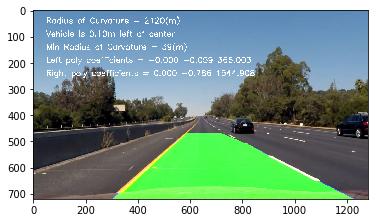

In [4]:
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)